# Phase IV
In the last [notebook](https://github.com/Sylar257/Single-Shot-Detection-project/blob/master/Phase%20II--Initialization%20%26%20learning%20rate%20annealing%20.ipynb), we built a  vanilla SSD with gradual unfreezing in that we trained the auxiliary layers first while `.requires_grad=False` for alll the layers in the `model.base`.<br>
The results unfortunately got a lot worse(mAP = 0.496) which is also reflected in the trainin loss. It's not difficult to see that our training process did not go the way with what we want. Hence, we need to regulate it.<br>
In this notebook, we will implement `Batch normalization` in both our `model.base` and `model.auxiliary`. Inaddition, gradient clipping while we training our network. The batch normalization implementation is based on [This paper](https://arxiv.org/pdf/1805.11604.pdf).

### Initialization
In the previous version, we have a base net which is a pre-trained VGG-16. On top of our base, we have two extensions (AuxiliaryConvolutions & PredictionConvolutions) that need to be initialized. We adopted the traditional initialization method from the [original paper](https://arxiv.org/abs/1512.02325), xavier uniform. <br>
However, it was pointed out in this [paper](https://arxiv.org/pdf/1502.01852.pdf) that initialization is crutial to the training process of a neural network and Xavier is not the best candidate when we adopt 'ReLU' activation after our Conv layers.<br>
Hence, we make modification to the our AuxiliaryConvolutions & PredictionConvolutions to `Kaiming_uniform_` initialization.

Reference form the original paper: <br>
    Rectifier networks are easier to train compared with traditional *sigmoid-like* activation networks. But a bad initialization can still hamper the learning of a highly non-linear system. Let’s see how robust initialization method that removes an obstacle of training extremely deep rectifier networks.

Recent deep CNNs are mostly initialized by random weights drawn from ***Gaussian distributions***. With fixed standard deviations (e.g. 0.01), very deep models have difficulties to converge and leads to poorer local optimum. *Glorot and Bengio* proposed to adopt a properly scaled uniform distribution for initialization. This is called “*Xavier*” initialization. Its derivation is based on the assumption that the activations are linear. This assumptions is invalid for **ReLU**.

Therefore, He et. al. derived a theoretically more sound initialization by taking **ReLU** into account. This method greatly improved our ability to train our models towards convergence.

The central idea is to investigate the variance of the responses in each layer, for a **Conv layer**, a response is:

​												$$y_l = W_lX_l+b_l$$		

Here, x is a $k^2c$-by-1 vector that represents co-located $k\times k$ pixels in $c$ input channels.$k$ is the spatial filter size of the layer. With $n=k^2c$ denoting the number of connections of a response, $W$ is a $d$-by-$n$ matrix, where $d$ is the number of filters and each row of $W$ represents the weights of a filter.**$b$** is vector of biases, and $y$ is the response at a pixel of the output map. We use $l$ to index a layer and have $x_l = f(y_{l-1})$ where $f$ is the activation. Finally, $c_l=d_{l-1}$.

**A note there**: a **Conv** layer can also viewed just as a **Dense** layer activation is this fashion.

We let the initialized elements in $W_l$ be mutually independent and share the same distribution. Assuming that the elements in $x_l$ are also mutually independent and share the same distribution, and $x_l$ and $W_l$ are independent of each other. Then we have:
$$
\begin{align*}
	Var[y_l] = n_lVar[w_lx_l]
\end{align*}
$$
where now $y_l$,$x_l$, and $w_l$ represent the random variables of each element in $y_l$, $W_l$, and $x_l$ respectively. We let $w_l$ have zero mean. Then the variance of the product of independent variables gives us: 
$$
￼
\begin{align*}
    Var[y_l] = n_lVar[w_l]E[{x_l}^2]
\end{align*}
$$
Here $E[{x_l}^2]$ is the expectation of the square of $x_l$. 

With $L$ layers put together, we have:
$$
￼\begin{align*}
    Var[y_L] = Var[y_l](\prod_{l=2}^L\frac{1}{2}n_lVar[w_l])
\end{align*}
$$
This leads to a zero-mean **Gaussian distribution** whose standard deviation is $\sqrt{2/n_l}$. This is *Kaiming He*‘s way of initialization. They also initialize $b=0$.

In [1]:
from torch import nn
from utils import *
import torch.nn.functional as F
from math import sqrt
from itertools import product as product
import torchvision
import time
import torch.backends.cudnn as cudnn
import torch.utils.data
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from utils import transform
# specify GPU for cuda
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

In [2]:
class VGGBase(nn.Module):
    """
    We implement VGG-16 here for low-level feature extraction
    This is a version with batchnorm implemented
    """

    def __init__(self):
        super(VGGBase, self).__init__()

        # Stabdard convolutional layers in VGG16
        # We have an input size of 300 by 300
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)   # stride = 1, output = (300+2-3)/1+1 = 300
        self.bn_1_1  = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # output = 300 as before
        self.bn_1_2  = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)          # output = (300-2)/2+1 = 150

        self.conv2_1 = nn.Conv2d(64,  128, kernel_size=3, padding=1)# output = (150+2-3)/1+1 = 150
        self.bn_2_1  = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)# output = (150+2-3)/1+1 = 150
        self.bn_2_2  = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)          # output = (150-2)/2 +1  = 75

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)# output = (75+2-3)/1+1 = 75
        self.bn_3_1  = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)# output = (75+2-3)/1+1 = 75
        self.bn_3_2  = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)# output = (75+2-3)/1+1 = 75
        self.bn_3_3  = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims
        # output = ceil((75-2)/2)-1 = 38   if floor we would be getting 37 here which is an odd number

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output = (38+2-3)/1+1 = 38
        self.bn_4_1  = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (38+2-3)/1+1 = 38
        self.bn_4_2  = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (38+2-3)/1+1 = 38
        self.bn_4_3  = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)           # output = (38-2)/2 +1  = 19

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (19+2-3)/1+1 = 19
        self.bn_5_1  = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (19+2-3)/1+1 = 19
        self.bn_5_2  = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (19+2-3)/1+1 = 19
        self.bn_5_3  = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # We retain the size at this step with padding and stride of 1
        # output = (19+2-3)/1+1 = 19

        # Here we replace the FC6 and FC7 with the technique introduce by sgrvinod(same with the original paper)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6) # output = (19+12-3-2*(6-1))/1+1 = 19

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)                       # output = (19-1)/1+1 = 19

        # Load pretrained layers
        self.load_pretrained_layers()

    def forward(self, image):
        """
        Forward run with an image input of size 300 by 300
        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = F.relu(self.bn_1_1(self.conv1_1(image)))   # (N,64,300,300)
        out = F.relu(self.bn_1_2(self.conv1_2(out)))     # (N,64,300,300)
        out = self.pool1(out)               # (N,64,150,150)

        out = F.relu(self.bn_2_1(self.conv2_1(out)))  # (N,128,150,150)
        out = F.relu(self.bn_2_2(self.conv2_2(out)))  # (N,128,150,150)
        out = self.pool2(out)            # (N,128, 75, 75)

        out = F.relu(self.bn_3_1(self.conv3_1(out)))  # (N,256, 75, 75)
        out = F.relu(self.bn_3_2(self.conv3_2(out)))  # (N,256, 75, 75)
        out = F.relu(self.bn_3_3(self.conv3_3(out)))  # (N,256, 75, 75)
        out = self.pool3(out)            # (N,256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.bn_4_1(self.conv4_1(out)))  # (N, 512, 38, 38)
        out = F.relu(self.bn_4_2(self.conv4_2(out)))  # (N, 512, 38, 38)
        out = F.relu(self.bn_4_3(self.conv4_3(out)))  # (N, 512, 38, 38)
        # here we extract the feature from conv4_3
        conv4_3_feats = out              # (N, 512, 38, 38)
        out = self.pool4(out)            # (N, 512, 19, 19)

        out = F.relu(self.bn_5_1(self.conv5_1(out)))  # (N, 512, 19, 19)
        out = F.relu(self.bn_5_2(self.conv5_2(out)))  # (N, 512, 19, 19)
        out = F.relu(self.bn_5_3(self.conv5_3(out)))  # (N, 512, 19, 19)
        out = self.pool5(out)            # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))    # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        """
        Use pre-trained wieght from Torch Vsion. 
        Convert fc6 and fc7 weights into conv6 and conv7
        """
        # Current state of base
        state_dict = self.state_dict()
        
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16_bn(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.load_state_dict(state_dict)

        print("\nLoaded base model with pre-trained weights\n")

In [3]:
class VGGBase(nn.Module):
    """
    We implement VGG-16 here for low-level feature extraction
    This is a version with batchnorm implemented
    """

    def __init__(self):
        super(VGGBase, self).__init__()

        # Stabdard convolutional layers in VGG16
        # We have an input size of 300 by 300
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)   # stride = 1, output = (300+2-3)/1+1 = 300
        self.bn_1_1  = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # output = 300 as before
        self.bn_1_2  = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)          # output = (300-2)/2+1 = 150

        self.conv2_1 = nn.Conv2d(64,  128, kernel_size=3, padding=1)# output = (150+2-3)/1+1 = 150
        self.bn_2_1  = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)# output = (150+2-3)/1+1 = 150
        self.bn_2_2  = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)          # output = (150-2)/2 +1  = 75

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)# output = (75+2-3)/1+1 = 75
        self.bn_3_1  = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)# output = (75+2-3)/1+1 = 75
        self.bn_3_2  = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)# output = (75+2-3)/1+1 = 75
        self.bn_3_3  = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims
        # output = ceil((75-2)/2)-1 = 38   if floor we would be getting 37 here which is an odd number

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output = (38+2-3)/1+1 = 38
        self.bn_4_1  = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (38+2-3)/1+1 = 38
        self.bn_4_2  = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (38+2-3)/1+1 = 38
        self.bn_4_3  = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)           # output = (38-2)/2 +1  = 19

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (19+2-3)/1+1 = 19
        self.bn_5_1  = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (19+2-3)/1+1 = 19
        self.bn_5_2  = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (19+2-3)/1+1 = 19
        self.bn_5_3  = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # We retain the size at this step with padding and stride of 1
        # output = (19+2-3)/1+1 = 19

        # Here we replace the FC6 and FC7 with the technique introduce by sgrvinod(same with the original paper)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6) # output = (19+12-3-2*(6-1))/1+1 = 19

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)                       # output = (19-1)/1+1 = 19

        # Load pretrained layers
        self.load_pretrained_layers()

    def forward(self, image):
        """
        Forward run with an image input of size 300 by 300
        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = F.relu(self.bn_1_1(self.conv1_1(image)))   # (N,64,300,300)
        out = F.relu(self.bn_1_2(self.conv1_2(out)))     # (N,64,300,300)
        out = self.pool1(out)               # (N,64,150,150)

        out = F.relu(self.bn_2_1(self.conv2_1(out)))  # (N,128,150,150)
        out = F.relu(self.bn_2_2(self.conv2_2(out)))  # (N,128,150,150)
        out = self.pool2(out)            # (N,128, 75, 75)

        out = F.relu(self.bn_3_1(self.conv3_1(out)))  # (N,256, 75, 75)
        out = F.relu(self.bn_3_2(self.conv3_2(out)))  # (N,256, 75, 75)
        out = F.relu(self.bn_3_3(self.conv3_3(out)))  # (N,256, 75, 75)
        out = self.pool3(out)            # (N,256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.bn_4_1(self.conv4_1(out)))  # (N, 512, 38, 38)
        out = F.relu(self.bn_4_2(self.conv4_2(out)))  # (N, 512, 38, 38)
        out = F.relu(self.bn_4_3(self.conv4_3(out)))  # (N, 512, 38, 38)
        # here we extract the feature from conv4_3
        conv4_3_feats = out              # (N, 512, 38, 38)
        out = self.pool4(out)            # (N, 512, 19, 19)

        out = F.relu(self.bn_5_1(self.conv5_1(out)))  # (N, 512, 19, 19)
        out = F.relu(self.bn_5_2(self.conv5_2(out)))  # (N, 512, 19, 19)
        out = F.relu(self.bn_5_3(self.conv5_3(out)))  # (N, 512, 19, 19)
        out = self.pool5(out)            # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))    # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        """
        Use pre-trained wieght from Torch Vsion. 
        Convert fc6 and fc7 weights into conv6 and conv7
        """
        # Current state of base
        state_dict = self.state_dict()
        
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16_bn(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.load_state_dict(state_dict)

        print("\nLoaded base model with pre-trained weights\n")

In [2]:
class VGGBase(nn.Module):
    """
    We implement VGG-16 here for low-level feature extraction
    No Batchnorm in this version
    """

    def __init__(self):
        super(VGGBase, self).__init__()

        # Stabdard convolutional layers in VGG16
        # We have an input size of 300 by 300
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)   # stride = 1, output = (300+2-3)/1+1 = 300
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # output = 300 as before
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)          # output = (300-2)/2+1 = 150

        self.conv2_1 = nn.Conv2d(64,  128, kernel_size=3, padding=1)# output = (150+2-3)/1+1 = 150
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)# output = (150+2-3)/1+1 = 150
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)          # output = (150-2)/2 +1  = 75

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)# output = (75+2-3)/1+1 = 75
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)# output = (75+2-3)/1+1 = 75
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)# output = (75+2-3)/1+1 = 75
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims
        # output = ceil((75-2)/2)-1 = 38   if floor we would be getting 37 here which is an odd number

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output = (38+2-3)/1+1 = 38
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (38+2-3)/1+1 = 38
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (38+2-3)/1+1 = 38
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)           # output = (38-2)/2 +1  = 19

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (19+2-3)/1+1 = 19
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (19+2-3)/1+1 = 19
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output = (19+2-3)/1+1 = 19
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # We retain the size at this step with padding and stride of 1
        # output = (19+2-3)/1+1 = 19

        # Here we replace the FC6 and FC7 with the technique introduce by sgrvinod(same with the original paper)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6) # output = (19+12-3-2*(6-1))/1+1 = 19

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)                       # output = (19-1)/1+1 = 19

        # Load pretrained layers
        self.load_pretrained_layers()

    def forward(self, image):
        """
        Forward run with an image input of size 300 by 300
        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = F.relu(self.conv1_1(image))   # (N,64,300,300)
        out = F.relu(self.conv1_2(out))     # (N,64,300,300)
        out = self.pool1(out)               # (N,64,150,150)

        out = F.relu(self.conv2_1(out))  # (N,128,150,150)
        out = F.relu(self.conv2_2(out))  # (N,128,150,150)
        out = self.pool2(out)            # (N,128, 75, 75)

        out = F.relu(self.conv3_1(out))  # (N,256, 75, 75)
        out = F.relu(self.conv3_2(out))  # (N,256, 75, 75)
        out = F.relu(self.conv3_3(out))  # (N,256, 75, 75)
        out = self.pool3(out)            # (N,256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        # here we extract the feature from conv4_3
        conv4_3_feats = out              # (N, 512, 38, 38)
        out = self.pool4(out)            # (N, 512, 19, 19)

        out = F.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)            # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))    # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        """
        Use pre-trained wieght from Torch Vsion. 
        Convert fc6 and fc7 weights into conv6 and conv7
        """
        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.load_state_dict(state_dict)


In [3]:
# Initializa AuxiliaryConvolutions with Kaiming_uniform_ and set non-linearity to 'relu'
# Batchnorm implemented

class AuxiliaryConvolutions(nn.Module):
    """
    These layers are put on top of base model to produce more feature maps for object detections.(smaller maps)
    """

    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)         # output=(19-1)/1+1 = 19
        self.bn_8_1  = nn.BatchNorm2d(256)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)# output=(19+2-3)/2+1 = 10
        self.bn_8_2  = nn.BatchNorm2d(512)

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)          # output=(10-1)/1+1 = 10
        self.bn_9_1  = nn.BatchNorm2d(128)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)# output=(10+2-3)/2+1 = 5 because by defaul we use "floor"
        self.bn_9_2  = nn.BatchNorm2d(256)
        
        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)         # output=(5-1)/1+1 = 5
        self.bn_10_1  = nn.BatchNorm2d(128)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)         # output=(5-3)/1+1 = 3
        self.bn_10_2  = nn.BatchNorm2d(256)
        
        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)         # output=(3-1)/1+1 = 3
        self.bn_11_1  = nn.BatchNorm2d(128)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)         # output=(3-3)/1+1 = 1
        self.bn_11_2  = nn.BatchNorm2d(256)
        
        self.init_conv2d()
        
    def init_conv2d(self):
        """
        Initialize convolution parameters
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.kaiming_uniform_(c.weight, nonlinearity='relu')
                nn.init.constant_(c.bias, 0.) 
            elif isinstance(c, nn.BatchNorm2d):
                nn.init.constant_(c.weight, 1)
                nn.init.constant_(c.bias, 0)
                print('bn layer initialized')
                
    def forward(self, conv7_feats):
        """
        conv7_feats: (N, 1024, 19, 19)
        return: higher-level feature maps conv8_2, conv9_2, conv10_2, and conv11_2
        """
        out = F.relu(self.bn_8_1(self.conv8_1(conv7_feats)))  # (N, 256, 19, 19)
        out = F.relu(self.bn_8_2(self.conv8_2(out)))  # (N, 512, 10, 10)
        conv8_2_feats = out  # (N, 512, 10, 10)

        out = F.relu(self.bn_9_1(self.conv9_1(out)))  # (N, 128, 10, 10)
        out = F.relu(self.bn_9_2(self.conv9_2(out)))  # (N, 256, 5, 5)
        conv9_2_feats = out  # (N, 256, 5, 5)

        out = F.relu(self.bn_10_1(self.conv10_1(out)))  # (N, 128, 5, 5)
        out = F.relu(self.bn_10_2(self.conv10_2(out)))  # (N, 256, 3, 3)
        conv10_2_feats = out  # (N, 256, 3, 3)

        out = F.relu(self.bn_11_1(self.conv11_1(out)))  # (N, 128, 3, 3)
        conv11_2_feats = F.relu(self.bn_11_2(self.conv11_2(out)))  # (N, 256, 1, 1)

        # Higher-level feature maps
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats
    

In [4]:
# Same as above, we replace xavier_uniform with kaiming_uniform_

class PredictionConvolutions(nn.Module):
    """
    Convolutions to predict class scores and bounding boxes using lower and higher level feature maps

    The bounding boxes (offsets (g_{c_x}, g_{c_y}, g_w, g_h) of the 8732 default priors)
    See 'cxcy_to_gcxgcy' in utils.py for encoding definition

    The class scores represent the scores of each object class in each of the 8732 hounding boxes
    A high score for 'background' = no object
    """

    def __init__(self, n_classes):
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        # Number of proior_boxes we are considering per position in each feature map
        n_boxes = {'conv4_3': 4,
                    'conv7': 6,
                    'conv8_2': 6,
                    'conv9_2': 6,
                    'conv10_2': 4,
                    'conv11_2': 4}
        # 4 prior-boxes prediction convoluitions (predict offsets w.r.t prior-boxes)

        # This is the part to compute LOCALIZATION prediction
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3']*4, kernel_size=3, padding=1) # output = (38-3+2)/1+1 = 38, same padding
        self.loc_conv7   = nn.Conv2d(1024, n_boxes['conv7']*4, kernel_size=3, padding=1)  # output = (19-3+2)/1+1 = 19
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2']*4, kernel_size=3, padding=1) # output = (10-3+2)/1+1 = 10
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2']*4, kernel_size=3, padding=1) # output = (5-3+2)/1 +1 = 5
        self.loc_conv10_2= nn.Conv2d(256, n_boxes['conv10_2']*4,kernel_size=3, padding=1) # output = (3-3+2)/1 +1 = 3
        self.loc_conv11_2= nn.Conv2d(256, n_boxes['conv11_2']*4,kernel_size=3, padding=1) # output = (1-3+2)/1 +1 = 1

        # This is the part to comput CLASS prediction
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7   = nn.Conv2d(1024,n_boxes['conv7']   * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256,n_boxes['conv10_2'] * n_classes,kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256,n_boxes['conv11_2'] * n_classes,kernel_size=3, padding=1)

        self.init_conv2d()
    def init_conv2d(self):
        # Use Kaiming_uniform_ here instead of xavier_uniform_
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.kaiming_uniform_(c.weight, nonlinearity='relu')
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        """
        Forward propagation.
        :param conv4_3_feats: conv4_3 feature map, a tensor of dimensions (N, 512, 38, 38)
        :param conv7_feats: conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :param conv8_2_feats: conv8_2 feature map, a tensor of dimensions (N, 512, 10, 10)
        :param conv9_2_feats: conv9_2 feature map, a tensor of dimensions (N, 256, 5, 5)
        :param conv10_2_feats: conv10_2 feature map, a tensor of dimensions (N, 256, 3, 3)
        :param conv11_2_feats: conv11_2 feature map, a tensor of dimensions (N, 256, 1, 1)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        batch_size = conv4_3_feats.size(0)

        # Predict localization boxes' bounds w.r.t prior boxes
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)            # (N, 16, 38, 38)  16 is from 4 priors 4*4=16
        l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous() # (N, 38, 38, 16)  to match prior-box order (after .view())
        # .contiguous() ensures it is stores in a contiguous chunk of memory, needed for .view() below

        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)          # This give us (N, 5776, 4) the (g_{c_x}, g_{c_y}, g_w, g_h) for all 5776 priors

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 24)
        l_conv7 = l_conv7.view(batch_size, -1, 4)  # (N, 2166, 4), there are a total 2116 boxes on this feature map

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 24)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  # (N, 600, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 24)
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  # (N, 150, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 16, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 16)
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  # (N, 36, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 16)
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  # (N, 4, 4)

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 4 * n_classes), to match prior-box order (after .view())
        c_conv4_3 = c_conv4_3.view(batch_size, -1,
                                    self.n_classes)  # (N, 5776, n_classes), there are a total 5776 boxes on this feature map

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 6 * n_classes)
        c_conv7 = c_conv7.view(batch_size, -1,
                                self.n_classes)  # (N, 2166, n_classes), there are a total 2116 boxes on this feature map

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 6 * n_classes)
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  # (N, 600, n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 6 * n_classes)
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)  # (N, 150, n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 4 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 4 * n_classes)
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)  # (N, 36, n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 4 * n_classes)
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)  # (N, 4, n_classes)

        # A total of 8732 boxes
        # Concatenate in this specific order    
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  # (N, 8732, 4)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2], dim=1)  # (N, 8732, n_classes)

        return locs, classes_scores

In [5]:
class SSD300(nn.Module):
    def __init__(self, n_classes):

        """
        This class works as a wrapper that encapsulates the base VGG network, auxiliary, and prediciton convolutions.
        """
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)

        # Since lower level features (conv4_3_feats) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factor = nn.Parameter(torch.FloatTensor(1, 512, 1, 1)) # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factor, 20)

        # The above two lines demonstrate a simple example of how do add a leanable-parameter into our computation

        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()  # with shape of (8732, 4)

    def create_prior_boxes(self):
        """
        Create the 8732 prior (default) boxes for the SSD300, as defined in the paper.
        :return: prior boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)

        return prior_boxes
    
    def forward(self, image):
        """
        Forward propagation

        image: (N, 3, 300, 300)
        return:  8732 locations and class scores (i.e.  w.r.t each prior box) for the given image(s)
        """

        # Run VGG base network convolutions (lower level feature map generators, up to conv7)
        conv4_3_feats, conv7_feats = self.base(image)   # (N, 512, 38, 38),  (N, 1024, 19, 19)

        # Rescale conv4_3 after L2 norm using our learnable parameter
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = conv4_3_feats / norm                         # (N, 512, 38, 38) this step was done by broadcasting
        conv4_3_feats = conv4_3_feats*self.rescale_factor            # (N, 512, 38, 38)

        # Run auxiliaury convolution (higher level feature map extraction)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = self.aux_convs(conv7_feats) 
        # (N, 512, 10, 10), (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)

        # Run prediction convolutions (predict offset w.r.t. priors and classes in each resulting location)
        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats)
        # (N, 8732, 4), (N, 8732, n_classes)

        return locs, classes_scores
    
    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of our forward pass) to detect objects.

        For each class. perform Non-Maximum Suppression (NMS) on boxes that are above a minimum score

        predicted_locs: predicted locations w.r.t the 8732 prior boxes, a tensor of (N, 8732, 4)
        predicted_scores: predicted class score for each of prediced locations, a tensor of (N, 8732, n_classes)
        min_score: the minimun score for a box to be consifered a match for a CERTAIN CLASS
        max_overlap: the maximum overlap that we allow. For any pair of boxes with higher overlap, the lower class score one will be suppressed
        top_k: if there are a lot of resulting detection across all classes, keep only the top_k 
        
        return: detections (boxes, labels, and scores), lists of length batch_size N
        """
        batch_size = predicted_locs.size(0) # N
        n_priors = self.priors_cxcy.size(0) # 8732
        predicted_scores = F.softmax(predicted_scores, dim=2) # (N, 8732, n_classes)

        # list to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_scores = list()
        all_images_labels = list()

        assert n_priors == predicted_scores.size(1) == predicted_locs.size(1)

        for i in range(batch_size):
            # Convert diviation from prior boxes to (c_x, c_y, w, h)
            # Convert bounding boxes from center-size coordinates (c_x, c_y, w, h) to boundary coordinates (x_min, y_min, x_max, y_max)
            
            decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_scores = list()
            image_labels = list()

            max_score,  best_label = predicted_scores[i].max(dim=1) # (8732), (8732)

            # operations for each class. Class 0 is not included here because it denotes background(negative)
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above minimum_score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score # torch.uint8 (byte) tensor, for infexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                # here, we will retain the score & locs of the boxes with score higher than the threshold
                class_scores = class_scores[score_above_min_score] # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score] # (n_qualfied, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs) # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)
                
                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

In [6]:
class MultiBoxLoss(nn.Module):
    """
    The Multibox loss function for SSD300 architecture, which is a combination of:

    1) a localization loss for the predicted locations of the boxes, and
    2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS
        print(f'confidence loss for this minibatch: {conf_loss:.3f}\n location loss for this minibatch:{loc_loss:.3f}')

        return conf_loss + self.alpha * loc_loss

In [7]:
class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used as DataLoader later
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        data_folder: folder where data files are stored
        split: this must be either 'TRAIN' or 'TEST'
        keep_difficult: keep or discard objects that are considered as difficult(a property come with the dataset)
        """
        self.split = split.upper()

        assert self.split in {'TRAIN','TEST'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        with open(os.path.join(data_folder,self.split+'_images.json'),   'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split+'_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)
    
    def __getitem__(self, i):
        # Read Image
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')

        # Read objects in this image (bounding boxes, labels, difficulties)
        objects = self.objects[i]
        boxes  = torch.FloatTensor(objects['boxes']) # (n_objects, 4)
        labels = torch.LongTensor(objects['labels']) # (n_objects)
        difficulties = torch.ByteTensor(objects['difficulties'])  # (n_objects)

        # Discard difficult objects, if specified
        if not self.keep_difficult:
            boxes = boxes[1-difficulties]
            labels = labels[1-difficulties]
            difficulties = difficulties[1-difficulties]

        # Apply transformations
        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, self.split)

        return image, boxes, labels, difficulties

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader)

        This describes how to combine these tensors of different sizes. We use lists.

        @Params
        batch: an iterable of N sets from __getitem__()
        return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes  = list()
        labels = list()
        difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each

### Learning rate annealing
In the first phase, we used a constant learning rate in our training loop. 
Decay the learning rate by a ratio of 0.9, when our model cease to make an improvemnet. 
This was recommentded in the [original paper](https://arxiv.org/abs/1512.02325). <br>
What we are going to do differently this time is to implement a learning rate scheduler that anneal our learning rate in a way that it has a period of "warming up & catch up speed", followed by a period of "high learning rate" then gradually slow down to find good convergence.

In [8]:
import torch
import math
import matplotlib.pyplot as plt
from functools import partial
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos): return start
@annealer
def sched_exp(start, end, pos): return start*(end/start)**pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

### Here we will build different annealing options
Cosine scheduling will be implemented later same as it's done in FastAI library

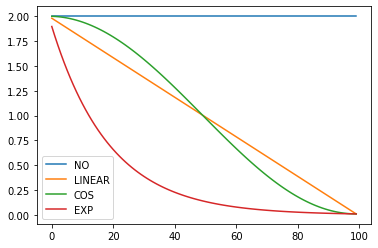

In [9]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [10]:
from torch import tensor
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + list(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

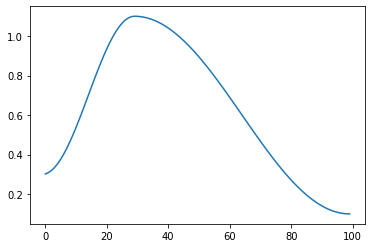

In [11]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 1.1), sched_cos(1.1, 0.1)])
plt.plot(a, [sched(o) for o in p])

In [12]:
# the learning rate scheduler used in training loop
sched = combine_scheds([0.3, 0.7], [sched_cos(1e-4, 2e-3), sched_cos(2e-3, 1e-6)])
losses = AverageMeter()  # temerory for debugging

def train(train_loader, model, criterion, optimizer, epoch, total_iters):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    :param total_iters: total_number of iterations
    """
    model.train()  # training mode enables dropout and batchnorm

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
#     losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar
        
        # learning rate annealing
        current_iter = epoch*n_batches+i
        
        # learning rate anealing and visualization for later
    
        optimizer.param_groups[0]['lr'] = sched(current_iter/total_iters)*2    # this is the bias group

        optimizer.param_groups[1]['lr'] = sched(current_iter/total_iters)      # this is the non-bias group

        learning_rates.append(optimizer.param_groups[1]['lr'])

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored


def validate(val_loader, model, criterion):
    """
    One epoch's validation.
    :param val_loader: DataLoader for validation data
    :param model: model
    :param criterion: MultiBox loss
    :return: average validation loss
    """
    model.eval()  # eval mode disables dropout and batchnorm

    batch_time = AverageMeter()
    losses = AverageMeter()

    start = time.time()

    # Prohibit gradient computation explicity because I had some problems with memory
    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels, difficulties) in enumerate(val_loader):

            # Move to default device
            images = images.to(device)  # (N, 3, 300, 300)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]

            # Forward prop.
            predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

            # Loss
            loss = criterion(predicted_locs, predicted_scores, boxes, labels)

            losses.update(loss.item(), images.size(0))
            batch_time.update(time.time() - start)

            start = time.time()

            # Print status
            if i % print_freq == 0:
                print('[{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(i, len(val_loader),
                                                                      batch_time=batch_time,
                                                                      loss=losses))

    print('\n * LOSS - {loss.avg:.3f}\n'.format(loss=losses))

    return losses.avg

#### Here, we construct a simple function to assert of all layers in a module are frozen

In [13]:
def assert_requires_grad(module):
    """
    This function asserts is all layers in the module has the .requires_grad set to False, namely frozen
    """
    condition = list()
    for param in module.parameters():
        condition.append(param.requires_grad)
    return (not any(condition))

## First training stage
In this stage, we will be freezing all weights in the model.base while training the weights in the other 2 modules (model.aux_convs & model.pred_convs).<br>
For the sake of fare comparison with Phase I & Phase II, we are going to train 200 epochs in total.<br>
Hence, 100 epochs in stage-1 and 100 epochs in stage-2.

In [14]:
# Training SSD300 with Kaiming_uniform_ and learning rate annealing
global epochs_since_improvement, start_epoch, label_map, best_loss, epoch, checkpoint

data_folder = './'
keep_difficult = True
n_classes = len(label_map)

# Training parameters
checkpoint = None  # path to model checkpoint if consider resume training from there
batch_size = 32
start_epoch = 0    # start at this epoch
epochs = 120       # total training epochs to run without early-stopping
epochs_since_improvement = 0 # record the no. of epochs since last improvement
best_loss = 100.   # assume a hight loss at first
workers = 4        # number of workers for loading data in the DataLoader
print_freq = 200   # print training or validation status every __ batches
lr = 1e-3/2          # learning rate
momentum = 0.9     
weight_decay = 5e-4
grad_clip = 5   # consider clipping the gradient when using high learning_rate

torch.cuda.empty_cache()
cudnn.benchmark = True

# initialize model or load checkpoint
if checkpoint is None:
    model = SSD300(n_classes)
    print(f'After loading model weights, layers model.base frozen condition:{assert_requires_grad(model.base)}')
    print(f'After loading model weights, layers model.aux_convs frozen condition:{assert_requires_grad(model.aux_convs)}')
    print(f'After loading model weights, layers model.pred_convs frozen condition:{assert_requires_grad(model.pred_convs)}')
        
    for i,param in enumerate(model.base.parameters()):
        param.requires_grad = False
        
    print(f'Freeze weights in model.base, condition:{assert_requires_grad(model.base)}')
    
    # Initialize the optimizer, with twice the default learning rate for biases
    biases = list()
    not_biases = list()
    for param_name, param in model.named_parameters():
        if param.requires_grad:
            if param_name.endswith('.bias'):
                biases.append(param)
            else:
                not_biases.append(param)
    optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_loss = checkpoint['best_loss']
    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
    
# move to  default device
model = model.to(device)      # model to GPU
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device) # Loss function to GPU

# Custom dataloaders
train_dataset = PascalVOCDataset(data_folder,'train',keep_difficult)
val_dataset   = PascalVOCDataset(data_folder,'test' ,keep_difficult)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                            collate_fn=train_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True) # pass in our collate function here
val_loader    = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                                             collate_fn=val_dataset.collate_fn, num_workers=workers,
                                             pin_memory=True)
# used to schedule learning rate later
n_batches = len(train_loader)

learning_rates = list()
total_iters = epochs*n_batches

# Epochs
for epoch in range(start_epoch, epochs):
            
    train(train_loader=train_loader,
          model=model,
          criterion=criterion,
          optimizer=optimizer,
          epoch=epoch,
          total_iters=total_iters
          )

    # One epoch's validation
    val_loss = validate(val_loader=val_loader,
                        model=model,
                        criterion=criterion)

    # Did validation loss improve?
    is_best = val_loss < best_loss
    best_loss = min(val_loss, best_loss)

    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

    else:
        epochs_since_improvement = 0

    # Save checkpoint
    save_checkpoint(epoch, epochs_since_improvement, model, optimizer, val_loss, best_loss, is_best, filename='Batchnorm_training_ssd300.pth.tar')

bn layer initialized
bn layer initialized
bn layer initialized
bn layer initialized
bn layer initialized
bn layer initialized
bn layer initialized
bn layer initialized
After loading model weights, layers model.base frozen condition:False
After loading model weights, layers model.aux_convs frozen condition:False
After loading model weights, layers model.pred_convs frozen condition:False
Freeze weights in model.base, condition:True


/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


confidence loss for this minibatch: 24.269
 location loss for this minibatch:1.433
Epoch: [0][0/518]	Batch Time 6.347 (6.347)	Data Time 2.083 (2.083)	Loss 25.7025 (25.7025)	
confidence loss for this minibatch: 23.853
 location loss for this minibatch:1.330
confidence loss for this minibatch: 24.084
 location loss for this minibatch:1.365
confidence loss for this minibatch: 23.170
 location loss for this minibatch:1.439
confidence loss for this minibatch: 22.750
 location loss for this minibatch:1.427
confidence loss for this minibatch: 23.122
 location loss for this minibatch:1.369
confidence loss for this minibatch: 22.804
 location loss for this minibatch:1.387
confidence loss for this minibatch: 22.231
 location loss for this minibatch:1.347
confidence loss for this minibatch: 21.628
 location loss for this minibatch:1.360
confidence loss for this minibatch: 21.556
 location loss for this minibatch:1.411
confidence loss for this minibatch: 21.380
 location loss for this minibatch:1.

confidence loss for this minibatch: 12.986
 location loss for this minibatch:1.262
confidence loss for this minibatch: 13.139
 location loss for this minibatch:1.348
confidence loss for this minibatch: 12.962
 location loss for this minibatch:1.308
confidence loss for this minibatch: 12.817
 location loss for this minibatch:1.265
confidence loss for this minibatch: 13.022
 location loss for this minibatch:1.319
confidence loss for this minibatch: 12.871
 location loss for this minibatch:1.307
confidence loss for this minibatch: 13.079
 location loss for this minibatch:1.310
confidence loss for this minibatch: 13.027
 location loss for this minibatch:1.267
confidence loss for this minibatch: 13.146
 location loss for this minibatch:1.239
confidence loss for this minibatch: 13.064
 location loss for this minibatch:1.407
confidence loss for this minibatch: 13.082
 location loss for this minibatch:1.325
confidence loss for this minibatch: 12.927
 location loss for this minibatch:1.275
conf

confidence loss for this minibatch: 11.824
 location loss for this minibatch:1.269
confidence loss for this minibatch: 12.235
 location loss for this minibatch:1.284
confidence loss for this minibatch: 12.069
 location loss for this minibatch:1.253
confidence loss for this minibatch: 12.017
 location loss for this minibatch:1.291
Epoch: [0][200/518]	Batch Time 0.577 (0.590)	Data Time 0.298 (0.270)	Loss 13.3080 (15.5589)	
confidence loss for this minibatch: 12.100
 location loss for this minibatch:1.245
confidence loss for this minibatch: 12.047
 location loss for this minibatch:1.304
confidence loss for this minibatch: 12.155
 location loss for this minibatch:1.270
confidence loss for this minibatch: 11.951
 location loss for this minibatch:1.326
confidence loss for this minibatch: 11.708
 location loss for this minibatch:1.298
confidence loss for this minibatch: 11.941
 location loss for this minibatch:1.313
confidence loss for this minibatch: 11.818
 location loss for this minibatch:

confidence loss for this minibatch: 11.307
 location loss for this minibatch:1.271
confidence loss for this minibatch: 11.376
 location loss for this minibatch:1.241
confidence loss for this minibatch: 11.363
 location loss for this minibatch:1.222
confidence loss for this minibatch: 11.331
 location loss for this minibatch:1.266
confidence loss for this minibatch: 11.564
 location loss for this minibatch:1.299
confidence loss for this minibatch: 11.544
 location loss for this minibatch:1.310
confidence loss for this minibatch: 11.429
 location loss for this minibatch:1.242
confidence loss for this minibatch: 11.455
 location loss for this minibatch:1.299
confidence loss for this minibatch: 11.391
 location loss for this minibatch:1.202
confidence loss for this minibatch: 11.079
 location loss for this minibatch:1.223
confidence loss for this minibatch: 11.360
 location loss for this minibatch:1.262
confidence loss for this minibatch: 11.161
 location loss for this minibatch:1.235
conf

confidence loss for this minibatch: 10.729
 location loss for this minibatch:1.295
confidence loss for this minibatch: 11.038
 location loss for this minibatch:1.315
confidence loss for this minibatch: 10.539
 location loss for this minibatch:1.212
confidence loss for this minibatch: 10.911
 location loss for this minibatch:1.246
confidence loss for this minibatch: 10.722
 location loss for this minibatch:1.235
confidence loss for this minibatch: 10.897
 location loss for this minibatch:1.314
confidence loss for this minibatch: 10.998
 location loss for this minibatch:1.259
Epoch: [0][400/518]	Batch Time 0.294 (0.578)	Data Time 0.000 (0.266)	Loss 12.2568 (14.1263)	
confidence loss for this minibatch: 11.075
 location loss for this minibatch:1.253
confidence loss for this minibatch: 10.589
 location loss for this minibatch:1.263
confidence loss for this minibatch: 10.669
 location loss for this minibatch:1.298
confidence loss for this minibatch: 10.930
 location loss for this minibatch:

confidence loss for this minibatch: 10.056
 location loss for this minibatch:1.299
confidence loss for this minibatch: 10.541
 location loss for this minibatch:1.239
confidence loss for this minibatch: 10.372
 location loss for this minibatch:1.147
confidence loss for this minibatch: 10.241
 location loss for this minibatch:1.262
confidence loss for this minibatch: 10.483
 location loss for this minibatch:1.280
confidence loss for this minibatch: 10.167
 location loss for this minibatch:1.191
confidence loss for this minibatch: 10.399
 location loss for this minibatch:1.316
confidence loss for this minibatch: 10.372
 location loss for this minibatch:1.277
confidence loss for this minibatch: 10.301
 location loss for this minibatch:1.233
confidence loss for this minibatch: 10.302
 location loss for this minibatch:1.327
confidence loss for this minibatch: 10.160
 location loss for this minibatch:1.265
confidence loss for this minibatch: 10.348
 location loss for this minibatch:1.215
conf

confidence loss for this minibatch: 10.166
 location loss for this minibatch:1.279
confidence loss for this minibatch: 10.438
 location loss for this minibatch:1.340
confidence loss for this minibatch: 9.902
 location loss for this minibatch:1.277
confidence loss for this minibatch: 10.134
 location loss for this minibatch:1.300
confidence loss for this minibatch: 10.203
 location loss for this minibatch:1.264
confidence loss for this minibatch: 10.373
 location loss for this minibatch:1.288
confidence loss for this minibatch: 9.920
 location loss for this minibatch:1.226
confidence loss for this minibatch: 10.257
 location loss for this minibatch:1.287
confidence loss for this minibatch: 10.274
 location loss for this minibatch:1.247
confidence loss for this minibatch: 9.987
 location loss for this minibatch:1.259
confidence loss for this minibatch: 9.951
 location loss for this minibatch:1.270
confidence loss for this minibatch: 9.984
 location loss for this minibatch:1.254
confidenc

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SSD300. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type VGGBase. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AuxiliaryConvolutions. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PredictionConvolutions

confidence loss for this minibatch: 9.988
 location loss for this minibatch:1.268
Epoch: [1][0/518]	Batch Time 2.167 (2.167)	Data Time 1.828 (1.828)	Loss 11.2553 (13.5919)	
confidence loss for this minibatch: 10.399
 location loss for this minibatch:1.283
confidence loss for this minibatch: 10.121
 location loss for this minibatch:1.238
confidence loss for this minibatch: 10.063
 location loss for this minibatch:1.232
confidence loss for this minibatch: 9.741
 location loss for this minibatch:1.270
confidence loss for this minibatch: 10.389
 location loss for this minibatch:1.273
confidence loss for this minibatch: 10.187
 location loss for this minibatch:1.227
confidence loss for this minibatch: 10.269
 location loss for this minibatch:1.270
confidence loss for this minibatch: 9.992
 location loss for this minibatch:1.237
confidence loss for this minibatch: 10.168
 location loss for this minibatch:1.241
confidence loss for this minibatch: 10.287
 location loss for this minibatch:1.249

confidence loss for this minibatch: 9.657
 location loss for this minibatch:1.169
confidence loss for this minibatch: 9.362
 location loss for this minibatch:1.214
confidence loss for this minibatch: 9.660
 location loss for this minibatch:1.293
confidence loss for this minibatch: 9.750
 location loss for this minibatch:1.272
confidence loss for this minibatch: 10.075
 location loss for this minibatch:1.226
confidence loss for this minibatch: 9.868
 location loss for this minibatch:1.248
confidence loss for this minibatch: 9.908
 location loss for this minibatch:1.204
confidence loss for this minibatch: 9.711
 location loss for this minibatch:1.195
confidence loss for this minibatch: 9.498
 location loss for this minibatch:1.270
confidence loss for this minibatch: 9.629
 location loss for this minibatch:1.193
confidence loss for this minibatch: 9.906
 location loss for this minibatch:1.189
confidence loss for this minibatch: 9.717
 location loss for this minibatch:1.189
confidence loss

confidence loss for this minibatch: 9.217
 location loss for this minibatch:1.246
confidence loss for this minibatch: 9.395
 location loss for this minibatch:1.237
Epoch: [1][200/518]	Batch Time 0.362 (0.564)	Data Time 0.006 (0.254)	Loss 10.6320 (12.8606)	
confidence loss for this minibatch: 9.272
 location loss for this minibatch:1.219
confidence loss for this minibatch: 9.185
 location loss for this minibatch:1.285
confidence loss for this minibatch: 9.271
 location loss for this minibatch:1.244
confidence loss for this minibatch: 9.445
 location loss for this minibatch:1.255
confidence loss for this minibatch: 9.040
 location loss for this minibatch:1.193
confidence loss for this minibatch: 9.209
 location loss for this minibatch:1.242
confidence loss for this minibatch: 9.184
 location loss for this minibatch:1.169
confidence loss for this minibatch: 9.255
 location loss for this minibatch:1.277
confidence loss for this minibatch: 8.902
 location loss for this minibatch:1.293
confi

confidence loss for this minibatch: 9.044
 location loss for this minibatch:1.291
confidence loss for this minibatch: 9.029
 location loss for this minibatch:1.239
confidence loss for this minibatch: 8.892
 location loss for this minibatch:1.314
confidence loss for this minibatch: 9.085
 location loss for this minibatch:1.206
confidence loss for this minibatch: 8.836
 location loss for this minibatch:1.281
confidence loss for this minibatch: 8.893
 location loss for this minibatch:1.328
confidence loss for this minibatch: 9.313
 location loss for this minibatch:1.181
confidence loss for this minibatch: 8.927
 location loss for this minibatch:1.205
confidence loss for this minibatch: 8.606
 location loss for this minibatch:1.308
confidence loss for this minibatch: 9.269
 location loss for this minibatch:1.205
confidence loss for this minibatch: 8.781
 location loss for this minibatch:1.247
confidence loss for this minibatch: 8.784
 location loss for this minibatch:1.199
confidence loss 

confidence loss for this minibatch: 8.572
 location loss for this minibatch:1.195
confidence loss for this minibatch: 8.500
 location loss for this minibatch:1.281
confidence loss for this minibatch: 8.326
 location loss for this minibatch:1.202
Epoch: [1][400/518]	Batch Time 1.347 (0.566)	Data Time 1.065 (0.257)	Loss 9.5275 (12.2608)	
confidence loss for this minibatch: 8.696
 location loss for this minibatch:1.231
confidence loss for this minibatch: 8.755
 location loss for this minibatch:1.197
confidence loss for this minibatch: 8.612
 location loss for this minibatch:1.180
confidence loss for this minibatch: 8.563
 location loss for this minibatch:1.259
confidence loss for this minibatch: 8.438
 location loss for this minibatch:1.145
confidence loss for this minibatch: 8.506
 location loss for this minibatch:1.205
confidence loss for this minibatch: 8.277
 location loss for this minibatch:1.213
confidence loss for this minibatch: 8.376
 location loss for this minibatch:1.220
confid

confidence loss for this minibatch: 8.092
 location loss for this minibatch:1.235
confidence loss for this minibatch: 8.047
 location loss for this minibatch:1.219
confidence loss for this minibatch: 8.005
 location loss for this minibatch:1.257
confidence loss for this minibatch: 8.394
 location loss for this minibatch:1.165
confidence loss for this minibatch: 8.091
 location loss for this minibatch:1.190
confidence loss for this minibatch: 8.166
 location loss for this minibatch:1.195
confidence loss for this minibatch: 7.956
 location loss for this minibatch:1.228
confidence loss for this minibatch: 8.205
 location loss for this minibatch:1.217
confidence loss for this minibatch: 8.439
 location loss for this minibatch:1.166
confidence loss for this minibatch: 8.486
 location loss for this minibatch:1.202
confidence loss for this minibatch: 8.217
 location loss for this minibatch:1.198
confidence loss for this minibatch: 7.945
 location loss for this minibatch:1.249
confidence loss 

confidence loss for this minibatch: 7.990
 location loss for this minibatch:1.241
confidence loss for this minibatch: 8.199
 location loss for this minibatch:1.253
confidence loss for this minibatch: 8.093
 location loss for this minibatch:1.226
confidence loss for this minibatch: 7.988
 location loss for this minibatch:1.211
confidence loss for this minibatch: 7.772
 location loss for this minibatch:1.272
confidence loss for this minibatch: 8.143
 location loss for this minibatch:1.250
confidence loss for this minibatch: 8.301
 location loss for this minibatch:1.247
confidence loss for this minibatch: 8.282
 location loss for this minibatch:1.208
confidence loss for this minibatch: 7.835
 location loss for this minibatch:1.219
confidence loss for this minibatch: 7.828
 location loss for this minibatch:1.283
confidence loss for this minibatch: 8.245
 location loss for this minibatch:1.346
confidence loss for this minibatch: 7.964
 location loss for this minibatch:1.198
confidence loss 

confidence loss for this minibatch: 7.974
 location loss for this minibatch:1.245
confidence loss for this minibatch: 8.164
 location loss for this minibatch:1.202
confidence loss for this minibatch: 8.361
 location loss for this minibatch:1.192
confidence loss for this minibatch: 8.106
 location loss for this minibatch:1.189
confidence loss for this minibatch: 7.833
 location loss for this minibatch:1.141
confidence loss for this minibatch: 7.923
 location loss for this minibatch:1.258
confidence loss for this minibatch: 7.639
 location loss for this minibatch:1.188
confidence loss for this minibatch: 7.945
 location loss for this minibatch:1.199
confidence loss for this minibatch: 8.156
 location loss for this minibatch:1.190
confidence loss for this minibatch: 8.160
 location loss for this minibatch:1.202
confidence loss for this minibatch: 7.812
 location loss for this minibatch:1.191
confidence loss for this minibatch: 7.919
 location loss for this minibatch:1.169
confidence loss 

confidence loss for this minibatch: 7.771
 location loss for this minibatch:1.232
confidence loss for this minibatch: 7.881
 location loss for this minibatch:1.189
confidence loss for this minibatch: 7.748
 location loss for this minibatch:1.207
confidence loss for this minibatch: 7.527
 location loss for this minibatch:1.192
confidence loss for this minibatch: 7.696
 location loss for this minibatch:1.145
confidence loss for this minibatch: 7.582
 location loss for this minibatch:1.223
confidence loss for this minibatch: 7.796
 location loss for this minibatch:1.168
confidence loss for this minibatch: 7.652
 location loss for this minibatch:1.177
confidence loss for this minibatch: 7.660
 location loss for this minibatch:1.113
confidence loss for this minibatch: 7.608
 location loss for this minibatch:1.206
confidence loss for this minibatch: 7.837
 location loss for this minibatch:1.193
confidence loss for this minibatch: 7.970
 location loss for this minibatch:1.202
confidence loss 

confidence loss for this minibatch: 7.690
 location loss for this minibatch:1.220
confidence loss for this minibatch: 7.930
 location loss for this minibatch:1.228
confidence loss for this minibatch: 7.867
 location loss for this minibatch:1.232
confidence loss for this minibatch: 7.305
 location loss for this minibatch:1.184
confidence loss for this minibatch: 7.623
 location loss for this minibatch:1.185
confidence loss for this minibatch: 7.247
 location loss for this minibatch:1.192
confidence loss for this minibatch: 7.520
 location loss for this minibatch:1.201
confidence loss for this minibatch: 7.353
 location loss for this minibatch:1.193
confidence loss for this minibatch: 7.580
 location loss for this minibatch:1.258
confidence loss for this minibatch: 7.200
 location loss for this minibatch:1.203
confidence loss for this minibatch: 7.560
 location loss for this minibatch:1.148
confidence loss for this minibatch: 7.610
 location loss for this minibatch:1.225
confidence loss 

confidence loss for this minibatch: 7.379
 location loss for this minibatch:1.224
confidence loss for this minibatch: 7.092
 location loss for this minibatch:1.205
confidence loss for this minibatch: 7.340
 location loss for this minibatch:1.153
confidence loss for this minibatch: 7.223
 location loss for this minibatch:1.232
confidence loss for this minibatch: 7.556
 location loss for this minibatch:1.191
confidence loss for this minibatch: 6.971
 location loss for this minibatch:1.179
confidence loss for this minibatch: 7.288
 location loss for this minibatch:1.225
confidence loss for this minibatch: 7.029
 location loss for this minibatch:1.177
confidence loss for this minibatch: 7.547
 location loss for this minibatch:1.198
confidence loss for this minibatch: 7.487
 location loss for this minibatch:1.146
confidence loss for this minibatch: 7.104
 location loss for this minibatch:1.216
confidence loss for this minibatch: 7.085
 location loss for this minibatch:1.217
confidence loss 

confidence loss for this minibatch: 6.908
 location loss for this minibatch:1.165
confidence loss for this minibatch: 7.066
 location loss for this minibatch:1.192
confidence loss for this minibatch: 6.848
 location loss for this minibatch:1.222
confidence loss for this minibatch: 6.873
 location loss for this minibatch:1.191
confidence loss for this minibatch: 6.892
 location loss for this minibatch:1.174
confidence loss for this minibatch: 7.268
 location loss for this minibatch:1.157
confidence loss for this minibatch: 6.974
 location loss for this minibatch:1.146
confidence loss for this minibatch: 7.065
 location loss for this minibatch:1.210
confidence loss for this minibatch: 6.937
 location loss for this minibatch:1.158
confidence loss for this minibatch: 7.092
 location loss for this minibatch:1.190
confidence loss for this minibatch: 7.028
 location loss for this minibatch:1.158
confidence loss for this minibatch: 6.723
 location loss for this minibatch:1.196
confidence loss 

confidence loss for this minibatch: 6.573
 location loss for this minibatch:1.205
confidence loss for this minibatch: 7.081
 location loss for this minibatch:1.206
confidence loss for this minibatch: 6.824
 location loss for this minibatch:1.221
confidence loss for this minibatch: 6.613
 location loss for this minibatch:1.234
confidence loss for this minibatch: 6.758
 location loss for this minibatch:1.208
confidence loss for this minibatch: 6.849
 location loss for this minibatch:1.210
confidence loss for this minibatch: 6.918
 location loss for this minibatch:1.190
confidence loss for this minibatch: 6.911
 location loss for this minibatch:1.174
confidence loss for this minibatch: 6.692
 location loss for this minibatch:1.160
confidence loss for this minibatch: 6.828
 location loss for this minibatch:1.192
confidence loss for this minibatch: 6.518
 location loss for this minibatch:1.203
confidence loss for this minibatch: 6.958
 location loss for this minibatch:1.212
confidence loss 

confidence loss for this minibatch: 6.699
 location loss for this minibatch:1.201
confidence loss for this minibatch: 6.487
 location loss for this minibatch:1.187
confidence loss for this minibatch: 6.821
 location loss for this minibatch:1.255
confidence loss for this minibatch: 6.899
 location loss for this minibatch:1.224
confidence loss for this minibatch: 6.821
 location loss for this minibatch:1.224
confidence loss for this minibatch: 6.767
 location loss for this minibatch:1.251
confidence loss for this minibatch: 6.502
 location loss for this minibatch:1.210
confidence loss for this minibatch: 6.898
 location loss for this minibatch:1.242
confidence loss for this minibatch: 6.887
 location loss for this minibatch:1.260
confidence loss for this minibatch: 6.889
 location loss for this minibatch:1.210
confidence loss for this minibatch: 6.942
 location loss for this minibatch:1.225
confidence loss for this minibatch: 6.463
 location loss for this minibatch:1.192
confidence loss 

confidence loss for this minibatch: 6.860
 location loss for this minibatch:1.135
confidence loss for this minibatch: 6.511
 location loss for this minibatch:1.164
confidence loss for this minibatch: 6.784
 location loss for this minibatch:1.184
confidence loss for this minibatch: 6.452
 location loss for this minibatch:1.107
confidence loss for this minibatch: 7.080
 location loss for this minibatch:1.176
confidence loss for this minibatch: 6.658
 location loss for this minibatch:1.253
confidence loss for this minibatch: 6.824
 location loss for this minibatch:1.151
confidence loss for this minibatch: 7.009
 location loss for this minibatch:1.175
confidence loss for this minibatch: 7.011
 location loss for this minibatch:1.188
confidence loss for this minibatch: 6.479
 location loss for this minibatch:1.220
confidence loss for this minibatch: 6.634
 location loss for this minibatch:1.145
confidence loss for this minibatch: 6.962
 location loss for this minibatch:1.188
confidence loss 

confidence loss for this minibatch: 6.487
 location loss for this minibatch:1.226
confidence loss for this minibatch: 6.479
 location loss for this minibatch:1.144
confidence loss for this minibatch: 6.204
 location loss for this minibatch:1.165
confidence loss for this minibatch: 6.745
 location loss for this minibatch:1.149
confidence loss for this minibatch: 6.493
 location loss for this minibatch:1.203
confidence loss for this minibatch: 6.880
 location loss for this minibatch:1.146
confidence loss for this minibatch: 6.734
 location loss for this minibatch:1.213
confidence loss for this minibatch: 6.540
 location loss for this minibatch:1.217
confidence loss for this minibatch: 6.464
 location loss for this minibatch:1.260
confidence loss for this minibatch: 6.493
 location loss for this minibatch:1.129
confidence loss for this minibatch: 6.964
 location loss for this minibatch:1.149
confidence loss for this minibatch: 6.399
 location loss for this minibatch:1.190
confidence loss 

confidence loss for this minibatch: 6.421
 location loss for this minibatch:1.145
confidence loss for this minibatch: 6.804
 location loss for this minibatch:1.191
confidence loss for this minibatch: 6.655
 location loss for this minibatch:1.165
confidence loss for this minibatch: 6.102
 location loss for this minibatch:1.227
confidence loss for this minibatch: 6.489
 location loss for this minibatch:1.089
confidence loss for this minibatch: 6.225
 location loss for this minibatch:1.185
confidence loss for this minibatch: 6.578
 location loss for this minibatch:1.166
confidence loss for this minibatch: 6.367
 location loss for this minibatch:1.145
confidence loss for this minibatch: 6.653
 location loss for this minibatch:1.193
confidence loss for this minibatch: 6.624
 location loss for this minibatch:1.155
confidence loss for this minibatch: 6.479
 location loss for this minibatch:1.214
confidence loss for this minibatch: 6.471
 location loss for this minibatch:1.183
confidence loss 

confidence loss for this minibatch: 6.560
 location loss for this minibatch:1.236
confidence loss for this minibatch: 6.249
 location loss for this minibatch:1.204
confidence loss for this minibatch: 6.615
 location loss for this minibatch:1.174
confidence loss for this minibatch: 6.263
 location loss for this minibatch:1.219
confidence loss for this minibatch: 6.563
 location loss for this minibatch:1.213
confidence loss for this minibatch: 6.143
 location loss for this minibatch:1.203
confidence loss for this minibatch: 6.563
 location loss for this minibatch:1.236
confidence loss for this minibatch: 6.442
 location loss for this minibatch:1.185
confidence loss for this minibatch: 6.323
 location loss for this minibatch:1.183
confidence loss for this minibatch: 6.304
 location loss for this minibatch:1.241
confidence loss for this minibatch: 6.596
 location loss for this minibatch:1.245
confidence loss for this minibatch: 6.199
 location loss for this minibatch:1.163
confidence loss 

confidence loss for this minibatch: 6.092
 location loss for this minibatch:1.159
confidence loss for this minibatch: 6.480
 location loss for this minibatch:1.214
confidence loss for this minibatch: 6.023
 location loss for this minibatch:1.189
confidence loss for this minibatch: 6.242
 location loss for this minibatch:1.213
confidence loss for this minibatch: 6.232
 location loss for this minibatch:1.213
confidence loss for this minibatch: 6.175
 location loss for this minibatch:1.250
confidence loss for this minibatch: 6.437
 location loss for this minibatch:1.210
confidence loss for this minibatch: 6.317
 location loss for this minibatch:1.146
confidence loss for this minibatch: 6.215
 location loss for this minibatch:1.147
confidence loss for this minibatch: 5.980
 location loss for this minibatch:1.217
confidence loss for this minibatch: 6.122
 location loss for this minibatch:1.190
confidence loss for this minibatch: 6.392
 location loss for this minibatch:1.146
confidence loss 

confidence loss for this minibatch: 6.251
 location loss for this minibatch:1.187
confidence loss for this minibatch: 6.168
 location loss for this minibatch:1.201
confidence loss for this minibatch: 6.501
 location loss for this minibatch:1.176
confidence loss for this minibatch: 6.278
 location loss for this minibatch:1.154
confidence loss for this minibatch: 5.894
 location loss for this minibatch:1.162
confidence loss for this minibatch: 5.998
 location loss for this minibatch:1.216
confidence loss for this minibatch: 6.024
 location loss for this minibatch:1.188
confidence loss for this minibatch: 6.211
 location loss for this minibatch:1.184
confidence loss for this minibatch: 6.444
 location loss for this minibatch:1.209
confidence loss for this minibatch: 6.143
 location loss for this minibatch:1.187
confidence loss for this minibatch: 6.042
 location loss for this minibatch:1.186
confidence loss for this minibatch: 6.271
 location loss for this minibatch:1.177
confidence loss 

confidence loss for this minibatch: 5.872
 location loss for this minibatch:1.181
confidence loss for this minibatch: 5.781
 location loss for this minibatch:1.189
confidence loss for this minibatch: 6.011
 location loss for this minibatch:1.197
confidence loss for this minibatch: 6.292
 location loss for this minibatch:1.125
confidence loss for this minibatch: 6.077
 location loss for this minibatch:1.202
confidence loss for this minibatch: 5.988
 location loss for this minibatch:1.132
confidence loss for this minibatch: 5.968
 location loss for this minibatch:1.190
confidence loss for this minibatch: 5.790
 location loss for this minibatch:1.163
confidence loss for this minibatch: 6.101
 location loss for this minibatch:1.149
confidence loss for this minibatch: 6.050
 location loss for this minibatch:1.188
confidence loss for this minibatch: 5.840
 location loss for this minibatch:1.201
confidence loss for this minibatch: 6.055
 location loss for this minibatch:1.174
confidence loss 

confidence loss for this minibatch: 6.405
 location loss for this minibatch:1.101
confidence loss for this minibatch: 6.009
 location loss for this minibatch:1.124
confidence loss for this minibatch: 5.938
 location loss for this minibatch:1.148
confidence loss for this minibatch: 6.135
 location loss for this minibatch:1.161
confidence loss for this minibatch: 6.256
 location loss for this minibatch:1.219
confidence loss for this minibatch: 6.065
 location loss for this minibatch:1.119
confidence loss for this minibatch: 5.976
 location loss for this minibatch:1.122
confidence loss for this minibatch: 6.087
 location loss for this minibatch:1.140
confidence loss for this minibatch: 6.429
 location loss for this minibatch:1.121
confidence loss for this minibatch: 6.063
 location loss for this minibatch:1.164
confidence loss for this minibatch: 6.361
 location loss for this minibatch:1.150
confidence loss for this minibatch: 5.966
 location loss for this minibatch:1.160
confidence loss 

confidence loss for this minibatch: 5.754
 location loss for this minibatch:1.141
confidence loss for this minibatch: 5.853
 location loss for this minibatch:1.180
confidence loss for this minibatch: 6.026
 location loss for this minibatch:1.189
confidence loss for this minibatch: 5.928
 location loss for this minibatch:1.193
confidence loss for this minibatch: 5.940
 location loss for this minibatch:1.141
confidence loss for this minibatch: 6.004
 location loss for this minibatch:1.122
confidence loss for this minibatch: 6.232
 location loss for this minibatch:1.136
confidence loss for this minibatch: 5.862
 location loss for this minibatch:1.128
confidence loss for this minibatch: 6.014
 location loss for this minibatch:1.111
confidence loss for this minibatch: 5.952
 location loss for this minibatch:1.127
confidence loss for this minibatch: 6.005
 location loss for this minibatch:1.124
confidence loss for this minibatch: 5.892
 location loss for this minibatch:1.186
confidence loss 

confidence loss for this minibatch: 6.314
 location loss for this minibatch:1.240
confidence loss for this minibatch: 5.718
 location loss for this minibatch:1.122
confidence loss for this minibatch: 5.597
 location loss for this minibatch:1.129
confidence loss for this minibatch: 5.992
 location loss for this minibatch:1.073
confidence loss for this minibatch: 6.148
 location loss for this minibatch:1.155
confidence loss for this minibatch: 6.004
 location loss for this minibatch:1.118
confidence loss for this minibatch: 5.852
 location loss for this minibatch:1.075
confidence loss for this minibatch: 5.980
 location loss for this minibatch:1.138
confidence loss for this minibatch: 6.049
 location loss for this minibatch:1.178
confidence loss for this minibatch: 5.596
 location loss for this minibatch:1.070
confidence loss for this minibatch: 5.507
 location loss for this minibatch:1.195
confidence loss for this minibatch: 5.798
 location loss for this minibatch:1.150
confidence loss 

confidence loss for this minibatch: 5.772
 location loss for this minibatch:1.128
confidence loss for this minibatch: 5.920
 location loss for this minibatch:1.155
confidence loss for this minibatch: 5.749
 location loss for this minibatch:1.165
confidence loss for this minibatch: 5.873
 location loss for this minibatch:1.162
confidence loss for this minibatch: 5.409
 location loss for this minibatch:1.065
confidence loss for this minibatch: 5.716
 location loss for this minibatch:1.133
confidence loss for this minibatch: 5.405
 location loss for this minibatch:1.137
confidence loss for this minibatch: 5.871
 location loss for this minibatch:1.182
confidence loss for this minibatch: 5.771
 location loss for this minibatch:1.102
confidence loss for this minibatch: 5.560
 location loss for this minibatch:1.183
confidence loss for this minibatch: 5.572
 location loss for this minibatch:1.176
confidence loss for this minibatch: 5.704
 location loss for this minibatch:1.156
confidence loss 

confidence loss for this minibatch: 5.853
 location loss for this minibatch:1.237
confidence loss for this minibatch: 5.741
 location loss for this minibatch:1.161
confidence loss for this minibatch: 5.927
 location loss for this minibatch:1.114
confidence loss for this minibatch: 5.339
 location loss for this minibatch:1.077
confidence loss for this minibatch: 5.849
 location loss for this minibatch:1.167
confidence loss for this minibatch: 5.793
 location loss for this minibatch:1.178
confidence loss for this minibatch: 5.829
 location loss for this minibatch:1.138
confidence loss for this minibatch: 5.510
 location loss for this minibatch:1.137
confidence loss for this minibatch: 5.576
 location loss for this minibatch:1.186
confidence loss for this minibatch: 5.973
 location loss for this minibatch:1.164
confidence loss for this minibatch: 5.504
 location loss for this minibatch:1.207
confidence loss for this minibatch: 5.608
 location loss for this minibatch:1.132
confidence loss 

confidence loss for this minibatch: 5.389
 location loss for this minibatch:1.158
confidence loss for this minibatch: 5.381
 location loss for this minibatch:1.143
confidence loss for this minibatch: 5.778
 location loss for this minibatch:1.137
confidence loss for this minibatch: 5.727
 location loss for this minibatch:1.154
confidence loss for this minibatch: 5.460
 location loss for this minibatch:1.207
confidence loss for this minibatch: 5.454
 location loss for this minibatch:1.132
confidence loss for this minibatch: 5.481
 location loss for this minibatch:1.152
confidence loss for this minibatch: 5.717
 location loss for this minibatch:1.123
confidence loss for this minibatch: 5.719
 location loss for this minibatch:1.183
confidence loss for this minibatch: 5.497
 location loss for this minibatch:1.184
confidence loss for this minibatch: 5.565
 location loss for this minibatch:1.169
confidence loss for this minibatch: 5.512
 location loss for this minibatch:1.150
confidence loss 

confidence loss for this minibatch: 5.584
 location loss for this minibatch:1.148
confidence loss for this minibatch: 5.903
 location loss for this minibatch:1.175
confidence loss for this minibatch: 5.875
 location loss for this minibatch:1.208
confidence loss for this minibatch: 5.466
 location loss for this minibatch:1.163

 * LOSS - 6.796

confidence loss for this minibatch: 5.736
 location loss for this minibatch:1.120
Epoch: [5][0/518]	Batch Time 2.438 (2.438)	Data Time 2.148 (2.148)	Loss 6.8560 (9.4538)	
confidence loss for this minibatch: 5.541
 location loss for this minibatch:1.169
confidence loss for this minibatch: 5.310
 location loss for this minibatch:1.189
confidence loss for this minibatch: 5.802
 location loss for this minibatch:1.141
confidence loss for this minibatch: 5.156
 location loss for this minibatch:1.095
confidence loss for this minibatch: 5.720
 location loss for this minibatch:1.150
confidence loss for this minibatch: 5.611
 location loss for this minibat

confidence loss for this minibatch: 5.478
 location loss for this minibatch:1.151
confidence loss for this minibatch: 5.779
 location loss for this minibatch:1.126
confidence loss for this minibatch: 6.101
 location loss for this minibatch:1.139
confidence loss for this minibatch: 5.602
 location loss for this minibatch:1.156
confidence loss for this minibatch: 5.712
 location loss for this minibatch:1.177
confidence loss for this minibatch: 5.404
 location loss for this minibatch:1.180
confidence loss for this minibatch: 5.555
 location loss for this minibatch:1.155
confidence loss for this minibatch: 5.439
 location loss for this minibatch:1.068
confidence loss for this minibatch: 5.206
 location loss for this minibatch:1.186
confidence loss for this minibatch: 5.340
 location loss for this minibatch:1.161
confidence loss for this minibatch: 5.348
 location loss for this minibatch:1.140
confidence loss for this minibatch: 5.579
 location loss for this minibatch:1.152
confidence loss 

confidence loss for this minibatch: 5.451
 location loss for this minibatch:1.114
confidence loss for this minibatch: 5.606
 location loss for this minibatch:1.129
confidence loss for this minibatch: 5.333
 location loss for this minibatch:1.080
confidence loss for this minibatch: 5.559
 location loss for this minibatch:1.103
confidence loss for this minibatch: 5.745
 location loss for this minibatch:1.113
confidence loss for this minibatch: 5.370
 location loss for this minibatch:1.134
Epoch: [5][200/518]	Batch Time 0.288 (0.561)	Data Time 0.000 (0.254)	Loss 6.5040 (9.2592)	
confidence loss for this minibatch: 5.852
 location loss for this minibatch:1.144
confidence loss for this minibatch: 5.341
 location loss for this minibatch:1.158
confidence loss for this minibatch: 5.609
 location loss for this minibatch:1.154
confidence loss for this minibatch: 5.604
 location loss for this minibatch:1.126
confidence loss for this minibatch: 5.526
 location loss for this minibatch:1.179
confide

confidence loss for this minibatch: 5.264
 location loss for this minibatch:1.107
confidence loss for this minibatch: 5.919
 location loss for this minibatch:1.150
confidence loss for this minibatch: 5.500
 location loss for this minibatch:1.182
confidence loss for this minibatch: 5.708
 location loss for this minibatch:1.218
confidence loss for this minibatch: 5.466
 location loss for this minibatch:1.168
confidence loss for this minibatch: 5.135
 location loss for this minibatch:1.072
confidence loss for this minibatch: 5.112
 location loss for this minibatch:1.122
confidence loss for this minibatch: 5.354
 location loss for this minibatch:1.115
confidence loss for this minibatch: 5.429
 location loss for this minibatch:1.192
confidence loss for this minibatch: 5.871
 location loss for this minibatch:1.079
confidence loss for this minibatch: 5.474
 location loss for this minibatch:1.142
confidence loss for this minibatch: 5.533
 location loss for this minibatch:1.182
confidence loss 

confidence loss for this minibatch: 5.719
 location loss for this minibatch:1.197
confidence loss for this minibatch: 5.434
 location loss for this minibatch:1.163
confidence loss for this minibatch: 5.558
 location loss for this minibatch:1.078
confidence loss for this minibatch: 5.836
 location loss for this minibatch:1.164
confidence loss for this minibatch: 5.435
 location loss for this minibatch:1.151
confidence loss for this minibatch: 5.340
 location loss for this minibatch:1.051
confidence loss for this minibatch: 5.424
 location loss for this minibatch:1.149
Epoch: [5][400/518]	Batch Time 0.288 (0.567)	Data Time 0.001 (0.260)	Loss 6.5723 (9.0813)	
confidence loss for this minibatch: 5.370
 location loss for this minibatch:1.092
confidence loss for this minibatch: 5.331
 location loss for this minibatch:1.089
confidence loss for this minibatch: 5.242
 location loss for this minibatch:1.098
confidence loss for this minibatch: 5.383
 location loss for this minibatch:1.104
confide

confidence loss for this minibatch: 5.288
 location loss for this minibatch:1.139
confidence loss for this minibatch: 5.545
 location loss for this minibatch:1.144
confidence loss for this minibatch: 5.242
 location loss for this minibatch:1.134
confidence loss for this minibatch: 5.729
 location loss for this minibatch:1.177
confidence loss for this minibatch: 5.522
 location loss for this minibatch:1.150
confidence loss for this minibatch: 5.119
 location loss for this minibatch:1.161
confidence loss for this minibatch: 5.142
 location loss for this minibatch:1.162
confidence loss for this minibatch: 5.594
 location loss for this minibatch:1.105
confidence loss for this minibatch: 5.591
 location loss for this minibatch:1.127
confidence loss for this minibatch: 5.459
 location loss for this minibatch:1.081
confidence loss for this minibatch: 5.344
 location loss for this minibatch:1.093
confidence loss for this minibatch: 5.355
 location loss for this minibatch:1.159
confidence loss 

confidence loss for this minibatch: 5.060
 location loss for this minibatch:1.122
confidence loss for this minibatch: 5.187
 location loss for this minibatch:1.129
confidence loss for this minibatch: 5.286
 location loss for this minibatch:1.135
confidence loss for this minibatch: 5.401
 location loss for this minibatch:1.142
confidence loss for this minibatch: 5.111
 location loss for this minibatch:1.155
confidence loss for this minibatch: 5.216
 location loss for this minibatch:1.141
confidence loss for this minibatch: 5.273
 location loss for this minibatch:1.101
confidence loss for this minibatch: 5.213
 location loss for this minibatch:1.107
confidence loss for this minibatch: 5.709
 location loss for this minibatch:1.133
confidence loss for this minibatch: 5.272
 location loss for this minibatch:1.129
confidence loss for this minibatch: 5.369
 location loss for this minibatch:1.159
confidence loss for this minibatch: 5.309
 location loss for this minibatch:1.150
confidence loss 

confidence loss for this minibatch: 5.228
 location loss for this minibatch:1.146
confidence loss for this minibatch: 5.330
 location loss for this minibatch:1.124
confidence loss for this minibatch: 5.415
 location loss for this minibatch:1.123
confidence loss for this minibatch: 5.533
 location loss for this minibatch:1.150
confidence loss for this minibatch: 5.174
 location loss for this minibatch:1.128
confidence loss for this minibatch: 5.554
 location loss for this minibatch:1.073
confidence loss for this minibatch: 5.132
 location loss for this minibatch:1.123
confidence loss for this minibatch: 5.667
 location loss for this minibatch:1.106
confidence loss for this minibatch: 4.748
 location loss for this minibatch:1.094
confidence loss for this minibatch: 5.594
 location loss for this minibatch:1.145
confidence loss for this minibatch: 5.319
 location loss for this minibatch:1.121
confidence loss for this minibatch: 5.647
 location loss for this minibatch:1.150
confidence loss 

confidence loss for this minibatch: 5.166
 location loss for this minibatch:1.014
confidence loss for this minibatch: 5.187
 location loss for this minibatch:1.102
confidence loss for this minibatch: 5.073
 location loss for this minibatch:1.206
confidence loss for this minibatch: 5.230
 location loss for this minibatch:1.144
confidence loss for this minibatch: 5.134
 location loss for this minibatch:1.076
confidence loss for this minibatch: 5.632
 location loss for this minibatch:1.095
confidence loss for this minibatch: 5.032
 location loss for this minibatch:1.107
confidence loss for this minibatch: 5.322
 location loss for this minibatch:1.114
confidence loss for this minibatch: 5.101
 location loss for this minibatch:1.113
confidence loss for this minibatch: 5.735
 location loss for this minibatch:1.142
confidence loss for this minibatch: 5.251
 location loss for this minibatch:1.091
confidence loss for this minibatch: 4.941
 location loss for this minibatch:1.096
confidence loss 

confidence loss for this minibatch: 5.160
 location loss for this minibatch:1.147
confidence loss for this minibatch: 5.330
 location loss for this minibatch:1.078
confidence loss for this minibatch: 4.938
 location loss for this minibatch:1.135
confidence loss for this minibatch: 5.131
 location loss for this minibatch:1.093
confidence loss for this minibatch: 4.915
 location loss for this minibatch:1.106
confidence loss for this minibatch: 5.052
 location loss for this minibatch:1.155
confidence loss for this minibatch: 5.257
 location loss for this minibatch:1.095
confidence loss for this minibatch: 5.386
 location loss for this minibatch:1.104
confidence loss for this minibatch: 5.268
 location loss for this minibatch:1.111
confidence loss for this minibatch: 5.260
 location loss for this minibatch:1.168
confidence loss for this minibatch: 5.465
 location loss for this minibatch:1.118
confidence loss for this minibatch: 4.911
 location loss for this minibatch:1.188
confidence loss 

confidence loss for this minibatch: 5.531
 location loss for this minibatch:1.201
confidence loss for this minibatch: 5.291
 location loss for this minibatch:1.079
confidence loss for this minibatch: 5.343
 location loss for this minibatch:1.188
confidence loss for this minibatch: 4.740
 location loss for this minibatch:1.112
confidence loss for this minibatch: 4.915
 location loss for this minibatch:1.083
confidence loss for this minibatch: 5.220
 location loss for this minibatch:1.115
confidence loss for this minibatch: 4.960
 location loss for this minibatch:1.049
confidence loss for this minibatch: 5.317
 location loss for this minibatch:1.119
confidence loss for this minibatch: 4.768
 location loss for this minibatch:1.106
confidence loss for this minibatch: 5.577
 location loss for this minibatch:1.149
confidence loss for this minibatch: 5.674
 location loss for this minibatch:1.036
confidence loss for this minibatch: 4.833
 location loss for this minibatch:1.091
confidence loss 

confidence loss for this minibatch: 4.944
 location loss for this minibatch:1.121
confidence loss for this minibatch: 5.020
 location loss for this minibatch:1.103
confidence loss for this minibatch: 5.225
 location loss for this minibatch:1.133
confidence loss for this minibatch: 5.285
 location loss for this minibatch:1.201
confidence loss for this minibatch: 5.380
 location loss for this minibatch:1.075
confidence loss for this minibatch: 4.677
 location loss for this minibatch:1.130
confidence loss for this minibatch: 5.090
 location loss for this minibatch:1.168
confidence loss for this minibatch: 4.800
 location loss for this minibatch:1.044
confidence loss for this minibatch: 4.988
 location loss for this minibatch:1.083
confidence loss for this minibatch: 5.283
 location loss for this minibatch:1.128
confidence loss for this minibatch: 5.269
 location loss for this minibatch:1.093
confidence loss for this minibatch: 5.044
 location loss for this minibatch:1.093
confidence loss 

confidence loss for this minibatch: 5.323
 location loss for this minibatch:1.106
[0/155]	Batch Time 0.989 (0.989)	Loss 6.4291 (6.4291)	
confidence loss for this minibatch: 5.021
 location loss for this minibatch:1.077
confidence loss for this minibatch: 4.751
 location loss for this minibatch:1.116
confidence loss for this minibatch: 4.913
 location loss for this minibatch:1.145
confidence loss for this minibatch: 4.779
 location loss for this minibatch:1.122
confidence loss for this minibatch: 5.122
 location loss for this minibatch:1.130
confidence loss for this minibatch: 4.910
 location loss for this minibatch:1.078
confidence loss for this minibatch: 5.096
 location loss for this minibatch:1.119
confidence loss for this minibatch: 5.071
 location loss for this minibatch:1.131
confidence loss for this minibatch: 4.987
 location loss for this minibatch:1.123
confidence loss for this minibatch: 4.754
 location loss for this minibatch:1.124
confidence loss for this minibatch: 4.503
 

confidence loss for this minibatch: 5.370
 location loss for this minibatch:1.125
confidence loss for this minibatch: 4.848
 location loss for this minibatch:1.153
confidence loss for this minibatch: 5.057
 location loss for this minibatch:1.124
confidence loss for this minibatch: 4.688
 location loss for this minibatch:1.135
confidence loss for this minibatch: 5.006
 location loss for this minibatch:1.068
confidence loss for this minibatch: 4.822
 location loss for this minibatch:1.127
confidence loss for this minibatch: 5.052
 location loss for this minibatch:1.108
confidence loss for this minibatch: 5.005
 location loss for this minibatch:1.113
confidence loss for this minibatch: 4.900
 location loss for this minibatch:1.101
confidence loss for this minibatch: 4.969
 location loss for this minibatch:1.137
confidence loss for this minibatch: 5.377
 location loss for this minibatch:1.080
confidence loss for this minibatch: 4.850
 location loss for this minibatch:1.114
confidence loss 

confidence loss for this minibatch: 5.148
 location loss for this minibatch:1.100
confidence loss for this minibatch: 5.202
 location loss for this minibatch:1.216
confidence loss for this minibatch: 5.062
 location loss for this minibatch:1.049
confidence loss for this minibatch: 5.143
 location loss for this minibatch:1.171
confidence loss for this minibatch: 4.849
 location loss for this minibatch:1.027
confidence loss for this minibatch: 5.238
 location loss for this minibatch:1.118
confidence loss for this minibatch: 5.071
 location loss for this minibatch:1.092
confidence loss for this minibatch: 5.231
 location loss for this minibatch:1.070
confidence loss for this minibatch: 4.865
 location loss for this minibatch:1.099
confidence loss for this minibatch: 4.855
 location loss for this minibatch:1.124
confidence loss for this minibatch: 5.184
 location loss for this minibatch:1.125
confidence loss for this minibatch: 5.180
 location loss for this minibatch:1.099
confidence loss 

confidence loss for this minibatch: 5.154
 location loss for this minibatch:1.115
confidence loss for this minibatch: 5.421
 location loss for this minibatch:1.184
confidence loss for this minibatch: 5.256
 location loss for this minibatch:1.100
confidence loss for this minibatch: 5.331
 location loss for this minibatch:1.128
confidence loss for this minibatch: 5.006
 location loss for this minibatch:1.046
confidence loss for this minibatch: 5.284
 location loss for this minibatch:1.165
confidence loss for this minibatch: 4.785
 location loss for this minibatch:1.111
confidence loss for this minibatch: 5.415
 location loss for this minibatch:1.073
confidence loss for this minibatch: 4.816
 location loss for this minibatch:1.127
confidence loss for this minibatch: 4.896
 location loss for this minibatch:1.113
confidence loss for this minibatch: 5.153
 location loss for this minibatch:1.120
confidence loss for this minibatch: 4.900
 location loss for this minibatch:1.056
confidence loss 

confidence loss for this minibatch: 4.823
 location loss for this minibatch:1.125
confidence loss for this minibatch: 5.055
 location loss for this minibatch:1.112
confidence loss for this minibatch: 4.726
 location loss for this minibatch:1.091
confidence loss for this minibatch: 5.160
 location loss for this minibatch:1.079
confidence loss for this minibatch: 5.042
 location loss for this minibatch:1.160
confidence loss for this minibatch: 4.991
 location loss for this minibatch:1.078
confidence loss for this minibatch: 5.013
 location loss for this minibatch:1.015
confidence loss for this minibatch: 5.140
 location loss for this minibatch:1.050
confidence loss for this minibatch: 4.841
 location loss for this minibatch:1.016
confidence loss for this minibatch: 4.884
 location loss for this minibatch:1.096
confidence loss for this minibatch: 4.905
 location loss for this minibatch:1.108
confidence loss for this minibatch: 4.825
 location loss for this minibatch:1.027
confidence loss 

confidence loss for this minibatch: 4.785
 location loss for this minibatch:1.091
confidence loss for this minibatch: 4.788
 location loss for this minibatch:1.077
confidence loss for this minibatch: 4.591
 location loss for this minibatch:1.074
confidence loss for this minibatch: 5.012
 location loss for this minibatch:1.066
confidence loss for this minibatch: 4.963
 location loss for this minibatch:1.073
confidence loss for this minibatch: 4.837
 location loss for this minibatch:1.013
confidence loss for this minibatch: 4.669
 location loss for this minibatch:1.071
confidence loss for this minibatch: 4.663
 location loss for this minibatch:1.082
confidence loss for this minibatch: 4.859
 location loss for this minibatch:1.114
confidence loss for this minibatch: 5.062
 location loss for this minibatch:1.148
confidence loss for this minibatch: 4.838
 location loss for this minibatch:1.086
confidence loss for this minibatch: 5.145
 location loss for this minibatch:1.104
confidence loss 

confidence loss for this minibatch: 4.967
 location loss for this minibatch:1.141
confidence loss for this minibatch: 4.951
 location loss for this minibatch:1.123
confidence loss for this minibatch: 4.921
 location loss for this minibatch:1.083
confidence loss for this minibatch: 5.252
 location loss for this minibatch:1.144
confidence loss for this minibatch: 5.251
 location loss for this minibatch:1.126
confidence loss for this minibatch: 4.797
 location loss for this minibatch:1.084
confidence loss for this minibatch: 4.856
 location loss for this minibatch:1.010
confidence loss for this minibatch: 4.629
 location loss for this minibatch:1.162
confidence loss for this minibatch: 5.025
 location loss for this minibatch:1.138
confidence loss for this minibatch: 4.455
 location loss for this minibatch:1.061
confidence loss for this minibatch: 4.632
 location loss for this minibatch:1.076
confidence loss for this minibatch: 4.825
 location loss for this minibatch:1.066
confidence loss 

confidence loss for this minibatch: 4.628
 location loss for this minibatch:1.096
confidence loss for this minibatch: 5.033
 location loss for this minibatch:1.099
confidence loss for this minibatch: 4.776
 location loss for this minibatch:1.143
confidence loss for this minibatch: 4.605
 location loss for this minibatch:1.114
confidence loss for this minibatch: 4.902
 location loss for this minibatch:1.116
confidence loss for this minibatch: 4.917
 location loss for this minibatch:1.088
confidence loss for this minibatch: 4.875
 location loss for this minibatch:1.104
confidence loss for this minibatch: 4.564
 location loss for this minibatch:1.099
confidence loss for this minibatch: 4.942
 location loss for this minibatch:1.107
confidence loss for this minibatch: 5.139
 location loss for this minibatch:1.093
confidence loss for this minibatch: 5.004
 location loss for this minibatch:1.099
confidence loss for this minibatch: 4.484
 location loss for this minibatch:1.111
confidence loss 

confidence loss for this minibatch: 4.749
 location loss for this minibatch:1.108
confidence loss for this minibatch: 4.877
 location loss for this minibatch:1.076
confidence loss for this minibatch: 4.802
 location loss for this minibatch:1.074
confidence loss for this minibatch: 4.688
 location loss for this minibatch:1.052
confidence loss for this minibatch: 4.864
 location loss for this minibatch:1.108
confidence loss for this minibatch: 5.208
 location loss for this minibatch:1.117
confidence loss for this minibatch: 4.744
 location loss for this minibatch:1.095
confidence loss for this minibatch: 4.889
 location loss for this minibatch:1.071
confidence loss for this minibatch: 5.030
 location loss for this minibatch:1.120
confidence loss for this minibatch: 4.660
 location loss for this minibatch:1.092
confidence loss for this minibatch: 4.464
 location loss for this minibatch:1.087
confidence loss for this minibatch: 5.007
 location loss for this minibatch:1.135
confidence loss 

confidence loss for this minibatch: 4.609
 location loss for this minibatch:1.091
confidence loss for this minibatch: 4.665
 location loss for this minibatch:1.023
confidence loss for this minibatch: 4.595
 location loss for this minibatch:1.134
confidence loss for this minibatch: 4.777
 location loss for this minibatch:1.022
confidence loss for this minibatch: 4.572
 location loss for this minibatch:1.070
confidence loss for this minibatch: 4.757
 location loss for this minibatch:1.089
confidence loss for this minibatch: 5.073
 location loss for this minibatch:1.096
confidence loss for this minibatch: 4.621
 location loss for this minibatch:1.048
confidence loss for this minibatch: 4.600
 location loss for this minibatch:1.022
confidence loss for this minibatch: 5.114
 location loss for this minibatch:1.088
confidence loss for this minibatch: 4.954
 location loss for this minibatch:1.094
confidence loss for this minibatch: 4.998
 location loss for this minibatch:1.161
confidence loss 

confidence loss for this minibatch: 4.540
 location loss for this minibatch:1.090
confidence loss for this minibatch: 4.615
 location loss for this minibatch:1.065
confidence loss for this minibatch: 4.736
 location loss for this minibatch:1.135
confidence loss for this minibatch: 4.449
 location loss for this minibatch:1.016
confidence loss for this minibatch: 4.641
 location loss for this minibatch:1.043
confidence loss for this minibatch: 4.821
 location loss for this minibatch:1.020
confidence loss for this minibatch: 4.673
 location loss for this minibatch:1.109
confidence loss for this minibatch: 4.630
 location loss for this minibatch:1.078
confidence loss for this minibatch: 4.817
 location loss for this minibatch:1.077
confidence loss for this minibatch: 4.935
 location loss for this minibatch:1.104
confidence loss for this minibatch: 5.270
 location loss for this minibatch:1.074
confidence loss for this minibatch: 5.157
 location loss for this minibatch:1.090
confidence loss 

confidence loss for this minibatch: 4.798
 location loss for this minibatch:1.089
confidence loss for this minibatch: 4.628
 location loss for this minibatch:1.078
confidence loss for this minibatch: 4.577
 location loss for this minibatch:1.047
confidence loss for this minibatch: 4.893
 location loss for this minibatch:1.064
confidence loss for this minibatch: 4.854
 location loss for this minibatch:1.120
confidence loss for this minibatch: 4.703
 location loss for this minibatch:1.101
confidence loss for this minibatch: 4.553
 location loss for this minibatch:1.037
confidence loss for this minibatch: 4.638
 location loss for this minibatch:1.121
confidence loss for this minibatch: 4.745
 location loss for this minibatch:1.060
confidence loss for this minibatch: 4.941
 location loss for this minibatch:1.068
confidence loss for this minibatch: 4.733
 location loss for this minibatch:1.057
confidence loss for this minibatch: 4.781
 location loss for this minibatch:1.066
confidence loss 

confidence loss for this minibatch: 4.739
 location loss for this minibatch:1.061
confidence loss for this minibatch: 4.871
 location loss for this minibatch:0.986
confidence loss for this minibatch: 4.642
 location loss for this minibatch:1.052
confidence loss for this minibatch: 4.710
 location loss for this minibatch:1.069
confidence loss for this minibatch: 4.585
 location loss for this minibatch:1.054
confidence loss for this minibatch: 4.473
 location loss for this minibatch:1.089
confidence loss for this minibatch: 4.987
 location loss for this minibatch:1.055
confidence loss for this minibatch: 4.763
 location loss for this minibatch:1.082
confidence loss for this minibatch: 4.500
 location loss for this minibatch:1.047
confidence loss for this minibatch: 4.511
 location loss for this minibatch:1.085
confidence loss for this minibatch: 4.502
 location loss for this minibatch:1.091
confidence loss for this minibatch: 4.589
 location loss for this minibatch:1.183
confidence loss 

confidence loss for this minibatch: 4.797
 location loss for this minibatch:1.070
confidence loss for this minibatch: 4.628
 location loss for this minibatch:1.084
confidence loss for this minibatch: 4.210
 location loss for this minibatch:1.043
confidence loss for this minibatch: 4.895
 location loss for this minibatch:1.024
confidence loss for this minibatch: 4.551
 location loss for this minibatch:1.080
confidence loss for this minibatch: 4.787
 location loss for this minibatch:1.119
confidence loss for this minibatch: 4.898
 location loss for this minibatch:1.108
confidence loss for this minibatch: 4.829
 location loss for this minibatch:1.068
confidence loss for this minibatch: 4.666
 location loss for this minibatch:1.127
confidence loss for this minibatch: 4.740
 location loss for this minibatch:1.112
confidence loss for this minibatch: 4.906
 location loss for this minibatch:1.087
confidence loss for this minibatch: 4.820
 location loss for this minibatch:1.072
confidence loss 

confidence loss for this minibatch: 4.340
 location loss for this minibatch:1.063
confidence loss for this minibatch: 4.737
 location loss for this minibatch:1.108
confidence loss for this minibatch: 4.616
 location loss for this minibatch:1.123
confidence loss for this minibatch: 4.291
 location loss for this minibatch:1.109
confidence loss for this minibatch: 4.612
 location loss for this minibatch:1.033
confidence loss for this minibatch: 4.443
 location loss for this minibatch:1.074
confidence loss for this minibatch: 4.552
 location loss for this minibatch:1.076
confidence loss for this minibatch: 4.627
 location loss for this minibatch:1.101
confidence loss for this minibatch: 4.925
 location loss for this minibatch:1.119
confidence loss for this minibatch: 4.663
 location loss for this minibatch:1.110
confidence loss for this minibatch: 4.684
 location loss for this minibatch:1.078
confidence loss for this minibatch: 4.164
 location loss for this minibatch:1.089
confidence loss 

confidence loss for this minibatch: 4.522
 location loss for this minibatch:1.079
confidence loss for this minibatch: 4.554
 location loss for this minibatch:1.123
confidence loss for this minibatch: 4.748
 location loss for this minibatch:1.084
confidence loss for this minibatch: 4.489
 location loss for this minibatch:1.099
confidence loss for this minibatch: 4.724
 location loss for this minibatch:1.095
confidence loss for this minibatch: 4.528
 location loss for this minibatch:1.080
confidence loss for this minibatch: 4.596
 location loss for this minibatch:1.072

 * LOSS - 5.650

confidence loss for this minibatch: 4.841
 location loss for this minibatch:1.122
Epoch: [9][0/518]	Batch Time 1.784 (1.784)	Data Time 1.494 (1.494)	Loss 5.9629 (8.0110)	
confidence loss for this minibatch: 4.683
 location loss for this minibatch:1.073
confidence loss for this minibatch: 4.711
 location loss for this minibatch:1.050
confidence loss for this minibatch: 4.856
 location loss for this minibat

confidence loss for this minibatch: 4.320
 location loss for this minibatch:1.065
confidence loss for this minibatch: 4.607
 location loss for this minibatch:1.045
confidence loss for this minibatch: 4.888
 location loss for this minibatch:1.059
confidence loss for this minibatch: 4.611
 location loss for this minibatch:1.064
confidence loss for this minibatch: 4.762
 location loss for this minibatch:1.068
confidence loss for this minibatch: 4.675
 location loss for this minibatch:1.051
confidence loss for this minibatch: 4.603
 location loss for this minibatch:1.058
confidence loss for this minibatch: 4.561
 location loss for this minibatch:1.065
confidence loss for this minibatch: 4.754
 location loss for this minibatch:1.066
confidence loss for this minibatch: 4.761
 location loss for this minibatch:1.022
confidence loss for this minibatch: 4.388
 location loss for this minibatch:1.144
confidence loss for this minibatch: 4.505
 location loss for this minibatch:1.146
confidence loss 

confidence loss for this minibatch: 4.756
 location loss for this minibatch:1.038
confidence loss for this minibatch: 4.344
 location loss for this minibatch:1.076
confidence loss for this minibatch: 4.861
 location loss for this minibatch:0.998
confidence loss for this minibatch: 4.500
 location loss for this minibatch:1.100
confidence loss for this minibatch: 4.072
 location loss for this minibatch:1.070
confidence loss for this minibatch: 4.307
 location loss for this minibatch:1.044
confidence loss for this minibatch: 4.540
 location loss for this minibatch:1.046
confidence loss for this minibatch: 4.614
 location loss for this minibatch:1.086
confidence loss for this minibatch: 4.677
 location loss for this minibatch:1.039
Epoch: [9][200/518]	Batch Time 0.295 (0.578)	Data Time 0.000 (0.274)	Loss 5.7165 (7.9151)	
confidence loss for this minibatch: 4.832
 location loss for this minibatch:1.097
confidence loss for this minibatch: 4.444
 location loss for this minibatch:1.061
confide

confidence loss for this minibatch: 4.387
 location loss for this minibatch:1.038
confidence loss for this minibatch: 4.969
 location loss for this minibatch:1.100
confidence loss for this minibatch: 4.527
 location loss for this minibatch:1.093
confidence loss for this minibatch: 4.330
 location loss for this minibatch:0.995
confidence loss for this minibatch: 4.487
 location loss for this minibatch:1.078
confidence loss for this minibatch: 4.420
 location loss for this minibatch:1.081
confidence loss for this minibatch: 4.768
 location loss for this minibatch:1.076
confidence loss for this minibatch: 4.579
 location loss for this minibatch:1.021
confidence loss for this minibatch: 4.200
 location loss for this minibatch:1.088
confidence loss for this minibatch: 4.511
 location loss for this minibatch:1.066
confidence loss for this minibatch: 4.600
 location loss for this minibatch:1.089
confidence loss for this minibatch: 4.631
 location loss for this minibatch:1.080
confidence loss 

confidence loss for this minibatch: 4.138
 location loss for this minibatch:1.011
confidence loss for this minibatch: 4.859
 location loss for this minibatch:1.067
confidence loss for this minibatch: 4.639
 location loss for this minibatch:1.048
confidence loss for this minibatch: 4.777
 location loss for this minibatch:1.035
confidence loss for this minibatch: 4.528
 location loss for this minibatch:1.040
confidence loss for this minibatch: 4.555
 location loss for this minibatch:1.050
confidence loss for this minibatch: 4.211
 location loss for this minibatch:1.063
confidence loss for this minibatch: 4.577
 location loss for this minibatch:1.047
confidence loss for this minibatch: 4.248
 location loss for this minibatch:1.112
confidence loss for this minibatch: 4.456
 location loss for this minibatch:0.993
Epoch: [9][400/518]	Batch Time 0.297 (0.572)	Data Time 0.001 (0.264)	Loss 5.4498 (7.8238)	
confidence loss for this minibatch: 4.393
 location loss for this minibatch:1.086
confide

confidence loss for this minibatch: 4.497
 location loss for this minibatch:0.997
confidence loss for this minibatch: 4.485
 location loss for this minibatch:1.038
confidence loss for this minibatch: 4.537
 location loss for this minibatch:1.040
confidence loss for this minibatch: 4.262
 location loss for this minibatch:0.989
confidence loss for this minibatch: 4.269
 location loss for this minibatch:1.017
confidence loss for this minibatch: 4.369
 location loss for this minibatch:1.046
confidence loss for this minibatch: 4.287
 location loss for this minibatch:1.016
confidence loss for this minibatch: 4.489
 location loss for this minibatch:1.045
confidence loss for this minibatch: 4.224
 location loss for this minibatch:1.048
confidence loss for this minibatch: 4.267
 location loss for this minibatch:1.074
confidence loss for this minibatch: 4.562
 location loss for this minibatch:1.038
confidence loss for this minibatch: 4.656
 location loss for this minibatch:1.023
confidence loss 

confidence loss for this minibatch: 4.594
 location loss for this minibatch:1.051
confidence loss for this minibatch: 4.467
 location loss for this minibatch:1.044
confidence loss for this minibatch: 4.498
 location loss for this minibatch:1.066
confidence loss for this minibatch: 3.968
 location loss for this minibatch:1.021
confidence loss for this minibatch: 4.281
 location loss for this minibatch:1.053
confidence loss for this minibatch: 4.343
 location loss for this minibatch:1.069
confidence loss for this minibatch: 4.521
 location loss for this minibatch:1.075
confidence loss for this minibatch: 4.028
 location loss for this minibatch:1.026
confidence loss for this minibatch: 4.514
 location loss for this minibatch:1.007
confidence loss for this minibatch: 4.828
 location loss for this minibatch:1.092
confidence loss for this minibatch: 4.175
 location loss for this minibatch:1.033
confidence loss for this minibatch: 4.050
 location loss for this minibatch:1.072
confidence loss 

confidence loss for this minibatch: 4.293
 location loss for this minibatch:1.029
confidence loss for this minibatch: 4.342
 location loss for this minibatch:1.054
confidence loss for this minibatch: 4.416
 location loss for this minibatch:1.036
confidence loss for this minibatch: 4.446
 location loss for this minibatch:1.005
confidence loss for this minibatch: 4.287
 location loss for this minibatch:1.068
confidence loss for this minibatch: 4.465
 location loss for this minibatch:1.054
confidence loss for this minibatch: 4.019
 location loss for this minibatch:1.017
confidence loss for this minibatch: 4.034
 location loss for this minibatch:1.042
confidence loss for this minibatch: 4.562
 location loss for this minibatch:1.049
confidence loss for this minibatch: 4.310
 location loss for this minibatch:1.031
confidence loss for this minibatch: 4.416
 location loss for this minibatch:1.030
confidence loss for this minibatch: 4.296
 location loss for this minibatch:1.052
confidence loss 

confidence loss for this minibatch: 4.491
 location loss for this minibatch:1.003
confidence loss for this minibatch: 4.542
 location loss for this minibatch:1.019
confidence loss for this minibatch: 4.419
 location loss for this minibatch:1.092
confidence loss for this minibatch: 4.801
 location loss for this minibatch:1.097
confidence loss for this minibatch: 4.296
 location loss for this minibatch:1.092
confidence loss for this minibatch: 4.645
 location loss for this minibatch:1.001
confidence loss for this minibatch: 4.271
 location loss for this minibatch:1.051
confidence loss for this minibatch: 4.399
 location loss for this minibatch:1.035
confidence loss for this minibatch: 4.196
 location loss for this minibatch:1.033
confidence loss for this minibatch: 4.577
 location loss for this minibatch:1.082
confidence loss for this minibatch: 4.423
 location loss for this minibatch:1.005
confidence loss for this minibatch: 4.311
 location loss for this minibatch:1.081
confidence loss 

confidence loss for this minibatch: 4.373
 location loss for this minibatch:1.074
confidence loss for this minibatch: 4.230
 location loss for this minibatch:1.012
confidence loss for this minibatch: 4.123
 location loss for this minibatch:0.977
confidence loss for this minibatch: 4.232
 location loss for this minibatch:0.988
confidence loss for this minibatch: 4.227
 location loss for this minibatch:1.072
confidence loss for this minibatch: 4.216
 location loss for this minibatch:1.037
confidence loss for this minibatch: 4.072
 location loss for this minibatch:1.031
confidence loss for this minibatch: 4.567
 location loss for this minibatch:1.006
confidence loss for this minibatch: 4.009
 location loss for this minibatch:0.965
confidence loss for this minibatch: 4.009
 location loss for this minibatch:0.982
confidence loss for this minibatch: 4.593
 location loss for this minibatch:1.035
confidence loss for this minibatch: 4.389
 location loss for this minibatch:0.998
confidence loss 

confidence loss for this minibatch: 4.616
 location loss for this minibatch:1.022
confidence loss for this minibatch: 4.290
 location loss for this minibatch:1.074
confidence loss for this minibatch: 4.477
 location loss for this minibatch:1.067
confidence loss for this minibatch: 4.537
 location loss for this minibatch:1.087
confidence loss for this minibatch: 4.442
 location loss for this minibatch:1.003
confidence loss for this minibatch: 4.423
 location loss for this minibatch:1.080
confidence loss for this minibatch: 4.582
 location loss for this minibatch:1.057
confidence loss for this minibatch: 4.344
 location loss for this minibatch:0.974
confidence loss for this minibatch: 4.437
 location loss for this minibatch:1.025
confidence loss for this minibatch: 4.197
 location loss for this minibatch:1.085
confidence loss for this minibatch: 4.531
 location loss for this minibatch:1.024
confidence loss for this minibatch: 4.023
 location loss for this minibatch:1.025
confidence loss 

confidence loss for this minibatch: 4.568
 location loss for this minibatch:1.005
confidence loss for this minibatch: 3.949
 location loss for this minibatch:1.033
confidence loss for this minibatch: 3.894
 location loss for this minibatch:0.996
confidence loss for this minibatch: 3.960
 location loss for this minibatch:1.021
confidence loss for this minibatch: 4.277
 location loss for this minibatch:0.972
confidence loss for this minibatch: 4.696
 location loss for this minibatch:1.050
confidence loss for this minibatch: 4.253
 location loss for this minibatch:1.075
confidence loss for this minibatch: 4.619
 location loss for this minibatch:1.052
confidence loss for this minibatch: 4.350
 location loss for this minibatch:1.042
confidence loss for this minibatch: 4.204
 location loss for this minibatch:0.941
confidence loss for this minibatch: 4.187
 location loss for this minibatch:0.986
confidence loss for this minibatch: 4.580
 location loss for this minibatch:1.060
confidence loss 

confidence loss for this minibatch: 4.203
 location loss for this minibatch:1.100
confidence loss for this minibatch: 4.534
 location loss for this minibatch:1.036
confidence loss for this minibatch: 4.178
 location loss for this minibatch:1.011
confidence loss for this minibatch: 4.806
 location loss for this minibatch:1.059
confidence loss for this minibatch: 4.086
 location loss for this minibatch:1.029
[0/155]	Batch Time 0.875 (0.875)	Loss 5.1150 (5.1150)	
confidence loss for this minibatch: 4.426
 location loss for this minibatch:1.076
confidence loss for this minibatch: 4.832
 location loss for this minibatch:1.056
confidence loss for this minibatch: 4.519
 location loss for this minibatch:1.022
confidence loss for this minibatch: 4.482
 location loss for this minibatch:1.084
confidence loss for this minibatch: 3.889
 location loss for this minibatch:1.048
confidence loss for this minibatch: 4.057
 location loss for this minibatch:1.060
confidence loss for this minibatch: 4.106
 

confidence loss for this minibatch: 4.397
 location loss for this minibatch:1.042
confidence loss for this minibatch: 4.173
 location loss for this minibatch:1.074
confidence loss for this minibatch: 4.261
 location loss for this minibatch:1.080
confidence loss for this minibatch: 3.630
 location loss for this minibatch:1.020
confidence loss for this minibatch: 3.993
 location loss for this minibatch:1.032
confidence loss for this minibatch: 4.438
 location loss for this minibatch:1.064
confidence loss for this minibatch: 4.087
 location loss for this minibatch:1.016
confidence loss for this minibatch: 3.926
 location loss for this minibatch:1.076
confidence loss for this minibatch: 4.077
 location loss for this minibatch:1.060
confidence loss for this minibatch: 3.834
 location loss for this minibatch:1.012
confidence loss for this minibatch: 4.315
 location loss for this minibatch:1.043
confidence loss for this minibatch: 4.275
 location loss for this minibatch:1.075
confidence loss 

confidence loss for this minibatch: 4.304
 location loss for this minibatch:1.028
confidence loss for this minibatch: 4.518
 location loss for this minibatch:1.017
confidence loss for this minibatch: 4.360
 location loss for this minibatch:0.997
confidence loss for this minibatch: 4.276
 location loss for this minibatch:1.059
confidence loss for this minibatch: 4.164
 location loss for this minibatch:0.983
confidence loss for this minibatch: 4.214
 location loss for this minibatch:1.038
confidence loss for this minibatch: 4.052
 location loss for this minibatch:1.048
confidence loss for this minibatch: 4.511
 location loss for this minibatch:1.070
confidence loss for this minibatch: 4.293
 location loss for this minibatch:0.968
confidence loss for this minibatch: 4.458
 location loss for this minibatch:1.083
confidence loss for this minibatch: 4.292
 location loss for this minibatch:1.096
confidence loss for this minibatch: 4.254
 location loss for this minibatch:1.000
confidence loss 

confidence loss for this minibatch: 4.478
 location loss for this minibatch:1.021
confidence loss for this minibatch: 4.531
 location loss for this minibatch:1.083
confidence loss for this minibatch: 4.320
 location loss for this minibatch:1.043
confidence loss for this minibatch: 4.437
 location loss for this minibatch:0.997
confidence loss for this minibatch: 4.158
 location loss for this minibatch:1.044
confidence loss for this minibatch: 3.990
 location loss for this minibatch:1.007
confidence loss for this minibatch: 4.394
 location loss for this minibatch:1.014
confidence loss for this minibatch: 4.373
 location loss for this minibatch:1.006
confidence loss for this minibatch: 4.211
 location loss for this minibatch:1.033
confidence loss for this minibatch: 4.064
 location loss for this minibatch:1.026
confidence loss for this minibatch: 4.173
 location loss for this minibatch:1.028
confidence loss for this minibatch: 4.078
 location loss for this minibatch:1.055
confidence loss 

confidence loss for this minibatch: 4.209
 location loss for this minibatch:0.996
confidence loss for this minibatch: 4.747
 location loss for this minibatch:1.060
confidence loss for this minibatch: 4.438
 location loss for this minibatch:1.048
confidence loss for this minibatch: 4.962
 location loss for this minibatch:1.026
confidence loss for this minibatch: 4.090
 location loss for this minibatch:1.022
confidence loss for this minibatch: 4.187
 location loss for this minibatch:1.038
confidence loss for this minibatch: 4.263
 location loss for this minibatch:1.057
confidence loss for this minibatch: 3.966
 location loss for this minibatch:1.055
confidence loss for this minibatch: 4.660
 location loss for this minibatch:0.996
confidence loss for this minibatch: 4.101
 location loss for this minibatch:1.030
confidence loss for this minibatch: 3.970
 location loss for this minibatch:1.003
confidence loss for this minibatch: 3.978
 location loss for this minibatch:1.016
confidence loss 

confidence loss for this minibatch: 3.984
 location loss for this minibatch:0.967
confidence loss for this minibatch: 4.624
 location loss for this minibatch:1.033
confidence loss for this minibatch: 4.183
 location loss for this minibatch:1.002
confidence loss for this minibatch: 4.431
 location loss for this minibatch:1.036
confidence loss for this minibatch: 4.162
 location loss for this minibatch:1.037
confidence loss for this minibatch: 4.514
 location loss for this minibatch:0.999
confidence loss for this minibatch: 4.567
 location loss for this minibatch:1.064
confidence loss for this minibatch: 4.034
 location loss for this minibatch:1.042
confidence loss for this minibatch: 4.231
 location loss for this minibatch:1.033
confidence loss for this minibatch: 4.343
 location loss for this minibatch:1.059
confidence loss for this minibatch: 4.230
 location loss for this minibatch:1.041
confidence loss for this minibatch: 4.257
 location loss for this minibatch:1.020
confidence loss 

confidence loss for this minibatch: 4.408
 location loss for this minibatch:1.057
confidence loss for this minibatch: 3.946
 location loss for this minibatch:1.075
confidence loss for this minibatch: 3.673
 location loss for this minibatch:1.025
confidence loss for this minibatch: 4.249
 location loss for this minibatch:1.069
confidence loss for this minibatch: 4.113
 location loss for this minibatch:1.045
confidence loss for this minibatch: 4.179
 location loss for this minibatch:0.935
confidence loss for this minibatch: 4.173
 location loss for this minibatch:1.038
confidence loss for this minibatch: 4.113
 location loss for this minibatch:1.016
confidence loss for this minibatch: 4.224
 location loss for this minibatch:1.048
confidence loss for this minibatch: 4.376
 location loss for this minibatch:1.025
confidence loss for this minibatch: 4.491
 location loss for this minibatch:1.069
confidence loss for this minibatch: 4.197
 location loss for this minibatch:0.977
confidence loss 

confidence loss for this minibatch: 3.999
 location loss for this minibatch:1.035
confidence loss for this minibatch: 3.895
 location loss for this minibatch:1.041
confidence loss for this minibatch: 4.076
 location loss for this minibatch:1.038
confidence loss for this minibatch: 3.978
 location loss for this minibatch:1.043
confidence loss for this minibatch: 3.894
 location loss for this minibatch:1.047
confidence loss for this minibatch: 3.981
 location loss for this minibatch:1.052
confidence loss for this minibatch: 4.226
 location loss for this minibatch:1.015
confidence loss for this minibatch: 4.168
 location loss for this minibatch:1.050
confidence loss for this minibatch: 4.208
 location loss for this minibatch:1.058
confidence loss for this minibatch: 4.053
 location loss for this minibatch:0.991
confidence loss for this minibatch: 4.066
 location loss for this minibatch:1.056
confidence loss for this minibatch: 4.003
 location loss for this minibatch:1.025
confidence loss 

confidence loss for this minibatch: 4.421
 location loss for this minibatch:1.059
confidence loss for this minibatch: 4.463
 location loss for this minibatch:1.029
confidence loss for this minibatch: 4.010
 location loss for this minibatch:1.049
confidence loss for this minibatch: 3.914
 location loss for this minibatch:1.033
confidence loss for this minibatch: 3.940
 location loss for this minibatch:1.012
confidence loss for this minibatch: 4.018
 location loss for this minibatch:1.047
confidence loss for this minibatch: 3.970
 location loss for this minibatch:1.045
confidence loss for this minibatch: 4.160
 location loss for this minibatch:1.067
confidence loss for this minibatch: 4.206
 location loss for this minibatch:1.076
confidence loss for this minibatch: 3.887
 location loss for this minibatch:1.049
confidence loss for this minibatch: 4.272
 location loss for this minibatch:1.018
confidence loss for this minibatch: 4.075
 location loss for this minibatch:1.041
confidence loss 

confidence loss for this minibatch: 3.777
 location loss for this minibatch:0.969
confidence loss for this minibatch: 4.194
 location loss for this minibatch:1.020
confidence loss for this minibatch: 4.187
 location loss for this minibatch:1.017
confidence loss for this minibatch: 4.040
 location loss for this minibatch:0.954
confidence loss for this minibatch: 3.831
 location loss for this minibatch:0.984
confidence loss for this minibatch: 4.266
 location loss for this minibatch:0.978
confidence loss for this minibatch: 4.040
 location loss for this minibatch:1.033
confidence loss for this minibatch: 4.195
 location loss for this minibatch:0.989
confidence loss for this minibatch: 4.324
 location loss for this minibatch:1.034
confidence loss for this minibatch: 3.696
 location loss for this minibatch:0.982
confidence loss for this minibatch: 4.167
 location loss for this minibatch:1.003
confidence loss for this minibatch: 4.523
 location loss for this minibatch:1.010
confidence loss 

confidence loss for this minibatch: 4.382
 location loss for this minibatch:1.025
confidence loss for this minibatch: 4.380
 location loss for this minibatch:1.012
confidence loss for this minibatch: 3.856
 location loss for this minibatch:1.028
confidence loss for this minibatch: 4.435
 location loss for this minibatch:1.095
confidence loss for this minibatch: 3.980
 location loss for this minibatch:0.984
confidence loss for this minibatch: 4.100
 location loss for this minibatch:1.006
confidence loss for this minibatch: 4.452
 location loss for this minibatch:1.097
confidence loss for this minibatch: 4.428
 location loss for this minibatch:1.004
confidence loss for this minibatch: 4.335
 location loss for this minibatch:1.043
confidence loss for this minibatch: 4.476
 location loss for this minibatch:1.022
confidence loss for this minibatch: 4.042
 location loss for this minibatch:0.979
confidence loss for this minibatch: 4.332
 location loss for this minibatch:1.066
confidence loss 

confidence loss for this minibatch: 4.225
 location loss for this minibatch:0.989
confidence loss for this minibatch: 4.048
 location loss for this minibatch:1.008
confidence loss for this minibatch: 4.107
 location loss for this minibatch:1.021
confidence loss for this minibatch: 4.250
 location loss for this minibatch:0.958
confidence loss for this minibatch: 4.010
 location loss for this minibatch:1.064
confidence loss for this minibatch: 4.507
 location loss for this minibatch:0.971
confidence loss for this minibatch: 4.360
 location loss for this minibatch:0.980
confidence loss for this minibatch: 3.719
 location loss for this minibatch:0.969
confidence loss for this minibatch: 4.518
 location loss for this minibatch:0.981
confidence loss for this minibatch: 4.092
 location loss for this minibatch:0.989
confidence loss for this minibatch: 4.278
 location loss for this minibatch:1.015
confidence loss for this minibatch: 4.108
 location loss for this minibatch:1.015
confidence loss 

confidence loss for this minibatch: 3.896
 location loss for this minibatch:1.028
confidence loss for this minibatch: 4.239
 location loss for this minibatch:1.037
confidence loss for this minibatch: 4.304
 location loss for this minibatch:1.017
confidence loss for this minibatch: 4.080
 location loss for this minibatch:1.001
confidence loss for this minibatch: 3.952
 location loss for this minibatch:0.972
confidence loss for this minibatch: 4.322
 location loss for this minibatch:1.058
confidence loss for this minibatch: 4.120
 location loss for this minibatch:1.004
confidence loss for this minibatch: 3.814
 location loss for this minibatch:1.009
confidence loss for this minibatch: 3.857
 location loss for this minibatch:0.978
confidence loss for this minibatch: 3.804
 location loss for this minibatch:0.979
confidence loss for this minibatch: 4.019
 location loss for this minibatch:1.017
confidence loss for this minibatch: 4.147
 location loss for this minibatch:1.056
confidence loss 

confidence loss for this minibatch: 4.108
 location loss for this minibatch:1.003
confidence loss for this minibatch: 4.011
 location loss for this minibatch:1.018
confidence loss for this minibatch: 3.931
 location loss for this minibatch:0.972
confidence loss for this minibatch: 3.717
 location loss for this minibatch:0.976
confidence loss for this minibatch: 3.763
 location loss for this minibatch:0.988
confidence loss for this minibatch: 3.849
 location loss for this minibatch:1.041
confidence loss for this minibatch: 4.486
 location loss for this minibatch:1.050
confidence loss for this minibatch: 4.095
 location loss for this minibatch:1.051
confidence loss for this minibatch: 4.384
 location loss for this minibatch:1.022
confidence loss for this minibatch: 4.067
 location loss for this minibatch:1.042
confidence loss for this minibatch: 4.353
 location loss for this minibatch:1.031
confidence loss for this minibatch: 3.853
 location loss for this minibatch:0.977
confidence loss 

confidence loss for this minibatch: 4.257
 location loss for this minibatch:1.036
confidence loss for this minibatch: 4.035
 location loss for this minibatch:1.022
confidence loss for this minibatch: 4.139
 location loss for this minibatch:0.992
confidence loss for this minibatch: 4.279
 location loss for this minibatch:1.047
confidence loss for this minibatch: 4.294
 location loss for this minibatch:1.037
confidence loss for this minibatch: 4.255
 location loss for this minibatch:1.033
confidence loss for this minibatch: 3.790
 location loss for this minibatch:0.984
confidence loss for this minibatch: 3.905
 location loss for this minibatch:1.041
confidence loss for this minibatch: 4.147
 location loss for this minibatch:1.028
confidence loss for this minibatch: 3.959
 location loss for this minibatch:1.032
confidence loss for this minibatch: 3.450
 location loss for this minibatch:0.932
confidence loss for this minibatch: 4.000
 location loss for this minibatch:1.028
confidence loss 

confidence loss for this minibatch: 3.896
 location loss for this minibatch:1.012
confidence loss for this minibatch: 4.234
 location loss for this minibatch:1.014
confidence loss for this minibatch: 4.210
 location loss for this minibatch:1.014
confidence loss for this minibatch: 3.814
 location loss for this minibatch:0.993
confidence loss for this minibatch: 3.731
 location loss for this minibatch:0.963
confidence loss for this minibatch: 3.718
 location loss for this minibatch:1.061
confidence loss for this minibatch: 4.107
 location loss for this minibatch:1.046
confidence loss for this minibatch: 3.842
 location loss for this minibatch:1.018
confidence loss for this minibatch: 3.680
 location loss for this minibatch:0.970
confidence loss for this minibatch: 4.067
 location loss for this minibatch:1.014
confidence loss for this minibatch: 4.025
 location loss for this minibatch:1.048

 * LOSS - 4.991

confidence loss for this minibatch: 4.073
 location loss for this minibatch:1.00

confidence loss for this minibatch: 3.992
 location loss for this minibatch:0.961
confidence loss for this minibatch: 4.089
 location loss for this minibatch:0.969
confidence loss for this minibatch: 4.331
 location loss for this minibatch:1.011
confidence loss for this minibatch: 4.617
 location loss for this minibatch:0.985
confidence loss for this minibatch: 4.044
 location loss for this minibatch:0.988
confidence loss for this minibatch: 3.946
 location loss for this minibatch:0.930
confidence loss for this minibatch: 4.151
 location loss for this minibatch:0.990
confidence loss for this minibatch: 3.955
 location loss for this minibatch:1.000
confidence loss for this minibatch: 4.100
 location loss for this minibatch:1.036
confidence loss for this minibatch: 4.072
 location loss for this minibatch:1.014
confidence loss for this minibatch: 4.077
 location loss for this minibatch:1.025
confidence loss for this minibatch: 4.095
 location loss for this minibatch:0.973
confidence loss 

confidence loss for this minibatch: 4.019
 location loss for this minibatch:0.977
confidence loss for this minibatch: 3.946
 location loss for this minibatch:0.935
confidence loss for this minibatch: 4.433
 location loss for this minibatch:1.076
confidence loss for this minibatch: 3.685
 location loss for this minibatch:0.967
confidence loss for this minibatch: 3.936
 location loss for this minibatch:1.009
confidence loss for this minibatch: 4.165
 location loss for this minibatch:0.991
confidence loss for this minibatch: 3.730
 location loss for this minibatch:0.950
confidence loss for this minibatch: 4.164
 location loss for this minibatch:1.009
confidence loss for this minibatch: 3.920
 location loss for this minibatch:0.997
confidence loss for this minibatch: 3.937
 location loss for this minibatch:1.013
confidence loss for this minibatch: 4.221
 location loss for this minibatch:0.988
confidence loss for this minibatch: 3.776
 location loss for this minibatch:1.018
confidence loss 

confidence loss for this minibatch: 4.180
 location loss for this minibatch:0.996
confidence loss for this minibatch: 3.874
 location loss for this minibatch:1.056
confidence loss for this minibatch: 4.184
 location loss for this minibatch:0.993
confidence loss for this minibatch: 3.968
 location loss for this minibatch:1.003
confidence loss for this minibatch: 3.975
 location loss for this minibatch:0.948
confidence loss for this minibatch: 3.914
 location loss for this minibatch:0.985
confidence loss for this minibatch: 4.146
 location loss for this minibatch:0.977
confidence loss for this minibatch: 3.679
 location loss for this minibatch:0.919
confidence loss for this minibatch: 4.125
 location loss for this minibatch:1.022
confidence loss for this minibatch: 3.962
 location loss for this minibatch:0.985
confidence loss for this minibatch: 4.303
 location loss for this minibatch:1.036
confidence loss for this minibatch: 3.964
 location loss for this minibatch:1.040
confidence loss 

confidence loss for this minibatch: 4.454
 location loss for this minibatch:1.007
confidence loss for this minibatch: 3.866
 location loss for this minibatch:0.972
confidence loss for this minibatch: 3.886
 location loss for this minibatch:0.976
confidence loss for this minibatch: 3.794
 location loss for this minibatch:0.983
confidence loss for this minibatch: 4.293
 location loss for this minibatch:1.047
confidence loss for this minibatch: 3.832
 location loss for this minibatch:0.963
confidence loss for this minibatch: 4.412
 location loss for this minibatch:0.985
confidence loss for this minibatch: 3.899
 location loss for this minibatch:1.009
confidence loss for this minibatch: 3.871
 location loss for this minibatch:1.004
confidence loss for this minibatch: 4.203
 location loss for this minibatch:1.027
confidence loss for this minibatch: 3.610
 location loss for this minibatch:0.954
confidence loss for this minibatch: 3.701
 location loss for this minibatch:0.982
confidence loss 

confidence loss for this minibatch: 4.095
 location loss for this minibatch:1.034
confidence loss for this minibatch: 3.884
 location loss for this minibatch:0.962
confidence loss for this minibatch: 3.641
 location loss for this minibatch:0.970
confidence loss for this minibatch: 4.225
 location loss for this minibatch:1.044
confidence loss for this minibatch: 3.961
 location loss for this minibatch:1.008
confidence loss for this minibatch: 3.795
 location loss for this minibatch:0.977
confidence loss for this minibatch: 4.028
 location loss for this minibatch:1.015
confidence loss for this minibatch: 4.463
 location loss for this minibatch:1.013
confidence loss for this minibatch: 4.026
 location loss for this minibatch:0.976
confidence loss for this minibatch: 3.806
 location loss for this minibatch:0.999
confidence loss for this minibatch: 4.280
 location loss for this minibatch:1.024
confidence loss for this minibatch: 3.972
 location loss for this minibatch:1.006
confidence loss 

confidence loss for this minibatch: 3.922
 location loss for this minibatch:1.029
confidence loss for this minibatch: 3.284
 location loss for this minibatch:0.963
confidence loss for this minibatch: 4.015
 location loss for this minibatch:1.052
confidence loss for this minibatch: 3.864
 location loss for this minibatch:1.004
confidence loss for this minibatch: 4.077
 location loss for this minibatch:1.032
confidence loss for this minibatch: 3.849
 location loss for this minibatch:1.046
confidence loss for this minibatch: 3.785
 location loss for this minibatch:1.004
confidence loss for this minibatch: 3.586
 location loss for this minibatch:0.961
confidence loss for this minibatch: 3.750
 location loss for this minibatch:1.028
confidence loss for this minibatch: 4.035
 location loss for this minibatch:1.009
confidence loss for this minibatch: 3.936
 location loss for this minibatch:0.998
confidence loss for this minibatch: 3.831
 location loss for this minibatch:0.984
confidence loss 

confidence loss for this minibatch: 3.936
 location loss for this minibatch:1.010
confidence loss for this minibatch: 4.020
 location loss for this minibatch:0.977
confidence loss for this minibatch: 3.925
 location loss for this minibatch:0.961
confidence loss for this minibatch: 3.537
 location loss for this minibatch:0.994
confidence loss for this minibatch: 3.685
 location loss for this minibatch:0.899
confidence loss for this minibatch: 4.085
 location loss for this minibatch:0.982
confidence loss for this minibatch: 3.977
 location loss for this minibatch:0.974
confidence loss for this minibatch: 3.785
 location loss for this minibatch:0.987
confidence loss for this minibatch: 4.128
 location loss for this minibatch:1.025
confidence loss for this minibatch: 4.050
 location loss for this minibatch:1.033
confidence loss for this minibatch: 4.100
 location loss for this minibatch:0.979
confidence loss for this minibatch: 4.022
 location loss for this minibatch:0.998
confidence loss 

confidence loss for this minibatch: 3.720
 location loss for this minibatch:0.975
confidence loss for this minibatch: 3.721
 location loss for this minibatch:0.964
confidence loss for this minibatch: 4.080
 location loss for this minibatch:1.021
confidence loss for this minibatch: 4.043
 location loss for this minibatch:0.963
confidence loss for this minibatch: 3.683
 location loss for this minibatch:0.963
confidence loss for this minibatch: 3.895
 location loss for this minibatch:0.981
confidence loss for this minibatch: 3.800
 location loss for this minibatch:1.062
confidence loss for this minibatch: 4.319
 location loss for this minibatch:1.002
confidence loss for this minibatch: 3.916
 location loss for this minibatch:1.023
confidence loss for this minibatch: 4.165
 location loss for this minibatch:0.993
confidence loss for this minibatch: 4.120
 location loss for this minibatch:1.015
confidence loss for this minibatch: 4.037
 location loss for this minibatch:0.989
confidence loss 

confidence loss for this minibatch: 3.902
 location loss for this minibatch:0.989
confidence loss for this minibatch: 3.857
 location loss for this minibatch:0.975
confidence loss for this minibatch: 3.877
 location loss for this minibatch:0.993
confidence loss for this minibatch: 4.243
 location loss for this minibatch:1.055
confidence loss for this minibatch: 4.267
 location loss for this minibatch:0.999
confidence loss for this minibatch: 4.330
 location loss for this minibatch:1.048
confidence loss for this minibatch: 3.926
 location loss for this minibatch:1.016
confidence loss for this minibatch: 3.817
 location loss for this minibatch:1.025
confidence loss for this minibatch: 3.961
 location loss for this minibatch:0.981
confidence loss for this minibatch: 3.373
 location loss for this minibatch:0.899
confidence loss for this minibatch: 4.197
 location loss for this minibatch:0.963
confidence loss for this minibatch: 3.902
 location loss for this minibatch:0.981
confidence loss 

confidence loss for this minibatch: 4.000
 location loss for this minibatch:1.005
confidence loss for this minibatch: 3.717
 location loss for this minibatch:0.960
confidence loss for this minibatch: 3.749
 location loss for this minibatch:0.999
confidence loss for this minibatch: 3.797
 location loss for this minibatch:0.984
confidence loss for this minibatch: 3.883
 location loss for this minibatch:0.969
confidence loss for this minibatch: 4.014
 location loss for this minibatch:0.942
confidence loss for this minibatch: 3.631
 location loss for this minibatch:0.957
confidence loss for this minibatch: 4.170
 location loss for this minibatch:0.978
confidence loss for this minibatch: 4.121
 location loss for this minibatch:1.041
confidence loss for this minibatch: 3.844
 location loss for this minibatch:1.009
confidence loss for this minibatch: 3.965
 location loss for this minibatch:0.949
confidence loss for this minibatch: 4.129
 location loss for this minibatch:0.941
confidence loss 

confidence loss for this minibatch: 4.074
 location loss for this minibatch:0.984
confidence loss for this minibatch: 3.957
 location loss for this minibatch:0.990
confidence loss for this minibatch: 3.840
 location loss for this minibatch:0.979
confidence loss for this minibatch: 4.102
 location loss for this minibatch:0.970
confidence loss for this minibatch: 3.935
 location loss for this minibatch:1.000
confidence loss for this minibatch: 4.197
 location loss for this minibatch:0.972
confidence loss for this minibatch: 4.384
 location loss for this minibatch:0.953
confidence loss for this minibatch: 3.685
 location loss for this minibatch:0.962
confidence loss for this minibatch: 3.893
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.938
 location loss for this minibatch:0.981
confidence loss for this minibatch: 3.542
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.614
 location loss for this minibatch:0.984
confidence loss 

confidence loss for this minibatch: 4.017
 location loss for this minibatch:0.927
confidence loss for this minibatch: 3.896
 location loss for this minibatch:0.958
confidence loss for this minibatch: 3.931
 location loss for this minibatch:1.051
confidence loss for this minibatch: 4.266
 location loss for this minibatch:1.000
confidence loss for this minibatch: 3.868
 location loss for this minibatch:1.020
confidence loss for this minibatch: 4.263
 location loss for this minibatch:0.987
confidence loss for this minibatch: 3.795
 location loss for this minibatch:0.968
confidence loss for this minibatch: 4.762
 location loss for this minibatch:0.927
confidence loss for this minibatch: 3.647
 location loss for this minibatch:0.981
[0/155]	Batch Time 1.172 (1.172)	Loss 4.6276 (4.6276)	
confidence loss for this minibatch: 3.884
 location loss for this minibatch:1.021
confidence loss for this minibatch: 3.726
 location loss for this minibatch:0.981
confidence loss for this minibatch: 3.456
 

confidence loss for this minibatch: 3.612
 location loss for this minibatch:0.964
confidence loss for this minibatch: 3.959
 location loss for this minibatch:1.073
confidence loss for this minibatch: 3.965
 location loss for this minibatch:1.025
confidence loss for this minibatch: 3.886
 location loss for this minibatch:1.004
confidence loss for this minibatch: 3.833
 location loss for this minibatch:1.015
confidence loss for this minibatch: 3.780
 location loss for this minibatch:1.032
confidence loss for this minibatch: 3.738
 location loss for this minibatch:0.986
confidence loss for this minibatch: 3.763
 location loss for this minibatch:1.002
confidence loss for this minibatch: 3.775
 location loss for this minibatch:0.987
confidence loss for this minibatch: 3.874
 location loss for this minibatch:0.972
confidence loss for this minibatch: 4.120
 location loss for this minibatch:0.999
confidence loss for this minibatch: 3.780
 location loss for this minibatch:0.975
confidence loss 

confidence loss for this minibatch: 3.975
 location loss for this minibatch:0.960
confidence loss for this minibatch: 3.702
 location loss for this minibatch:1.017
confidence loss for this minibatch: 4.097
 location loss for this minibatch:0.944
confidence loss for this minibatch: 4.049
 location loss for this minibatch:0.993
confidence loss for this minibatch: 3.882
 location loss for this minibatch:0.970
confidence loss for this minibatch: 3.539
 location loss for this minibatch:0.964
confidence loss for this minibatch: 3.643
 location loss for this minibatch:0.950
confidence loss for this minibatch: 4.190
 location loss for this minibatch:0.995
confidence loss for this minibatch: 4.109
 location loss for this minibatch:1.009
confidence loss for this minibatch: 3.719
 location loss for this minibatch:0.958
confidence loss for this minibatch: 4.013
 location loss for this minibatch:0.954
confidence loss for this minibatch: 3.762
 location loss for this minibatch:0.985
confidence loss 

confidence loss for this minibatch: 4.414
 location loss for this minibatch:0.995
confidence loss for this minibatch: 3.916
 location loss for this minibatch:0.924
confidence loss for this minibatch: 3.952
 location loss for this minibatch:1.002
confidence loss for this minibatch: 4.066
 location loss for this minibatch:0.962
confidence loss for this minibatch: 3.865
 location loss for this minibatch:0.959
confidence loss for this minibatch: 3.736
 location loss for this minibatch:1.079
confidence loss for this minibatch: 3.722
 location loss for this minibatch:0.955
confidence loss for this minibatch: 3.844
 location loss for this minibatch:0.941
confidence loss for this minibatch: 3.653
 location loss for this minibatch:0.955
confidence loss for this minibatch: 4.180
 location loss for this minibatch:1.066
confidence loss for this minibatch: 3.445
 location loss for this minibatch:0.972
confidence loss for this minibatch: 3.896
 location loss for this minibatch:0.983
confidence loss 

confidence loss for this minibatch: 3.756
 location loss for this minibatch:0.996
confidence loss for this minibatch: 3.742
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.996
 location loss for this minibatch:1.008
confidence loss for this minibatch: 3.849
 location loss for this minibatch:0.943
confidence loss for this minibatch: 4.266
 location loss for this minibatch:1.017
confidence loss for this minibatch: 3.976
 location loss for this minibatch:1.002
confidence loss for this minibatch: 3.719
 location loss for this minibatch:1.017
confidence loss for this minibatch: 3.889
 location loss for this minibatch:1.009
confidence loss for this minibatch: 3.884
 location loss for this minibatch:0.990
confidence loss for this minibatch: 4.131
 location loss for this minibatch:0.969
confidence loss for this minibatch: 3.979
 location loss for this minibatch:0.996
confidence loss for this minibatch: 4.031
 location loss for this minibatch:0.943
confidence loss 

confidence loss for this minibatch: 3.701
 location loss for this minibatch:0.974
confidence loss for this minibatch: 3.680
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.661
 location loss for this minibatch:0.947
confidence loss for this minibatch: 3.634
 location loss for this minibatch:0.962
confidence loss for this minibatch: 3.940
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.757
 location loss for this minibatch:0.953
confidence loss for this minibatch: 3.565
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.991
 location loss for this minibatch:0.981
confidence loss for this minibatch: 3.829
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.674
 location loss for this minibatch:0.973
confidence loss for this minibatch: 3.903
 location loss for this minibatch:0.937
confidence loss for this minibatch: 4.182
 location loss for this minibatch:0.965
confidence loss 

confidence loss for this minibatch: 3.984
 location loss for this minibatch:1.014
confidence loss for this minibatch: 3.795
 location loss for this minibatch:0.988
confidence loss for this minibatch: 3.988
 location loss for this minibatch:0.977
confidence loss for this minibatch: 4.004
 location loss for this minibatch:0.985
confidence loss for this minibatch: 3.943
 location loss for this minibatch:0.967
confidence loss for this minibatch: 3.900
 location loss for this minibatch:0.967
confidence loss for this minibatch: 4.194
 location loss for this minibatch:0.983
confidence loss for this minibatch: 3.533
 location loss for this minibatch:0.946
confidence loss for this minibatch: 4.209
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.786
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.673
 location loss for this minibatch:0.971
confidence loss for this minibatch: 3.951
 location loss for this minibatch:0.964
confidence loss 

confidence loss for this minibatch: 3.677
 location loss for this minibatch:0.975
confidence loss for this minibatch: 3.946
 location loss for this minibatch:1.020
confidence loss for this minibatch: 3.965
 location loss for this minibatch:0.981
confidence loss for this minibatch: 3.495
 location loss for this minibatch:0.982
confidence loss for this minibatch: 3.534
 location loss for this minibatch:0.956
confidence loss for this minibatch: 3.591
 location loss for this minibatch:0.973
confidence loss for this minibatch: 3.258
 location loss for this minibatch:0.904
confidence loss for this minibatch: 3.947
 location loss for this minibatch:1.000
confidence loss for this minibatch: 3.551
 location loss for this minibatch:0.979
confidence loss for this minibatch: 3.993
 location loss for this minibatch:1.019
confidence loss for this minibatch: 3.813
 location loss for this minibatch:1.003
confidence loss for this minibatch: 3.921
 location loss for this minibatch:0.990
confidence loss 

confidence loss for this minibatch: 3.861
 location loss for this minibatch:0.996
confidence loss for this minibatch: 3.436
 location loss for this minibatch:0.931
confidence loss for this minibatch: 3.757
 location loss for this minibatch:0.960
confidence loss for this minibatch: 3.836
 location loss for this minibatch:1.011
confidence loss for this minibatch: 3.591
 location loss for this minibatch:0.985
confidence loss for this minibatch: 3.468
 location loss for this minibatch:0.941
confidence loss for this minibatch: 3.587
 location loss for this minibatch:1.007
confidence loss for this minibatch: 3.252
 location loss for this minibatch:0.952
confidence loss for this minibatch: 3.652
 location loss for this minibatch:0.946
confidence loss for this minibatch: 3.718
 location loss for this minibatch:0.958
confidence loss for this minibatch: 3.802
 location loss for this minibatch:1.023
confidence loss for this minibatch: 3.725
 location loss for this minibatch:0.929
confidence loss 

confidence loss for this minibatch: 3.547
 location loss for this minibatch:0.958
confidence loss for this minibatch: 3.673
 location loss for this minibatch:0.945
confidence loss for this minibatch: 4.300
 location loss for this minibatch:0.992
confidence loss for this minibatch: 4.218
 location loss for this minibatch:0.996
confidence loss for this minibatch: 3.983
 location loss for this minibatch:1.005
confidence loss for this minibatch: 3.884
 location loss for this minibatch:0.958
confidence loss for this minibatch: 3.860
 location loss for this minibatch:0.978
confidence loss for this minibatch: 3.832
 location loss for this minibatch:1.011
confidence loss for this minibatch: 3.634
 location loss for this minibatch:0.956
confidence loss for this minibatch: 3.779
 location loss for this minibatch:0.941
confidence loss for this minibatch: 3.825
 location loss for this minibatch:0.952
confidence loss for this minibatch: 4.253
 location loss for this minibatch:0.964
confidence loss 

confidence loss for this minibatch: 3.863
 location loss for this minibatch:0.982
confidence loss for this minibatch: 3.903
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.951
 location loss for this minibatch:1.011
confidence loss for this minibatch: 3.625
 location loss for this minibatch:0.949
confidence loss for this minibatch: 3.631
 location loss for this minibatch:1.008
confidence loss for this minibatch: 3.331
 location loss for this minibatch:0.914
confidence loss for this minibatch: 3.833
 location loss for this minibatch:1.000
confidence loss for this minibatch: 4.010
 location loss for this minibatch:0.984
confidence loss for this minibatch: 3.935
 location loss for this minibatch:0.963
confidence loss for this minibatch: 3.555
 location loss for this minibatch:0.950
confidence loss for this minibatch: 3.669
 location loss for this minibatch:0.932
confidence loss for this minibatch: 3.905
 location loss for this minibatch:0.998
confidence loss 

confidence loss for this minibatch: 3.584
 location loss for this minibatch:0.898
confidence loss for this minibatch: 3.581
 location loss for this minibatch:0.984
confidence loss for this minibatch: 3.912
 location loss for this minibatch:0.921
confidence loss for this minibatch: 3.724
 location loss for this minibatch:0.961
confidence loss for this minibatch: 3.713
 location loss for this minibatch:0.942
confidence loss for this minibatch: 3.869
 location loss for this minibatch:0.976
confidence loss for this minibatch: 3.809
 location loss for this minibatch:1.001
confidence loss for this minibatch: 3.530
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.760
 location loss for this minibatch:0.979
confidence loss for this minibatch: 4.014
 location loss for this minibatch:0.946
confidence loss for this minibatch: 3.599
 location loss for this minibatch:0.949
confidence loss for this minibatch: 4.037
 location loss for this minibatch:0.987
confidence loss 

confidence loss for this minibatch: 3.755
 location loss for this minibatch:1.021
confidence loss for this minibatch: 3.850
 location loss for this minibatch:0.961
confidence loss for this minibatch: 4.076
 location loss for this minibatch:1.025
confidence loss for this minibatch: 3.749
 location loss for this minibatch:0.989
confidence loss for this minibatch: 4.133
 location loss for this minibatch:1.003
confidence loss for this minibatch: 3.941
 location loss for this minibatch:0.955
confidence loss for this minibatch: 3.718
 location loss for this minibatch:0.973
confidence loss for this minibatch: 3.955
 location loss for this minibatch:0.992
confidence loss for this minibatch: 3.768
 location loss for this minibatch:1.010
confidence loss for this minibatch: 3.781
 location loss for this minibatch:0.948
confidence loss for this minibatch: 3.990
 location loss for this minibatch:0.982
confidence loss for this minibatch: 3.874
 location loss for this minibatch:0.926
confidence loss 

confidence loss for this minibatch: 3.676
 location loss for this minibatch:0.936
confidence loss for this minibatch: 3.705
 location loss for this minibatch:0.943
confidence loss for this minibatch: 3.759
 location loss for this minibatch:0.986
confidence loss for this minibatch: 3.722
 location loss for this minibatch:0.962
confidence loss for this minibatch: 3.799
 location loss for this minibatch:0.938
confidence loss for this minibatch: 3.956
 location loss for this minibatch:1.007
confidence loss for this minibatch: 3.766
 location loss for this minibatch:0.967
confidence loss for this minibatch: 3.873
 location loss for this minibatch:0.963
confidence loss for this minibatch: 3.722
 location loss for this minibatch:0.975
confidence loss for this minibatch: 3.758
 location loss for this minibatch:0.963
confidence loss for this minibatch: 3.922
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.752
 location loss for this minibatch:0.941
confidence loss 

confidence loss for this minibatch: 3.578
 location loss for this minibatch:0.951
confidence loss for this minibatch: 3.688
 location loss for this minibatch:0.985
confidence loss for this minibatch: 3.628
 location loss for this minibatch:0.998
confidence loss for this minibatch: 3.655
 location loss for this minibatch:0.955
confidence loss for this minibatch: 3.522
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.680
 location loss for this minibatch:0.950
confidence loss for this minibatch: 3.629
 location loss for this minibatch:0.988
confidence loss for this minibatch: 3.656
 location loss for this minibatch:1.004
confidence loss for this minibatch: 3.528
 location loss for this minibatch:0.960
confidence loss for this minibatch: 3.736
 location loss for this minibatch:0.973
confidence loss for this minibatch: 3.581
 location loss for this minibatch:0.921
confidence loss for this minibatch: 3.759
 location loss for this minibatch:1.003
confidence loss 

confidence loss for this minibatch: 3.284
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.593
 location loss for this minibatch:0.964
confidence loss for this minibatch: 3.854
 location loss for this minibatch:1.025
confidence loss for this minibatch: 3.558
 location loss for this minibatch:1.003
confidence loss for this minibatch: 4.078
 location loss for this minibatch:0.979
confidence loss for this minibatch: 3.929
 location loss for this minibatch:1.014
confidence loss for this minibatch: 3.520
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.788
 location loss for this minibatch:0.970
confidence loss for this minibatch: 3.639
 location loss for this minibatch:0.984
confidence loss for this minibatch: 3.617
 location loss for this minibatch:0.959
confidence loss for this minibatch: 3.927
 location loss for this minibatch:1.013
confidence loss for this minibatch: 3.855
 location loss for this minibatch:0.977
confidence loss 

confidence loss for this minibatch: 3.332
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.647
 location loss for this minibatch:0.935
confidence loss for this minibatch: 3.847
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.703
 location loss for this minibatch:0.992
confidence loss for this minibatch: 3.806
 location loss for this minibatch:1.010
confidence loss for this minibatch: 3.673
 location loss for this minibatch:0.937
confidence loss for this minibatch: 3.959
 location loss for this minibatch:0.925
confidence loss for this minibatch: 3.893
 location loss for this minibatch:0.944
confidence loss for this minibatch: 3.827
 location loss for this minibatch:0.990
confidence loss for this minibatch: 3.376
 location loss for this minibatch:0.952
confidence loss for this minibatch: 3.666
 location loss for this minibatch:1.008
confidence loss for this minibatch: 3.361
 location loss for this minibatch:0.920
confidence loss 

confidence loss for this minibatch: 3.596
 location loss for this minibatch:0.917
confidence loss for this minibatch: 4.014
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.750
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.664
 location loss for this minibatch:1.027
confidence loss for this minibatch: 3.759
 location loss for this minibatch:0.950
confidence loss for this minibatch: 4.222
 location loss for this minibatch:0.992
confidence loss for this minibatch: 3.918
 location loss for this minibatch:1.029
confidence loss for this minibatch: 3.899
 location loss for this minibatch:0.947
confidence loss for this minibatch: 3.957
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.885
 location loss for this minibatch:0.973
confidence loss for this minibatch: 3.576
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.810
 location loss for this minibatch:0.968
confidence loss 

confidence loss for this minibatch: 3.750
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.407
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.818
 location loss for this minibatch:0.943
confidence loss for this minibatch: 3.571
 location loss for this minibatch:0.927
confidence loss for this minibatch: 3.787
 location loss for this minibatch:1.028
confidence loss for this minibatch: 3.922
 location loss for this minibatch:0.966
confidence loss for this minibatch: 3.660
 location loss for this minibatch:0.973
confidence loss for this minibatch: 3.523
 location loss for this minibatch:0.981
confidence loss for this minibatch: 3.742
 location loss for this minibatch:1.011
confidence loss for this minibatch: 4.066
 location loss for this minibatch:0.999
confidence loss for this minibatch: 3.985
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.757
 location loss for this minibatch:0.958
confidence loss 

confidence loss for this minibatch: 4.180
 location loss for this minibatch:0.990
confidence loss for this minibatch: 3.749
 location loss for this minibatch:0.939
confidence loss for this minibatch: 3.830
 location loss for this minibatch:0.978
confidence loss for this minibatch: 3.833
 location loss for this minibatch:0.990
confidence loss for this minibatch: 3.844
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.787
 location loss for this minibatch:0.977
confidence loss for this minibatch: 3.463
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.697
 location loss for this minibatch:1.021
confidence loss for this minibatch: 3.757
 location loss for this minibatch:1.016
confidence loss for this minibatch: 3.762
 location loss for this minibatch:0.955
confidence loss for this minibatch: 3.430
 location loss for this minibatch:0.955
confidence loss for this minibatch: 3.448
 location loss for this minibatch:0.886
confidence loss 

confidence loss for this minibatch: 3.624
 location loss for this minibatch:0.942
confidence loss for this minibatch: 3.550
 location loss for this minibatch:0.898
confidence loss for this minibatch: 3.570
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.788
 location loss for this minibatch:0.879
confidence loss for this minibatch: 4.032
 location loss for this minibatch:0.996
confidence loss for this minibatch: 3.761
 location loss for this minibatch:0.978
confidence loss for this minibatch: 3.573
 location loss for this minibatch:0.998
confidence loss for this minibatch: 3.707
 location loss for this minibatch:0.928
confidence loss for this minibatch: 3.716
 location loss for this minibatch:0.952
confidence loss for this minibatch: 3.642
 location loss for this minibatch:0.938
confidence loss for this minibatch: 3.663
 location loss for this minibatch:0.979
confidence loss for this minibatch: 3.647
 location loss for this minibatch:0.932
confidence loss 

confidence loss for this minibatch: 3.469
 location loss for this minibatch:0.950
confidence loss for this minibatch: 3.695
 location loss for this minibatch:1.023
confidence loss for this minibatch: 3.490
 location loss for this minibatch:0.966
confidence loss for this minibatch: 3.474
 location loss for this minibatch:0.953
confidence loss for this minibatch: 3.553
 location loss for this minibatch:0.957
confidence loss for this minibatch: 3.542
 location loss for this minibatch:0.951
confidence loss for this minibatch: 3.632
 location loss for this minibatch:0.919
confidence loss for this minibatch: 3.617
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.357
 location loss for this minibatch:0.963
confidence loss for this minibatch: 3.657
 location loss for this minibatch:0.945
confidence loss for this minibatch: 3.606
 location loss for this minibatch:0.974
confidence loss for this minibatch: 3.485
 location loss for this minibatch:0.939
confidence loss 

confidence loss for this minibatch: 3.641
 location loss for this minibatch:0.935
confidence loss for this minibatch: 3.982
 location loss for this minibatch:0.954
confidence loss for this minibatch: 3.767
 location loss for this minibatch:0.960
confidence loss for this minibatch: 4.185
 location loss for this minibatch:0.966
confidence loss for this minibatch: 3.638
 location loss for this minibatch:0.953
confidence loss for this minibatch: 3.599
 location loss for this minibatch:0.962
confidence loss for this minibatch: 3.873
 location loss for this minibatch:1.039
confidence loss for this minibatch: 4.020
 location loss for this minibatch:0.991
confidence loss for this minibatch: 3.596
 location loss for this minibatch:0.944
confidence loss for this minibatch: 3.767
 location loss for this minibatch:0.946
confidence loss for this minibatch: 3.792
 location loss for this minibatch:1.006
confidence loss for this minibatch: 3.721
 location loss for this minibatch:0.969
confidence loss 

confidence loss for this minibatch: 3.803
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.863
 location loss for this minibatch:1.015
confidence loss for this minibatch: 3.738
 location loss for this minibatch:0.938
confidence loss for this minibatch: 4.129
 location loss for this minibatch:0.955
confidence loss for this minibatch: 3.558
 location loss for this minibatch:0.983
confidence loss for this minibatch: 3.934
 location loss for this minibatch:0.939
confidence loss for this minibatch: 3.860
 location loss for this minibatch:0.949
confidence loss for this minibatch: 3.799
 location loss for this minibatch:0.938
confidence loss for this minibatch: 3.632
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.492
 location loss for this minibatch:0.956
confidence loss for this minibatch: 3.839
 location loss for this minibatch:0.941
confidence loss for this minibatch: 3.636
 location loss for this minibatch:1.004
confidence loss 

confidence loss for this minibatch: 3.480
 location loss for this minibatch:0.949
confidence loss for this minibatch: 3.665
 location loss for this minibatch:0.977
confidence loss for this minibatch: 3.614
 location loss for this minibatch:0.901
confidence loss for this minibatch: 3.354
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.471
 location loss for this minibatch:0.946
confidence loss for this minibatch: 3.501
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.438
 location loss for this minibatch:0.951
confidence loss for this minibatch: 3.424
 location loss for this minibatch:0.941
confidence loss for this minibatch: 3.620
 location loss for this minibatch:0.937
confidence loss for this minibatch: 3.505
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.879
 location loss for this minibatch:0.981
confidence loss for this minibatch: 3.637
 location loss for this minibatch:0.883
confidence loss 

confidence loss for this minibatch: 3.763
 location loss for this minibatch:1.003
confidence loss for this minibatch: 3.379
 location loss for this minibatch:0.922
confidence loss for this minibatch: 3.587
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.581
 location loss for this minibatch:0.904
confidence loss for this minibatch: 3.413
 location loss for this minibatch:0.949
confidence loss for this minibatch: 3.676
 location loss for this minibatch:0.972
confidence loss for this minibatch: 3.651
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.819
 location loss for this minibatch:0.955
confidence loss for this minibatch: 3.635
 location loss for this minibatch:0.922
confidence loss for this minibatch: 3.493
 location loss for this minibatch:0.947
confidence loss for this minibatch: 3.681
 location loss for this minibatch:0.924
confidence loss for this minibatch: 3.610
 location loss for this minibatch:0.932
confidence loss 

confidence loss for this minibatch: 3.808
 location loss for this minibatch:0.932
confidence loss for this minibatch: 4.074
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.999
 location loss for this minibatch:0.925
confidence loss for this minibatch: 3.909
 location loss for this minibatch:0.991
confidence loss for this minibatch: 3.953
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.737
 location loss for this minibatch:1.006
confidence loss for this minibatch: 4.060
 location loss for this minibatch:0.980
confidence loss for this minibatch: 3.916
 location loss for this minibatch:0.992
confidence loss for this minibatch: 3.596
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.627
 location loss for this minibatch:0.915
confidence loss for this minibatch: 3.643
 location loss for this minibatch:1.010
confidence loss for this minibatch: 3.649
 location loss for this minibatch:0.881
confidence loss 

confidence loss for this minibatch: 3.641
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.545
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.529
 location loss for this minibatch:0.892
confidence loss for this minibatch: 4.161
 location loss for this minibatch:0.987
confidence loss for this minibatch: 3.684
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.431
 location loss for this minibatch:0.931
confidence loss for this minibatch: 3.393
 location loss for this minibatch:0.908
confidence loss for this minibatch: 3.425
 location loss for this minibatch:0.962
confidence loss for this minibatch: 3.635
 location loss for this minibatch:0.944
confidence loss for this minibatch: 3.517
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.554
 location loss for this minibatch:0.871
confidence loss for this minibatch: 4.034
 location loss for this minibatch:0.954
confidence loss 

confidence loss for this minibatch: 3.503
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.686
 location loss for this minibatch:0.951
confidence loss for this minibatch: 3.808
 location loss for this minibatch:0.974
confidence loss for this minibatch: 3.586
 location loss for this minibatch:0.924
confidence loss for this minibatch: 3.728
 location loss for this minibatch:0.961
confidence loss for this minibatch: 3.450
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.589
 location loss for this minibatch:0.928
confidence loss for this minibatch: 3.739
 location loss for this minibatch:0.952
confidence loss for this minibatch: 3.687
 location loss for this minibatch:0.950
confidence loss for this minibatch: 3.659
 location loss for this minibatch:0.987
confidence loss for this minibatch: 3.524
 location loss for this minibatch:0.960
confidence loss for this minibatch: 3.444
 location loss for this minibatch:0.978
confidence loss 

confidence loss for this minibatch: 3.444
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.610
 location loss for this minibatch:0.955
confidence loss for this minibatch: 3.438
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.674
 location loss for this minibatch:0.946
confidence loss for this minibatch: 3.627
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.236
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.705
 location loss for this minibatch:0.985
confidence loss for this minibatch: 3.582
 location loss for this minibatch:0.980
confidence loss for this minibatch: 3.754
 location loss for this minibatch:0.951
confidence loss for this minibatch: 3.495
 location loss for this minibatch:0.939
confidence loss for this minibatch: 3.601
 location loss for this minibatch:0.943
confidence loss for this minibatch: 3.511
 location loss for this minibatch:0.852
confidence loss 

confidence loss for this minibatch: 3.743
 location loss for this minibatch:0.976
confidence loss for this minibatch: 3.551
 location loss for this minibatch:0.954
confidence loss for this minibatch: 3.576
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.440
 location loss for this minibatch:0.956
confidence loss for this minibatch: 3.394
 location loss for this minibatch:0.939
confidence loss for this minibatch: 3.233
 location loss for this minibatch:0.948
confidence loss for this minibatch: 3.837
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.921
 location loss for this minibatch:0.962
confidence loss for this minibatch: 3.653
 location loss for this minibatch:0.972
confidence loss for this minibatch: 3.766
 location loss for this minibatch:0.967
confidence loss for this minibatch: 3.505
 location loss for this minibatch:0.927
confidence loss for this minibatch: 3.635
 location loss for this minibatch:0.915
confidence loss 

confidence loss for this minibatch: 3.675
 location loss for this minibatch:0.973
confidence loss for this minibatch: 3.339
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.958
 location loss for this minibatch:0.974
confidence loss for this minibatch: 3.943
 location loss for this minibatch:0.969
confidence loss for this minibatch: 3.418
 location loss for this minibatch:0.990
confidence loss for this minibatch: 3.871
 location loss for this minibatch:0.960
confidence loss for this minibatch: 3.468
 location loss for this minibatch:0.953
confidence loss for this minibatch: 3.858
 location loss for this minibatch:0.982
confidence loss for this minibatch: 3.511
 location loss for this minibatch:0.915
confidence loss for this minibatch: 3.748
 location loss for this minibatch:1.007
confidence loss for this minibatch: 3.719
 location loss for this minibatch:0.963
confidence loss for this minibatch: 3.524
 location loss for this minibatch:0.901
confidence loss 

confidence loss for this minibatch: 4.173
 location loss for this minibatch:0.956
confidence loss for this minibatch: 3.422
 location loss for this minibatch:0.958
confidence loss for this minibatch: 3.291
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.712
 location loss for this minibatch:0.930
confidence loss for this minibatch: 3.719
 location loss for this minibatch:0.908
confidence loss for this minibatch: 3.754
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.549
 location loss for this minibatch:0.958
confidence loss for this minibatch: 3.483
 location loss for this minibatch:0.936
confidence loss for this minibatch: 3.384
 location loss for this minibatch:0.938
confidence loss for this minibatch: 3.535
 location loss for this minibatch:0.970
confidence loss for this minibatch: 3.716
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.730
 location loss for this minibatch:0.930
confidence loss 

confidence loss for this minibatch: 3.303
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.498
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.904
 location loss for this minibatch:0.939
confidence loss for this minibatch: 3.606
 location loss for this minibatch:0.907
confidence loss for this minibatch: 4.011
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.552
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.601
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.226
 location loss for this minibatch:0.918
confidence loss for this minibatch: 3.675
 location loss for this minibatch:0.967
confidence loss for this minibatch: 3.768
 location loss for this minibatch:0.975
confidence loss for this minibatch: 3.346
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.653
 location loss for this minibatch:1.003
confidence loss 

confidence loss for this minibatch: 3.129
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.690
 location loss for this minibatch:0.978
confidence loss for this minibatch: 3.413
 location loss for this minibatch:0.955
confidence loss for this minibatch: 3.379
 location loss for this minibatch:0.969
confidence loss for this minibatch: 3.818
 location loss for this minibatch:0.957
confidence loss for this minibatch: 3.646
 location loss for this minibatch:0.991
confidence loss for this minibatch: 3.357
 location loss for this minibatch:0.944
confidence loss for this minibatch: 3.632
 location loss for this minibatch:0.919
confidence loss for this minibatch: 3.656
 location loss for this minibatch:1.008
confidence loss for this minibatch: 3.508
 location loss for this minibatch:0.982
confidence loss for this minibatch: 3.297
 location loss for this minibatch:0.923
confidence loss for this minibatch: 3.448
 location loss for this minibatch:0.975
confidence loss 

confidence loss for this minibatch: 3.462
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.332
 location loss for this minibatch:0.918
confidence loss for this minibatch: 3.539
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.430
 location loss for this minibatch:0.969
confidence loss for this minibatch: 3.640
 location loss for this minibatch:0.977
confidence loss for this minibatch: 3.396
 location loss for this minibatch:0.967
confidence loss for this minibatch: 3.912
 location loss for this minibatch:0.987
confidence loss for this minibatch: 3.553
 location loss for this minibatch:0.994
confidence loss for this minibatch: 3.458
 location loss for this minibatch:0.950
confidence loss for this minibatch: 3.437
 location loss for this minibatch:0.955
confidence loss for this minibatch: 3.421
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.345
 location loss for this minibatch:0.939
confidence loss 

confidence loss for this minibatch: 3.560
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.718
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.763
 location loss for this minibatch:0.991
confidence loss for this minibatch: 3.766
 location loss for this minibatch:0.948
confidence loss for this minibatch: 3.521
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.503
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.671
 location loss for this minibatch:0.959
confidence loss for this minibatch: 3.729
 location loss for this minibatch:0.938
confidence loss for this minibatch: 3.653
 location loss for this minibatch:0.946
confidence loss for this minibatch: 3.699
 location loss for this minibatch:0.939
confidence loss for this minibatch: 3.479
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.533
 location loss for this minibatch:0.950
confidence loss 

confidence loss for this minibatch: 3.385
 location loss for this minibatch:0.935
confidence loss for this minibatch: 3.412
 location loss for this minibatch:0.903
confidence loss for this minibatch: 3.682
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.762
 location loss for this minibatch:0.898
confidence loss for this minibatch: 3.439
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.468
 location loss for this minibatch:0.898
confidence loss for this minibatch: 3.758
 location loss for this minibatch:0.979
confidence loss for this minibatch: 3.621
 location loss for this minibatch:0.901
confidence loss for this minibatch: 3.656
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.564
 location loss for this minibatch:0.981
confidence loss for this minibatch: 3.458
 location loss for this minibatch:0.936
confidence loss for this minibatch: 3.727
 location loss for this minibatch:0.935
confidence loss 

confidence loss for this minibatch: 3.648
 location loss for this minibatch:0.910
confidence loss for this minibatch: 3.921
 location loss for this minibatch:0.983
confidence loss for this minibatch: 3.625
 location loss for this minibatch:0.936
confidence loss for this minibatch: 3.490
 location loss for this minibatch:0.951
confidence loss for this minibatch: 3.690
 location loss for this minibatch:0.938
confidence loss for this minibatch: 3.719
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.795
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.593
 location loss for this minibatch:0.927
confidence loss for this minibatch: 3.405
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.288
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.295
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.857
 location loss for this minibatch:0.956
confidence loss 

confidence loss for this minibatch: 3.132
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.806
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.253
 location loss for this minibatch:0.923
confidence loss for this minibatch: 3.827
 location loss for this minibatch:0.927
confidence loss for this minibatch: 3.684
 location loss for this minibatch:0.962
confidence loss for this minibatch: 3.383
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.649
 location loss for this minibatch:0.930
confidence loss for this minibatch: 3.327
 location loss for this minibatch:0.912
confidence loss for this minibatch: 3.698
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.640
 location loss for this minibatch:0.935
confidence loss for this minibatch: 3.436
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.961
 location loss for this minibatch:0.913
confidence loss 

confidence loss for this minibatch: 3.455
 location loss for this minibatch:0.903
confidence loss for this minibatch: 3.427
 location loss for this minibatch:0.918
confidence loss for this minibatch: 3.597
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.499
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.322
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.343
 location loss for this minibatch:0.896
confidence loss for this minibatch: 3.623
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.724
 location loss for this minibatch:0.929
confidence loss for this minibatch: 3.956
 location loss for this minibatch:0.950
confidence loss for this minibatch: 3.975
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.664
 location loss for this minibatch:0.948
confidence loss for this minibatch: 3.610
 location loss for this minibatch:0.917
confidence loss 

confidence loss for this minibatch: 3.696
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.607
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.570
 location loss for this minibatch:0.947
confidence loss for this minibatch: 3.308
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.304
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.316
 location loss for this minibatch:0.951
confidence loss for this minibatch: 3.712
 location loss for this minibatch:0.955
confidence loss for this minibatch: 3.529
 location loss for this minibatch:0.965
confidence loss for this minibatch: 3.582
 location loss for this minibatch:0.982
confidence loss for this minibatch: 3.542
 location loss for this minibatch:0.942
confidence loss for this minibatch: 3.099
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.519
 location loss for this minibatch:0.967
confidence loss 

confidence loss for this minibatch: 3.711
 location loss for this minibatch:0.979
confidence loss for this minibatch: 3.432
 location loss for this minibatch:0.976
confidence loss for this minibatch: 3.415
 location loss for this minibatch:0.964
confidence loss for this minibatch: 3.460
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.327
 location loss for this minibatch:0.954
confidence loss for this minibatch: 3.814
 location loss for this minibatch:0.953
confidence loss for this minibatch: 3.450
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.427
 location loss for this minibatch:0.958
confidence loss for this minibatch: 3.280
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.403
 location loss for this minibatch:0.921
confidence loss for this minibatch: 3.724
 location loss for this minibatch:0.943
confidence loss for this minibatch: 3.621
 location loss for this minibatch:0.955
confidence loss 

confidence loss for this minibatch: 3.700
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.350
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.853
 location loss for this minibatch:0.938
confidence loss for this minibatch: 3.293
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.290
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.438
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.573
 location loss for this minibatch:0.929
confidence loss for this minibatch: 3.801
 location loss for this minibatch:1.004
confidence loss for this minibatch: 3.718
 location loss for this minibatch:1.036
confidence loss for this minibatch: 3.689
 location loss for this minibatch:0.946
confidence loss for this minibatch: 3.447
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.869
 location loss for this minibatch:0.928
confidence loss 

confidence loss for this minibatch: 3.301
 location loss for this minibatch:0.901
confidence loss for this minibatch: 3.627
 location loss for this minibatch:0.983
confidence loss for this minibatch: 3.299
 location loss for this minibatch:0.952
confidence loss for this minibatch: 3.030
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.250
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.081
 location loss for this minibatch:0.923
confidence loss for this minibatch: 3.224
 location loss for this minibatch:0.904
confidence loss for this minibatch: 3.862
 location loss for this minibatch:0.913
confidence loss for this minibatch: 3.432
 location loss for this minibatch:0.941
confidence loss for this minibatch: 3.425
 location loss for this minibatch:0.922
confidence loss for this minibatch: 3.469
 location loss for this minibatch:0.925
confidence loss for this minibatch: 3.293
 location loss for this minibatch:0.909
confidence loss 

confidence loss for this minibatch: 3.590
 location loss for this minibatch:0.985
confidence loss for this minibatch: 3.671
 location loss for this minibatch:0.947
confidence loss for this minibatch: 3.496
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.905
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.327
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.327
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.717
 location loss for this minibatch:0.987
confidence loss for this minibatch: 3.593
 location loss for this minibatch:0.979
confidence loss for this minibatch: 3.547
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.394
 location loss for this minibatch:0.944
confidence loss for this minibatch: 3.737
 location loss for this minibatch:0.927
confidence loss for this minibatch: 3.499
 location loss for this minibatch:0.843
confidence loss 

confidence loss for this minibatch: 3.481
 location loss for this minibatch:0.905
confidence loss for this minibatch: 3.648
 location loss for this minibatch:1.010
confidence loss for this minibatch: 3.566
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.411
 location loss for this minibatch:0.969
confidence loss for this minibatch: 3.747
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.134
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.678
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.311
 location loss for this minibatch:0.967
confidence loss for this minibatch: 3.700
 location loss for this minibatch:0.956
confidence loss for this minibatch: 3.519
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.527
 location loss for this minibatch:0.964
confidence loss for this minibatch: 3.231
 location loss for this minibatch:0.884
confidence loss 

confidence loss for this minibatch: 3.369
 location loss for this minibatch:0.905
confidence loss for this minibatch: 3.768
 location loss for this minibatch:1.019
confidence loss for this minibatch: 3.464
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.629
 location loss for this minibatch:0.938
confidence loss for this minibatch: 3.420
 location loss for this minibatch:0.904
confidence loss for this minibatch: 3.661
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.428
 location loss for this minibatch:0.949
confidence loss for this minibatch: 3.681
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.600
 location loss for this minibatch:0.949
confidence loss for this minibatch: 3.623
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.562
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.844
 location loss for this minibatch:0.957
confidence loss 

confidence loss for this minibatch: 3.342
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.542
 location loss for this minibatch:0.943
confidence loss for this minibatch: 3.483
 location loss for this minibatch:0.949
confidence loss for this minibatch: 3.655
 location loss for this minibatch:0.964
confidence loss for this minibatch: 3.595
 location loss for this minibatch:0.948
confidence loss for this minibatch: 3.436
 location loss for this minibatch:0.968
confidence loss for this minibatch: 3.673
 location loss for this minibatch:0.945
confidence loss for this minibatch: 3.595
 location loss for this minibatch:0.941
confidence loss for this minibatch: 3.169
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.850
 location loss for this minibatch:0.949
confidence loss for this minibatch: 3.658
 location loss for this minibatch:0.971
confidence loss for this minibatch: 3.506
 location loss for this minibatch:0.918
confidence loss 

confidence loss for this minibatch: 3.584
 location loss for this minibatch:0.937
confidence loss for this minibatch: 3.804
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.846
 location loss for this minibatch:0.972
confidence loss for this minibatch: 3.683
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.626
 location loss for this minibatch:0.915
confidence loss for this minibatch: 3.135
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.532
 location loss for this minibatch:0.924
confidence loss for this minibatch: 3.588
 location loss for this minibatch:0.928
confidence loss for this minibatch: 3.648
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.640
 location loss for this minibatch:0.960
confidence loss for this minibatch: 3.514
 location loss for this minibatch:0.946
confidence loss for this minibatch: 3.187
 location loss for this minibatch:0.900
confidence loss 

confidence loss for this minibatch: 3.370
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.410
 location loss for this minibatch:0.903
confidence loss for this minibatch: 3.601
 location loss for this minibatch:0.905
confidence loss for this minibatch: 3.616
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.495
 location loss for this minibatch:0.932
confidence loss for this minibatch: 3.660
 location loss for this minibatch:0.936
confidence loss for this minibatch: 3.688
 location loss for this minibatch:0.942
confidence loss for this minibatch: 3.647
 location loss for this minibatch:0.972
confidence loss for this minibatch: 3.508
 location loss for this minibatch:0.913
confidence loss for this minibatch: 3.318
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.467
 location loss for this minibatch:0.923
confidence loss for this minibatch: 3.631
 location loss for this minibatch:0.956
confidence loss 

confidence loss for this minibatch: 3.593
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.496
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.600
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.623
 location loss for this minibatch:0.922
confidence loss for this minibatch: 3.833
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.520
 location loss for this minibatch:0.950
confidence loss for this minibatch: 3.552
 location loss for this minibatch:0.944
confidence loss for this minibatch: 3.332
 location loss for this minibatch:0.930
confidence loss for this minibatch: 3.954
 location loss for this minibatch:0.974
confidence loss for this minibatch: 3.457
 location loss for this minibatch:0.927
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.108
 location loss for this minibatch:0.919
confidence loss 

confidence loss for this minibatch: 3.538
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.350
 location loss for this minibatch:0.919
confidence loss for this minibatch: 3.452
 location loss for this minibatch:0.910
confidence loss for this minibatch: 3.214
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.498
 location loss for this minibatch:0.950
confidence loss for this minibatch: 3.880
 location loss for this minibatch:0.918
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.596
 location loss for this minibatch:0.941
confidence loss for this minibatch: 3.374
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.187
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.572
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.514
 location loss for this minibatch:0.934
confidence loss 

confidence loss for this minibatch: 3.533
 location loss for this minibatch:0.935
confidence loss for this minibatch: 3.623
 location loss for this minibatch:0.935
confidence loss for this minibatch: 3.508
 location loss for this minibatch:0.904
confidence loss for this minibatch: 3.828
 location loss for this minibatch:0.919
confidence loss for this minibatch: 3.561
 location loss for this minibatch:0.966
confidence loss for this minibatch: 3.449
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.502
 location loss for this minibatch:0.896
confidence loss for this minibatch: 3.311
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.176
 location loss for this minibatch:0.919
confidence loss for this minibatch: 3.647
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.483
 location loss for this minibatch:0.966
confidence loss for this minibatch: 3.177
 location loss for this minibatch:0.882
confidence loss 

confidence loss for this minibatch: 3.290
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.890
 location loss for this minibatch:0.942
confidence loss for this minibatch: 3.426
 location loss for this minibatch:0.943
confidence loss for this minibatch: 3.683
 location loss for this minibatch:0.914
confidence loss for this minibatch: 3.436
 location loss for this minibatch:0.978
confidence loss for this minibatch: 3.838
 location loss for this minibatch:1.024
confidence loss for this minibatch: 3.304
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.465
 location loss for this minibatch:0.928
confidence loss for this minibatch: 3.103
 location loss for this minibatch:0.937
confidence loss for this minibatch: 3.583
 location loss for this minibatch:0.901
confidence loss for this minibatch: 3.957
 location loss for this minibatch:1.003
confidence loss for this minibatch: 3.491
 location loss for this minibatch:0.930
confidence loss 

confidence loss for this minibatch: 3.429
 location loss for this minibatch:0.966
confidence loss for this minibatch: 3.273
 location loss for this minibatch:0.919
confidence loss for this minibatch: 3.283
 location loss for this minibatch:0.912
confidence loss for this minibatch: 3.731
 location loss for this minibatch:0.954
confidence loss for this minibatch: 3.491
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.414
 location loss for this minibatch:0.970
confidence loss for this minibatch: 3.299
 location loss for this minibatch:0.939
confidence loss for this minibatch: 3.611
 location loss for this minibatch:0.969
confidence loss for this minibatch: 3.298
 location loss for this minibatch:0.928
confidence loss for this minibatch: 3.328
 location loss for this minibatch:0.959
confidence loss for this minibatch: 3.477
 location loss for this minibatch:0.966
confidence loss for this minibatch: 3.500
 location loss for this minibatch:0.970
confidence loss 

confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.458
 location loss for this minibatch:0.896
confidence loss for this minibatch: 3.759
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.405
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.437
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.452
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.368
 location loss for this minibatch:0.964
confidence loss for this minibatch: 3.287
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.671
 location loss for this minibatch:0.969
confidence loss for this minibatch: 3.724
 location loss for this minibatch:0.923
confidence loss for this minibatch: 3.638
 location loss for this minibatch:0.943
confidence loss for this minibatch: 3.453
 location loss for this minibatch:0.941
confidence loss 

confidence loss for this minibatch: 3.609
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.706
 location loss for this minibatch:0.983
confidence loss for this minibatch: 3.928
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.552
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.629
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.756
 location loss for this minibatch:0.954
confidence loss for this minibatch: 3.358
 location loss for this minibatch:0.925
confidence loss for this minibatch: 3.822
 location loss for this minibatch:0.950
confidence loss for this minibatch: 3.130
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.333
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.440
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.309
 location loss for this minibatch:0.887
confidence loss 

confidence loss for this minibatch: 3.757
 location loss for this minibatch:0.967
confidence loss for this minibatch: 3.645
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.351
 location loss for this minibatch:0.886
confidence loss for this minibatch: 3.658
 location loss for this minibatch:0.950
confidence loss for this minibatch: 3.310
 location loss for this minibatch:0.953
confidence loss for this minibatch: 3.397
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.631
 location loss for this minibatch:0.936
confidence loss for this minibatch: 3.319
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.337
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.402
 location loss for this minibatch:0.904
confidence loss for this minibatch: 3.213
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.763
 location loss for this minibatch:0.940
confidence loss 

confidence loss for this minibatch: 3.129
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.756
 location loss for this minibatch:0.905
confidence loss for this minibatch: 3.330
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.362
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.700
 location loss for this minibatch:0.904
confidence loss for this minibatch: 3.241
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.190
 location loss for this minibatch:0.849
confidence loss for this minibatch: 4.143
 location loss for this minibatch:0.953
confidence loss for this minibatch: 3.602
 location loss for this minibatch:0.914
confidence loss for this minibatch: 3.797
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.211
 location loss for this minibatch:0.929
confidence loss for this minibatch: 3.711
 location loss for this minibatch:0.903
confidence loss 

confidence loss for this minibatch: 3.824
 location loss for this minibatch:0.963
confidence loss for this minibatch: 3.386
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.385
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.586
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.200
 location loss for this minibatch:0.945
confidence loss for this minibatch: 3.366
 location loss for this minibatch:0.960
confidence loss for this minibatch: 3.608
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.576
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.744
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.423
 location loss for this minibatch:0.938
confidence loss for this minibatch: 3.679
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.606
 location loss for this minibatch:0.889
confidence loss 

confidence loss for this minibatch: 3.361
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.497
 location loss for this minibatch:0.932
confidence loss for this minibatch: 3.333
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.144
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.525
 location loss for this minibatch:0.969
confidence loss for this minibatch: 3.297
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.464
 location loss for this minibatch:0.939
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.272
 location loss for this minibatch:0.950
confidence loss for this minibatch: 3.182
 location loss for this minibatch:0.950
confidence loss for this minibatch: 3.546
 location loss for this minibatch:0.950
confidence loss for this minibatch: 3.250
 location loss for this minibatch:0.890
confidence loss 

confidence loss for this minibatch: 3.377
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.171
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.467
 location loss for this minibatch:0.965
confidence loss for this minibatch: 3.458
 location loss for this minibatch:0.941
confidence loss for this minibatch: 3.338
 location loss for this minibatch:0.985
confidence loss for this minibatch: 3.135
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.211
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.045
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.476
 location loss for this minibatch:0.954
confidence loss for this minibatch: 3.503
 location loss for this minibatch:0.954
confidence loss for this minibatch: 3.233
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.578
 location loss for this minibatch:0.952
confidence loss 

confidence loss for this minibatch: 3.267
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.367
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.509
 location loss for this minibatch:0.931
confidence loss for this minibatch: 3.670
 location loss for this minibatch:0.927
confidence loss for this minibatch: 3.280
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.654
 location loss for this minibatch:0.923
confidence loss for this minibatch: 3.135
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.483
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.548
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.366
 location loss for this minibatch:0.924
confidence loss for this minibatch: 3.574
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.226
 location loss for this minibatch:0.836
confidence loss 

confidence loss for this minibatch: 3.664
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.685
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.326
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.780
 location loss for this minibatch:0.958
confidence loss for this minibatch: 3.249
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.325
 location loss for this minibatch:0.931
confidence loss for this minibatch: 3.657
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.355
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.380
 location loss for this minibatch:0.908
confidence loss for this minibatch: 3.543
 location loss for this minibatch:0.961
confidence loss for this minibatch: 3.534
 location loss for this minibatch:0.968
confidence loss for this minibatch: 3.396
 location loss for this minibatch:0.891
confidence loss 

confidence loss for this minibatch: 3.322
 location loss for this minibatch:0.904
confidence loss for this minibatch: 3.398
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.177
 location loss for this minibatch:0.901
confidence loss for this minibatch: 3.359
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.651
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.432
 location loss for this minibatch:0.932
confidence loss for this minibatch: 3.680
 location loss for this minibatch:0.949
confidence loss for this minibatch: 3.227
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.843
 location loss for this minibatch:0.968
confidence loss for this minibatch: 3.332
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.984
 location loss for this minibatch:0.941
confidence loss for this minibatch: 3.509
 location loss for this minibatch:0.875
confidence loss 

confidence loss for this minibatch: 3.714
 location loss for this minibatch:0.942
confidence loss for this minibatch: 3.523
 location loss for this minibatch:0.914
confidence loss for this minibatch: 3.599
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.274
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.130
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.560
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.486
 location loss for this minibatch:0.963
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.913
confidence loss for this minibatch: 3.540
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.462
 location loss for this minibatch:0.918
confidence loss for this minibatch: 3.126
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.503
 location loss for this minibatch:0.939
confidence loss 

confidence loss for this minibatch: 3.309
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.198
 location loss for this minibatch:0.914
confidence loss for this minibatch: 3.329
 location loss for this minibatch:0.940
confidence loss for this minibatch: 4.099
 location loss for this minibatch:0.979
confidence loss for this minibatch: 3.345
 location loss for this minibatch:0.915
confidence loss for this minibatch: 3.284
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.255
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.657
 location loss for this minibatch:0.927
confidence loss for this minibatch: 3.568
 location loss for this minibatch:0.937
confidence loss for this minibatch: 3.562
 location loss for this minibatch:0.966
confidence loss for this minibatch: 3.331
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.356
 location loss for this minibatch:0.811
confidence loss 

confidence loss for this minibatch: 3.062
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.618
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.263
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.295
 location loss for this minibatch:0.939
confidence loss for this minibatch: 3.749
 location loss for this minibatch:0.919
confidence loss for this minibatch: 3.418
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.489
 location loss for this minibatch:0.945
confidence loss for this minibatch: 3.334
 location loss for this minibatch:0.903
confidence loss for this minibatch: 3.386
 location loss for this minibatch:0.924
confidence loss for this minibatch: 3.222
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.367
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.451
 location loss for this minibatch:0.953
confidence loss 

confidence loss for this minibatch: 3.276
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.360
 location loss for this minibatch:0.942
confidence loss for this minibatch: 3.523
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.309
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.589
 location loss for this minibatch:0.952
confidence loss for this minibatch: 3.144
 location loss for this minibatch:0.938
confidence loss for this minibatch: 3.255
 location loss for this minibatch:0.913
confidence loss for this minibatch: 3.201
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.344
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.312
 location loss for this minibatch:0.887
confidence loss for this minibatch: 2.959
 location loss for this minibatch:0.903
confidence loss for this minibatch: 3.266
 location loss for this minibatch:0.938
confidence loss 

confidence loss for this minibatch: 3.537
 location loss for this minibatch:0.910
confidence loss for this minibatch: 3.457
 location loss for this minibatch:0.935
confidence loss for this minibatch: 3.536
 location loss for this minibatch:0.897
confidence loss for this minibatch: 3.432
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.295
 location loss for this minibatch:0.903
confidence loss for this minibatch: 3.377
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.378
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.776
 location loss for this minibatch:0.932
confidence loss for this minibatch: 3.181
 location loss for this minibatch:0.908
confidence loss for this minibatch: 2.938
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.277
 location loss for this minibatch:0.905
confidence loss for this minibatch: 3.379
 location loss for this minibatch:0.939
confidence loss 

confidence loss for this minibatch: 3.475
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.518
 location loss for this minibatch:0.930
confidence loss for this minibatch: 3.566
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.062
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.360
 location loss for this minibatch:0.897
confidence loss for this minibatch: 3.364
 location loss for this minibatch:0.905
confidence loss for this minibatch: 3.302
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.374
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.465
 location loss for this minibatch:0.898
confidence loss for this minibatch: 3.608
 location loss for this minibatch:0.936
confidence loss for this minibatch: 3.570
 location loss for this minibatch:0.927
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.818
confidence loss 

confidence loss for this minibatch: 4.045
 location loss for this minibatch:0.957
confidence loss for this minibatch: 3.396
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.139
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.344
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.671
 location loss for this minibatch:0.913
confidence loss for this minibatch: 3.439
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.187
 location loss for this minibatch:0.896
confidence loss for this minibatch: 3.195
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.229
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.410
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.247
 location loss for this minibatch:0.884
confidence loss 

confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.421
 location loss for this minibatch:0.929
confidence loss for this minibatch: 3.478
 location loss for this minibatch:0.962
confidence loss for this minibatch: 3.155
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.255
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.608
 location loss for this minibatch:0.929
confidence loss for this minibatch: 3.349
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.137
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.519
 location loss for this minibatch:0.938
confidence loss for this minibatch: 3.193
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.392
 location loss for this minibatch:0.923
confidence loss for this minibatch: 3.077
 location loss for this minibatch:0.854
confidence loss 

confidence loss for this minibatch: 3.757
 location loss for this minibatch:0.963
confidence loss for this minibatch: 3.505
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.434
 location loss for this minibatch:0.942
confidence loss for this minibatch: 3.262
 location loss for this minibatch:0.944
confidence loss for this minibatch: 3.122
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.214
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.198
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.983
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.416
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.597
 location loss for this minibatch:0.936
confidence loss for this minibatch: 3.526
 location loss for this minibatch:0.936
confidence loss for this minibatch: 3.347
 location loss for this minibatch:0.971
confidence loss 

confidence loss for this minibatch: 3.342
 location loss for this minibatch:0.896
confidence loss for this minibatch: 3.188
 location loss for this minibatch:0.922
confidence loss for this minibatch: 3.361
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.493
 location loss for this minibatch:0.947
confidence loss for this minibatch: 3.294
 location loss for this minibatch:0.936
confidence loss for this minibatch: 3.435
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.239
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.142
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.510
 location loss for this minibatch:0.938
confidence loss for this minibatch: 3.513
 location loss for this minibatch:0.972
confidence loss for this minibatch: 3.357
 location loss for this minibatch:0.915
confidence loss for this minibatch: 3.415
 location loss for this minibatch:0.892
confidence loss 

confidence loss for this minibatch: 3.408
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.606
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.706
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.622
 location loss for this minibatch:0.947
confidence loss for this minibatch: 3.555
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.700
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.215
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.377
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.687
 location loss for this minibatch:0.921
confidence loss for this minibatch: 3.377
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.273
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.375
 location loss for this minibatch:0.902
confidence loss 

confidence loss for this minibatch: 3.313
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.344
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.367
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.425
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.301
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.208
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.502
 location loss for this minibatch:0.955
confidence loss for this minibatch: 3.314
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.337
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.299
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.286
 location loss for this minibatch:0.946
confidence loss for this minibatch: 3.478
 location loss for this minibatch:0.887
confidence loss 

confidence loss for this minibatch: 3.431
 location loss for this minibatch:0.928
confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.343
 location loss for this minibatch:0.979
confidence loss for this minibatch: 3.397
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.144
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.595
 location loss for this minibatch:0.901
confidence loss for this minibatch: 2.929
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.777
 location loss for this minibatch:0.988
confidence loss for this minibatch: 3.591
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.128
 location loss for this minibatch:0.912
confidence loss for this minibatch: 3.352
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.875
confidence loss 

confidence loss for this minibatch: 3.699
 location loss for this minibatch:0.898
confidence loss for this minibatch: 3.155
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.126
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.397
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.398
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.327
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.374
 location loss for this minibatch:0.944
confidence loss for this minibatch: 3.186
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.252
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.609
 location loss for this minibatch:0.974
confidence loss for this minibatch: 3.198
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.450
 location loss for this minibatch:0.858
confidence loss 

confidence loss for this minibatch: 3.336
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.215
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.667
 location loss for this minibatch:0.897
confidence loss for this minibatch: 3.409
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.303
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.311
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.295
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.244
 location loss for this minibatch:0.857
confidence loss for this minibatch: 3.137
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.543
 location loss for this minibatch:0.939
confidence loss for this minibatch: 3.527
 location loss for this minibatch:0.914
confidence loss for this minibatch: 3.511
 location loss for this minibatch:0.942
confidence loss 

confidence loss for this minibatch: 3.405
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.512
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.306
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.514
 location loss for this minibatch:1.001
confidence loss for this minibatch: 3.200
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.431
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.119
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.186
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.538
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.219
 location loss for this minibatch:0.913
confidence loss for this minibatch: 3.467
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.388
 location loss for this minibatch:0.862
confidence loss 

confidence loss for this minibatch: 3.265
 location loss for this minibatch:0.951
confidence loss for this minibatch: 3.186
 location loss for this minibatch:0.903
confidence loss for this minibatch: 3.488
 location loss for this minibatch:0.930
confidence loss for this minibatch: 3.370
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.227
 location loss for this minibatch:0.922
confidence loss for this minibatch: 3.538
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.317
 location loss for this minibatch:0.913
confidence loss for this minibatch: 3.376
 location loss for this minibatch:0.927
confidence loss for this minibatch: 3.458
 location loss for this minibatch:0.925
confidence loss for this minibatch: 3.233
 location loss for this minibatch:0.903
confidence loss for this minibatch: 3.191
 location loss for this minibatch:0.924
confidence loss for this minibatch: 3.501
 location loss for this minibatch:0.916
confidence loss 

confidence loss for this minibatch: 3.852
 location loss for this minibatch:0.988
confidence loss for this minibatch: 3.347
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.996
 location loss for this minibatch:0.984
confidence loss for this minibatch: 3.504
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.605
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.443
 location loss for this minibatch:0.915
confidence loss for this minibatch: 3.104
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.205
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.382
 location loss for this minibatch:0.918
confidence loss for this minibatch: 3.485
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.168
 location loss for this minibatch:0.859
confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.868
confidence loss 

confidence loss for this minibatch: 3.331
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.604
 location loss for this minibatch:0.897
confidence loss for this minibatch: 3.273
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.272
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.878
 location loss for this minibatch:0.801
confidence loss for this minibatch: 3.552
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.220
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.295
 location loss for this minibatch:0.936
confidence loss for this minibatch: 3.416
 location loss for this minibatch:0.968
confidence loss for this minibatch: 3.343
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.374
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.175
 location loss for this minibatch:0.811
confidence loss 

confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.277
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.406
 location loss for this minibatch:0.935
confidence loss for this minibatch: 3.422
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.376
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.250
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.548
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.305
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.344
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.436
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.447
 location loss for this minibatch:0.913
confidence loss for this minibatch: 3.272
 location loss for this minibatch:0.920
confidence loss 

confidence loss for this minibatch: 3.140
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.555
 location loss for this minibatch:0.960
confidence loss for this minibatch: 3.370
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.514
 location loss for this minibatch:0.954
confidence loss for this minibatch: 3.311
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.519
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.203
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.268
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.231
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.317
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.220
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.617
 location loss for this minibatch:0.865
confidence loss 

confidence loss for this minibatch: 3.535
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.342
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.298
 location loss for this minibatch:0.918
confidence loss for this minibatch: 3.641
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.066
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.185
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.730
 location loss for this minibatch:0.910
confidence loss for this minibatch: 3.552
 location loss for this minibatch:0.925
confidence loss for this minibatch: 3.518
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.459
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.524
 location loss for this minibatch:0.965
confidence loss for this minibatch: 3.307
 location loss for this minibatch:0.871
confidence loss 

confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.886
confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.908
confidence loss for this minibatch: 3.281
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.190
 location loss for this minibatch:0.875
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.191
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.938
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.308
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.072
 location loss for this minibatch:0.908
confidence loss for this minibatch: 3.196
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.227
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.398
 location loss for this minibatch:0.877
confidence loss 

confidence loss for this minibatch: 3.256
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.484
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.742
 location loss for this minibatch:0.974
confidence loss for this minibatch: 3.185
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.428
 location loss for this minibatch:0.937
confidence loss for this minibatch: 3.210
 location loss for this minibatch:0.928
confidence loss for this minibatch: 3.026
 location loss for this minibatch:0.896
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.928
confidence loss for this minibatch: 3.297
 location loss for this minibatch:0.898
confidence loss for this minibatch: 3.479
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.752
 location loss for this minibatch:0.895
confidence loss 

confidence loss for this minibatch: 3.597
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.525
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.409
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.162
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.293
 location loss for this minibatch:0.945
confidence loss for this minibatch: 3.583
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.320
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.142
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.404
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.376
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.137
 location loss for this minibatch:0.874
confidence loss 

confidence loss for this minibatch: 3.400
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.928
 location loss for this minibatch:0.946
confidence loss for this minibatch: 3.707
 location loss for this minibatch:0.971
confidence loss for this minibatch: 3.393
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.399
 location loss for this minibatch:0.896
confidence loss for this minibatch: 3.385
 location loss for this minibatch:0.928
confidence loss for this minibatch: 3.119
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.080
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.337
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.167
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.062
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.643
 location loss for this minibatch:0.914
confidence loss 

confidence loss for this minibatch: 3.222
 location loss for this minibatch:0.905
confidence loss for this minibatch: 3.178
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.186
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.379
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.297
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.270
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.152
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.570
 location loss for this minibatch:0.931
confidence loss for this minibatch: 3.286
 location loss for this minibatch:0.897
confidence loss for this minibatch: 3.455
 location loss for this minibatch:0.886
confidence loss for this minibatch: 3.339
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.271
 location loss for this minibatch:0.973
confidence loss 

confidence loss for this minibatch: 3.708
 location loss for this minibatch:0.931
confidence loss for this minibatch: 3.524
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.222
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.154
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.448
 location loss for this minibatch:0.908
confidence loss for this minibatch: 3.302
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.449
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.248
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.264
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.628
 location loss for this minibatch:0.901
confidence loss for this minibatch: 3.474
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.462
 location loss for this minibatch:0.876
confidence loss 

confidence loss for this minibatch: 3.203
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.256
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.284
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.379
 location loss for this minibatch:0.929
confidence loss for this minibatch: 3.428
 location loss for this minibatch:0.924
confidence loss for this minibatch: 3.268
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.153
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.255
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.283
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.177
 location loss for this minibatch:0.931
confidence loss for this minibatch: 3.241
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.649
 location loss for this minibatch:0.927
confidence loss 

confidence loss for this minibatch: 3.078
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.183
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.332
 location loss for this minibatch:0.908
confidence loss for this minibatch: 3.264
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.417
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.093
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.055
 location loss for this minibatch:0.915
confidence loss for this minibatch: 3.308
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.282
 location loss for this minibatch:0.912
confidence loss for this minibatch: 3.490
 location loss for this minibatch:0.901
confidence loss for this minibatch: 3.438
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.301
 location loss for this minibatch:0.905
confidence loss 

confidence loss for this minibatch: 2.873
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.462
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.226
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.453
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.354
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.396
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.547
 location loss for this minibatch:0.986
confidence loss for this minibatch: 3.195
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.608
 location loss for this minibatch:0.959
confidence loss for this minibatch: 3.416
 location loss for this minibatch:0.908
confidence loss for this minibatch: 3.272
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.321
 location loss for this minibatch:0.937
confidence loss 

confidence loss for this minibatch: 3.355
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.422
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.584
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.314
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.592
 location loss for this minibatch:0.929
confidence loss for this minibatch: 3.161
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.631
 location loss for this minibatch:0.898
confidence loss for this minibatch: 3.196
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.309
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.244
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.678
 location loss for this minibatch:0.914
confidence loss for this minibatch: 3.293
 location loss for this minibatch:0.914
confidence loss 

confidence loss for this minibatch: 3.436
 location loss for this minibatch:0.938
confidence loss for this minibatch: 2.860
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.119
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.204
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.698
 location loss for this minibatch:0.918
confidence loss for this minibatch: 3.733
 location loss for this minibatch:0.919
confidence loss for this minibatch: 3.334
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.499
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.160
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.527
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.405
 location loss for this minibatch:0.897
confidence loss 

confidence loss for this minibatch: 3.080
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.338
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.397
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.038
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.209
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.286
 location loss for this minibatch:0.952
confidence loss for this minibatch: 3.410
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.298
 location loss for this minibatch:0.899
confidence loss for this minibatch: 2.998
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.322
 location loss for this minibatch:0.946
confidence loss for this minibatch: 3.546
 location loss for this minibatch:0.935
confidence loss for this minibatch: 3.503
 location loss for this minibatch:0.894
confidence loss 

confidence loss for this minibatch: 3.128
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.470
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.325
 location loss for this minibatch:0.896
confidence loss for this minibatch: 3.421
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.299
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.294
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.258
 location loss for this minibatch:0.886
confidence loss for this minibatch: 3.418
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.544
 location loss for this minibatch:0.908
confidence loss for this minibatch: 3.522
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.174
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.465
 location loss for this minibatch:0.866
confidence loss 

confidence loss for this minibatch: 3.194
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.501
 location loss for this minibatch:0.919
confidence loss for this minibatch: 3.509
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.322
 location loss for this minibatch:0.912
confidence loss for this minibatch: 3.444
 location loss for this minibatch:0.918
confidence loss for this minibatch: 3.055
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.183
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.408
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.437
 location loss for this minibatch:0.897
confidence loss for this minibatch: 3.405
 location loss for this minibatch:0.984
confidence loss for this minibatch: 3.135
 location loss for this minibatch:0.913
confidence loss 

confidence loss for this minibatch: 3.343
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.330
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.386
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.233
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.531
 location loss for this minibatch:0.918
confidence loss for this minibatch: 3.184
 location loss for this minibatch:0.904
confidence loss for this minibatch: 3.325
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.092
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.127
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.271
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.429
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.359
 location loss for this minibatch:0.896
confidence loss 


 * LOSS - 4.148

confidence loss for this minibatch: 3.294
 location loss for this minibatch:0.909
Epoch: [30][0/518]	Batch Time 2.021 (2.021)	Data Time 1.717 (1.717)	Loss 4.2028 (5.6852)	
confidence loss for this minibatch: 3.299
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.097
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.296
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.598
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.384
 location loss for this minibatch:0.908
confidence loss for this minibatch: 3.261
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.262
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.104
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.509
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.136
 location loss for this miniba

confidence loss for this minibatch: 3.671
 location loss for this minibatch:0.964
confidence loss for this minibatch: 3.130
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.172
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.484
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.577
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.760
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.283
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.546
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.680
 location loss for this minibatch:0.886
confidence loss for this minibatch: 3.289
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.184
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.096
 location loss for this minibatch:0.832
confidence loss 

confidence loss for this minibatch: 3.255
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.538
 location loss for this minibatch:0.846
Epoch: [30][200/518]	Batch Time 0.321 (0.570)	Data Time 0.001 (0.256)	Loss 4.3845 (5.6659)	
confidence loss for this minibatch: 3.368
 location loss for this minibatch:0.936
confidence loss for this minibatch: 3.332
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.296
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.240
 location loss for this minibatch:0.912
confidence loss for this minibatch: 3.316
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.763
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.335
 location loss for this minibatch:0.917
confid

confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.898
confidence loss for this minibatch: 3.050
 location loss for this minibatch:0.857
confidence loss for this minibatch: 3.313
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.173
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.282
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.192
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.269
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.243
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.165
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.217
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.438
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.377
 location loss for this minibatch:0.894
confidence loss 

confidence loss for this minibatch: 3.236
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.312
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.391
 location loss for this minibatch:0.908
Epoch: [30][400/518]	Batch Time 0.308 (0.564)	Data Time 0.001 (0.253)	Loss 4.2995 (5.6471)	
confidence loss for this minibatch: 2.854
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.326
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.059
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.613
 location loss for this minibatch:0.868
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.109
 location loss for this minibatch:0.887
confid

confidence loss for this minibatch: 3.216
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.212
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.111
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.096
 location loss for this minibatch:0.914
confidence loss for this minibatch: 3.588
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.486
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.404
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.455
 location loss for this minibatch:0.931
confidence loss for this minibatch: 2.991
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.129
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.054
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.078
 location loss for this minibatch:0.809
confidence loss 

confidence loss for this minibatch: 3.466
 location loss for this minibatch:0.897
confidence loss for this minibatch: 3.297
 location loss for this minibatch:0.901
confidence loss for this minibatch: 3.235
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.080
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.128
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.097
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.177
 location loss for this minibatch:0.899
confidence loss for this minibatch: 2.912
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.392
 location loss for this minibatch:0.920
confidence loss for this minibatch: 2.878
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.189
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.098
 location loss for this minibatch:0.879
confidence loss 

confidence loss for this minibatch: 3.189
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.918
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.333
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.207
 location loss for this minibatch:0.886
confidence loss for this minibatch: 3.299
 location loss for this minibatch:0.930
confidence loss for this minibatch: 3.480
 location loss for this minibatch:0.949
confidence loss for this minibatch: 3.229
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.520
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.512
 location loss for this minibatch:0.908
confidence loss for this minibatch: 2.942
 location loss for this minibatch:0.780
confidence loss for this minibatch: 3.281
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.234
 location loss for this minibatch:0.856
confidence loss 

confidence loss for this minibatch: 3.560
 location loss for this minibatch:0.965
confidence loss for this minibatch: 3.310
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.999
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.271
 location loss for this minibatch:0.776
confidence loss for this minibatch: 3.441
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.270
 location loss for this minibatch:0.857
confidence loss for this minibatch: 3.626
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.319
 location loss for this minibatch:0.886
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.897
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.314
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.880
confidence loss 

confidence loss for this minibatch: 3.226
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.112
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.421
 location loss for this minibatch:0.922
confidence loss for this minibatch: 3.156
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.430
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.653
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.973
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.106
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.524
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.313
 location loss for this minibatch:0.834
confidence loss 

confidence loss for this minibatch: 3.248
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.304
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.256
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.347
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.148
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.199
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.103
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.569
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.099
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.323
 location loss for this minibatch:0.924
confidence loss for this minibatch: 3.347
 location loss for this minibatch:0.923
confidence loss for this minibatch: 3.185
 location loss for this minibatch:0.864
confidence loss 

confidence loss for this minibatch: 3.293
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.789
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.396
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.079
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.302
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.441
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.541
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.610
 location loss for this minibatch:0.918
confidence loss for this minibatch: 3.060
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.092
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.169
 location loss for this minibatch:0.904
confidence loss for this minibatch: 3.397
 location loss for this minibatch:0.879
confidence loss 

confidence loss for this minibatch: 3.223
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.990
 location loss for this minibatch:0.914
confidence loss for this minibatch: 3.344
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.489
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.329
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.219
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.261
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.260
 location loss for this minibatch:0.941
confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.928
confidence loss for this minibatch: 3.212
 location loss for this minibatch:0.926
confidence loss for this minibatch: 2.865
 location loss for this minibatch:0.849
confidence loss 

confidence loss for this minibatch: 3.613
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.147
 location loss for this minibatch:0.886
confidence loss for this minibatch: 3.164
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.229
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.696
 location loss for this minibatch:0.959
confidence loss for this minibatch: 3.141
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.475
 location loss for this minibatch:0.937
confidence loss for this minibatch: 3.193
 location loss for this minibatch:0.928
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.200
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.079
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.299
 location loss for this minibatch:0.875
confidence loss 

confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.201
 location loss for this minibatch:0.897
confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.802
 location loss for this minibatch:0.965
confidence loss for this minibatch: 3.165
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.147
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.481
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.125
 location loss for this minibatch:0.916
confidence loss for this minibatch: 2.978
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.153
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.043
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.431
 location loss for this minibatch:0.835
confidence loss 

confidence loss for this minibatch: 3.175
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.080
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.470
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.264
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.369
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.041
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.630
 location loss for this minibatch:0.969
confidence loss for this minibatch: 3.029
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.465
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.421
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.259
 location loss for this minibatch:0.905
confidence loss 

confidence loss for this minibatch: 3.219
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.224
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.281
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.322
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.208
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.280
 location loss for this minibatch:0.914
confidence loss for this minibatch: 3.196
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.988
 location loss for this minibatch:0.804
confidence loss for this minibatch: 3.154
 location loss for this minibatch:0.900
confidence loss for this minibatch: 2.836
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.433
 location loss for this minibatch:0.840
confidence loss 

confidence loss for this minibatch: 3.039
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.375
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.337
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.538
 location loss for this minibatch:0.908
confidence loss for this minibatch: 3.194
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.282
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.075
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.334
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.426
 location loss for this minibatch:0.935
confidence loss for this minibatch: 3.317
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.264
 location loss for this minibatch:0.820
confidence loss 

confidence loss for this minibatch: 3.927
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.225
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.372
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.471
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.329
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.322
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.203
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.618
 location loss for this minibatch:0.996
confidence loss for this minibatch: 3.189
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.453
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.273
 location loss for this minibatch:0.839
confidence loss 

confidence loss for this minibatch: 2.839
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.370
 location loss for this minibatch:0.906
confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.440
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.162
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.322
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.080
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.618
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.122
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.944
 location loss for this minibatch:0.883
confidence loss 

confidence loss for this minibatch: 3.296
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.659
 location loss for this minibatch:0.946
confidence loss for this minibatch: 3.200
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.244
 location loss for this minibatch:0.914
confidence loss for this minibatch: 3.341
 location loss for this minibatch:0.930
confidence loss for this minibatch: 3.249
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.228
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.265
 location loss for this minibatch:0.911
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.492
 location loss for this minibatch:0.916
confidence loss for this minibatch: 3.059
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.258
 location loss for this minibatch:0.894
confidence loss 

confidence loss for this minibatch: 3.236
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.091
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.409
 location loss for this minibatch:0.926
confidence loss for this minibatch: 3.243
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.160
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.097
 location loss for this minibatch:0.921
confidence loss for this minibatch: 3.313
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.307
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.243
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.066
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.516
 location loss for this minibatch:0.880
confidence loss 

confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.291
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.250
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.250
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.032
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.350
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.228
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.118
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.799
 location loss for this minibatch:0.784
confidence loss for this minibatch: 3.331
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.197
 location loss for this minibatch:0.786
confidence loss for this minibatch: 3.275
 location loss for this minibatch:0.885
confidence loss 

confidence loss for this minibatch: 3.683
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.330
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.047
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.036
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.978
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.224
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.289
 location loss for this minibatch:0.898
confidence loss for this minibatch: 3.168
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.190
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.778
 location loss for this minibatch:0.943
confidence loss 

confidence loss for this minibatch: 3.235
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.190
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.359
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.158
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.871
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.138
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.452
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.825
 location loss for this minibatch:0.771
confidence loss for this minibatch: 3.385
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.080
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.122
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.838
confidence loss 

confidence loss for this minibatch: 3.316
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.209
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.061
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.820
 location loss for this minibatch:0.951
confidence loss for this minibatch: 3.381
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.366
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.144
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.125
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.521
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.041
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.182
 location loss for this minibatch:0.894
confidence loss 

confidence loss for this minibatch: 3.314
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.124
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.307
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.250
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.033
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.103
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.493
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.283
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.171
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.365
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.223
 location loss for this minibatch:0.896
confidence loss 

confidence loss for this minibatch: 3.319
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.331
 location loss for this minibatch:0.924
confidence loss for this minibatch: 3.404
 location loss for this minibatch:0.874

 * LOSS - 4.051

confidence loss for this minibatch: 3.285
 location loss for this minibatch:0.871
Epoch: [34][0/518]	Batch Time 2.596 (2.596)	Data Time 2.292 (2.292)	Loss 4.1562 (5.5028)	
confidence loss for this minibatch: 2.745
 location loss for this minibatch:0.745
confidence loss for this minibatch: 3.488
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.418
 location loss for this minibatch:0.915
confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.170
 location loss for this miniba

confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.919
confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.093
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.201
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.318
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.292
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.295
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.266
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.166
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.159
 location loss for this minibatch:0.903
confidence loss for this minibatch: 3.317
 location loss for this minibatch:0.877
confidence loss 

confidence loss for this minibatch: 3.222
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.056
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.403
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.544
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.767
Epoch: [34][200/518]	Batch Time 0.292 (0.576)	Data Time 0.001 (0.269)	Loss 3.7370 (5.4868)	
confidence loss for this minibatch: 3.202
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.283
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.372
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.292
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.360
 location loss for this minibatch:0.893
confid

confidence loss for this minibatch: 2.822
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.152
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.595
 location loss for this minibatch:0.896
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.907
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.424
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.079
 location loss for this minibatch:0.945
confidence loss for this minibatch: 3.488
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.418
 location loss for this minibatch:0.918
confidence loss for this minibatch: 3.609
 location loss for this minibatch:0.905
confidence loss for this minibatch: 3.284
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.086
 location loss for this minibatch:0.841
confidence loss 

confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.767
confidence loss for this minibatch: 3.373
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.088
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.114
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.452
 location loss for this minibatch:0.905
confidence loss for this minibatch: 3.346
 location loss for this minibatch:0.831
Epoch: [34][400/518]	Batch Time 0.340 (0.571)	Data Time 0.001 (0.264)	Loss 4.1771 (5.4712)	
confidence loss for this minibatch: 3.263
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.158
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.865
confid

confidence loss for this minibatch: 3.374
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.048
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.334
 location loss for this minibatch:0.886
confidence loss for this minibatch: 3.343
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.116
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.084
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.982
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.453
 location loss for this minibatch:0.959
confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.125
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.578
 location loss for this minibatch:0.884
confidence loss 

confidence loss for this minibatch: 3.173
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.101
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.553
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.480
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.041
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.202
 location loss for this minibatch:0.920
confidence loss for this minibatch: 3.350
 location loss for this minibatch:0.919
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.176
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.242
 location loss for this minibatch:0.874
confidence loss for this minibatch: 2.904
 location loss for this minibatch:0.869
confidence loss 

confidence loss for this minibatch: 3.100
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.073
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.231
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.228
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.305
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.888
 location loss for this minibatch:0.787
confidence loss for this minibatch: 3.142
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.313
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.326
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.964
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.243
 location loss for this minibatch:0.856
confidence loss 

confidence loss for this minibatch: 3.126
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.636
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.185
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.184
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.267
 location loss for this minibatch:0.940
confidence loss for this minibatch: 3.454
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.433
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.081
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.238
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.331
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.953
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.259
 location loss for this minibatch:0.908
confidence loss 

confidence loss for this minibatch: 3.008
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.124
 location loss for this minibatch:0.906
confidence loss for this minibatch: 2.949
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.391
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.216
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.209
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.166
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.036
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.279
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.172
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.343
 location loss for this minibatch:0.895
confidence loss 

confidence loss for this minibatch: 3.275
 location loss for this minibatch:0.897
confidence loss for this minibatch: 3.405
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.272
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.313
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.023
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.164
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.928
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.586
 location loss for this minibatch:0.918
confidence loss for this minibatch: 3.140
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.346
 location loss for this minibatch:0.914
confidence loss 

confidence loss for this minibatch: 3.294
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.347
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.264
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.242
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.088
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.079
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.338
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.410
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.382
 location loss for this minibatch:0.923
confidence loss for this minibatch: 3.145
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.218
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.210
 location loss for this minibatch:0.840
confidence loss 

confidence loss for this minibatch: 3.419
 location loss for this minibatch:0.873
[0/155]	Batch Time 1.067 (1.067)	Loss 4.2925 (4.2925)	
confidence loss for this minibatch: 3.247
 location loss for this minibatch:0.924
confidence loss for this minibatch: 2.999
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.050
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.334
 location loss for this minibatch:0.913
confidence loss for this minibatch: 3.287
 location loss for this minibatch:0.906
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.252
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.310
 location loss for this minibatch:0.901
confidence loss for this minibatch: 2.992
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.116
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.139
 

confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.217
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.112
 location loss for this minibatch:0.919
confidence loss for this minibatch: 3.171
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.187
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.067
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.218
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.457
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.216
 location loss for this minibatch:0.902
confidence loss for this minibatch: 2.909
 location loss for this minibatch:0.842
confidence loss 

confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.127
 location loss for this minibatch:0.945
confidence loss for this minibatch: 3.290
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.119
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.318
 location loss for this minibatch:0.780
confidence loss for this minibatch: 3.126
 location loss for this minibatch:0.857
confidence loss for this minibatch: 3.257
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.396
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.126
 location loss for this minibatch:0.895
confidence loss for this minibatch: 2.932
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.484
 location loss for this minibatch:0.833
confidence loss 

confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.753
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.356
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.211
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.244
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.031
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.905
confidence loss for this minibatch: 3.276
 location loss for this minibatch:0.905
confidence loss for this minibatch: 2.867
 location loss for this minibatch:0.771
confidence loss for this minibatch: 3.271
 location loss for this minibatch:0.937
confidence loss 

confidence loss for this minibatch: 3.309
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.185
 location loss for this minibatch:0.787
confidence loss for this minibatch: 3.566
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.938
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.293
 location loss for this minibatch:0.951
confidence loss for this minibatch: 3.106
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.290
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.243
 location loss for this minibatch:0.755
confidence loss for this minibatch: 3.273
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.221
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.263
 location loss for this minibatch:0.813
confidence loss 

confidence loss for this minibatch: 3.225
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.825
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.320
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.353
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.237
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.453
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.103
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.374
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.108
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.299
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.582
 location loss for this minibatch:0.727
confidence loss 

confidence loss for this minibatch: 3.208
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.138
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.550
 location loss for this minibatch:0.934
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.166
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.033
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.118
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.181
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.316
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.492
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.382
 location loss for this minibatch:0.892
confidence loss 

confidence loss for this minibatch: 2.991
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.795
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.220
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.226
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.404
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.430
 location loss for this minibatch:0.935
confidence loss for this minibatch: 3.479
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.435
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.074
 location loss for this minibatch:0.898
confidence loss for this minibatch: 3.124
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.439
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.354
 location loss for this minibatch:0.860
confidence loss 

confidence loss for this minibatch: 3.328
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.874
confidence loss for this minibatch: 2.654
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.184
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.176
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.340
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.358
 location loss for this minibatch:0.947
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.213
 location loss for this minibatch:0.883
confidence loss for this minibatch: 2.793
 location loss for this minibatch:0.837
confidence loss 

confidence loss for this minibatch: 3.001
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.338
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.283
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.553
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.227
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.323
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.448
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.443
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.252
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.293
 location loss for this minibatch:0.895
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.259
 location loss for this minibatch:0.823
confidence loss 

confidence loss for this minibatch: 3.315
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.227
 location loss for this minibatch:0.878
confidence loss for this minibatch: 2.867
 location loss for this minibatch:0.784
confidence loss for this minibatch: 3.101
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.647
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.162
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.414
 location loss for this minibatch:0.931
confidence loss for this minibatch: 3.230
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.203
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.860
confidence loss 

confidence loss for this minibatch: 3.093
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.513
 location loss for this minibatch:0.901
confidence loss for this minibatch: 3.539
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.242
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.357
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.254
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.450
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.239
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.153
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.223
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.215
 location loss for this minibatch:0.865
confidence loss 

confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.081
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.390
 location loss for this minibatch:0.967
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.964
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.242
 location loss for this minibatch:0.897
confidence loss for this minibatch: 3.297
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.838
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.654
 location loss for this minibatch:0.913
confidence loss 

confidence loss for this minibatch: 3.216
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.144
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.919
confidence loss for this minibatch: 3.004
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.073
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.135
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.072
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.311
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.503
 location loss for this minibatch:0.911
confidence loss for this minibatch: 2.843
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.486
 location loss for this minibatch:0.923
confidence loss 

confidence loss for this minibatch: 3.043
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.441
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.202
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.296
 location loss for this minibatch:0.908
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.039
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.399
 location loss for this minibatch:0.928
confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.307
 location loss for this minibatch:0.928
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.377
 location loss for this minibatch:0.898
confidence loss 

confidence loss for this minibatch: 3.172
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.326
 location loss for this minibatch:0.882
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.885
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.804
confidence loss for this minibatch: 3.347
 location loss for this minibatch:0.880
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.869

 * LOSS - 3.992

confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.804
Epoch: [38][0/518]	Batch Time 1.919 (1.919)	Data Time 1.562 (1.562)	Loss 3.6741 (5.3502)	
confidence loss for this minibatch: 3.363
 location loss for this minibatch:0.924
confidence loss for this minibatch: 2.885
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.060
 location loss for this miniba

confidence loss for this minibatch: 3.217
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.091
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.162
 location loss for this minibatch:0.952
confidence loss for this minibatch: 3.181
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.224
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.202
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.163
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.323
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.154
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.231
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.130
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.350
 location loss for this minibatch:0.905
confidence loss 

confidence loss for this minibatch: 3.148
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.166
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.245
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.212
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.048
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.322
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.346
 location loss for this minibatch:0.873
Epoch: [38][200/518]	Batch Time 0.818 (0.570)	Data Time 0.498 (0.260)	Loss 4.2187 (5.3369)	
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.758
confidence loss for this minibatch: 3.313
 location loss for this minibatch:0.832
confid

confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.773
confidence loss for this minibatch: 3.141
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.347
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.193
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.007
 location loss for this minibatch:0.769
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.364
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.826
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.188
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.255
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.309
 location loss for this minibatch:0.829
confidence loss 

confidence loss for this minibatch: 3.218
 location loss for this minibatch:0.857
confidence loss for this minibatch: 3.122
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.088
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.449
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.315
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.247
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.323
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.113
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.236
 location loss for this minibatch:0.903
Epoch: [38][400/518]	Batch Time 1.184 (0.568)	Data Time 0.874 (0.254)	Loss 4.1389 (5.3237)	
confidence loss for this minibatch: 3.329
 location loss for this minibatch:0.879
confid

confidence loss for this minibatch: 3.195
 location loss for this minibatch:0.897
confidence loss for this minibatch: 3.171
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.476
 location loss for this minibatch:0.908
confidence loss for this minibatch: 3.561
 location loss for this minibatch:0.948
confidence loss for this minibatch: 3.226
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.808
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.427
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.217
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.369
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.456
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.418
 location loss for this minibatch:0.928
confidence loss 

confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.183
 location loss for this minibatch:0.906
confidence loss for this minibatch: 2.808
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.238
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.273
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.060
 location loss for this minibatch:0.904
confidence loss for this minibatch: 3.211
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.232
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.183
 location loss for this minibatch:0.882
confidence loss for this minibatch: 2.630
 location loss for this minibatch:0.755
confidence loss 

confidence loss for this minibatch: 3.229
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.159
 location loss for this minibatch:0.886
confidence loss for this minibatch: 3.437
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.212
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.228
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.493
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.160
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.328
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.888
confidence loss 

confidence loss for this minibatch: 3.471
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.685
 location loss for this minibatch:0.922
confidence loss for this minibatch: 2.951
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.247
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.123
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.873
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.988
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.432
 location loss for this minibatch:0.786
confidence loss for this minibatch: 3.038
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.566
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.826
 location loss for this minibatch:0.852
confidence loss 

confidence loss for this minibatch: 3.265
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.294
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.403
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.381
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.337
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.598
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.521
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.387
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.379
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.171
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.843
confidence loss 

confidence loss for this minibatch: 3.135
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.403
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.428
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.478
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.017
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.458
 location loss for this minibatch:0.929
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.215
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.505
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.203
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.265
 location loss for this minibatch:0.895
confidence loss 

confidence loss for this minibatch: 2.983
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.713
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.932
 location loss for this minibatch:0.763
confidence loss for this minibatch: 3.283
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.176
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.471
 location loss for this minibatch:0.938
confidence loss for this minibatch: 2.850
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.030
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.117
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.282
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.235
 location loss for this minibatch:0.871
confidence loss 

confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.503
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.953
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.013
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.097
 location loss for this minibatch:0.864
[0/155]	Batch Time 0.981 (0.981)	Loss 3.9615 (3.9615)	
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.959
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.091
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.278
 location loss for this minibatch:0.905
confidence loss for this minibatch: 3.196
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.415
 

confidence loss for this minibatch: 3.206
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.112
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.991
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.066
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.835
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.142
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.125
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.884
confidence loss 

confidence loss for this minibatch: 3.418
 location loss for this minibatch:0.896
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.287
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.757
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.215
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.102
 location loss for this minibatch:0.762
confidence loss for this minibatch: 3.269
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.020
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.416
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.274
 location loss for this minibatch:0.858
confidence loss 

confidence loss for this minibatch: 3.045
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.388
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.251
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.169
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.299
 location loss for this minibatch:0.886
confidence loss for this minibatch: 3.284
 location loss for this minibatch:0.939
confidence loss for this minibatch: 2.939
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.071
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.154
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.744
confidence loss for this minibatch: 3.220
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.829
confidence loss 

confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.186
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.376
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.056
 location loss for this minibatch:0.761
confidence loss for this minibatch: 3.144
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.101
 location loss for this minibatch:0.897
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.166
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.100
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.334
 location loss for this minibatch:0.862
confidence loss 

confidence loss for this minibatch: 3.317
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.203
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.360
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.154
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.273
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.228
 location loss for this minibatch:0.898
confidence loss for this minibatch: 3.226
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.195
 location loss for this minibatch:0.874
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.205
 location loss for this minibatch:0.807
confidence loss 

confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.210
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.998
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.013
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.174
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.218
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.061
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.929
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.765
confidence loss 

confidence loss for this minibatch: 2.689
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.667
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.126
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.204
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.209
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.111
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.253
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.117
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.190
 location loss for this minibatch:0.883
confidence loss for this minibatch: 2.691
 location loss for this minibatch:0.847
confidence loss 

confidence loss for this minibatch: 3.144
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.097
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.284
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.057
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.311
 location loss for this minibatch:0.912
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.857
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.122
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.363
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.072
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.215
 location loss for this minibatch:0.861
confidence loss 

confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.074
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.094
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.289
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.434
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.323
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.823
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.939
 location loss for this minibatch:0.827
confidence loss 

confidence loss for this minibatch: 3.230
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.308
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.366
 location loss for this minibatch:0.943
confidence loss for this minibatch: 3.240
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.367
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.450
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.302
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.215
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.316
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.197
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.008
 location loss for this minibatch:0.776
confidence loss 

confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.221
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.793
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.764
confidence loss for this minibatch: 3.037
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.369
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.120
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.155
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.776
confidence loss 

confidence loss for this minibatch: 3.075
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.367
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.385
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.188
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.265
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.359
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.610
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.734
confidence loss for this minibatch: 3.423
 location loss for this minibatch:0.903
confidence loss for this minibatch: 3.357
 location loss for this minibatch:0.850
confidence loss 

confidence loss for this minibatch: 3.001
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.500
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.151
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.220
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.556
 location loss for this minibatch:0.705
confidence loss for this minibatch: 2.935
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.327
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.883
confidence loss for this minibatch: 2.863
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.833
confidence loss 

confidence loss for this minibatch: 2.949
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.269
 location loss for this minibatch:0.887
confidence loss for this minibatch: 2.860
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.113
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.229
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.932
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.889
confidence loss for this minibatch: 2.900
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.163
 location loss for this minibatch:0.933
confidence loss for this minibatch: 3.078
 location loss for this minibatch:0.896
confidence loss for this minibatch: 3.344
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.201
 location loss for this minibatch:0.914
confidence loss 

confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.901
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.416
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.161
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.072
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.897
confidence loss for this minibatch: 3.144
 location loss for this minibatch:0.883

 * LOSS - 3.933

confidence loss for this minibatch: 3.033
 location loss for this minibatch:0.82

confidence loss for this minibatch: 3.142
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.094
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.014
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.322
 location loss for this minibatch:0.886
confidence loss for this minibatch: 3.008
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.134
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.274
 location loss for this minibatch:0.888
confidence loss for this minibatch: 2.608
 location loss for this minibatch:0.749
confidence loss for this minibatch: 3.336
 location loss for this minibatch:0.915
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.226
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.118
 location loss for this minibatch:0.841
confidence loss 

confidence loss for this minibatch: 3.097
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.111
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.349
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.088
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.959
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.276
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.531
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.112
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.126
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.335
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.066
 location loss for this minibatch:0.879
confidence loss 

confidence loss for this minibatch: 3.218
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.204
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.967
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.983
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.004
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.056
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.047
 location loss for this minibatch:0.778
confidence loss for this minibatch: 3.198
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.746
 location loss for this minibatch:0.812
confidence loss 

confidence loss for this minibatch: 2.851
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.009
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.372
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.362
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.111
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.067
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.188
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.029
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.214
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.159
 location loss for this minibatch:0.848
confidence loss 

confidence loss for this minibatch: 3.126
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.222
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.187
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.284
 location loss for this minibatch:0.883
confidence loss for this minibatch: 2.919
 location loss for this minibatch:0.760
confidence loss for this minibatch: 3.228
 location loss for this minibatch:0.914
confidence loss for this minibatch: 2.962
 location loss for this minibatch:0.779
confidence loss for this minibatch: 3.097
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.270
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.203
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.232
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.094
 location loss for this minibatch:0.852
confidence loss 

confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.374
 location loss for this minibatch:0.905
confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.864
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.335
 location loss for this minibatch:0.906
confidence loss for this minibatch: 2.694
 location loss for this minibatch:0.775
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.909
confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.884
confidence loss for this minibatch: 2.832
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.932
 location loss for this minibatch:0.872
confidence loss 

confidence loss for this minibatch: 3.100
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.263
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.788
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.127
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.214
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.280
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.845
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.840
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.036
 location loss for this minibatch:0.777
confidence loss 

confidence loss for this minibatch: 2.904
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.362
 location loss for this minibatch:0.932
confidence loss for this minibatch: 3.178
 location loss for this minibatch:0.892
confidence loss for this minibatch: 2.991
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.088
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.178
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.265
 location loss for this minibatch:0.931
confidence loss for this minibatch: 3.023
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.964
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.575
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.350
 location loss for this minibatch:0.869
confidence loss 

confidence loss for this minibatch: 3.326
 location loss for this minibatch:0.905
confidence loss for this minibatch: 2.972
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.752
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.902
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.230
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.364
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.393
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.983
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.217
 location loss for this minibatch:0.909
confidence loss 

confidence loss for this minibatch: 3.060
 location loss for this minibatch:0.770
confidence loss for this minibatch: 3.312
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.094
 location loss for this minibatch:0.868
confidence loss for this minibatch: 2.779
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.790
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.649
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.488
 location loss for this minibatch:0.910
confidence loss for this minibatch: 2.844
 location loss for this minibatch:0.771
confidence loss for this minibatch: 3.127
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.616
 location loss for this minibatch:0.915
confidence loss 

confidence loss for this minibatch: 3.233
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.117
 location loss for this minibatch:0.892
confidence loss for this minibatch: 2.915
 location loss for this minibatch:0.875
confidence loss for this minibatch: 2.867
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.279
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.004
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.380
 location loss for this minibatch:0.910
confidence loss for this minibatch: 3.281
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.938
 location loss for this minibatch:0.832
confidence loss 

confidence loss for this minibatch: 3.055
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.350
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.235
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.254
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.239
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.805
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.522
 location loss for this minibatch:0.983
confidence loss for this minibatch: 3.186
 location loss for this minibatch:0.877
[0/155]	Batch Time 0.857 (0.857)	Loss 4.0629 (4.0629)	
confidence loss for this minibatch: 2.885
 location loss for this minibatch:0.877
confidence loss for this minibatch: 2.849
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.297
 

confidence loss for this minibatch: 3.280
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.003
 location loss for this minibatch:0.885
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.237
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.190
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.187
 location loss for this minibatch:0.917
confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.182
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.023
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.213
 location loss for this minibatch:0.871
confidence loss 

confidence loss for this minibatch: 3.267
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.410
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.200
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.048
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.804
confidence loss for this minibatch: 3.526
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.347
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.825
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.189
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.796
confidence loss 

confidence loss for this minibatch: 3.151
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.283
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.988
 location loss for this minibatch:0.725
confidence loss for this minibatch: 3.224
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.861
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.972
 location loss for this minibatch:0.779
confidence loss for this minibatch: 3.179
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.046
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.930
 location loss for this minibatch:0.820
confidence loss 

confidence loss for this minibatch: 3.126
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.910
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.009
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.163
 location loss for this minibatch:0.901
confidence loss for this minibatch: 3.099
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.178
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.147
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.007
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.296
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.135
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.848
confidence loss 

confidence loss for this minibatch: 3.144
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.128
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.116
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.209
 location loss for this minibatch:0.889
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.397
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.306
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.979
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.135
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.290
 location loss for this minibatch:0.843
confidence loss 

confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.148
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.980
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.242
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.402
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.817
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.291
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.114
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.943
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.857
confidence loss 

confidence loss for this minibatch: 2.855
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.825
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.907
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.176
 location loss for this minibatch:0.916
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.066
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.109
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.174
 location loss for this minibatch:0.915
confidence loss for this minibatch: 3.094
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.947
 location loss for this minibatch:0.862
confidence loss 

confidence loss for this minibatch: 3.205
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.199
 location loss for this minibatch:0.876
confidence loss for this minibatch: 2.796
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.911
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.144
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.196
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.110
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.003
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.485
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.096
 location loss for this minibatch:0.875
confidence loss for this minibatch: 2.900
 location loss for this minibatch:0.837
confidence loss 

confidence loss for this minibatch: 3.197
 location loss for this minibatch:0.903
confidence loss for this minibatch: 3.127
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.202
 location loss for this minibatch:0.884
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.166
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.381
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.771
confidence loss for this minibatch: 3.103
 location loss for this minibatch:0.896
confidence loss for this minibatch: 2.904
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.827
confidence loss 

confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.983
 location loss for this minibatch:0.905
confidence loss for this minibatch: 3.429
 location loss for this minibatch:0.903
confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.306
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.119
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.540
 location loss for this minibatch:0.924
confidence loss for this minibatch: 3.048
 location loss for this minibatch:0.794
confidence loss 

confidence loss for this minibatch: 3.059
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.062
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.254
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.213
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.169
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.261
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.093
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.491
 location loss for this minibatch:0.833
confidence loss 

confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.099
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.802
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.191
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.337
 location loss for this minibatch:0.857
confidence loss for this minibatch: 3.047
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.300
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.782
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.763
 location loss for this minibatch:0.787
confidence loss for this minibatch: 3.185
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.152
 location loss for this minibatch:0.775
confidence loss for this minibatch: 3.120
 location loss for this minibatch:0.798
confidence loss 

confidence loss for this minibatch: 3.091
 location loss for this minibatch:0.880
confidence loss for this minibatch: 2.662
 location loss for this minibatch:0.756
confidence loss for this minibatch: 2.808
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.827
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.000
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.251
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.546
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.417
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.026
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.284
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.038
 location loss for this minibatch:0.757
confidence loss 

confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.046
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.416
 location loss for this minibatch:0.908
confidence loss for this minibatch: 3.257
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.029
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.151
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.231
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.091
 location loss for this minibatch:0.898
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.794
confidence loss 

confidence loss for this minibatch: 3.273
 location loss for this minibatch:0.918
confidence loss for this minibatch: 2.861
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.038
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.239
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.352
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.117
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.885
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.854
confidence loss 

confidence loss for this minibatch: 3.128
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.627
 location loss for this minibatch:0.944
confidence loss for this minibatch: 3.255
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.851
 location loss for this minibatch:0.769
confidence loss for this minibatch: 3.092
 location loss for this minibatch:0.763
confidence loss for this minibatch: 3.147
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.337
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.202
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.182
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.789
confidence loss 

confidence loss for this minibatch: 3.202
 location loss for this minibatch:0.892
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.740
confidence loss for this minibatch: 3.138
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.381
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.227
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.695
 location loss for this minibatch:0.688
confidence loss for this minibatch: 3.172
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.025
 location loss for this minibatch:0.738
confidence loss for this minibatch: 3.014
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.726
confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.784
confidence loss 

confidence loss for this minibatch: 2.910
 location loss for this minibatch:0.771
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.753
 location loss for this minibatch:0.759
confidence loss for this minibatch: 3.036
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.404
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.717
confidence loss for this minibatch: 3.074
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.130
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.990
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.172
 location loss for this minibatch:0.923
confidence loss 

confidence loss for this minibatch: 3.187
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.125
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.872
confidence loss for this minibatch: 2.789
 location loss for this minibatch:0.787
confidence loss for this minibatch: 3.271
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.410
 location loss for this minibatch:0.951
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.756
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.225
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.269
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.725
 location loss for this minibatch:0.773
confidence loss for this minibatch: 3.308
 location loss for this minibatch:0.880
confidence loss 

confidence loss for this minibatch: 3.127
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.065
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.091
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.104
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.209
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.017
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.020
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.797
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.061
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.109
 location loss for this minibatch:0.880
confidence loss 

confidence loss for this minibatch: 2.972
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.881
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.139
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.057
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.834
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.725
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.896
confidence loss for this minibatch: 3.436
 location loss for this minibatch:0.859
confidence loss 

confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.315
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.283
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.099
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.939
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.037
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.220
 location loss for this minibatch:0.931
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.711
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.389
 location loss for this minibatch:0.866
confidence loss 

confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.154
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.414
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.355
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.220
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.878
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.115
 location loss for this minibatch:0.834
confidence loss 

confidence loss for this minibatch: 3.062
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.219
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.057
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.728
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.366
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.106
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.046
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.991
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.057
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.259
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.883
confidence loss 

confidence loss for this minibatch: 2.891
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.901
 location loss for this minibatch:0.774
confidence loss for this minibatch: 3.289
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.771
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.273
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.295
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.149
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.296
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.224
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.744
confidence loss 

confidence loss for this minibatch: 2.968
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.201
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.269
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.306
 location loss for this minibatch:0.857
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.144
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.798
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.807
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.262
 location loss for this minibatch:0.846
confidence loss 

confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.748
 location loss for this minibatch:0.750
confidence loss for this minibatch: 3.262
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.039
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.279
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.125
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.270
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.041
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.186
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.912
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.267
 location loss for this minibatch:0.897
confidence loss for this minibatch: 3.661
 location loss for this minibatch:0.827
confidence loss 

confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.113
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.055
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.043
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.249
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.202
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.227
 location loss for this minibatch:0.897
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.700
 location loss for this minibatch:0.770
confidence loss 

confidence loss for this minibatch: 3.390
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.955
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.934
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.060
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.000
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.287
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.345
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.999
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.732
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.161
 location loss for this minibatch:0.950
confidence loss 

confidence loss for this minibatch: 3.019
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.942
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.984
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.990
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.643
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.061
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.678
 location loss for this minibatch:0.763
confidence loss for this minibatch: 3.111
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.096
 location loss for this minibatch:0.848
confidence loss 

confidence loss for this minibatch: 2.860
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.080
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.784
confidence loss for this minibatch: 3.602
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.129
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.537
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.113
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.152
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.008
 location loss for this minibatch:0.928
confidence loss 

confidence loss for this minibatch: 3.341
 location loss for this minibatch:0.902
confidence loss for this minibatch: 3.305
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.166
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.047
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.167
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.281
 location loss for this minibatch:0.892
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.769
confidence loss for this minibatch: 3.256
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.910
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.185
 location loss for this minibatch:0.874
confidence loss 

confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.234
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.101
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.314
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.916
 location loss for this minibatch:0.745
confidence loss for this minibatch: 3.163
 location loss for this minibatch:0.900
confidence loss for this minibatch: 2.962
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.801
 location loss for this minibatch:0.776
confidence loss for this minibatch: 3.223
 location loss for this minibatch:0.847
confidence loss 

confidence loss for this minibatch: 3.124
 location loss for this minibatch:0.893
confidence loss for this minibatch: 3.153
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.001
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.116
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.065
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.019
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.282
 location loss for this minibatch:0.912
confidence loss for this minibatch: 3.293
 location loss for this minibatch:0.904
confidence loss for this minibatch: 3.337
 location loss for this minibatch:0.898
confidence loss for this minibatch: 2.941
 location loss for this minibatch:0.898
confidence loss for this minibatch: 2.855
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.814
confidence loss 

confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.767
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.060
 location loss for this minibatch:0.883
confidence loss for this minibatch: 2.730
 location loss for this minibatch:0.804
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.682
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.212
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.238
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.174
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.878
confidence loss 

confidence loss for this minibatch: 2.943
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.943
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.890
 location loss for this minibatch:0.875
confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.281
 location loss for this minibatch:0.909
confidence loss for this minibatch: 2.983
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.744
confidence loss for this minibatch: 2.769
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.158
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.806
confidence loss 

confidence loss for this minibatch: 2.781
 location loss for this minibatch:0.737
confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.675
 location loss for this minibatch:0.775
confidence loss for this minibatch: 3.096
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.249
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.271
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.240
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.197
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.867
 location loss for this minibatch:0.730
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.768
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.830
confidence loss 

confidence loss for this minibatch: 3.156
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.078
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.894
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.199
 location loss for this minibatch:0.913
confidence loss for this minibatch: 3.120
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.845
 location loss for this minibatch:0.779
confidence loss for this minibatch: 3.079
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.208
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.838
 location loss for this minibatch:0.751
confidence loss for this minibatch: 3.004
 location loss for this minibatch:0.852
confidence loss 

confidence loss for this minibatch: 3.439
 location loss for this minibatch:0.885
confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.150
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.275
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.772
 location loss for this minibatch:0.765
confidence loss for this minibatch: 3.140
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.227
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.222
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.904
 location loss for this minibatch:0.835
confidence loss 

confidence loss for this minibatch: 3.396
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.332
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.825
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.322
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.156
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.039
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.123
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.120
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.770
confidence loss 

confidence loss for this minibatch: 3.180
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.086
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.362
 location loss for this minibatch:0.907
confidence loss for this minibatch: 2.930
 location loss for this minibatch:0.878
confidence loss for this minibatch: 2.757
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.198
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.418
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.885
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.959
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.190
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.137
 location loss for this minibatch:0.877
confidence loss 

confidence loss for this minibatch: 3.075
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.067
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.218
 location loss for this minibatch:0.910
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.881
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.109
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.166
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.155
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.684
 location loss for this minibatch:0.807
confidence loss 

confidence loss for this minibatch: 3.693
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.198
 location loss for this minibatch:0.879
confidence loss for this minibatch: 2.932
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.851
 location loss for this minibatch:0.762
confidence loss for this minibatch: 3.402
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.295
 location loss for this minibatch:0.779
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.778
confidence loss for this minibatch: 3.181
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.288
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.717
 location loss for this minibatch:0.743
confidence loss for this minibatch: 2.973
 location loss for this minibatch:0.733
confidence loss 

confidence loss for this minibatch: 3.391
 location loss for this minibatch:0.888
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.739
confidence loss for this minibatch: 3.147
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.976
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.132
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.769
 location loss for this minibatch:0.686
confidence loss for this minibatch: 3.119
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.155
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.110
 location loss for this minibatch:0.784
confidence loss 

confidence loss for this minibatch: 2.980
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.377
 location loss for this minibatch:0.910
confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.758
confidence loss for this minibatch: 3.170
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.038
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.114
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.197
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.967
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.904
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.849
confidence loss 

confidence loss for this minibatch: 2.950
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.196
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.988
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.935
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.787
confidence loss for this minibatch: 3.353
 location loss for this minibatch:0.884
confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.104
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.094
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.935
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.261
 location loss for this minibatch:0.846
confidence loss 

confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.935
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.816
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.139
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.810
 location loss for this minibatch:0.763
confidence loss for this minibatch: 3.063
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.009
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.025
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.311
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.804
confidence loss for this minibatch: 3.221
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.321
 location loss for this minibatch:0.885
confidence loss 

confidence loss for this minibatch: 3.156
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.876
confidence loss for this minibatch: 2.682
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.077
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.100
 location loss for this minibatch:0.882
confidence loss for this minibatch: 2.929
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.109
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.071
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.898
confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.854
 location loss for this minibatch:0.823
confidence loss 

confidence loss for this minibatch: 3.206
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.407
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.361
 location loss for this minibatch:0.886
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.928
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.147
 location loss for this minibatch:0.804
confidence loss for this minibatch: 3.306
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.209
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.227
 location loss for this minibatch:0.927
confidence loss for this minibatch: 2.918
 location loss for this minibatch:0.801
confidence loss 

confidence loss for this minibatch: 2.589
 location loss for this minibatch:0.746
confidence loss for this minibatch: 3.088
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.811
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.185
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.332
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.763
confidence loss for this minibatch: 3.404
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.729
 location loss for this minibatch:0.761
confidence loss for this minibatch: 3.203
 location loss for this minibatch:0.828
confidence loss 

confidence loss for this minibatch: 3.129
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.293
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.982
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.712
 location loss for this minibatch:0.742
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.118
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.558
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.834
 location loss for this minibatch:0.757
confidence loss for this minibatch: 2.836
 location loss for this minibatch:0.739
confidence loss for this minibatch: 3.247
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.789
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.796
confidence loss 

confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.098
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.350
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.880
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.681
 location loss for this minibatch:0.761
confidence loss for this minibatch: 3.229
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.059
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.810
confidence loss 

confidence loss for this minibatch: 3.431
 location loss for this minibatch:0.895
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.661
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.066
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.998
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.984
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.190
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.873
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.031
 location loss for this minibatch:0.804
confidence loss 

confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.113
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.224
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.741
confidence loss for this minibatch: 2.932
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.617
 location loss for this minibatch:0.746
confidence loss for this minibatch: 3.032
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.194
 location loss for this minibatch:0.917
confidence loss for this minibatch: 3.177
 location loss for this minibatch:0.884
confidence loss 

confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.786
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.222
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.203
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.907
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.094
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.441
 location loss for this minibatch:0.957
confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.402
 location loss for this minibatch:0.936
confidence loss for this minibatch: 3.014
 location loss for this minibatch:0.873
confidence loss 

confidence loss for this minibatch: 2.838
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.966
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.518
 location loss for this minibatch:0.887
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.039
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.741
confidence loss for this minibatch: 3.068
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.817
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.992
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.901
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.808
 location loss for this minibatch:0.761
confidence loss 

confidence loss for this minibatch: 2.931
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.273
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.142
 location loss for this minibatch:0.885
confidence loss for this minibatch: 2.967
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.636
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.219
 location loss for this minibatch:0.894
confidence loss for this minibatch: 2.708
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.157
 location loss for this minibatch:0.837
confidence loss 

confidence loss for this minibatch: 3.050
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.129
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.189
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.953
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.171
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.288
 location loss for this minibatch:0.898
confidence loss for this minibatch: 3.249
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.278
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.532
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.134
 location loss for this minibatch:0.834
confidence loss 

confidence loss for this minibatch: 3.535
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.123
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.460
 location loss for this minibatch:0.706
confidence loss for this minibatch: 3.191
 location loss for this minibatch:0.872
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.823
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.898
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.873
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.723
confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.745
confidence loss 

confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.195
 location loss for this minibatch:0.875
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.771
confidence loss for this minibatch: 3.142
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.209
 location loss for this minibatch:0.921
confidence loss for this minibatch: 3.292
 location loss for this minibatch:0.912
confidence loss for this minibatch: 3.246
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.330
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.050
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.241
 location loss for this minibatch:0.848
confidence loss 

confidence loss for this minibatch: 3.000
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.181
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.769
confidence loss for this minibatch: 3.081
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.779
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.346
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.248
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.130
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.292
 location loss for this minibatch:0.906
confidence loss 

confidence loss for this minibatch: 3.073
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.467
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.792
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.730
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.882
confidence loss for this minibatch: 2.988
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.820
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.110
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.740
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.796
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.206
 location loss for this minibatch:0.895
confidence loss 

confidence loss for this minibatch: 2.916
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.850
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.782
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.091
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.204
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.967
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.041
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.279
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.298
 location loss for this minibatch:0.899
confidence loss for this minibatch: 2.987
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.290
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.745
 location loss for this minibatch:0.791
confidence loss 

confidence loss for this minibatch: 2.982
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.409
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.096
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.967
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.077
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.585
 location loss for this minibatch:0.713
confidence loss for this minibatch: 2.838
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.900
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.724
confidence loss for this minibatch: 2.779
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.785
confidence loss 

confidence loss for this minibatch: 3.238
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.200
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.182
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.120
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.067
 location loss for this minibatch:0.801
confidence loss for this minibatch: 3.108
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.836
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.093
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.775
confidence loss 

confidence loss for this minibatch: 3.231
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.848
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.221
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.396
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.770
confidence loss for this minibatch: 3.283
 location loss for this minibatch:0.784
confidence loss for this minibatch: 3.171
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.641
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.036
 location loss for this minibatch:0.814
confidence loss 

confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.014
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.753
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.609
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.295
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.833
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.135
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.349
 location loss for this minibatch:0.808
confidence loss 

confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.285
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.223
 location loss for this minibatch:0.886
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.115
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.226
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.939
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.959
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.112
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.832
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.934
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.901
 location loss for this minibatch:0.839
confidence loss 

confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.489
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.125
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.754
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.979
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.224
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.437
 location loss for this minibatch:0.893
confidence loss for this minibatch: 2.710
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.749
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.805
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.848
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.007
 location loss for this minibatch:0.869
confidence loss 

confidence loss for this minibatch: 3.301
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.784
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.745
confidence loss for this minibatch: 2.708
 location loss for this minibatch:0.752
confidence loss for this minibatch: 3.112
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.949
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.255
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.200
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.793
 location loss for this minibatch:0.748
confidence loss for this minibatch: 3.750
 location loss for this minibatch:0.924
confidence loss 

confidence loss for this minibatch: 3.354
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.587
 location loss for this minibatch:0.891
confidence loss for this minibatch: 2.910
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.984
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.032
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.968
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.164
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.118
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.193
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.046
 location loss for this minibatch:0.727
confidence loss 

confidence loss for this minibatch: 3.392
 location loss for this minibatch:0.897
confidence loss for this minibatch: 2.848
 location loss for this minibatch:0.745
confidence loss for this minibatch: 2.833
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.910
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.868
 location loss for this minibatch:0.778
confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.867
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.167
 location loss for this minibatch:0.767
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.097
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.881
confidence loss 

confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.164
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.081
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.303
 location loss for this minibatch:0.876
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.774
confidence loss for this minibatch: 3.193
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.296
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.222
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.260
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.764
 location loss for this minibatch:0.725
confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.746
confidence loss 

confidence loss for this minibatch: 2.784
 location loss for this minibatch:0.773
confidence loss for this minibatch: 3.185
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.215
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.192
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.935
 location loss for this minibatch:0.759
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.759
confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.825
 location loss for this minibatch:0.765
confidence loss for this minibatch: 3.411
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.833
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.848
confidence loss 

confidence loss for this minibatch: 2.875
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.735
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.888
confidence loss for this minibatch: 2.916
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.988
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.898
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.793
 location loss for this minibatch:0.760
confidence loss for this minibatch: 2.822
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.784
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.687
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.007
 location loss for this minibatch:0.829
confidence loss 

confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.776
confidence loss for this minibatch: 3.351
 location loss for this minibatch:0.888
confidence loss for this minibatch: 2.918
 location loss for this minibatch:0.763
confidence loss for this minibatch: 3.014
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.078
 location loss for this minibatch:0.784
confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.897
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.232
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.118
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.955
 location loss for this minibatch:0.759
confidence loss for this minibatch: 3.009
 location loss for this minibatch:0.747
confidence loss 

confidence loss for this minibatch: 2.776
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.104
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.184
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.181
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.939
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.404
 location loss for this minibatch:0.882
confidence loss for this minibatch: 2.831
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.097
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.086
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.856
confidence loss 

confidence loss for this minibatch: 3.203
 location loss for this minibatch:0.868
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.093
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.623
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.138
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.742
 location loss for this minibatch:0.690
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.068
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.578
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.026
 location loss for this minibatch:0.793
confidence loss 

confidence loss for this minibatch: 3.155
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.098
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.032
 location loss for this minibatch:0.760
confidence loss for this minibatch: 3.120
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.156
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.812
 location loss for this minibatch:0.780
confidence loss for this minibatch: 3.169
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.267
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.172
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.802
confidence loss 

confidence loss for this minibatch: 3.184
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.157
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.189
 location loss for this minibatch:0.899
confidence loss for this minibatch: 2.630
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.245
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.807
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.260
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.492
 location loss for this minibatch:0.892
confidence loss 

confidence loss for this minibatch: 3.321
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.293
 location loss for this minibatch:0.876
confidence loss for this minibatch: 2.820
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.059
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.786
 location loss for this minibatch:0.783
confidence loss for this minibatch: 3.155
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.932
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.902
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.826
confidence loss 

confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.962
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.899
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.944
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.029
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.909
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.201
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.843
confidence loss 

confidence loss for this minibatch: 2.967
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.998
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.362
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.150
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.036
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.264
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.868
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.219
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.059
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.785
confidence loss 

confidence loss for this minibatch: 3.009
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.785
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.690
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.968
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.625
 location loss for this minibatch:0.745
confidence loss for this minibatch: 2.545
 location loss for this minibatch:0.737
confidence loss for this minibatch: 3.167
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.238
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.149
 location loss for this minibatch:0.853
confidence loss 

confidence loss for this minibatch: 2.865
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.788
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.993
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.786
confidence loss for this minibatch: 3.308
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.198
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.101
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.285
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.003
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.676
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.854
 location loss for this minibatch:0.801
confidence loss 

confidence loss for this minibatch: 2.707
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.237
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.039
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.888
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.046
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.253
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.351
 location loss for this minibatch:0.958
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.729
confidence loss for this minibatch: 3.251
 location loss for this minibatch:0.893
confidence loss 

confidence loss for this minibatch: 3.290
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.070
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.747
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.170
 location loss for this minibatch:0.922
confidence loss for this minibatch: 2.589
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.831
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.752
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.185
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.173
 location loss for this minibatch:0.845
confidence loss 

confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.807
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.279
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.756
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.976
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.814
confidence loss 

confidence loss for this minibatch: 3.252
 location loss for this minibatch:0.868
confidence loss for this minibatch: 2.814
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.945
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.911
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.938
 location loss for this minibatch:0.905
confidence loss for this minibatch: 3.189
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.274
 location loss for this minibatch:0.873
confidence loss for this minibatch: 3.134
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.850
confidence loss 

confidence loss for this minibatch: 3.043
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.701
 location loss for this minibatch:0.759
confidence loss for this minibatch: 3.163
 location loss for this minibatch:0.779
confidence loss for this minibatch: 3.209
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.931
 location loss for this minibatch:0.767
confidence loss for this minibatch: 3.187
 location loss for this minibatch:0.872
confidence loss for this minibatch: 2.902
 location loss for this minibatch:0.711
confidence loss for this minibatch: 2.907
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.932
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.354
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.944
 location loss for this minibatch:0.780
confidence loss 

confidence loss for this minibatch: 3.273
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.287
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.835
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.161
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.054
 location loss for this minibatch:0.857
confidence loss for this minibatch: 3.145
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.863
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.439
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.869
 location loss for this minibatch:0.816
confidence loss 

confidence loss for this minibatch: 3.481
 location loss for this minibatch:0.901
confidence loss for this minibatch: 3.078
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.591
 location loss for this minibatch:0.689
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.907
confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.789
 location loss for this minibatch:0.760
confidence loss for this minibatch: 3.165
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.158
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.775
confidence loss for this minibatch: 3.309
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.671
 location loss for this minibatch:0.720
confidence loss for this minibatch: 3.129
 location loss for this minibatch:0.793
confidence loss 

confidence loss for this minibatch: 2.677
 location loss for this minibatch:0.702
confidence loss for this minibatch: 2.706
 location loss for this minibatch:0.715
confidence loss for this minibatch: 3.041
 location loss for this minibatch:0.776
confidence loss for this minibatch: 3.150
 location loss for this minibatch:0.767
confidence loss for this minibatch: 3.162
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.823
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.595
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.162
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.713
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.733
confidence loss 

confidence loss for this minibatch: 3.237
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.880
confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.682
 location loss for this minibatch:0.758
confidence loss for this minibatch: 3.033
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.755
confidence loss for this minibatch: 3.118
 location loss for this minibatch:0.876
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.176
 location loss for this minibatch:0.783
confidence loss 

confidence loss for this minibatch: 3.124
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.951
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.404
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.885
confidence loss for this minibatch: 2.786
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.218
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.816
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.626
 location loss for this minibatch:0.787
confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.882
confidence loss for this minibatch: 2.885
 location loss for this minibatch:0.845
confidence loss 

confidence loss for this minibatch: 2.705
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.899
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.054
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.791
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.738
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.918
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.217
 location loss for this minibatch:0.830
confidence loss 

confidence loss for this minibatch: 3.203
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.510
 location loss for this minibatch:0.909
confidence loss for this minibatch: 3.343
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.275
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.003
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.338
 location loss for this minibatch:0.877
confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.735
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.993
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.790
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.071
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.887
 location loss for this minibatch:0.797
confidence loss 

confidence loss for this minibatch: 2.637
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.369
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.685
 location loss for this minibatch:0.762
confidence loss for this minibatch: 3.050
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.088
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.978
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.851
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.806
confidence loss 

confidence loss for this minibatch: 3.047
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.266
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.159
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.998
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.212
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.797
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.305
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.152
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.101
 location loss for this minibatch:0.913
confidence loss for this minibatch: 2.725
 location loss for this minibatch:0.751
confidence loss 

confidence loss for this minibatch: 3.095
 location loss for this minibatch:0.769
confidence loss for this minibatch: 2.701
 location loss for this minibatch:0.705
confidence loss for this minibatch: 3.156
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.206
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.912
 location loss for this minibatch:0.763
confidence loss for this minibatch: 3.106
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.194
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.408
 location loss for this minibatch:0.723
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.538
 location loss for this minibatch:0.748
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.739
confidence loss 

confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.939
 location loss for this minibatch:0.883
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.196
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.115
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.802
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.231
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.968
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.434
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.909
 location loss for this minibatch:0.801
confidence loss for this minibatch: 3.195
 location loss for this minibatch:0.862
confidence loss 

confidence loss for this minibatch: 2.638
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.766
confidence loss for this minibatch: 3.060
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.651
 location loss for this minibatch:0.767
confidence loss for this minibatch: 3.037
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.839
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.157
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.984
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.782
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.822
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.875
 location loss for this minibatch:0.863
confidence loss 


 * LOSS - 3.817

confidence loss for this minibatch: 3.084
 location loss for this minibatch:0.818
Epoch: [59][0/518]	Batch Time 2.291 (2.291)	Data Time 1.984 (1.984)	Loss 3.9017 (4.8341)	
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.161
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.902
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.888
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.081
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.792
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.873
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.872
 location loss for this miniba

confidence loss for this minibatch: 3.113
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.697
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.749
 location loss for this minibatch:0.732
confidence loss for this minibatch: 3.086
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.253
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.884
confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.223
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.248
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.526
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.098
 location loss for this minibatch:0.840
confidence loss 

confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.868
 location loss for this minibatch:0.792
Epoch: [59][200/518]	Batch Time 0.319 (0.578)	Data Time 0.000 (0.267)	Loss 3.6594 (4.8273)	
confidence loss for this minibatch: 2.931
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.937
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.226
 location loss for this minibatch:0.893
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.774
confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.935
confidence loss for this minibatch: 2.950
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.134
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.987
 location loss for this minibatch:0.767
confid

confidence loss for this minibatch: 3.175
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.919
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.094
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.142
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.855
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.630
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.212
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.710
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.797
 location loss for this minibatch:0.770
confidence loss 

confidence loss for this minibatch: 3.068
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.000
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.231
 location loss for this minibatch:0.759
Epoch: [59][400/518]	Batch Time 0.717 (0.575)	Data Time 0.433 (0.260)	Loss 3.9899 (4.8208)	
confidence loss for this minibatch: 3.148
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.953
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.928
 location loss for this minibatch:0.722
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.745
confidence loss for this minibatch: 3.141
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.710
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.780
confidence loss for this minibatch: 3.134
 location loss for this minibatch:0.811
confid

confidence loss for this minibatch: 3.055
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.935
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.358
 location loss for this minibatch:0.886
confidence loss for this minibatch: 3.226
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.939
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.928
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.158
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.091
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.336
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.757
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.802
 location loss for this minibatch:0.810
confidence loss 

confidence loss for this minibatch: 2.832
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.758
confidence loss for this minibatch: 3.166
 location loss for this minibatch:0.890
confidence loss for this minibatch: 3.137
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.943
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.843
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.805
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.752
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.717
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.685
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.876
confidence loss for this minibatch: 2.835
 location loss for this minibatch:0.799
confidence loss 

confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.073
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.756
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.659
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.999
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.103
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.869
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.934
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.799
confidence loss 

confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.775
confidence loss for this minibatch: 3.008
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.757
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.847
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.185
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.116
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.967
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.721
 location loss for this minibatch:0.765
confidence loss for this minibatch: 3.062
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.195
 location loss for this minibatch:0.861
confidence loss 

confidence loss for this minibatch: 2.757
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.004
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.710
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.077
 location loss for this minibatch:0.783
confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.209
 location loss for this minibatch:0.898
confidence loss for this minibatch: 2.912
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.004
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.858
 location loss for this minibatch:0.837
confidence loss 

confidence loss for this minibatch: 2.964
 location loss for this minibatch:0.801
confidence loss for this minibatch: 3.073
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.171
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.677
 location loss for this minibatch:0.761
confidence loss for this minibatch: 3.182
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.789
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.950
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.803
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.074
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.843
 location loss for this minibatch:0.818
confidence loss 

confidence loss for this minibatch: 2.951
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.939
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.978
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.832
 location loss for this minibatch:0.749
confidence loss for this minibatch: 3.068
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.000
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.992
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.844
 location loss for this minibatch:0.761
confidence loss for this minibatch: 3.078
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.164
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.128
 location loss for this minibatch:0.804
confidence loss 

confidence loss for this minibatch: 3.077
 location loss for this minibatch:0.868
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.030
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.951
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.116
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.009
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.852
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.550
 location loss for this minibatch:0.741
confidence loss 

confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.317
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.036
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.404
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.752
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.183
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.054
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.951
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.873
confidence loss 

confidence loss for this minibatch: 3.300
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.094
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.724
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.764
confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.713
 location loss for this minibatch:0.722
confidence loss for this minibatch: 2.902
 location loss for this minibatch:0.835
confidence loss 

confidence loss for this minibatch: 2.752
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.162
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.959
 location loss for this minibatch:0.771
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.218
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.992
 location loss for this minibatch:0.762
confidence loss for this minibatch: 2.776
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.802
 location loss for this minibatch:0.755
confidence loss for this minibatch: 3.184
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.802
confidence loss 

confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.063
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.084
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.071
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.935
 location loss for this minibatch:0.872
confidence loss for this minibatch: 2.912
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.900
confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.036
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.127
 location loss for this minibatch:0.855
confidence loss 

confidence loss for this minibatch: 3.054
 location loss for this minibatch:0.770
confidence loss for this minibatch: 3.074
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.732
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.775
confidence loss for this minibatch: 3.138
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.120
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.242
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.896
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.777
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.681
 location loss for this minibatch:0.732
confidence loss 

confidence loss for this minibatch: 3.114
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.844
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.003
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.037
 location loss for this minibatch:0.776
confidence loss for this minibatch: 3.032
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.692
 location loss for this minibatch:0.735
confidence loss for this minibatch: 3.243
 location loss for this minibatch:0.883
confidence loss for this minibatch: 2.593
 location loss for this minibatch:0.763
confidence loss for this minibatch: 3.025
 location loss for this minibatch:0.688
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.780
confidence loss 

confidence loss for this minibatch: 2.832
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.050
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.041
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.045
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.686
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.991
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.343
 location loss for this minibatch:0.891
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.869
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.830
confidence loss 

confidence loss for this minibatch: 3.284
 location loss for this minibatch:0.903
confidence loss for this minibatch: 3.029
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.672
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.842
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.109
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.864
confidence loss for this minibatch: 2.858
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.855
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.786
confidence loss 

confidence loss for this minibatch: 2.817
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.775
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.910
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.951
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.756
confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.164
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.750
 location loss for this minibatch:0.720
confidence loss for this minibatch: 3.111
 location loss for this minibatch:0.831
confidence loss 

confidence loss for this minibatch: 3.104
 location loss for this minibatch:0.897
confidence loss for this minibatch: 2.762
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.292
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.706
 location loss for this minibatch:0.770
confidence loss for this minibatch: 3.235
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.955
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.972
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.119
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.900
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.472
 location loss for this minibatch:0.938
confidence loss for this minibatch: 3.240
 location loss for this minibatch:0.876
confidence loss 

confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.729
confidence loss for this minibatch: 2.621
 location loss for this minibatch:0.733
confidence loss for this minibatch: 2.784
 location loss for this minibatch:0.766
confidence loss for this minibatch: 3.008
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.783
confidence loss for this minibatch: 3.305
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.771
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.100
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.265
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.166
 location loss for this minibatch:0.814
confidence loss 

confidence loss for this minibatch: 2.935
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.137
 location loss for this minibatch:0.746
confidence loss for this minibatch: 3.151
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.878
 location loss for this minibatch:0.804
confidence loss for this minibatch: 3.180
 location loss for this minibatch:0.941
confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.680
confidence loss for this minibatch: 2.664
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.651
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.859
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.643
 location loss for this minibatch:0.767
confidence loss 

confidence loss for this minibatch: 2.878
 location loss for this minibatch:0.804
confidence loss for this minibatch: 3.366
 location loss for this minibatch:0.896
confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.835
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.820
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.993
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.774
confidence loss for this minibatch: 3.059
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.753
confidence loss for this minibatch: 3.436
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.162
 location loss for this minibatch:0.812
confidence loss 

confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.921
confidence loss for this minibatch: 2.821
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.247
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.008
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.859
confidence loss for this minibatch: 2.978
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.054
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.020
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.812
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.919
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.037
 location loss for this minibatch:0.807
confidence loss 

confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.790
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.804
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.856

 * LOSS - 3.786

confidence loss for this minibatch: 2.761
 location loss for this minibatch:0.837
Epoch: [63][0/518]	Batch Time 2.597 (2.597)	Data Time 2.283 (2.283)	Loss 3.5985 (4.7685)	
confidence loss for this minibatch: 2.736
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.852
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.681
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.983
 location loss for this minibatch:0.749
confidence loss for this minibatch: 2.738
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.028
 location loss for this miniba

confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.879
confidence loss for this minibatch: 2.771
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.769
confidence loss for this minibatch: 3.362
 location loss for this minibatch:0.939
confidence loss for this minibatch: 2.526
 location loss for this minibatch:0.678
confidence loss for this minibatch: 3.023
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.054
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.739
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.014
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.776
 location loss for this minibatch:0.780
confidence loss for this minibatch: 3.126
 location loss for this minibatch:0.828
confidence loss 

confidence loss for this minibatch: 2.964
 location loss for this minibatch:0.780
confidence loss for this minibatch: 3.149
 location loss for this minibatch:0.874
confidence loss for this minibatch: 2.847
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.973
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.187
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.200
 location loss for this minibatch:0.754
Epoch: [63][200/518]	Batch Time 1.210 (0.574)	Data Time 0.815 (0.261)	Loss 3.9546 (4.7624)	
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.815
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.238
 location loss for this minibatch:0.888
confidence loss for this minibatch: 2.796
 location loss for this minibatch:0.777
confid

confidence loss for this minibatch: 2.871
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.988
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.134
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.270
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.729
 location loss for this minibatch:0.740
confidence loss for this minibatch: 3.068
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.825
 location loss for this minibatch:0.718
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.852
 location loss for this minibatch:0.771
confidence loss for this minibatch: 3.572
 location loss for this minibatch:0.871
confidence loss 

confidence loss for this minibatch: 2.881
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.292
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.869
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.137
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.238
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.675
 location loss for this minibatch:0.755
Epoch: [63][400/518]	Batch Time 0.290 (0.568)	Data Time 0.001 (0.256)	Loss 3.4301 (4.7566)	
confidence loss for this minibatch: 3.157
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.488
 location loss for this minibatch:0.732
confidence loss for this minibatch: 2.947
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.740
confid

confidence loss for this minibatch: 2.918
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.188
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.057
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.180
 location loss for this minibatch:0.898
confidence loss for this minibatch: 2.774
 location loss for this minibatch:0.784
confidence loss for this minibatch: 3.171
 location loss for this minibatch:0.823
confidence loss 

confidence loss for this minibatch: 3.161
 location loss for this minibatch:0.876
confidence loss for this minibatch: 2.546
 location loss for this minibatch:0.762
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.772
confidence loss for this minibatch: 2.938
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.860
 location loss for this minibatch:0.786
confidence loss for this minibatch: 3.019
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.837
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.976
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.095
 location loss for this minibatch:0.832
confidence loss 

confidence loss for this minibatch: 3.139
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.885
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.339
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.976
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.708
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.137
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.707
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.894
 location loss for this minibatch:0.786
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.937
 location loss for this minibatch:0.821
confidence loss 

confidence loss for this minibatch: 2.733
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.198
 location loss for this minibatch:0.875
confidence loss for this minibatch: 2.519
 location loss for this minibatch:0.705
confidence loss for this minibatch: 3.159
 location loss for this minibatch:0.736
confidence loss for this minibatch: 3.427
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.071
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.749
confidence loss for this minibatch: 2.638
 location loss for this minibatch:0.721
confidence loss for this minibatch: 2.632
 location loss for this minibatch:0.729
confidence loss for this minibatch: 2.850
 location loss for this minibatch:0.859
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.698
 location loss for this minibatch:0.707
confidence loss 

confidence loss for this minibatch: 3.243
 location loss for this minibatch:0.908
confidence loss for this minibatch: 2.834
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.679
 location loss for this minibatch:0.783
confidence loss for this minibatch: 3.356
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.909
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.944
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.218
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.167
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.236
 location loss for this minibatch:0.846
confidence loss 

confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.679
 location loss for this minibatch:0.715
confidence loss for this minibatch: 2.820
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.708
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.760
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.721
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.130
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.789
confidence loss 

confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.833
 location loss for this minibatch:0.760
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.270
 location loss for this minibatch:0.875
confidence loss for this minibatch: 2.949
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.991
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.886
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.874
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.223
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.959
 location loss for this minibatch:0.863
confidence loss 

confidence loss for this minibatch: 2.848
 location loss for this minibatch:0.814
[0/155]	Batch Time 0.859 (0.859)	Loss 3.6619 (3.6619)	
confidence loss for this minibatch: 2.669
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.848
 location loss for this minibatch:0.868
confidence loss for this minibatch: 2.899
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.636
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.944
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.992
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.735
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.155
 location loss for this minibatch:0.886
confidence loss for this minibatch: 2.919
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.031
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.652
 

confidence loss for this minibatch: 2.644
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.887
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.056
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.134
 location loss for this minibatch:0.915
confidence loss for this minibatch: 2.715
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.980
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.944
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.888
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.840
confidence loss 

confidence loss for this minibatch: 3.244
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.702
 location loss for this minibatch:0.762
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.757
confidence loss for this minibatch: 3.235
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.013
 location loss for this minibatch:0.868
confidence loss for this minibatch: 2.861
 location loss for this minibatch:0.763
confidence loss for this minibatch: 3.273
 location loss for this minibatch:0.767
confidence loss for this minibatch: 3.026
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.966
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.776
confidence loss 

confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.864
 location loss for this minibatch:0.733
confidence loss for this minibatch: 2.764
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.710
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.580
 location loss for this minibatch:0.753
confidence loss for this minibatch: 2.760
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.772
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.813
confidence loss 

confidence loss for this minibatch: 2.973
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.410
 location loss for this minibatch:0.918
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.115
 location loss for this minibatch:0.891
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.233
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.795
 location loss for this minibatch:0.725
confidence loss for this minibatch: 3.048
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.084
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.930
 location loss for this minibatch:0.806
confidence loss 

confidence loss for this minibatch: 3.033
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.328
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.251
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.805
 location loss for this minibatch:0.758
confidence loss for this minibatch: 3.165
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.857
confidence loss for this minibatch: 3.045
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.128
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.758
confidence loss 

confidence loss for this minibatch: 2.762
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.992
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.202
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.764
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.038
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.855
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.722
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.769
confidence loss for this minibatch: 3.037
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.856
confidence loss 

confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.177
 location loss for this minibatch:0.879
confidence loss for this minibatch: 2.976
 location loss for this minibatch:0.774
confidence loss for this minibatch: 3.075
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.066
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.836
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.796
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.200
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.855
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.823
confidence loss 

confidence loss for this minibatch: 2.658
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.863
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.708
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.817
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.831
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.758
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.987
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.725
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.830
confidence loss 

confidence loss for this minibatch: 3.134
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.814
 location loss for this minibatch:0.756
confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.556
 location loss for this minibatch:0.746
confidence loss for this minibatch: 2.937
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.733
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.942
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.114
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.004
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.744
 location loss for this minibatch:0.757
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.776
confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.816
confidence loss 

confidence loss for this minibatch: 3.168
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.753
confidence loss for this minibatch: 3.189
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.869
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.918
 location loss for this minibatch:0.762
confidence loss for this minibatch: 3.039
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.745
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.767
confidence loss for this minibatch: 3.110
 location loss for this minibatch:0.853
confidence loss 

confidence loss for this minibatch: 3.013
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.029
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.103
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.646
 location loss for this minibatch:0.740
confidence loss for this minibatch: 3.199
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.059
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.697
 location loss for this minibatch:0.753
confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.862
confidence loss 

confidence loss for this minibatch: 3.185
 location loss for this minibatch:0.905
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.088
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.223
 location loss for this minibatch:0.892
confidence loss for this minibatch: 2.901
 location loss for this minibatch:0.787
confidence loss for this minibatch: 3.077
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.222
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.947
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.998
 location loss for this minibatch:0.818
confidence loss 

confidence loss for this minibatch: 2.820
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.342
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.720
 location loss for this minibatch:0.757
confidence loss for this minibatch: 2.838
 location loss for this minibatch:0.751
confidence loss for this minibatch: 3.142
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.046
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.335
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.762
confidence loss for this minibatch: 3.023
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.850
 location loss for this minibatch:0.769
confidence loss 

confidence loss for this minibatch: 3.092
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.877
confidence loss for this minibatch: 2.868
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.158
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.898
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.912
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.953
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.817
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.582
 location loss for this minibatch:0.815
confidence loss 

confidence loss for this minibatch: 2.979
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.885
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.807
 location loss for this minibatch:0.771
confidence loss for this minibatch: 3.063
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.774
confidence loss for this minibatch: 3.161
 location loss for this minibatch:0.886
confidence loss for this minibatch: 3.148
 location loss for this minibatch:0.881

 * LOSS - 3.773

confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.857
Epoch: [67][0/518]	Batch Time 2.299 (2.299)	Data Time 1.956 (1.956)	Loss 3.8909 (4.7094)	
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.867
 location loss for this miniba

confidence loss for this minibatch: 2.931
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.763
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.822
 location loss for this minibatch:0.778
confidence loss for this minibatch: 3.222
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.217
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.868
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.084
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.819
confidence loss 

confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.703
 location loss for this minibatch:0.746
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.137
 location loss for this minibatch:0.907
confidence loss for this minibatch: 2.767
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.831
 location loss for this minibatch:0.735
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.825
Epoch: [67][200/518]	Batch Time 0.366 (0.577)	Data Time 0.000 (0.258)	Loss 3.8472 (4.7038)	
confidence loss for this minibatch: 2.928
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.054
 location loss for this minibatch:0.812
confid

confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.001
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.821
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.043
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.067
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.814
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.029
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.786
confidence loss for this minibatch: 3.164
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.816
 location loss for this minibatch:0.763
confidence loss 

confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.916
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.110
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.059
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.761
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.656
 location loss for this minibatch:0.712
Epoch: [67][400/518]	Batch Time 0.628 (0.568)	Data Time 0.346 (0.250)	Loss 3.3676 (4.6985)	
confidence loss for this minibatch: 3.078
 location loss for this minibatch:0.783
confid

confidence loss for this minibatch: 3.109
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.731
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.102
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.966
 location loss for this minibatch:0.779
confidence loss for this minibatch: 3.080
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.129
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.828
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.127
 location loss for this minibatch:0.844
confidence loss 

confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.075
 location loss for this minibatch:0.882
confidence loss for this minibatch: 2.732
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.684
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.980
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.149
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.849
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.046
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.181
 location loss for this minibatch:0.805
confidence loss 

confidence loss for this minibatch: 2.699
 location loss for this minibatch:0.706
confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.772
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.843
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.812
 location loss for this minibatch:0.732
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.760
confidence loss for this minibatch: 2.943
 location loss for this minibatch:0.760
confidence loss for this minibatch: 3.171
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.700
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.860
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.706
confidence loss 

confidence loss for this minibatch: 2.874
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.843
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.262
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.767
confidence loss for this minibatch: 3.050
 location loss for this minibatch:0.864
confidence loss for this minibatch: 2.724
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.747
 location loss for this minibatch:0.722
confidence loss for this minibatch: 2.810
 location loss for this minibatch:0.752
confidence loss for this minibatch: 3.201
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.774
 location loss for this minibatch:0.752
confidence loss for this minibatch: 3.048
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.811
confidence loss 

confidence loss for this minibatch: 3.153
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.145
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.046
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.033
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.979
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.071
 location loss for this minibatch:0.775
confidence loss for this minibatch: 3.037
 location loss for this minibatch:0.872
confidence loss for this minibatch: 2.988
 location loss for this minibatch:0.774
confidence loss 

confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.801
confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.770
confidence loss for this minibatch: 3.116
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.798
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.749
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.279
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.038
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.129
 location loss for this minibatch:0.833
confidence loss 

confidence loss for this minibatch: 3.153
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.642
 location loss for this minibatch:0.729
confidence loss for this minibatch: 2.851
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.286
 location loss for this minibatch:0.864
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.184
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.592
 location loss for this minibatch:0.778
confidence loss for this minibatch: 3.226
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.112
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.097
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.687
 location loss for this minibatch:0.675
confidence loss for this minibatch: 2.865
 location loss for this minibatch:0.771
confidence loss 

confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.754
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.899
 location loss for this minibatch:0.762
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.803
[0/155]	Batch Time 1.270 (1.270)	Loss 3.5826 (3.5826)	
confidence loss for this minibatch: 2.786
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.149
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.816
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.815
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.740
 

confidence loss for this minibatch: 2.686
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.880
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.733
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.912
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.182
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.094
 location loss for this minibatch:0.874
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.864
confidence loss for this minibatch: 2.937
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.091
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.822
confidence loss 

confidence loss for this minibatch: 2.750
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.891
 location loss for this minibatch:0.756
confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.912
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.250
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.074
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.736
confidence loss for this minibatch: 2.713
 location loss for this minibatch:0.773
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.955
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.891
 location loss for this minibatch:0.747
confidence loss 

confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.277
 location loss for this minibatch:0.909
confidence loss for this minibatch: 2.799
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.785
 location loss for this minibatch:0.704
confidence loss for this minibatch: 2.724
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.786
confidence loss for this minibatch: 3.039
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.150
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.138
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.208
 location loss for this minibatch:0.880
confidence loss 

confidence loss for this minibatch: 2.890
 location loss for this minibatch:0.743
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.179
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.743
 location loss for this minibatch:0.710
confidence loss for this minibatch: 2.791
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.153
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.275
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.844
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.755
confidence loss for this minibatch: 3.429
 location loss for this minibatch:0.839
confidence loss 

confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.720
confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.166
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.468
 location loss for this minibatch:0.653
confidence loss for this minibatch: 2.686
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.786
confidence loss for this minibatch: 3.265
 location loss for this minibatch:0.893
confidence loss for this minibatch: 2.710
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.068
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.814
 location loss for this minibatch:0.796
confidence loss 

confidence loss for this minibatch: 2.901
 location loss for this minibatch:0.756
confidence loss for this minibatch: 3.153
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.081
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.607
 location loss for this minibatch:0.749
confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.742
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.887
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.672
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.991
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.632
 location loss for this minibatch:0.718
confidence loss 

confidence loss for this minibatch: 2.725
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.200
 location loss for this minibatch:0.874
confidence loss for this minibatch: 2.814
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.803
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.972
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.292
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.761
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.150
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.847
confidence loss 

confidence loss for this minibatch: 3.096
 location loss for this minibatch:0.892
confidence loss for this minibatch: 3.180
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.140
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.850
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.903
confidence loss for this minibatch: 2.755
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.856
confidence loss 

confidence loss for this minibatch: 2.606
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.791
 location loss for this minibatch:0.750
confidence loss for this minibatch: 3.157
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.902
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.745
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.510
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.951
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.001
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.724
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.763
confidence loss 

confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.615
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.978
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.415
 location loss for this minibatch:0.681
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.001
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.708
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.777
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.720
 location loss for this minibatch:0.753
confidence loss for this minibatch: 3.008
 location loss for this minibatch:0.817
confidence loss 

confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.081
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.295
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.771
confidence loss for this minibatch: 3.173
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.753
confidence loss for this minibatch: 2.951
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.744
 location loss for this minibatch:0.763
confidence loss for this minibatch: 3.204
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.793
confidence loss 

confidence loss for this minibatch: 2.775
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.017
 location loss for this minibatch:0.783
confidence loss for this minibatch: 3.066
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.303
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.146
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.059
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.792
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.284
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.078
 location loss for this minibatch:0.853
confidence loss 

confidence loss for this minibatch: 2.762
 location loss for this minibatch:0.750
confidence loss for this minibatch: 2.852
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.038
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.839
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.239
 location loss for this minibatch:0.898
confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.694
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.955
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.950
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.741
confidence loss for this minibatch: 3.073
 location loss for this minibatch:0.831
confidence loss 

confidence loss for this minibatch: 2.982
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.200
 location loss for this minibatch:0.872
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.363
 location loss for this minibatch:0.888
confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.122
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.792
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.874
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.881
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.841
confidence loss 

confidence loss for this minibatch: 2.890
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.988
 location loss for this minibatch:0.907
confidence loss for this minibatch: 2.723
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.874
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.618
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.711
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.772
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.807
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.223
 location loss for this minibatch:0.893
confidence loss for this minibatch: 2.707
 location loss for this minibatch:0.760

 * LOSS - 3.760

confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.78

confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.964
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.170
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.113
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.181
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.140
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.072
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.882
confidence loss for this minibatch: 2.729
 location loss for this minibatch:0.794
confidence loss 

confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.991
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.879
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.941
 location loss for this minibatch:0.732
confidence loss for this minibatch: 2.735
 location loss for this minibatch:0.760
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.063
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.782
confidence loss 

confidence loss for this minibatch: 3.124
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.030
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.942
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.025
 location loss for this minibatch:0.721
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.833
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.837
 location loss for this minibatch:0.711
confidence loss for this minibatch: 2.871
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.003
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.147
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.290
 location loss for this minibatch:0.826
confidence loss 

confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.902
 location loss for this minibatch:0.725
confidence loss for this minibatch: 2.934
 location loss for this minibatch:0.737
confidence loss for this minibatch: 2.580
 location loss for this minibatch:0.724
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.773
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.730
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.285
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.787
confidence loss 

confidence loss for this minibatch: 3.003
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.043
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.299
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.161
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.724
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.642
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.474
 location loss for this minibatch:0.710
confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.568
 location loss for this minibatch:0.681
confidence loss 

confidence loss for this minibatch: 2.796
 location loss for this minibatch:0.774
confidence loss for this minibatch: 3.109
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.103
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.235
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.898
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.980
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.145
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.224
 location loss for this minibatch:0.882
confidence loss for this minibatch: 2.967
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.116
 location loss for this minibatch:0.873
confidence loss 

confidence loss for this minibatch: 2.776
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.023
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.427
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.833
 location loss for this minibatch:0.740
confidence loss for this minibatch: 2.987
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.828
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.859
confidence loss for this minibatch: 2.738
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.805
 location loss for this minibatch:0.762
confidence loss for this minibatch: 3.206
 location loss for this minibatch:0.777
confidence loss 

confidence loss for this minibatch: 3.187
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.197
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.919
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.079
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.773
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.890
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.983
 location loss for this minibatch:0.750
confidence loss for this minibatch: 2.887
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.139
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.071
 location loss for this minibatch:0.849
confidence loss 

confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.684
confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.572
 location loss for this minibatch:0.715
confidence loss for this minibatch: 2.793
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.844
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.160
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.944
 location loss for this minibatch:0.770
confidence loss for this minibatch: 3.225
 location loss for this minibatch:0.859
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.759
confidence loss for this minibatch: 2.891
 location loss for this minibatch:0.826
confidence loss 

confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.832
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.638
 location loss for this minibatch:0.748
confidence loss for this minibatch: 3.175
 location loss for this minibatch:0.868
confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.758
confidence loss for this minibatch: 3.061
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.742
confidence loss for this minibatch: 2.978
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.158
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.874
 location loss for this minibatch:0.815
confidence loss 

confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.904
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.504
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.837
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.765
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.858
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.741
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.659
 location loss for this minibatch:0.728
confidence loss 

confidence loss for this minibatch: 3.256
 location loss for this minibatch:0.914
confidence loss for this minibatch: 2.902
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.966
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.773
 location loss for this minibatch:0.739
confidence loss for this minibatch: 3.098
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.779
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.037
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.444
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.799
[0/155]	Batch Time 0.963 (0.963)	Loss 3.7207 (3.7207)	
confidence loss for this minibatch: 2.768
 location loss for this minibatch:0.756
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.949
 

confidence loss for this minibatch: 3.074
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.805
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.662
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.401
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.772
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.217
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.081
 location loss for this minibatch:0.828
confidence loss 

confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.839
 location loss for this minibatch:0.801
confidence loss for this minibatch: 3.102
 location loss for this minibatch:0.773
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.918
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.919
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.878
 location loss for this minibatch:0.790
confidence loss 

confidence loss for this minibatch: 2.722
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.871
 location loss for this minibatch:0.731
confidence loss for this minibatch: 2.907
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.680
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.807
 location loss for this minibatch:0.708
confidence loss for this minibatch: 3.293
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.714
 location loss for this minibatch:0.723
confidence loss for this minibatch: 3.290
 location loss for this minibatch:0.841
confidence loss 

confidence loss for this minibatch: 2.598
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.736
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.187
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.675
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.966
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.822
 location loss for this minibatch:0.728
confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.258
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.864
 location loss for this minibatch:0.825
confidence loss 

confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.757
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.086
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.704
 location loss for this minibatch:0.736
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.745
confidence loss for this minibatch: 2.782
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.311
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.154
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.569
 location loss for this minibatch:0.760
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.837
confidence loss 

confidence loss for this minibatch: 3.026
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.987
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.230
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.595
 location loss for this minibatch:0.722
confidence loss for this minibatch: 2.625
 location loss for this minibatch:0.735
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.568
 location loss for this minibatch:0.731
confidence loss for this minibatch: 3.104
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.843
confidence loss 

confidence loss for this minibatch: 2.709
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.651
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.968
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.885
confidence loss for this minibatch: 2.992
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.801
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.464
 location loss for this minibatch:0.722
confidence loss for this minibatch: 3.004
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.102
 location loss for this minibatch:0.894
confidence loss for this minibatch: 2.773
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.983
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.817
confidence loss 

confidence loss for this minibatch: 2.795
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.902
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.861
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.161
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.071
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.676
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.843
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.773
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.779
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.771
 location loss for this minibatch:0.815
confidence loss 

confidence loss for this minibatch: 2.891
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.947
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.837
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.147
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.959
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.755
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.833
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.122
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.794
confidence loss 

confidence loss for this minibatch: 2.891
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.739
confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.852
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.055
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.734
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.873
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.638
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.219
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.761
 location loss for this minibatch:0.796
confidence loss 

confidence loss for this minibatch: 3.108
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.831
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.109
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.036
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.612
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.715
 location loss for this minibatch:0.706
confidence loss for this minibatch: 2.763
 location loss for this minibatch:0.761
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.657
 location loss for this minibatch:0.749
confidence loss 

confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.118
 location loss for this minibatch:0.887
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.668
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.752
 location loss for this minibatch:0.754
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.919
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.771
 location loss for this minibatch:0.726
confidence loss for this minibatch: 2.704
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.689
 location loss for this minibatch:0.745
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.778
confidence loss 

confidence loss for this minibatch: 3.072
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.885
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.666
 location loss for this minibatch:0.727
confidence loss for this minibatch: 3.186
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.835
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.776
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.831
 location loss for this minibatch:0.748
confidence loss for this minibatch: 3.155
 location loss for this minibatch:0.868
confidence loss for this minibatch: 2.695
 location loss for this minibatch:0.774
confidence loss 

confidence loss for this minibatch: 2.603
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.534
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.676
 location loss for this minibatch:0.751
confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.025
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.868
confidence loss for this minibatch: 3.033
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.875
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.982
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.703
 location loss for this minibatch:0.833
confidence loss 

confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.860
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.162
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.099
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.599
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.644
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.874
confidence loss 

confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.861
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.218
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.225
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.858
 location loss for this minibatch:0.753
confidence loss for this minibatch: 2.938
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.890
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.786
confidence loss for this minibatch: 3.099
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.581
 location loss for this minibatch:0.684
confidence loss for this minibatch: 2.792
 location loss for this minibatch:0.747
confidence loss 

confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.886
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.714
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.942
 location loss for this minibatch:0.885
confidence loss for this minibatch: 2.744
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.909
 location loss for this minibatch:0.755
confidence loss for this minibatch: 2.943
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.625
 location loss for this minibatch:0.760
confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.630
 location loss for this minibatch:0.766
confidence loss 

confidence loss for this minibatch: 2.714
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.760
 location loss for this minibatch:0.738
confidence loss for this minibatch: 3.014
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.931
 location loss for this minibatch:0.787
confidence loss for this minibatch: 3.078
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.003
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.026
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.840
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.282
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.220
 location loss for this minibatch:0.838
confidence loss 

confidence loss for this minibatch: 3.152
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.691
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.070
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.414
 location loss for this minibatch:0.911
confidence loss for this minibatch: 3.134
 location loss for this minibatch:0.874
confidence loss for this minibatch: 2.782
 location loss for this minibatch:0.750
confidence loss for this minibatch: 3.166
 location loss for this minibatch:0.760
confidence loss for this minibatch: 3.073
 location loss for this minibatch:0.827
confidence loss 

confidence loss for this minibatch: 2.885
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.118
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.360
 location loss for this minibatch:0.896
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.259
 location loss for this minibatch:0.893
confidence loss for this minibatch: 2.849
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.138
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.140
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.773
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.108
 location loss for this minibatch:0.803
confidence loss 

confidence loss for this minibatch: 2.719
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.988
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.665
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.104
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.216
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.110
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.158
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.077
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.750
 location loss for this minibatch:0.774
confidence loss 

confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.771
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.770
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.245
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.717
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.864
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.668
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.109
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.291
 location loss for this minibatch:0.887
confidence loss 

confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.901
 location loss for this minibatch:0.761
confidence loss for this minibatch: 3.070
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.492
 location loss for this minibatch:0.740
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.253
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.114
 location loss for this minibatch:0.874
confidence loss for this minibatch: 2.912
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.732
confidence loss 

confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.013
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.842
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.160
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.418
 location loss for this minibatch:0.674
confidence loss for this minibatch: 2.675
 location loss for this minibatch:0.713
confidence loss for this minibatch: 2.944
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.838
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.097
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.109
 location loss for this minibatch:0.772
confidence loss 

confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.910
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.764
confidence loss for this minibatch: 3.123
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.148
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.118
 location loss for this minibatch:0.780
confidence loss for this minibatch: 3.073
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.938
 location loss for this minibatch:0.896
confidence loss for this minibatch: 2.823
 location loss for this minibatch:0.743
confidence loss for this minibatch: 3.101
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.881
 location loss for this minibatch:0.838
confidence loss 

confidence loss for this minibatch: 3.075
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.789
 location loss for this minibatch:0.762
confidence loss for this minibatch: 3.142
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.755
confidence loss for this minibatch: 2.762
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.928
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.697
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.676
 location loss for this minibatch:0.769
confidence loss 

confidence loss for this minibatch: 2.962
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.632
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.874
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.852
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.814
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.664
 location loss for this minibatch:0.698
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.737
confidence loss for this minibatch: 2.929
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.571
 location loss for this minibatch:0.716
confidence loss for this minibatch: 3.174
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.839
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.194
 location loss for this minibatch:0.663
confidence loss 

confidence loss for this minibatch: 2.675
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.797
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.106
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.991
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.707
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.809
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.901
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.928
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.201
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.101
 location loss for this minibatch:0.854
confidence loss 

confidence loss for this minibatch: 2.663
 location loss for this minibatch:0.769
confidence loss for this minibatch: 3.281
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.661
 location loss for this minibatch:0.737
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.880
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.787
confidence loss for this minibatch: 3.164
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.159
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.092
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.799
 location loss for this minibatch:0.756
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.894
 location loss for this minibatch:0.791
confidence loss 

confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.934
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.145
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.043
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.910
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.717
 location loss for this minibatch:0.754
confidence loss 

confidence loss for this minibatch: 2.934
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.839
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.095
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.176
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.679
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.771
 location loss for this minibatch:0.738
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.094
 location loss for this minibatch:0.880
confidence loss for this minibatch: 3.163
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.257
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.782
confidence loss 

confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.790
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.569
 location loss for this minibatch:0.701
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.077
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.998
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.817
 location loss for this minibatch:0.775
confidence loss for this minibatch: 3.541
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.138
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.126
 location loss for this minibatch:0.889
confidence loss for this minibatch: 2.727
 location loss for this minibatch:0.750
confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.754
confidence loss 

confidence loss for this minibatch: 2.772
 location loss for this minibatch:0.745
confidence loss for this minibatch: 3.072
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.888
 location loss for this minibatch:0.770
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.558
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.863
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.691
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.742
confidence loss for this minibatch: 3.145
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.741
 location loss for this minibatch:0.723
confidence loss for this minibatch: 2.972
 location loss for this minibatch:0.787
confidence loss for this minibatch: 3.101
 location loss for this minibatch:0.847
confidence loss 

confidence loss for this minibatch: 2.744
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.885
confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.154
 location loss for this minibatch:0.868
confidence loss for this minibatch: 2.770
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.845
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.025
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.774
confidence loss for this minibatch: 3.118
 location loss for this minibatch:0.887
confidence loss for this minibatch: 2.949
 location loss for this minibatch:0.774
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.886
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.852
confidence loss 

confidence loss for this minibatch: 2.660
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.888
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.117
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.533
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.919
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.721
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.054
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.828
 location loss for this minibatch:0.775
confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.876
confidence loss for this minibatch: 3.074
 location loss for this minibatch:0.874
confidence loss 

confidence loss for this minibatch: 2.767
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.762
 location loss for this minibatch:0.758
confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.046
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.859
confidence loss for this minibatch: 2.915
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.708
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.659
 location loss for this minibatch:0.717
confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.889
confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.820
confidence loss 

confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.874
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.855
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.716
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.197
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.899
 location loss for this minibatch:0.743
confidence loss for this minibatch: 2.842
 location loss for this minibatch:0.723
confidence loss for this minibatch: 2.816
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.798
 location loss for this minibatch:0.756
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.014
 location loss for this minibatch:0.707
confidence loss 

confidence loss for this minibatch: 3.056
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.776
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.662
 location loss for this minibatch:0.755
confidence loss for this minibatch: 2.669
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.941
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.706
 location loss for this minibatch:0.780
confidence loss for this minibatch: 3.019
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.076
 location loss for this minibatch:0.864
confidence loss 

confidence loss for this minibatch: 2.827
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.988
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.597
 location loss for this minibatch:0.749
confidence loss for this minibatch: 2.749
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.945
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.949
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.119
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.734
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.201
 location loss for this minibatch:0.775
confidence loss 

confidence loss for this minibatch: 3.128
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.935
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.807
 location loss for this minibatch:0.766
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.962
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.949
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.776
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.824
confidence loss 

confidence loss for this minibatch: 2.837
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.992
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.839
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.737
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.095
 location loss for this minibatch:0.888
confidence loss for this minibatch: 2.999
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.785
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.694
 location loss for this minibatch:0.783
confidence loss for this minibatch: 3.037
 location loss for this minibatch:0.865
confidence loss 

confidence loss for this minibatch: 3.037
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.894
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.054
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.366
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.128
 location loss for this minibatch:0.797
confidence loss 

confidence loss for this minibatch: 3.154
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.773
confidence loss for this minibatch: 3.486
 location loss for this minibatch:0.892
confidence loss for this minibatch: 2.976
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.507
 location loss for this minibatch:0.698
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.768
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.234
 location loss for this minibatch:0.894
confidence loss for this minibatch: 3.116
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.779
 location loss for this minibatch:0.796
confidence loss 

confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.673
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.943
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.751
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.865
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.721
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.757
confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.736
confidence loss for this minibatch: 3.072
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.417
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.706
 location loss for this minibatch:0.889
confidence loss 

confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.842
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.793
 location loss for this minibatch:0.741
confidence loss for this minibatch: 3.055
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.572
 location loss for this minibatch:0.748
confidence loss for this minibatch: 3.067
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.007
 location loss for this minibatch:0.739
confidence loss for this minibatch: 3.117
 location loss for this minibatch:0.888
confidence loss for this minibatch: 2.901
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.259
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.547
 location loss for this minibatch:0.740
confidence loss for this minibatch: 2.691
 location loss for this minibatch:0.758
confidence loss 

confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.735
confidence loss for this minibatch: 2.713
 location loss for this minibatch:0.696
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.773
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.851
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.796
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.949
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.111
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.776
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.660
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.826
confidence loss 

confidence loss for this minibatch: 2.849
 location loss for this minibatch:0.761
confidence loss for this minibatch: 3.124
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.165
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.773
confidence loss for this minibatch: 3.039
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.122
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.124
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.652
 location loss for this minibatch:0.722
confidence loss for this minibatch: 3.081
 location loss for this minibatch:0.721
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.632
 location loss for this minibatch:0.773
confidence loss 

confidence loss for this minibatch: 2.843
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.860
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.894
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.163
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.065
 location loss for this minibatch:0.882
confidence loss for this minibatch: 2.808
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.707
 location loss for this minibatch:0.757
confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.102
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.839
confidence loss 

confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.770
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.601
 location loss for this minibatch:0.679
confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.767
confidence loss for this minibatch: 3.190
 location loss for this minibatch:0.767
confidence loss for this minibatch: 3.153
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.621
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.120
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.110
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.026
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.900
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.764
confidence loss 

confidence loss for this minibatch: 3.061
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.858
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.292
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.674
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.648
 location loss for this minibatch:0.752
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.776
confidence loss 

confidence loss for this minibatch: 3.163
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.746
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.966
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.984
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.255
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.686
 location loss for this minibatch:0.760
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.237
 location loss for this minibatch:0.875
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.949
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.828
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.204
 location loss for this minibatch:0.825
confidence loss 

confidence loss for this minibatch: 2.902
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.815
 location loss for this minibatch:0.875
confidence loss for this minibatch: 2.939
 location loss for this minibatch:0.754
confidence loss for this minibatch: 3.229
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.098
 location loss for this minibatch:0.890
confidence loss for this minibatch: 2.720
 location loss for this minibatch:0.757
confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.297
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.937
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.761
confidence loss for this minibatch: 3.000
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.728
 location loss for this minibatch:0.766
confidence loss 

confidence loss for this minibatch: 2.944
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.872
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.723
confidence loss for this minibatch: 2.878
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.112
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.017
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.166
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.590
 location loss for this minibatch:0.739
confidence loss 

confidence loss for this minibatch: 2.802
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.785
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.773
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.891
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.770
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.742
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.538
 location loss for this minibatch:0.728
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.776
 location loss for this minibatch:0.798
confidence loss 

confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.882
confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.772
confidence loss for this minibatch: 2.930
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.080
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.321
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.812
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.650
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.719
 location loss for this minibatch:0.827
confidence loss 

confidence loss for this minibatch: 3.197
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.746
confidence loss for this minibatch: 3.146
 location loss for this minibatch:0.891
confidence loss for this minibatch: 2.881
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.770
 location loss for this minibatch:0.732
confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.152
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.595
 location loss for this minibatch:0.738
confidence loss for this minibatch: 2.834
 location loss for this minibatch:0.762
confidence loss for this minibatch: 3.150
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.622
 location loss for this minibatch:0.748
confidence loss 

confidence loss for this minibatch: 2.998
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.764
confidence loss for this minibatch: 3.084
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.262
 location loss for this minibatch:0.876
confidence loss for this minibatch: 2.983
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.230
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.224
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.182
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.809
 location loss for this minibatch:0.757
confidence loss for this minibatch: 2.703
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.800
confidence loss 

confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.713
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.907
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.765
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.899
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.770
 location loss for this minibatch:0.721
confidence loss for this minibatch: 2.934
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.934
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.826
 location loss for this minibatch:0.809
confidence loss 

confidence loss for this minibatch: 2.501
 location loss for this minibatch:0.743
confidence loss for this minibatch: 3.095
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.164
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.596
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.847
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.499
 location loss for this minibatch:0.757
confidence loss for this minibatch: 2.775
 location loss for this minibatch:0.701
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.004
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.247
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.828
confidence loss 

confidence loss for this minibatch: 2.689
 location loss for this minibatch:0.724
confidence loss for this minibatch: 2.949
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.733
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.779
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.161
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.191
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.799
 location loss for this minibatch:0.787
confidence loss 

confidence loss for this minibatch: 3.003
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.807
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.634
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.640
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.613
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.916
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.725
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.949
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.918
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.888
 location loss for this minibatch:0.805
confidence loss 

confidence loss for this minibatch: 3.116
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.658
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.915
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.851
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.067
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.928
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.154
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.764
 location loss for this minibatch:0.815
confidence loss 

confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.857
confidence loss for this minibatch: 3.223
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.658
 location loss for this minibatch:0.715
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.160
 location loss for this minibatch:0.741
confidence loss for this minibatch: 2.672
 location loss for this minibatch:0.756
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.603
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.851
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.931
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.915
 location loss for this minibatch:0.763
confidence loss 

confidence loss for this minibatch: 2.869
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.081
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.662
 location loss for this minibatch:0.746
confidence loss for this minibatch: 3.125
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.063
 location loss for this minibatch:0.896
confidence loss for this minibatch: 2.702
 location loss for this minibatch:0.749
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.720
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.802
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.698
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.808
confidence loss 

confidence loss for this minibatch: 2.647
 location loss for this minibatch:0.740
confidence loss for this minibatch: 2.717
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.765
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.759
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.493
 location loss for this minibatch:0.748
confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.860
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.101
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.992
 location loss for this minibatch:0.816
confidence loss 

confidence loss for this minibatch: 3.317
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.327
 location loss for this minibatch:0.880
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.771
 location loss for this minibatch:0.778
confidence loss for this minibatch: 3.161
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.047
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.669
 location loss for this minibatch:0.726
confidence loss for this minibatch: 3.139
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.671
 location loss for this minibatch:0.732
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.907
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.838
 location loss for this minibatch:0.741
confidence loss 

confidence loss for this minibatch: 2.984
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.712
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.790
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.945
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.750
 location loss for this minibatch:0.744
confidence loss for this minibatch: 2.744
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.098
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.821
 location loss for this minibatch:0.735
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.776
confidence loss 

confidence loss for this minibatch: 2.941
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.750
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.932
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.627
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.749
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.740
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.488
 location loss for this minibatch:0.757
confidence loss for this minibatch: 2.745
 location loss for this minibatch:0.739
confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.848
 location loss for this minibatch:0.805
confidence loss 

confidence loss for this minibatch: 2.833
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.350
 location loss for this minibatch:0.664
confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.877
confidence loss for this minibatch: 2.586
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.278
 location loss for this minibatch:0.899
confidence loss for this minibatch: 2.962
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.784
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.213
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.802
confidence loss 

confidence loss for this minibatch: 3.032
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.527
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.740
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.754
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.146
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.796
 location loss for this minibatch:0.743
confidence loss for this minibatch: 3.337
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.743
confidence loss 

confidence loss for this minibatch: 2.978
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.680
 location loss for this minibatch:0.703
confidence loss for this minibatch: 3.176
 location loss for this minibatch:0.877
confidence loss for this minibatch: 3.192
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.206
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.195
 location loss for this minibatch:0.906
confidence loss for this minibatch: 3.254
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.848
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.073
 location loss for this minibatch:0.764
confidence loss 

confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.206
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.697
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.576
 location loss for this minibatch:0.721
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.840
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.287
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.743
 location loss for this minibatch:0.754
confidence loss for this minibatch: 3.109
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.938
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.801
 location loss for this minibatch:0.787
confidence loss 

confidence loss for this minibatch: 2.947
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.834
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.059
 location loss for this minibatch:0.926
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.219
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.848
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.772
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.113
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.881
 location loss for this minibatch:0.713
confidence loss for this minibatch: 3.122
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.828
 location loss for this minibatch:0.757
confidence loss 

confidence loss for this minibatch: 2.967
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.179
 location loss for this minibatch:0.859
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.786
confidence loss for this minibatch: 3.226
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.718
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.599
 location loss for this minibatch:0.734
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.743
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.801
confidence loss for this minibatch: 3.170
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.791
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.845
 location loss for this minibatch:0.780
confidence loss 

confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.008
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.911
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.032
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.812
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.734
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.685
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.659
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.135
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.845
confidence loss 

confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.104
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.157
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.850
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.214
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.163
 location loss for this minibatch:0.882
confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.770
 location loss for this minibatch:0.744
confidence loss for this minibatch: 2.772
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.739
confidence loss 

confidence loss for this minibatch: 3.145
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.937
 location loss for this minibatch:0.882
confidence loss for this minibatch: 3.258
 location loss for this minibatch:0.923
confidence loss for this minibatch: 2.881
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.756
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.055
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.138
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.987
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.743
 location loss for this minibatch:0.712
confidence loss for this minibatch: 3.469
 location loss for this minibatch:0.900
confidence loss for this minibatch: 2.810
 location loss for this minibatch:0.725
confidence loss for this minibatch: 2.702
 location loss for this minibatch:0.752
confidence loss 

confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.750
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.808
 location loss for this minibatch:0.748
confidence loss for this minibatch: 2.580
 location loss for this minibatch:0.728
confidence loss for this minibatch: 2.644
 location loss for this minibatch:0.756
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.039
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.799
 location loss for this minibatch:0.778
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.054
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.829
confidence loss 

confidence loss for this minibatch: 2.720
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.752
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.873
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.299
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.130
 location loss for this minibatch:0.757
confidence loss for this minibatch: 3.048
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.875
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.335
 location loss for this minibatch:0.688
confidence loss 

confidence loss for this minibatch: 3.149
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.009
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.689
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.852
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.874
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.769
confidence loss for this minibatch: 2.867
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.817
 location loss for this minibatch:0.693
confidence loss for this minibatch: 3.163
 location loss for this minibatch:0.827
confidence loss 

confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.811
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.953
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.417
 location loss for this minibatch:0.725
confidence loss for this minibatch: 3.100
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.762
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.369
 location loss for this minibatch:0.909
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.099
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.142
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.084
 location loss for this minibatch:0.853
confidence loss 

confidence loss for this minibatch: 2.509
 location loss for this minibatch:0.741
confidence loss for this minibatch: 2.729
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.041
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.728
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.868
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.004
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.600
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.047
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.822
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.786
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.973
 location loss for this minibatch:0.866
confidence loss 

confidence loss for this minibatch: 3.151
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.140
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.589
 location loss for this minibatch:0.723
confidence loss for this minibatch: 2.701
 location loss for this minibatch:0.750
confidence loss for this minibatch: 3.001
 location loss for this minibatch:0.770
confidence loss for this minibatch: 3.340
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.157
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.032
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.063
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.540
 location loss for this minibatch:0.769
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.760
confidence loss 

confidence loss for this minibatch: 2.648
 location loss for this minibatch:0.759
confidence loss for this minibatch: 2.785
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.668
 location loss for this minibatch:0.766
confidence loss for this minibatch: 3.108
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.764
 location loss for this minibatch:0.755
confidence loss for this minibatch: 2.779
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.080
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.792
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.694
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.132
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.807
 location loss for this minibatch:0.785
confidence loss 

confidence loss for this minibatch: 2.720
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.907
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.826
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.758
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.671
 location loss for this minibatch:0.764
confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.761
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.931
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.755
 location loss for this minibatch:0.760
confidence loss for this minibatch: 3.347
 location loss for this minibatch:0.965
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.967
 location loss for this minibatch:0.759
confidence loss 

confidence loss for this minibatch: 2.742
 location loss for this minibatch:0.723
confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.864
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.849
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.753
 location loss for this minibatch:0.723
confidence loss for this minibatch: 2.665
 location loss for this minibatch:0.740
confidence loss for this minibatch: 3.198
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.779
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.998
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.578
 location loss for this minibatch:0.719
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.811
confidence loss 

confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.849
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.291
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.186
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.562
 location loss for this minibatch:0.689
confidence loss for this minibatch: 3.047
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.657
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.672
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.820
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.803
 location loss for this minibatch:0.801
confidence loss 

confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.155
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.583
 location loss for this minibatch:0.742
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.741
confidence loss for this minibatch: 2.602
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.598
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.809
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.928
 location loss for this minibatch:0.899
confidence loss for this minibatch: 3.007
 location loss for this minibatch:0.802
confidence loss 

confidence loss for this minibatch: 2.887
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.886
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.898
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.877
confidence loss for this minibatch: 2.662
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.099
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.142
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.676
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.747
 location loss for this minibatch:0.801
confidence loss 

confidence loss for this minibatch: 2.894
 location loss for this minibatch:0.739
confidence loss for this minibatch: 3.155
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.146
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.942
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.776
 location loss for this minibatch:0.765
confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.826
 location loss for this minibatch:0.772
confidence loss for this minibatch: 2.868
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.850
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.825
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.911
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.793
confidence loss 

confidence loss for this minibatch: 3.387
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.869
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.850
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.842
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.202
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.953
 location loss for this minibatch:0.764
confidence loss for this minibatch: 3.032
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.743
confidence loss for this minibatch: 2.828
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.704
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.833
 location loss for this minibatch:0.744
confidence loss 

confidence loss for this minibatch: 2.990
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.065
 location loss for this minibatch:0.778
confidence loss for this minibatch: 3.020
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.491
 location loss for this minibatch:0.742
confidence loss for this minibatch: 3.205
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.512
 location loss for this minibatch:0.693
confidence loss for this minibatch: 3.095
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.140
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.955
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.761
confidence loss 

confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.060
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.200
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.023
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.837
 location loss for this minibatch:0.760
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.947
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.919
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.730
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.753
confidence loss 

confidence loss for this minibatch: 2.690
 location loss for this minibatch:0.696
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.742
confidence loss for this minibatch: 2.717
 location loss for this minibatch:0.733
confidence loss for this minibatch: 2.887
 location loss for this minibatch:0.750
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.061
 location loss for this minibatch:0.914
confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.549
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.590
 location loss for this minibatch:0.707
confidence loss for this minibatch: 3.033
 location loss for this minibatch:0.790
confidence loss 

confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.020
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.803
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.982
 location loss for this minibatch:0.882
confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.786
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.791
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.835
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.894
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.813
confidence loss 

confidence loss for this minibatch: 3.148
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.614
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.826
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.976
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.092
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.951
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.849
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.754
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.885
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.982
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.863
 location loss for this minibatch:0.823
confidence loss 

confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.868
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.843
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.930
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.675
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.865
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.776
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.842
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.720
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.773
confidence loss 

confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.842
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.772
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.203
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.815
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.234
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.789
 location loss for this minibatch:0.778
confidence loss for this minibatch: 3.076
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.820
confidence loss 

confidence loss for this minibatch: 2.900
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.955
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.073
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.937
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.032
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.747
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.797
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.837
 location loss for this minibatch:0.714
confidence loss for this minibatch: 3.063
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.848
confidence loss 

confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.229
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.959
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.226
 location loss for this minibatch:0.878
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.320
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.984
 location loss for this minibatch:0.786
confidence loss for this minibatch: 3.043
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.769
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.639
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.955
 location loss for this minibatch:0.805
confidence loss 

confidence loss for this minibatch: 3.223
 location loss for this minibatch:0.888
confidence loss for this minibatch: 2.533
 location loss for this minibatch:0.697
confidence loss for this minibatch: 3.166
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.086
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.255
 location loss for this minibatch:0.927
confidence loss for this minibatch: 2.891
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.999
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.744
confidence loss for this minibatch: 3.103
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.833
 location loss for this minibatch:0.760
confidence loss 

confidence loss for this minibatch: 3.043
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.671
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.941
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.122
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.947
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.660
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.773
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.758
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.760
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.888
 location loss for this minibatch:0.762
confidence loss for this minibatch: 2.912
 location loss for this minibatch:0.777
confidence loss 


 * LOSS - 3.723


Epochs since last improvement: 5

confidence loss for this minibatch: 2.482
 location loss for this minibatch:0.701
Epoch: [88][0/518]	Batch Time 1.942 (1.942)	Data Time 1.524 (1.524)	Loss 3.1837 (4.4757)	
confidence loss for this minibatch: 3.155
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.894
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.984
 location loss for this minibatch:0.864
confidence loss for this minibatch: 2.505
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.982
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.910
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.231
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.162
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.814
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2

confidence loss for this minibatch: 3.193
 location loss for this minibatch:0.875
confidence loss for this minibatch: 2.935
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.711
 location loss for this minibatch:0.740
confidence loss for this minibatch: 2.737
 location loss for this minibatch:0.722
confidence loss for this minibatch: 2.810
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.305
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.993
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.904
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.812
confidence loss 

confidence loss for this minibatch: 2.742
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.911
 location loss for this minibatch:0.812
Epoch: [88][200/518]	Batch Time 0.499 (0.585)	Data Time 0.001 (0.265)	Loss 3.7229 (4.4722)	
confidence loss for this minibatch: 2.822
 location loss for this minibatch:0.772
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.747
 location loss for this minibatch:0.746
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.479
 location loss for this minibatch:0.713
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.188
 location loss for this minibatch:0.873
confid

confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.854
 location loss for this minibatch:0.728
confidence loss for this minibatch: 3.056
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.242
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.199
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.756
 location loss for this minibatch:0.748
confidence loss for this minibatch: 2.821
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.972
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.644
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.699
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.812
confidence loss 

confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.834
Epoch: [88][400/518]	Batch Time 0.326 (0.580)	Data Time 0.001 (0.260)	Loss 3.7593 (4.4690)	
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.890
confidence loss for this minibatch: 2.909
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.781
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.711
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.088
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.888
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.595
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.855
confid

confidence loss for this minibatch: 2.724
 location loss for this minibatch:0.742
confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.714
 location loss for this minibatch:0.718
confidence loss for this minibatch: 2.874
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.741
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.987
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.768
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.816
 location loss for this minibatch:0.740
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.800
confidence loss 

confidence loss for this minibatch: 2.700
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.004
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.081
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.894
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.911
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.650
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.863
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.817
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.599
 location loss for this minibatch:0.772
confidence loss for this minibatch: 2.950
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.891
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.955
 location loss for this minibatch:0.795
confidence loss 

confidence loss for this minibatch: 2.871
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.964
 location loss for this minibatch:0.731
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.823
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.887
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.388
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.106
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.636
 location loss for this minibatch:0.742
confidence loss for this minibatch: 2.528
 location loss for this minibatch:0.688
confidence loss 

confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.774
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.017
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.065
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.214
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.091
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.754
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.187
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.814
confidence loss 

confidence loss for this minibatch: 2.700
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.854
 location loss for this minibatch:0.749
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.075
 location loss for this minibatch:0.784
confidence loss for this minibatch: 3.031
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.153
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.759
 location loss for this minibatch:0.767
confidence loss 

confidence loss for this minibatch: 2.552
 location loss for this minibatch:0.729
confidence loss for this minibatch: 2.760
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.057
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.762
confidence loss for this minibatch: 2.988
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.077
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.552
 location loss for this minibatch:0.711
confidence loss for this minibatch: 3.043
 location loss for this minibatch:0.757
confidence loss for this minibatch: 3.233
 location loss for this minibatch:0.851
confidence loss 

confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.753
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.831
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.978
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.799
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.739
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.829
confidence loss 

confidence loss for this minibatch: 2.721
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.723
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.095
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.682
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.864
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.945
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.038
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.033
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.715
 location loss for this minibatch:0.789
confidence loss 

confidence loss for this minibatch: 2.802
 location loss for this minibatch:0.758
confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.879
confidence loss for this minibatch: 2.674
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.865
confidence loss for this minibatch: 3.084
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.745
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.664
 location loss for this minibatch:0.771
confidence loss for this minibatch: 3.542
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.762
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.832
confidence loss 

confidence loss for this minibatch: 2.584
 location loss for this minibatch:0.743
confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.773
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.799
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.854
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.056
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.578
 location loss for this minibatch:0.749
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.749
confidence loss for this minibatch: 2.681
 location loss for this minibatch:0.772
confidence loss 

confidence loss for this minibatch: 2.695
 location loss for this minibatch:0.744
confidence loss for this minibatch: 2.839
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.838
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.555
 location loss for this minibatch:0.759
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.099
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.701
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.823
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.746
 location loss for this minibatch:0.725
confidence loss 

confidence loss for this minibatch: 2.801
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.220
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.765
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.915
 location loss for this minibatch:0.713
confidence loss for this minibatch: 2.798
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.678
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.099
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.728
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.795
 location loss for this minibatch:0.728
confidence loss for this minibatch: 2.580
 location loss for this minibatch:0.711
confidence loss 

confidence loss for this minibatch: 2.902
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.890
 location loss for this minibatch:0.749
confidence loss for this minibatch: 3.061
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.834
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.659
 location loss for this minibatch:0.708
confidence loss for this minibatch: 2.645
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.576
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.635
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.987
 location loss for this minibatch:0.766
confidence loss 

confidence loss for this minibatch: 2.827
 location loss for this minibatch:0.757
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.671
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.096
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.850
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.822
 location loss for this minibatch:0.698
confidence loss for this minibatch: 2.822
 location loss for this minibatch:0.720
confidence loss for this minibatch: 2.734
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.711
 location loss for this minibatch:0.786
confidence loss 

confidence loss for this minibatch: 3.101
 location loss for this minibatch:0.906
confidence loss for this minibatch: 2.769
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.047
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.880
confidence loss for this minibatch: 2.773
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.616
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.930
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.968
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.759
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.030
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.043
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.842
confidence loss 

confidence loss for this minibatch: 2.820
 location loss for this minibatch:0.752
confidence loss for this minibatch: 3.424
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.875
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.206
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.972
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.196
 location loss for this minibatch:0.868
confidence loss for this minibatch: 2.930
 location loss for this minibatch:0.780
confidence loss for this minibatch: 3.164
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.644
 location loss for this minibatch:0.778
confidence loss 

confidence loss for this minibatch: 2.627
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.624
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.068
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.563
 location loss for this minibatch:0.707
confidence loss for this minibatch: 2.735
 location loss for this minibatch:0.716
confidence loss for this minibatch: 2.799
 location loss for this minibatch:0.762
confidence loss for this minibatch: 3.019
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.693
 location loss for this minibatch:0.737
confidence loss for this minibatch: 3.072
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.068
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.713
confidence loss for this minibatch: 2.907
 location loss for this minibatch:0.773
confidence loss 

confidence loss for this minibatch: 2.729
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.709
 location loss for this minibatch:0.698
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.135
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.762
 location loss for this minibatch:0.772
confidence loss for this minibatch: 2.737
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.068
 location loss for this minibatch:0.750
confidence loss for this minibatch: 2.590
 location loss for this minibatch:0.734
confidence loss 

confidence loss for this minibatch: 2.919
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.663
 location loss for this minibatch:0.697
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.873
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.036
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.013
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.815
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.844
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.715
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.809
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.689
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.945
 location loss for this minibatch:0.804
confidence loss 

confidence loss for this minibatch: 2.540
 location loss for this minibatch:0.728
confidence loss for this minibatch: 3.059
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.730
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.932
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.417
 location loss for this minibatch:0.895
confidence loss for this minibatch: 2.979
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.758
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.886
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.670
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.110
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.415
 location loss for this minibatch:0.707
confidence loss for this minibatch: 2.701
 location loss for this minibatch:0.792
confidence loss 

confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.701
confidence loss for this minibatch: 2.497
 location loss for this minibatch:0.769
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.184
 location loss for this minibatch:0.804
confidence loss for this minibatch: 3.074
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.167
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.803
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.845
 location loss for this minibatch:0.751
confidence loss 

confidence loss for this minibatch: 2.865
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.696
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.993
 location loss for this minibatch:0.882
confidence loss for this minibatch: 2.852
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.870
confidence loss for this minibatch: 3.041
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.078
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.763
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.072
 location loss for this minibatch:0.863
confidence loss 

confidence loss for this minibatch: 2.900
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.863
confidence loss for this minibatch: 3.154
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.904
 location loss for this minibatch:0.781

 * LOSS - 3.711

confidence loss for this minibatch: 2.750
 location loss for this minibatch:0.797
Epoch: [92][0/518]	Batch Time 2.363 (2.363)	Data Time 2.000 (2.000)	Loss 3.5465 (4.4418)	
confidence loss for this minibatch: 3.120
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.506
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.465
 location loss for this minibatch:0.716
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.672
 location loss for this miniba

confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.750
confidence loss for this minibatch: 2.701
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.817
 location loss for this minibatch:0.747
confidence loss for this minibatch: 3.067
 location loss for this minibatch:0.742
confidence loss for this minibatch: 2.901
 location loss for this minibatch:0.753
confidence loss for this minibatch: 2.551
 location loss for this minibatch:0.751
confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.878
 location loss for this minibatch:0.728
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.732
 location loss for this minibatch:0.728
confidence loss for this minibatch: 2.944
 location loss for this minibatch:0.776
confidence loss for this minibatch: 3.149
 location loss for this minibatch:0.822
confidence loss 

confidence loss for this minibatch: 3.217
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.095
 location loss for this minibatch:0.872
confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.770
confidence loss for this minibatch: 3.373
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.711
Epoch: [92][200/518]	Batch Time 0.300 (0.579)	Data Time 0.000 (0.267)	Loss 3.5770 (4.4387)	
confidence loss for this minibatch: 3.061
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.142
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.031
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.793
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.812
confid

confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.801
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.998
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.215
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.704
 location loss for this minibatch:0.771
confidence loss for this minibatch: 3.095
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.972
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.787
confidence loss 

confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.701
confidence loss for this minibatch: 2.844
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.600
 location loss for this minibatch:0.719
confidence loss for this minibatch: 3.026
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.850
 location loss for this minibatch:0.765
confidence loss for this minibatch: 3.125
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.095
 location loss for this minibatch:0.815
Epoch: [92][400/518]	Batch Time 0.311 (0.572)	Data Time 0.001 (0.259)	Loss 3.9107 (4.4355)	
confidence loss for this minibatch: 2.669
 location loss for this minibatch:0.753
confidence loss for this minibatch: 2.689
 location loss for this minibatch:0.712
confidence loss for this minibatch: 2.855
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.170
 location loss for this minibatch:0.835
confid

confidence loss for this minibatch: 2.688
 location loss for this minibatch:0.692
confidence loss for this minibatch: 2.690
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.950
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.178
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.899
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.788
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.848
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.762
confidence loss for this minibatch: 2.771
 location loss for this minibatch:0.827
confidence loss 

confidence loss for this minibatch: 2.683
 location loss for this minibatch:0.757
confidence loss for this minibatch: 2.838
 location loss for this minibatch:0.766
confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.964
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.968
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.826
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.117
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.858
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.599
 location loss for this minibatch:0.785
confidence loss 

confidence loss for this minibatch: 3.125
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.766
confidence loss for this minibatch: 3.239
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.241
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.081
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.869
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.770
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.050
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.720
 location loss for this minibatch:0.762
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.728
confidence loss for this minibatch: 3.038
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.886
 location loss for this minibatch:0.836
confidence loss 

confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.031
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.539
 location loss for this minibatch:0.686
confidence loss for this minibatch: 2.842
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.612
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.752
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.980
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.993
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.767
 location loss for this minibatch:0.752
confidence loss 

confidence loss for this minibatch: 3.066
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.541
 location loss for this minibatch:0.713
confidence loss for this minibatch: 2.867
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.899
 location loss for this minibatch:0.767
confidence loss for this minibatch: 3.055
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.686
 location loss for this minibatch:0.774
confidence loss for this minibatch: 3.075
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.950
 location loss for this minibatch:0.764
confidence loss for this minibatch: 3.323
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.772
confidence loss 

confidence loss for this minibatch: 3.184
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.154
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.161
 location loss for this minibatch:0.880
confidence loss for this minibatch: 2.962
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.796
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.984
 location loss for this minibatch:0.902
confidence loss for this minibatch: 2.828
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.796
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.630
 location loss for this minibatch:0.766
confidence loss for this minibatch: 3.161
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.810
confidence loss 

confidence loss for this minibatch: 2.681
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.887
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.724
 location loss for this minibatch:0.734
confidence loss for this minibatch: 3.254
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.731
confidence loss for this minibatch: 3.001
 location loss for this minibatch:0.732
confidence loss for this minibatch: 2.748
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.753
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.848
 location loss for this minibatch:0.731
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.757
confidence loss 

confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.831
[0/155]	Batch Time 0.906 (0.906)	Loss 3.6769 (3.6769)	
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.968
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.934
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.848
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.864
confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.902
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.671
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.962
 

confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.947
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.792
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.910
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.595
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.670
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.937
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.755
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.972
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.825
confidence loss 

confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.637
 location loss for this minibatch:0.749
confidence loss for this minibatch: 3.201
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.894
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.822
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.659
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.741
 location loss for this minibatch:0.744
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.847
 location loss for this minibatch:0.779
confidence loss for this minibatch: 3.126
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.795
confidence loss 

confidence loss for this minibatch: 3.260
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.741
 location loss for this minibatch:0.755
confidence loss for this minibatch: 2.636
 location loss for this minibatch:0.675
confidence loss for this minibatch: 2.744
 location loss for this minibatch:0.705
confidence loss for this minibatch: 3.165
 location loss for this minibatch:0.896
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.745
confidence loss for this minibatch: 3.079
 location loss for this minibatch:0.784
confidence loss for this minibatch: 3.023
 location loss for this minibatch:0.883
confidence loss for this minibatch: 2.743
 location loss for this minibatch:0.776
confidence loss for this minibatch: 3.039
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.138
 location loss for this minibatch:0.863
confidence loss 

confidence loss for this minibatch: 2.959
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.699
 location loss for this minibatch:0.698
confidence loss for this minibatch: 3.086
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.140
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.276
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.030
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.863
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.799
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.023
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.032
 location loss for this minibatch:0.840
confidence loss 

confidence loss for this minibatch: 3.104
 location loss for this minibatch:0.760
confidence loss for this minibatch: 2.821
 location loss for this minibatch:0.748
confidence loss for this minibatch: 3.173
 location loss for this minibatch:0.779
confidence loss for this minibatch: 3.033
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.710
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.711
 location loss for this minibatch:0.750
confidence loss for this minibatch: 2.979
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.845
 location loss for this minibatch:0.731
confidence loss for this minibatch: 2.950
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.540
 location loss for this minibatch:0.643
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.643
 location loss for this minibatch:0.715
confidence loss 

confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.689
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.697
 location loss for this minibatch:0.733
confidence loss for this minibatch: 2.873
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.696
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.758
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.837
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.494
 location loss for this minibatch:0.715
confidence loss for this minibatch: 2.808
 location loss for this minibatch:0.738
confidence loss for this minibatch: 3.074
 location loss for this minibatch:0.883
confidence loss for this minibatch: 2.619
 location loss for this minibatch:0.739
confidence loss for this minibatch: 2.605
 location loss for this minibatch:0.753
confidence loss 

confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.847
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.747
 location loss for this minibatch:0.736
confidence loss for this minibatch: 3.045
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.631
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.606
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.980
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.837
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.718
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.653
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.930
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.119
 location loss for this minibatch:0.869
confidence loss 

confidence loss for this minibatch: 2.781
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.013
 location loss for this minibatch:0.893
confidence loss for this minibatch: 2.827
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.777
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.853
confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.104
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.890
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.050
 location loss for this minibatch:0.849
confidence loss 

confidence loss for this minibatch: 3.252
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.848
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.942
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.761
confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.844
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.109
 location loss for this minibatch:0.879
confidence loss for this minibatch: 3.177
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.909
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.820
 location loss for this minibatch:0.735
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.782
confidence loss 

confidence loss for this minibatch: 3.031
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.102
 location loss for this minibatch:0.878
confidence loss for this minibatch: 2.915
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.392
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.272
 location loss for this minibatch:0.872
confidence loss for this minibatch: 2.916
 location loss for this minibatch:0.753
confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.875
confidence loss for this minibatch: 2.779
 location loss for this minibatch:0.708
confidence loss for this minibatch: 2.911
 location loss for this minibatch:0.750
confidence loss for this minibatch: 2.852
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.741
confidence loss 

confidence loss for this minibatch: 2.888
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.770
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.773
 location loss for this minibatch:0.741
confidence loss for this minibatch: 2.793
 location loss for this minibatch:0.763
confidence loss for this minibatch: 3.003
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.858
 location loss for this minibatch:0.731
confidence loss for this minibatch: 3.212
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.736
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.067
 location loss for this minibatch:0.923
confidence loss 

confidence loss for this minibatch: 2.701
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.183
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.649
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.663
 location loss for this minibatch:0.733
confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.701
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.633
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.702
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.747
confidence loss 

confidence loss for this minibatch: 2.715
 location loss for this minibatch:0.740
confidence loss for this minibatch: 3.007
 location loss for this minibatch:0.718
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.157
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.767
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.850
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.208
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.141
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.783
confidence loss for this minibatch: 3.208
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.233
 location loss for this minibatch:0.869
confidence loss 

confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.893
confidence loss for this minibatch: 2.885
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.727
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.789
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.151
 location loss for this minibatch:0.907
confidence loss for this minibatch: 2.861
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.730
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.827
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.868
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.830
confidence loss 

confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.820
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.748
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.885
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.801
confidence loss for this minibatch: 3.111
 location loss for this minibatch:0.783

 * LOSS - 3.703

confidence loss for this minibatch: 2.529
 location loss for this minibatch:0.710
Epoch: [96][0/518]	Batch Time 1.777 (1.777)	Data Time 1.465 (1.465)	Loss 3.2385 (4.4105)	
confidence loss for this minibatch: 2.840
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.281
 location loss for this miniba

confidence loss for this minibatch: 2.542
 location loss for this minibatch:0.714
confidence loss for this minibatch: 2.661
 location loss for this minibatch:0.730
confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.727
confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.754
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.812
 location loss for this minibatch:0.779
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.628
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.743
confidence loss for this minibatch: 3.119
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.742
 location loss for this minibatch:0.764
confidence loss for this minibatch: 3.108
 location loss for this minibatch:0.813
confidence loss 

confidence loss for this minibatch: 2.765
 location loss for this minibatch:0.725
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.889
confidence loss for this minibatch: 3.209
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.631
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.599
 location loss for this minibatch:0.769
confidence loss for this minibatch: 2.878
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.137
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.887
 location loss for this minibatch:0.819
Epoch: [96][200/518]	Batch Time 0.323 (0.576)	Data Time 0.001 (0.255)	Loss 3.7064 (4.4075)	
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.729
 location loss for this minibatch:0.752
confid

confidence loss for this minibatch: 3.303
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.912
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.745
confidence loss for this minibatch: 2.700
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.888
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.912
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.621
 location loss for this minibatch:0.713
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.737
confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.750
 location loss for this minibatch:0.746
confidence loss for this minibatch: 2.988
 location loss for this minibatch:0.836
confidence loss 

confidence loss for this minibatch: 2.723
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.678
 location loss for this minibatch:0.736
confidence loss for this minibatch: 2.705
 location loss for this minibatch:0.771
confidence loss for this minibatch: 3.094
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.103
 location loss for this minibatch:0.898
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.739
confidence loss for this minibatch: 3.168
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.600
 location loss for this minibatch:0.723
Epoch: [96][400/518]	Batch Time 0.278 (0.575)	Data Time 0.000 (0.259)	Loss 3.3231 (4.4046)	
confidence loss for this minibatch: 2.899
 location loss for this minibatch:0.784
confid

confidence loss for this minibatch: 3.207
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.741
 location loss for this minibatch:0.714
confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.032
 location loss for this minibatch:0.895
confidence loss for this minibatch: 3.109
 location loss for this minibatch:0.859
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.191
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.610
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.644
 location loss for this minibatch:0.746
confidence loss 

confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.864
confidence loss for this minibatch: 2.968
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.886
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.180
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.098
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.680
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.942
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.725
 location loss for this minibatch:0.832
confidence loss 

confidence loss for this minibatch: 2.815
 location loss for this minibatch:0.766
confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.885
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.966
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.929
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.934
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.595
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.654
 location loss for this minibatch:0.771
confidence loss 

confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.735
confidence loss for this minibatch: 3.050
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.982
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.993
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.868
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.517
 location loss for this minibatch:0.732
confidence loss for this minibatch: 2.752
 location loss for this minibatch:0.732
confidence loss for this minibatch: 2.512
 location loss for this minibatch:0.681
confidence loss for this minibatch: 2.849
 location loss for this minibatch:0.769
confidence loss for this minibatch: 2.911
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.836
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.982
 location loss for this minibatch:0.808
confidence loss 

confidence loss for this minibatch: 3.038
 location loss for this minibatch:0.741
confidence loss for this minibatch: 2.483
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.690
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.815
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.871
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.784
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.770
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.781
confidence loss 

confidence loss for this minibatch: 2.983
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.967
 location loss for this minibatch:0.742
confidence loss for this minibatch: 2.761
 location loss for this minibatch:0.759
confidence loss for this minibatch: 3.009
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.726
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.095
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.126
 location loss for this minibatch:0.805
confidence loss 

confidence loss for this minibatch: 2.968
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.681
 location loss for this minibatch:0.737
confidence loss for this minibatch: 3.062
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.742
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.755
confidence loss for this minibatch: 2.713
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.503
 location loss for this minibatch:0.715
confidence loss 

confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.777
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.875
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.098
 location loss for this minibatch:0.828
confidence loss for this minibatch: 3.181
 location loss for this minibatch:0.816
[0/155]	Batch Time 1.066 (1.066)	Loss 3.9969 (3.9969)	
confidence loss for this minibatch: 2.832
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.647
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.750
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.992
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.081
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.758
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.880
 

confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.765
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.874
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.776
confidence loss for this minibatch: 3.148
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.860
confidence loss for this minibatch: 3.009
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.748
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.993
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.805
confidence loss 

confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.840
 location loss for this minibatch:0.755
confidence loss for this minibatch: 2.666
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.111
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.907
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.101
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.700
 location loss for this minibatch:0.736
confidence loss 

confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.973
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.791
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.809
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.691
 location loss for this minibatch:0.699
confidence loss for this minibatch: 2.628
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.878
 location loss for this minibatch:0.801
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.779
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.794
confidence loss 

confidence loss for this minibatch: 3.067
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.048
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.046
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.757
 location loss for this minibatch:0.728
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.685
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.915
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.732
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.848
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.528
 location loss for this minibatch:0.715
confidence loss 

confidence loss for this minibatch: 2.791
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.595
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.746
 location loss for this minibatch:0.744
confidence loss for this minibatch: 3.056
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.685
 location loss for this minibatch:0.758
confidence loss for this minibatch: 3.129
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.911
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.610
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.854
 location loss for this minibatch:0.752
confidence loss for this minibatch: 3.086
 location loss for this minibatch:0.791
confidence loss 

confidence loss for this minibatch: 2.816
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.772
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.980
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.764
confidence loss for this minibatch: 3.145
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.873
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.809
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.821
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.372
 location loss for this minibatch:0.935
confidence loss for this minibatch: 3.223
 location loss for this minibatch:0.765
confidence loss 

confidence loss for this minibatch: 3.045
 location loss for this minibatch:0.875
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.875
confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.007
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.843
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.099
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.092
 location loss for this minibatch:0.903
confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.943
 location loss for this minibatch:0.795
confidence loss 

confidence loss for this minibatch: 2.832
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.951
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.881
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.929
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.759
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.863
 location loss for this minibatch:0.881
confidence loss for this minibatch: 3.001
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.684
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.074
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.201
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.001
 location loss for this minibatch:0.865
confidence loss 

confidence loss for this minibatch: 3.091
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.815
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.715
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.746
 location loss for this minibatch:0.734
confidence loss for this minibatch: 2.865
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.676
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.809
 location loss for this minibatch:0.722
confidence loss for this minibatch: 3.030
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.831
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.759
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.783
confidence loss 

confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.718
confidence loss for this minibatch: 2.662
 location loss for this minibatch:0.759
confidence loss for this minibatch: 3.100
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.899
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.750
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.848
confidence loss for this minibatch: 3.060
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.067
 location loss for this minibatch:0.841
confidence loss for this minibatch: 3.141
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.799
 location loss for this minibatch:0.750
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.799
confidence loss 

confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.713
 location loss for this minibatch:0.725
confidence loss for this minibatch: 3.165
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.714
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.867
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.773
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.881
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.789
 location loss for this minibatch:0.744
confidence loss for this minibatch: 3.091
 location loss for this minibatch:0.904
confidence loss for this minibatch: 2.869
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.765
confidence loss 

confidence loss for this minibatch: 3.074
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.737
confidence loss for this minibatch: 3.029
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.891
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.919
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.753
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.067
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.760
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.059
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.065
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.881
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.791
 location loss for this minibatch:0.776
confidence loss 

confidence loss for this minibatch: 2.953
 location loss for this minibatch:0.769
confidence loss for this minibatch: 3.222
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.175
 location loss for this minibatch:0.884
confidence loss for this minibatch: 3.181
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.999
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.025
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.900
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.691
 location loss for this minibatch:0.663
confidence loss for this minibatch: 3.065
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.036
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.694
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.743
 location loss for this minibatch:0.718
confidence loss 

confidence loss for this minibatch: 2.771
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.696
 location loss for this minibatch:0.732
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.912
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.673
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.482
 location loss for this minibatch:0.913
confidence loss for this minibatch: 2.901
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.807
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.873
confidence loss 

confidence loss for this minibatch: 2.736
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.902
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.976
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.788
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.609
 location loss for this minibatch:0.733
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.999
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.762
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.864
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.804

 * LOSS - 3.701

confidence loss for this minibatch: 3.254
 location loss for this minibatch:0.83

confidence loss for this minibatch: 2.567
 location loss for this minibatch:0.736
confidence loss for this minibatch: 2.781
 location loss for this minibatch:0.720
confidence loss for this minibatch: 2.902
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.851
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.765
 location loss for this minibatch:0.748
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.774
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.916
 location loss for this minibatch:0.746
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.878
 location loss for this minibatch:0.818
confidence loss 

confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.759
 location loss for this minibatch:0.765
confidence loss for this minibatch: 3.115
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.812
 location loss for this minibatch:0.769
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.916
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.137
 location loss for this minibatch:0.884
confidence loss for this minibatch: 2.898
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.968
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.432
 location loss for this minibatch:0.738
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.800
confidence loss 

confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.538
 location loss for this minibatch:0.708
confidence loss for this minibatch: 3.096
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.798
 location loss for this minibatch:0.758
confidence loss for this minibatch: 3.047
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.943
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.842
 location loss for this minibatch:0.760
confidence loss for this minibatch: 2.915
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.485
 location loss for this minibatch:0.671
confidence loss for this minibatch: 2.838
 location loss for this minibatch:0.746
confidence loss 

confidence loss for this minibatch: 3.222
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.766
confidence loss for this minibatch: 3.228
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.805
 location loss for this minibatch:0.732
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.804
confidence loss for this minibatch: 3.106
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.756
confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.805
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.593
 location loss for this minibatch:0.703
confidence loss 

confidence loss for this minibatch: 2.740
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.836
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.959
 location loss for this minibatch:0.756
confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.291
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.063
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.765
confidence loss for this minibatch: 3.163
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.043
 location loss for this minibatch:0.869
confidence loss 

confidence loss for this minibatch: 3.147
 location loss for this minibatch:0.883
confidence loss for this minibatch: 3.037
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.190
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.772
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.060
 location loss for this minibatch:0.854
confidence loss for this minibatch: 3.245
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.844
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.855
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.776
confidence loss 

confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.895
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.875
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.727
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.784
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.661
 location loss for this minibatch:0.705
confidence loss for this minibatch: 2.707
 location loss for this minibatch:0.744
confidence loss for this minibatch: 3.185
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.079
 location loss for this minibatch:0.840
confidence loss 

confidence loss for this minibatch: 3.140
 location loss for this minibatch:0.916
confidence loss for this minibatch: 2.586
 location loss for this minibatch:0.756
confidence loss for this minibatch: 2.646
 location loss for this minibatch:0.718
confidence loss for this minibatch: 3.438
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.764
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.733
 location loss for this minibatch:0.775
confidence loss for this minibatch: 3.074
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.867
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.840
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.938
 location loss for this minibatch:0.760
confidence loss 

confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.132
 location loss for this minibatch:0.872
confidence loss for this minibatch: 3.026
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.666
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.661
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.033
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.755
 location loss for this minibatch:0.787
confidence loss 

confidence loss for this minibatch: 2.679
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.877
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.154
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.065
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.993
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.898
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.760
 location loss for this minibatch:0.726
confidence loss for this minibatch: 2.937
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.101
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.826
confidence loss 

confidence loss for this minibatch: 2.512
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.703
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.874
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.717
 location loss for this minibatch:0.717
confidence loss for this minibatch: 2.756
 location loss for this minibatch:0.694
confidence loss for this minibatch: 3.025
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.739
confidence loss for this minibatch: 2.642
 location loss for this minibatch:0.730
confidence loss for this minibatch: 2.744
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.511
 location loss for this minibatch:0.710
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.791
 location loss for this minibatch:0.748
confidence loss 

confidence loss for this minibatch: 2.915
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.587
 location loss for this minibatch:0.703
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.664
 location loss for this minibatch:0.740
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.398
 location loss for this minibatch:0.746
confidence loss for this minibatch: 3.038
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.887
 location loss for this minibatch:0.868
[0/155]	Batch Time 0.932 (0.932)	Loss 3.7546 (3.7546)	
confidence loss for this minibatch: 2.743
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.779
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.979
 

confidence loss for this minibatch: 2.821
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.713
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.776
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.690
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.624
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.900
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.761
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.872
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.515
 location loss for this minibatch:0.734
confidence loss 

confidence loss for this minibatch: 3.078
 location loss for this minibatch:0.757
confidence loss for this minibatch: 2.798
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.805
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.772
confidence loss for this minibatch: 2.455
 location loss for this minibatch:0.717
confidence loss for this minibatch: 2.928
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.867
confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.753
 location loss for this minibatch:0.743
confidence loss for this minibatch: 2.811
 location loss for this minibatch:0.744
confidence loss for this minibatch: 3.236
 location loss for this minibatch:0.891
confidence loss 

confidence loss for this minibatch: 2.579
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.949
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.822
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.199
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.654
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.714
 location loss for this minibatch:0.742
confidence loss for this minibatch: 2.571
 location loss for this minibatch:0.736
confidence loss for this minibatch: 2.828
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.737
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.177
 location loss for this minibatch:0.873
confidence loss 

confidence loss for this minibatch: 3.055
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.127
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.685
confidence loss for this minibatch: 2.984
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.855
confidence loss for this minibatch: 3.223
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.795
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.816
 location loss for this minibatch:0.704
confidence loss for this minibatch: 2.640
 location loss for this minibatch:0.704
confidence loss 

confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.580
 location loss for this minibatch:0.719
confidence loss for this minibatch: 3.061
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.850
 location loss for this minibatch:0.670
confidence loss for this minibatch: 3.222
 location loss for this minibatch:0.887
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.823
confidence loss for this minibatch: 3.294
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.746
confidence loss for this minibatch: 2.937
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.787
confidence loss 

confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.747
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.874
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.749
confidence loss for this minibatch: 2.898
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.929
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.489
 location loss for this minibatch:0.748
confidence loss for this minibatch: 2.732
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.801
confidence loss for this minibatch: 3.020
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.832
 location loss for this minibatch:0.769
confidence loss 

confidence loss for this minibatch: 2.747
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.827
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.076
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.747
 location loss for this minibatch:0.749
confidence loss for this minibatch: 3.102
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.107
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.870
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.796
confidence loss 

confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.761
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.586
 location loss for this minibatch:0.677
confidence loss for this minibatch: 2.575
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.773
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.998
 location loss for this minibatch:0.894
confidence loss for this minibatch: 2.805
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.572
 location loss for this minibatch:0.734
confidence loss for this minibatch: 2.802
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.784
confidence loss for this minibatch: 3.073
 location loss for this minibatch:0.887
confidence loss for this minibatch: 2.861
 location loss for this minibatch:0.876
confidence loss 

confidence loss for this minibatch: 3.008
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.784
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.641
 location loss for this minibatch:0.706
confidence loss for this minibatch: 2.799
 location loss for this minibatch:0.734
confidence loss for this minibatch: 2.858
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.314
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.736
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.648
 location loss for this minibatch:0.699
confidence loss 

confidence loss for this minibatch: 2.907
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.762
confidence loss for this minibatch: 2.934
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.601
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.919
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.128
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.990
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.755
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.172
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.716
confidence loss 

confidence loss for this minibatch: 2.658
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.624
 location loss for this minibatch:0.737
confidence loss for this minibatch: 2.699
 location loss for this minibatch:0.744
confidence loss for this minibatch: 2.555
 location loss for this minibatch:0.728
confidence loss for this minibatch: 2.786
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.814
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.890
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.737
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.682
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.763
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.912
 location loss for this minibatch:0.760
confidence loss 

confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.757
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.588
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.159
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.641
 location loss for this minibatch:0.708
confidence loss for this minibatch: 3.092
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.937
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.815
 location loss for this minibatch:0.744
confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.840
confidence loss 

confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.967
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.722
confidence loss for this minibatch: 2.733
 location loss for this minibatch:0.707
confidence loss for this minibatch: 3.223
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.789
 location loss for this minibatch:0.757
confidence loss for this minibatch: 2.518
 location loss for this minibatch:0.718
confidence loss for this minibatch: 2.805
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.025
 location loss for this minibatch:0.763
confidence loss for this minibatch: 3.144
 location loss for this minibatch:0.811
confidence loss 

confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.152
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.724
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.790
 location loss for this minibatch:0.856
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.860
 location loss for this minibatch:0.802
confidence loss 

confidence loss for this minibatch: 2.845
 location loss for this minibatch:0.762
confidence loss for this minibatch: 2.753
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.805
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.742
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.992
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.962
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.890
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.649
 location loss for this minibatch:0.786
confidence loss 

confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.759
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.976
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.666
 location loss for this minibatch:0.698
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.717
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.914
confidence loss for this minibatch: 2.671
 location loss for this minibatch:0.754
confidence loss for this minibatch: 3.008
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.119
 location loss for this minibatch:0.852
confidence loss 

confidence loss for this minibatch: 2.573
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.611
 location loss for this minibatch:0.736
confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.839
confidence loss for this minibatch: 3.000
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.269
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.641
 location loss for this minibatch:0.725
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.112
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.966
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.821
confidence loss 

confidence loss for this minibatch: 2.828
 location loss for this minibatch:0.759
confidence loss for this minibatch: 2.808
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.798
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.735
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.816
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.807
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.861
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.758
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.647
 location loss for this minibatch:0.735
confidence loss for this minibatch: 2.734
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.962
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.847
 location loss for this minibatch:0.772
confidence loss 

confidence loss for this minibatch: 2.727
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.666
confidence loss for this minibatch: 2.718
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.868
 location loss for this minibatch:0.713
confidence loss for this minibatch: 2.854
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.657
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.820
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.633
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.957
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.739
confidence loss for this minibatch: 3.017
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.811
 location loss for this minibatch:0.802
confidence loss 

confidence loss for this minibatch: 2.910
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.678
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.690
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.672
 location loss for this minibatch:0.755
confidence loss for this minibatch: 2.757
 location loss for this minibatch:0.720
confidence loss for this minibatch: 2.899
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.699
 location loss for this minibatch:0.757
confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.744
confidence loss for this minibatch: 2.616
 location loss for this minibatch:0.743
confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.092
 location loss for this minibatch:0.875
confidence loss 

confidence loss for this minibatch: 2.615
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.891
 location loss for this minibatch:0.771
confidence loss for this minibatch: 3.037
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.723
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.765
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.900
 location loss for this minibatch:0.792
confidence loss for this minibatch: 3.098
 location loss for this minibatch:0.876
confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.827
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.187
 location loss for this minibatch:0.890
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.864
 location loss for this minibatch:0.840
confidence loss 

confidence loss for this minibatch: 2.919
 location loss for this minibatch:0.772
confidence loss for this minibatch: 3.116
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.909
 location loss for this minibatch:0.735
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.669
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.756
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.867
 location loss for this minibatch:0.753
confidence loss for this minibatch: 2.863
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.802
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.707
confidence loss for this minibatch: 2.990
 location loss for this minibatch:0.783
confidence loss 

confidence loss for this minibatch: 2.863
 location loss for this minibatch:0.772
confidence loss for this minibatch: 2.907
 location loss for this minibatch:0.784
confidence loss for this minibatch: 3.302
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.837
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.785
 location loss for this minibatch:0.755
confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.159
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.983
 location loss for this minibatch:0.748
confidence loss for this minibatch: 3.167
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.672
 location loss for this minibatch:0.773
confidence loss 

confidence loss for this minibatch: 3.261
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.886
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.694
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.827
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.760
confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.745
confidence loss for this minibatch: 3.126
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.726
confidence loss for this minibatch: 3.102
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.862
confidence loss 

confidence loss for this minibatch: 3.073
 location loss for this minibatch:0.829
confidence loss for this minibatch: 3.124
 location loss for this minibatch:0.819
confidence loss for this minibatch: 3.023
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.710
 location loss for this minibatch:0.743
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.722
confidence loss for this minibatch: 2.661
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.707
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.959
 location loss for this minibatch:0.760
confidence loss for this minibatch: 2.915
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.600
 location loss for this minibatch:0.684
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.832
confidence loss 

confidence loss for this minibatch: 3.056
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.749
confidence loss for this minibatch: 3.033
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.735
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.490
 location loss for this minibatch:0.681
confidence loss for this minibatch: 2.684
 location loss for this minibatch:0.767
confidence loss for this minibatch: 3.031
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.983
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.836
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.600
 location loss for this minibatch:0.741
confidence loss for this minibatch: 2.871
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.959
 location loss for this minibatch:0.832
confidence loss 

confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.532
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.594
 location loss for this minibatch:0.735
confidence loss for this minibatch: 2.670
 location loss for this minibatch:0.689
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.791
 location loss for this minibatch:0.749
confidence loss for this minibatch: 2.976
 location loss for this minibatch:0.818
confidence loss for this minibatch: 3.722
 location loss for this minibatch:0.877
confidence loss 

confidence loss for this minibatch: 2.979
 location loss for this minibatch:0.874
confidence loss for this minibatch: 2.802
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.840
confidence loss for this minibatch: 3.258
 location loss for this minibatch:0.864
confidence loss for this minibatch: 2.931
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.973
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.833
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.606
 location loss for this minibatch:0.756
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.779
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.810
confidence loss 

confidence loss for this minibatch: 2.715
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.871
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.941
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.811
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.497
 location loss for this minibatch:0.719
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.749
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.073
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.888
 location loss for this minibatch:0.846
confidence loss 

confidence loss for this minibatch: 2.556
 location loss for this minibatch:0.731
confidence loss for this minibatch: 2.740
 location loss for this minibatch:0.737
confidence loss for this minibatch: 3.075
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.982
 location loss for this minibatch:0.875
confidence loss for this minibatch: 2.676
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.858
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.772
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.619
 location loss for this minibatch:0.735
confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.127
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.763
confidence loss 

confidence loss for this minibatch: 3.437
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.867
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.702
 location loss for this minibatch:0.726
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.851
confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.869
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.894
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.911
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.682
 location loss for this minibatch:0.730
confidence loss for this minibatch: 2.839
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.804
confidence loss 

confidence loss for this minibatch: 3.008
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.790
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.745
confidence loss for this minibatch: 3.117
 location loss for this minibatch:0.745
confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.811
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.635
 location loss for this minibatch:0.738
confidence loss for this minibatch: 2.606
 location loss for this minibatch:0.715
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.720
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.852
 location loss for this minibatch:0.799
confidence loss 

confidence loss for this minibatch: 2.918
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.839
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.989
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.433
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.068
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.077
 location loss for this minibatch:0.918
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.748
confidence loss for this minibatch: 2.791
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.728
 location loss for this minibatch:0.759
confidence loss for this minibatch: 2.714
 location loss for this minibatch:0.755
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.875
confidence loss 

confidence loss for this minibatch: 2.781
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.746
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.020
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.947
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.692
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.887
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.622
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.982
 location loss for this minibatch:0.820
confidence loss 

confidence loss for this minibatch: 2.860
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.139
 location loss for this minibatch:0.867
confidence loss for this minibatch: 2.531
 location loss for this minibatch:0.755
confidence loss for this minibatch: 2.763
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.746
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.497
 location loss for this minibatch:0.769
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.619
 location loss for this minibatch:0.734
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.780
confidence loss 

confidence loss for this minibatch: 2.712
 location loss for this minibatch:0.746
confidence loss for this minibatch: 2.838
 location loss for this minibatch:0.693
confidence loss for this minibatch: 2.863
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.074
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.807
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.106
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.890
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.713
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.722
 location loss for this minibatch:0.713
confidence loss for this minibatch: 2.542
 location loss for this minibatch:0.665
confidence loss for this minibatch: 2.941
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.800
confidence loss 

confidence loss for this minibatch: 2.758
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.725
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.750
 location loss for this minibatch:0.740
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.731
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.723
confidence loss for this minibatch: 2.774
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.718
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.883
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.157
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.739
confidence loss for this minibatch: 2.704
 location loss for this minibatch:0.771
confidence loss 

confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.764
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.646
 location loss for this minibatch:0.735
confidence loss for this minibatch: 2.709
 location loss for this minibatch:0.756
confidence loss for this minibatch: 2.790
 location loss for this minibatch:0.689
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.815
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.614
 location loss for this minibatch:0.748
confidence loss for this minibatch: 2.479
 location loss for this minibatch:0.706
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.712
confidence loss 

confidence loss for this minibatch: 2.873
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.737
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.978
 location loss for this minibatch:0.734
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.831
confidence loss for this minibatch: 3.039
 location loss for this minibatch:0.772
confidence loss for this minibatch: 2.998
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.736
confidence loss for this minibatch: 2.867
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.827
confidence loss for this minibatch: 3.154
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.059
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.581
 location loss for this minibatch:0.707
confidence loss 

confidence loss for this minibatch: 2.781
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.743
confidence loss for this minibatch: 2.593
 location loss for this minibatch:0.741
confidence loss for this minibatch: 2.979
 location loss for this minibatch:0.861
confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.774
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.781
 location loss for this minibatch:0.762
confidence loss for this minibatch: 2.962
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.740
 location loss for this minibatch:0.753
confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.979
 location loss for this minibatch:0.773
confidence loss 

confidence loss for this minibatch: 2.868
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.887
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.762
confidence loss for this minibatch: 3.084
 location loss for this minibatch:0.836
confidence loss for this minibatch: 3.019
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.673
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.048
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.945
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.071
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.764
 location loss for this minibatch:0.835
confidence loss 

confidence loss for this minibatch: 2.699
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.964
 location loss for this minibatch:0.776
confidence loss for this minibatch: 3.224
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.047
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.881
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.998
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.999
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.254
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.131
 location loss for this minibatch:0.866
confidence loss for this minibatch: 2.891
 location loss for this minibatch:0.750
confidence loss for this minibatch: 2.851
 location loss for this minibatch:0.748
confidence loss 

confidence loss for this minibatch: 2.849
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.533
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.899
 location loss for this minibatch:0.743
confidence loss for this minibatch: 2.710
 location loss for this minibatch:0.755
confidence loss for this minibatch: 2.805
 location loss for this minibatch:0.787
confidence loss for this minibatch: 3.214
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.677
 location loss for this minibatch:0.769
confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.724
confidence loss for this minibatch: 2.798
 location loss for this minibatch:0.804
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.590
 location loss for this minibatch:0.725
confidence loss for this minibatch: 2.765
 location loss for this minibatch:0.731
confidence loss 

confidence loss for this minibatch: 2.471
 location loss for this minibatch:0.682
confidence loss for this minibatch: 2.851
 location loss for this minibatch:0.745
confidence loss for this minibatch: 2.759
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.686
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.110
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.984
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.312
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.614
 location loss for this minibatch:0.690
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.036
 location loss for this minibatch:0.883
confidence loss 

confidence loss for this minibatch: 2.754
 location loss for this minibatch:0.753
confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.656
 location loss for this minibatch:0.746
confidence loss for this minibatch: 3.175
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.024
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.666
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.601
 location loss for this minibatch:0.726
confidence loss for this minibatch: 2.825
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.714
 location loss for this minibatch:0.756
confidence loss for this minibatch: 2.825
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.797
 location loss for this minibatch:0.717
confidence loss 

confidence loss for this minibatch: 3.019
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.771
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.028
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.116
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.748
confidence loss for this minibatch: 3.277
 location loss for this minibatch:0.916
confidence loss for this minibatch: 2.659
 location loss for this minibatch:0.746
confidence loss for this minibatch: 2.964
 location loss for this minibatch:0.753
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.175
 location loss for this minibatch:0.842
confidence loss 

confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.751
confidence loss for this minibatch: 3.091
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.062
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.741
confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.096
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.778
confidence loss for this minibatch: 3.029
 location loss for this minibatch:0.776
confidence loss 

confidence loss for this minibatch: 2.769
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.871
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.096
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.690
 location loss for this minibatch:0.755
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.891
confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.842
confidence loss for this minibatch: 2.948
 location loss for this minibatch:0.765
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.888
confidence loss for this minibatch: 2.607
 location loss for this minibatch:0.808
confidence loss for this minibatch: 2.588
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.774
confidence loss 

confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.152
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.871
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.765
 location loss for this minibatch:0.754
confidence loss for this minibatch: 3.183
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.777
confidence loss for this minibatch: 3.007
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.949
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.898
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.020
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.062
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.776
confidence loss 

confidence loss for this minibatch: 2.863
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.153
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.808
 location loss for this minibatch:0.738
confidence loss for this minibatch: 3.009
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.973
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.020
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.937
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.616
 location loss for this minibatch:0.749
confidence loss for this minibatch: 2.944
 location loss for this minibatch:0.827
confidence loss 

confidence loss for this minibatch: 2.905
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.736
confidence loss for this minibatch: 2.847
 location loss for this minibatch:0.801
confidence loss for this minibatch: 3.072
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.674
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.749
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.169
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.621
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.809
 location loss for this minibatch:0.772
confidence loss 

confidence loss for this minibatch: 2.684
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.871
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.856
 location loss for this minibatch:0.703
confidence loss for this minibatch: 3.293
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.756
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.116
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.812
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.584
 location loss for this minibatch:0.724
confidence loss for this minibatch: 2.735
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.901
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.640
 location loss for this minibatch:0.756
confidence loss 

confidence loss for this minibatch: 2.712
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.808
 location loss for this minibatch:0.757
confidence loss for this minibatch: 2.639
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.923
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.453
 location loss for this minibatch:0.733
confidence loss for this minibatch: 2.676
 location loss for this minibatch:0.745
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.798
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.020
 location loss for this minibatch:0.803
confidence loss 

confidence loss for this minibatch: 2.898
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.708
 location loss for this minibatch:0.762
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.704
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.827
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.835
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.937
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.992
 location loss for this minibatch:0.902
confidence loss for this minibatch: 2.834
 location loss for this minibatch:0.689
confidence loss for this minibatch: 3.170
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.945
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.782
confidence loss 

confidence loss for this minibatch: 2.928
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.712
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.815
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.086
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.985
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.075
 location loss for this minibatch:0.824
confidence loss for this minibatch: 3.144
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.834
confidence loss for this minibatch: 3.093
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.010
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.894
 location loss for this minibatch:0.809
confidence loss 

confidence loss for this minibatch: 2.656
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.033
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.964
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.724
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.017
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.606
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.725
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.604
 location loss for this minibatch:0.736
confidence loss for this minibatch: 2.835
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.674
 location loss for this minibatch:0.751
confidence loss 

confidence loss for this minibatch: 3.020
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.665
 location loss for this minibatch:0.709
confidence loss for this minibatch: 2.966
 location loss for this minibatch:0.757
confidence loss for this minibatch: 3.193
 location loss for this minibatch:0.814
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.821
confidence loss for this minibatch: 3.094
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.681
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.941
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.776
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.134
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.918
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.745
confidence loss 

confidence loss for this minibatch: 2.967
 location loss for this minibatch:0.749
confidence loss for this minibatch: 3.084
 location loss for this minibatch:0.901
confidence loss for this minibatch: 2.749
 location loss for this minibatch:0.770
confidence loss for this minibatch: 3.003
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.565
 location loss for this minibatch:0.703
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.742
 location loss for this minibatch:0.780
confidence loss for this minibatch: 3.156
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.872
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.803
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.724
 location loss for this minibatch:0.745
confidence loss 

confidence loss for this minibatch: 2.929
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.842
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.667
confidence loss for this minibatch: 2.805
 location loss for this minibatch:0.707
confidence loss for this minibatch: 3.057
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.777
 location loss for this minibatch:0.730
confidence loss for this minibatch: 3.080
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.171
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.171
 location loss for this minibatch:0.769
confidence loss for this minibatch: 2.855
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.661
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.863
 location loss for this minibatch:0.823
confidence loss 

confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.887
confidence loss for this minibatch: 2.761
 location loss for this minibatch:0.742
confidence loss for this minibatch: 2.636
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.151
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.689
confidence loss for this minibatch: 3.013
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.047
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.552
 location loss for this minibatch:0.703
confidence loss for this minibatch: 2.658
 location loss for this minibatch:0.753
confidence loss for this minibatch: 2.714
 location loss for this minibatch:0.780
confidence loss for this minibatch: 3.112
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.606
 location loss for this minibatch:0.734
confidence loss 

confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.871
confidence loss for this minibatch: 3.045
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.979
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.007
 location loss for this minibatch:0.833
confidence loss for this minibatch: 3.356
 location loss for this minibatch:0.859
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.749
confidence loss for this minibatch: 2.972
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.792
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.072
 location loss for this minibatch:0.838
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.805
confidence loss 

confidence loss for this minibatch: 2.756
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.597
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.707
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.895
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.911
 location loss for this minibatch:0.773
confidence loss for this minibatch: 3.138
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.890
 location loss for this minibatch:0.867
confidence loss 

confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.691
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.974
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.792
 location loss for this minibatch:0.753
confidence loss for this minibatch: 2.699
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.750
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.891
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.667
 location loss for this minibatch:0.787
confidence loss for this minibatch: 3.163
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.745
confidence loss for this minibatch: 3.120
 location loss for this minibatch:0.860
confidence loss 

confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.750
confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.904
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.898
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.992
 location loss for this minibatch:0.756
confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.821
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.509
 location loss for this minibatch:0.735
confidence loss for this minibatch: 2.604
 location loss for this minibatch:0.756
confidence loss 

confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.724
confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.775
confidence loss for this minibatch: 3.164
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.236
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.815
 location loss for this minibatch:0.760
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.804
confidence loss for this minibatch: 3.158
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.933
 location loss for this minibatch:0.762
confidence loss for this minibatch: 2.728
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.025
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.931
 location loss for this minibatch:0.820
confidence loss 

confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.755
confidence loss for this minibatch: 2.820
 location loss for this minibatch:0.770
confidence loss for this minibatch: 3.110
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.817
 location loss for this minibatch:0.782
confidence loss for this minibatch: 2.586
 location loss for this minibatch:0.725
confidence loss for this minibatch: 2.987
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.755
confidence loss for this minibatch: 3.078
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.705
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.124
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.770
 location loss for this minibatch:0.722
confidence loss 

confidence loss for this minibatch: 2.653
 location loss for this minibatch:0.760
confidence loss for this minibatch: 3.217
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.715
 location loss for this minibatch:0.731
confidence loss for this minibatch: 2.946
 location loss for this minibatch:0.794
confidence loss for this minibatch: 3.011
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.653
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.800
confidence loss for this minibatch: 3.003
 location loss for this minibatch:0.734
confidence loss for this minibatch: 2.875
 location loss for this minibatch:0.732
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.901
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.215
 location loss for this minibatch:0.788
confidence loss 

confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.954
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.915
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.826
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.691
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.813
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.748
confidence loss for this minibatch: 2.910
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.014
 location loss for this minibatch:0.872
confidence loss for this minibatch: 2.695
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.838
 location loss for this minibatch:0.803
confidence loss 

confidence loss for this minibatch: 2.837
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.781
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.766
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.967
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.020
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.869
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.751
 location loss for this minibatch:0.788
confidence loss for this minibatch: 3.064
 location loss for this minibatch:0.875
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.853
confidence loss 

confidence loss for this minibatch: 2.767
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.768
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.699
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.624
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.816
 location loss for this minibatch:0.665
confidence loss for this minibatch: 2.649
 location loss for this minibatch:0.725
confidence loss for this minibatch: 2.485
 location loss for this minibatch:0.749
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.797
 location loss for this minibatch:0.730
confidence loss for this minibatch: 2.777
 location loss for this minibatch:0.761
confidence loss for this minibatch: 3.034
 location loss for this minibatch:0.781
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.883
confidence loss 

confidence loss for this minibatch: 2.684
 location loss for this minibatch:0.772
confidence loss for this minibatch: 2.704
 location loss for this minibatch:0.773
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.031
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.847
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.612
 location loss for this minibatch:0.717
confidence loss for this minibatch: 2.808
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.533
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.719
 location loss for this minibatch:0.731
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.777
confidence loss 

confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.725
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.079
 location loss for this minibatch:0.751
confidence loss for this minibatch: 3.227
 location loss for this minibatch:0.851
confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.801
confidence loss for this minibatch: 3.080
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.888
 location loss for this minibatch:0.770
confidence loss for this minibatch: 3.197
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.839
 location loss for this minibatch:0.774
confidence loss for this minibatch: 3.045
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.735
 location loss for this minibatch:0.797
confidence loss 

confidence loss for this minibatch: 2.628
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.221
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.810
 location loss for this minibatch:0.751
confidence loss for this minibatch: 3.048
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.681
 location loss for this minibatch:0.753
confidence loss for this minibatch: 3.375
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.669
 location loss for this minibatch:0.773
confidence loss for this minibatch: 2.595
 location loss for this minibatch:0.756
confidence loss for this minibatch: 2.711
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.831
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.022
 location loss for this minibatch:0.851
confidence loss 

confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.759
confidence loss for this minibatch: 2.938
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.916
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.667
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.085
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.762
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.633
 location loss for this minibatch:0.730
confidence loss for this minibatch: 3.048
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.524
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.779
confidence loss 

confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.772
confidence loss for this minibatch: 2.590
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.757
 location loss for this minibatch:0.726
confidence loss for this minibatch: 3.038
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.843
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.651
 location loss for this minibatch:0.796
confidence loss for this minibatch: 3.025
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.996
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.057
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.778
confidence loss 

confidence loss for this minibatch: 2.803
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.418
 location loss for this minibatch:0.674
confidence loss for this minibatch: 2.962
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.073
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.716
 location loss for this minibatch:0.786
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.813
confidence loss for this minibatch: 3.111
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.712
 location loss for this minibatch:0.725
confidence loss for this minibatch: 2.851
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.945
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.641
 location loss for this minibatch:0.738
confidence loss for this minibatch: 2.775
 location loss for this minibatch:0.841
confidence loss 

confidence loss for this minibatch: 2.622
 location loss for this minibatch:0.762
confidence loss for this minibatch: 3.102
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.670
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.702
 location loss for this minibatch:0.744
confidence loss for this minibatch: 2.858
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.772
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.797
 location loss for this minibatch:0.784
confidence loss for this minibatch: 3.031
 location loss for this minibatch:0.872
confidence loss for this minibatch: 2.899
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.769
 location loss for this minibatch:0.715
confidence loss for this minibatch: 3.254
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.845
 location loss for this minibatch:0.763
confidence loss 

confidence loss for this minibatch: 2.987
 location loss for this minibatch:0.760
confidence loss for this minibatch: 3.096
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.836
 location loss for this minibatch:0.755
confidence loss for this minibatch: 2.545
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.890
 location loss for this minibatch:0.768
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.832
confidence loss for this minibatch: 2.864
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.095
 location loss for this minibatch:0.822
confidence loss for this minibatch: 3.249
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.944
 location loss for this minibatch:0.779
confidence loss for this minibatch: 3.056
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.836
 location loss for this minibatch:0.795
confidence loss 

confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.652
 location loss for this minibatch:0.715
confidence loss for this minibatch: 3.252
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.746
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.865
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.651
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.976
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.101
 location loss for this minibatch:0.775
confidence loss for this minibatch: 3.151
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.248
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.976
 location loss for this minibatch:0.817
confidence loss 

confidence loss for this minibatch: 3.065
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.701
 location loss for this minibatch:0.753
confidence loss for this minibatch: 3.121
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.667
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.843
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.888
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.695
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.788
 location loss for this minibatch:0.744
confidence loss for this minibatch: 3.304
 location loss for this minibatch:0.859
confidence loss for this minibatch: 2.868
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.782
 location loss for this minibatch:0.795
confidence loss 

confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.732
confidence loss for this minibatch: 2.776
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.873
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.976
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.490
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.915
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.686
 location loss for this minibatch:0.780
confidence loss for this minibatch: 3.096
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.049
 location loss for this minibatch:0.815
confidence loss for this minibatch: 2.636
 location loss for this minibatch:0.735
confidence loss 

confidence loss for this minibatch: 3.097
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.977
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.858
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.771
 location loss for this minibatch:0.863
confidence loss for this minibatch: 2.802
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.754
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.658
 location loss for this minibatch:0.748
confidence loss for this minibatch: 2.891
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.000
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.063
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.805
confidence loss 

confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.785
confidence loss for this minibatch: 2.886
 location loss for this minibatch:0.764
confidence loss for this minibatch: 3.278
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.816
 location loss for this minibatch:0.702
confidence loss for this minibatch: 3.263
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.600
 location loss for this minibatch:0.746
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.729
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.755
confidence loss for this minibatch: 2.641
 location loss for this minibatch:0.734
confidence loss for this minibatch: 2.733
 location loss for this minibatch:0.752
confidence loss 

confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.725
 location loss for this minibatch:0.753
confidence loss for this minibatch: 2.752
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.988
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.888
 location loss for this minibatch:0.751
confidence loss for this minibatch: 3.397
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.153
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.975
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.491
 location loss for this minibatch:0.746
confidence loss for this minibatch: 2.591
 location loss for this minibatch:0.728
confidence loss for this minibatch: 2.467
 location loss for this minibatch:0.703
confidence loss 

confidence loss for this minibatch: 3.129
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.950
 location loss for this minibatch:0.864
confidence loss for this minibatch: 2.998
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.147
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.775
 location loss for this minibatch:0.776
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.751
confidence loss for this minibatch: 3.119
 location loss for this minibatch:0.849
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.993
 location loss for this minibatch:0.816
confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.867
 location loss for this minibatch:0.863
confidence loss 

confidence loss for this minibatch: 2.951
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.125
 location loss for this minibatch:0.865
confidence loss for this minibatch: 2.913
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.692
 location loss for this minibatch:0.760
confidence loss for this minibatch: 2.934
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.970
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.588
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.814
 location loss for this minibatch:0.784
confidence loss for this minibatch: 3.103
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.756
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.714
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.791
 location loss for this minibatch:0.740
confidence loss 

confidence loss for this minibatch: 2.642
 location loss for this minibatch:0.765
confidence loss for this minibatch: 3.162
 location loss for this minibatch:0.910
confidence loss for this minibatch: 3.068
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.635
 location loss for this minibatch:0.709
confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.759
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.789
confidence loss for this minibatch: 3.045
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.716
 location loss for this minibatch:0.750
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.783
 location loss for this minibatch:0.847
confidence loss for this minibatch: 3.104
 location loss for this minibatch:0.799
confidence loss 

confidence loss for this minibatch: 2.729
 location loss for this minibatch:0.767
confidence loss for this minibatch: 2.558
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.825
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.999
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.823
confidence loss for this minibatch: 2.655
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.727
 location loss for this minibatch:0.745
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.674
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.763
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.057
 location loss for this minibatch:0.818
confidence loss 

confidence loss for this minibatch: 2.876
 location loss for this minibatch:0.805
confidence loss for this minibatch: 3.065
 location loss for this minibatch:0.836
confidence loss for this minibatch: 2.855
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.827
 location loss for this minibatch:0.798
confidence loss for this minibatch: 3.286
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.910
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.719
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.044
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.709
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.972
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.804
confidence loss 

confidence loss for this minibatch: 2.690
 location loss for this minibatch:0.756
confidence loss for this minibatch: 3.007
 location loss for this minibatch:0.764
confidence loss for this minibatch: 3.068
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.667
 location loss for this minibatch:0.763
confidence loss for this minibatch: 3.016
 location loss for this minibatch:0.826
confidence loss for this minibatch: 3.013
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.760
 location loss for this minibatch:0.691
confidence loss for this minibatch: 3.318
 location loss for this minibatch:0.845
confidence loss for this minibatch: 3.057
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.861
 location loss for this minibatch:0.850
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.855
 location loss for this minibatch:0.850
confidence loss 

confidence loss for this minibatch: 2.825
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.861
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.565
 location loss for this minibatch:0.720
confidence loss for this minibatch: 2.554
 location loss for this minibatch:0.730
confidence loss for this minibatch: 3.139
 location loss for this minibatch:0.896
confidence loss for this minibatch: 2.959
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.821
 location loss for this minibatch:0.741
confidence loss for this minibatch: 2.649
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.939
 location loss for this minibatch:0.748
confidence loss for this minibatch: 2.851
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.763
confidence loss for this minibatch: 3.079
 location loss for this minibatch:0.860
confidence loss 

confidence loss for this minibatch: 2.642
 location loss for this minibatch:0.755
confidence loss for this minibatch: 3.177
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.495
 location loss for this minibatch:0.736
confidence loss for this minibatch: 2.869
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.854
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.273
 location loss for this minibatch:0.620
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.760
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.652
 location loss for this minibatch:0.698
confidence loss for this minibatch: 3.068
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.529
 location loss for this minibatch:0.738
confidence loss 

confidence loss for this minibatch: 2.999
 location loss for this minibatch:0.871
confidence loss for this minibatch: 2.574
 location loss for this minibatch:0.687
confidence loss for this minibatch: 2.837
 location loss for this minibatch:0.748
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.700
confidence loss for this minibatch: 2.710
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.675
 location loss for this minibatch:0.723
confidence loss for this minibatch: 3.139
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.729
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.003
 location loss for this minibatch:0.807
confidence loss 

confidence loss for this minibatch: 2.770
 location loss for this minibatch:0.778
confidence loss for this minibatch: 3.088
 location loss for this minibatch:0.809
confidence loss for this minibatch: 2.675
 location loss for this minibatch:0.740
confidence loss for this minibatch: 2.720
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.706
 location loss for this minibatch:0.779
confidence loss for this minibatch: 3.137
 location loss for this minibatch:0.868
confidence loss for this minibatch: 2.619
 location loss for this minibatch:0.757
confidence loss for this minibatch: 3.019
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.035
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.570
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.714
 location loss for this minibatch:0.788
confidence loss 

confidence loss for this minibatch: 3.045
 location loss for this minibatch:0.911
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.812
confidence loss for this minibatch: 2.968
 location loss for this minibatch:0.862
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.183
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.820
confidence loss for this minibatch: 2.604
 location loss for this minibatch:0.795
confidence loss for this minibatch: 2.904
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.928
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.651
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.765
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.775
 location loss for this minibatch:0.778
confidence loss 

confidence loss for this minibatch: 2.807
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.608
 location loss for this minibatch:0.751
confidence loss for this minibatch: 3.082
 location loss for this minibatch:0.786
confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.847
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.602
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.639
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.843
 location loss for this minibatch:0.821
confidence loss for this minibatch: 2.899
 location loss for this minibatch:0.829
confidence loss 

confidence loss for this minibatch: 2.917
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.866
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.942
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.817
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.817
 location loss for this minibatch:0.838
confidence loss for this minibatch: 2.694
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.627
 location loss for this minibatch:0.721
confidence loss for this minibatch: 2.519
 location loss for this minibatch:0.699
confidence loss for this minibatch: 2.791
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.947
 location loss for this minibatch:0.785
confidence loss 

confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.789
 location loss for this minibatch:0.739
confidence loss for this minibatch: 2.810
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.478
 location loss for this minibatch:0.730
confidence loss for this minibatch: 2.647
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.981
 location loss for this minibatch:0.859
confidence loss for this minibatch: 2.865
 location loss for this minibatch:0.766
confidence loss for this minibatch: 2.634
 location loss for this minibatch:0.769
confidence loss for this minibatch: 2.855
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.799
 location loss for this minibatch:0.777
confidence loss 

confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.751
confidence loss for this minibatch: 3.130
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.571
 location loss for this minibatch:0.731
confidence loss for this minibatch: 2.808
 location loss for this minibatch:0.799
confidence loss for this minibatch: 2.736
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.665
 location loss for this minibatch:0.753
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.879
confidence loss for this minibatch: 2.877
 location loss for this minibatch:0.762
confidence loss for this minibatch: 3.053
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.931
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.807
confidence loss 

confidence loss for this minibatch: 2.842
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.840
 location loss for this minibatch:0.778
confidence loss for this minibatch: 3.263
 location loss for this minibatch:0.860
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.717
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.037
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.738
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.952
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.849
 location loss for this minibatch:0.791
confidence loss for this minibatch: 3.092
 location loss for this minibatch:0.849
confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.869
confidence loss for this minibatch: 2.807
 location loss for this minibatch:0.722
confidence loss 

confidence loss for this minibatch: 2.646
 location loss for this minibatch:0.682
confidence loss for this minibatch: 2.644
 location loss for this minibatch:0.772
confidence loss for this minibatch: 2.787
 location loss for this minibatch:0.736
confidence loss for this minibatch: 2.736
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.124
 location loss for this minibatch:0.843
confidence loss for this minibatch: 3.136
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.155
 location loss for this minibatch:0.861
confidence loss for this minibatch: 2.951
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.117
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.624
 location loss for this minibatch:0.769
confidence loss for this minibatch: 2.789
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.807
confidence loss 

confidence loss for this minibatch: 3.088
 location loss for this minibatch:0.846
confidence loss for this minibatch: 3.256
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.771
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.907
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.591
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.800
 location loss for this minibatch:0.807
confidence loss for this minibatch: 2.705
 location loss for this minibatch:0.743
confidence loss for this minibatch: 2.871
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.597
 location loss for this minibatch:0.749
confidence loss for this minibatch: 2.858
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.816
 location loss for this minibatch:0.880
confidence loss for this minibatch: 2.814
 location loss for this minibatch:0.844
confidence loss 


 * LOSS - 3.695


Epochs since last improvement: 6

confidence loss for this minibatch: 3.114
 location loss for this minibatch:0.844
Epoch: [117][0/518]	Batch Time 2.092 (2.092)	Data Time 1.652 (1.652)	Loss 3.9575 (4.2782)	
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.943
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.793
 location loss for this minibatch:0.751
confidence loss for this minibatch: 2.723
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.725
confidence loss for this minibatch: 2.778
 location loss for this minibatch:0.790
confidence loss for this minibatch: 3.031
 location loss for this minibatch:0.791
confidence loss for this minibatch: 2.863
 location loss for this minibatch:0.801
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.814
confidence loss for this minibatch: 

confidence loss for this minibatch: 2.833
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.090
 location loss for this minibatch:0.862
confidence loss for this minibatch: 2.700
 location loss for this minibatch:0.832
confidence loss for this minibatch: 3.102
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.769
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.797
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.808
 location loss for this minibatch:0.745
confidence loss for this minibatch: 3.062
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.047
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.717
 location loss for this minibatch:0.773
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.816
confidence loss 

confidence loss for this minibatch: 3.149
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.810
 location loss for this minibatch:0.767
Epoch: [117][200/518]	Batch Time 1.000 (0.574)	Data Time 0.719 (0.255)	Loss 3.5770 (4.2762)	
confidence loss for this minibatch: 2.896
 location loss for this minibatch:0.835
confidence loss for this minibatch: 3.201
 location loss for this minibatch:0.784
confidence loss for this minibatch: 3.087
 location loss for this minibatch:0.817
confidence loss for this minibatch: 2.909
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.761
 location loss for this minibatch:0.724
confidence loss for this minibatch: 2.972
 location loss for this minibatch:0.810
confidence loss for this minibatch: 3.019
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.825
confidence loss for this minibatch: 2.934
 location loss for this minibatch:0.852
confi

confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.742
confidence loss for this minibatch: 2.775
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.723
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.846
 location loss for this minibatch:0.784
confidence loss for this minibatch: 3.392
 location loss for this minibatch:0.870
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.740
confidence loss for this minibatch: 3.209
 location loss for this minibatch:0.826
confidence loss for this minibatch: 2.886
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.857
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.942
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.055
 location loss for this minibatch:0.818
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.730
confidence loss 

confidence loss for this minibatch: 2.606
 location loss for this minibatch:0.711
confidence loss for this minibatch: 2.939
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.766
Epoch: [117][400/518]	Batch Time 0.289 (0.573)	Data Time 0.001 (0.254)	Loss 3.6632 (4.2742)	
confidence loss for this minibatch: 2.768
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.953
 location loss for this minibatch:0.794
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.609
 location loss for this minibatch:0.761
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.759
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.748
confidence loss for this minibatch: 2.962
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.815
confi

confidence loss for this minibatch: 2.887
 location loss for this minibatch:0.764
confidence loss for this minibatch: 2.640
 location loss for this minibatch:0.790
confidence loss for this minibatch: 2.990
 location loss for this minibatch:0.753
confidence loss for this minibatch: 2.980
 location loss for this minibatch:0.802
confidence loss for this minibatch: 3.190
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.811
 location loss for this minibatch:0.729
confidence loss for this minibatch: 2.990
 location loss for this minibatch:0.817
confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.767
confidence loss for this minibatch: 3.151
 location loss for this minibatch:0.831
confidence loss for this minibatch: 2.674
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.886
 location loss for this minibatch:0.830
confidence loss for this minibatch: 2.822
 location loss for this minibatch:0.771
confidence loss 

confidence loss for this minibatch: 3.002
 location loss for this minibatch:0.858
confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.941
 location loss for this minibatch:0.845
confidence loss for this minibatch: 2.958
 location loss for this minibatch:0.803
confidence loss for this minibatch: 3.012
 location loss for this minibatch:0.881
confidence loss for this minibatch: 2.935
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.724
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.789
 location loss for this minibatch:0.802
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.773
confidence loss for this minibatch: 3.083
 location loss for this minibatch:0.843
confidence loss 

confidence loss for this minibatch: 2.745
 location loss for this minibatch:0.778
confidence loss for this minibatch: 3.192
 location loss for this minibatch:0.847
confidence loss for this minibatch: 2.951
 location loss for this minibatch:0.741
confidence loss for this minibatch: 3.130
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.931
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.986
 location loss for this minibatch:0.764
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.850
confidence loss for this minibatch: 2.628
 location loss for this minibatch:0.726
confidence loss for this minibatch: 2.845
 location loss for this minibatch:0.725
confidence loss for this minibatch: 2.719
 location loss for this minibatch:0.708
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.666
 location loss for this minibatch:0.768
confidence loss 

confidence loss for this minibatch: 2.771
 location loss for this minibatch:0.856
confidence loss for this minibatch: 3.114
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.590
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.727
 location loss for this minibatch:0.766
confidence loss for this minibatch: 3.160
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.785
 location loss for this minibatch:0.760
confidence loss for this minibatch: 2.820
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.667
 location loss for this minibatch:0.743
confidence loss for this minibatch: 2.918
 location loss for this minibatch:0.750
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.744
confidence loss for this minibatch: 2.779
 location loss for this minibatch:0.763
confidence loss for this minibatch: 2.961
 location loss for this minibatch:0.742
confidence loss 

confidence loss for this minibatch: 2.516
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.612
 location loss for this minibatch:0.698
confidence loss for this minibatch: 2.674
 location loss for this minibatch:0.729
confidence loss for this minibatch: 2.956
 location loss for this minibatch:0.811
confidence loss for this minibatch: 3.026
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.600
 location loss for this minibatch:0.768
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.938
 location loss for this minibatch:0.808
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.773
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.711
 location loss for this minibatch:0.843
confidence loss for this minibatch: 2.887
 location loss for this minibatch:0.797
confidence loss 

confidence loss for this minibatch: 2.976
 location loss for this minibatch:0.770
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.750
confidence loss for this minibatch: 2.908
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.690
 location loss for this minibatch:0.834
confidence loss for this minibatch: 2.793
 location loss for this minibatch:0.782
confidence loss for this minibatch: 3.214
 location loss for this minibatch:0.877
confidence loss for this minibatch: 2.719
 location loss for this minibatch:0.765
confidence loss for this minibatch: 2.943
 location loss for this minibatch:0.842
confidence loss for this minibatch: 3.199
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.684
 location loss for this minibatch:0.793
confidence loss for this minibatch: 2.824
 location loss for this minibatch:0.780
confidence loss for this minibatch: 2.921
 location loss for this minibatch:0.751
confidence loss 

confidence loss for this minibatch: 2.914
 location loss for this minibatch:0.792
confidence loss for this minibatch: 2.762
 location loss for this minibatch:0.846
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.712
confidence loss for this minibatch: 3.340
 location loss for this minibatch:0.820
confidence loss for this minibatch: 3.195
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.819
 location loss for this minibatch:0.731
confidence loss for this minibatch: 3.051
 location loss for this minibatch:0.837
confidence loss for this minibatch: 3.128
 location loss for this minibatch:0.797
confidence loss for this minibatch: 3.213
 location loss for this minibatch:0.908
confidence loss for this minibatch: 2.884
 location loss for this minibatch:0.766
confidence loss for this minibatch: 3.098
 location loss for this minibatch:0.835
confidence loss for this minibatch: 2.780
 location loss for this minibatch:0.727
confidence loss 

confidence loss for this minibatch: 2.591
 location loss for this minibatch:0.779
confidence loss for this minibatch: 3.062
 location loss for this minibatch:0.805
confidence loss for this minibatch: 2.831
 location loss for this minibatch:0.899
confidence loss for this minibatch: 2.803
 location loss for this minibatch:0.852
confidence loss for this minibatch: 3.063
 location loss for this minibatch:0.816
confidence loss for this minibatch: 2.738
 location loss for this minibatch:0.779
confidence loss for this minibatch: 2.900
 location loss for this minibatch:0.819
confidence loss for this minibatch: 2.849
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.656
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.838
 location loss for this minibatch:0.806
confidence loss for this minibatch: 3.069
 location loss for this minibatch:0.854
confidence loss for this minibatch: 2.949
 location loss for this minibatch:0.836
confidence loss 

confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.795
confidence loss for this minibatch: 3.036
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.971
 location loss for this minibatch:0.855
confidence loss for this minibatch: 2.667
 location loss for this minibatch:0.807
confidence loss for this minibatch: 3.076
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.911
 location loss for this minibatch:0.839
confidence loss for this minibatch: 2.602
 location loss for this minibatch:0.774
confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.797
 location loss for this minibatch:0.804
confidence loss for this minibatch: 2.894
 location loss for this minibatch:0.874
confidence loss for this minibatch: 2.960
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.634
 location loss for this minibatch:0.834
confidence loss 

confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.791
 location loss for this minibatch:0.793
confidence loss for this minibatch: 3.193
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.890
 location loss for this minibatch:0.777
confidence loss for this minibatch: 2.936
 location loss for this minibatch:0.828
confidence loss for this minibatch: 2.798
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.748
 location loss for this minibatch:0.775
confidence loss for this minibatch: 2.796
 location loss for this minibatch:0.827
confidence loss for this minibatch: 2.922
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.980
 location loss for this minibatch:0.852
confidence loss for this minibatch: 2.694
 location loss for this minibatch:0.739
confidence loss for this minibatch: 2.678
 location loss for this minibatch:0.681
confidence loss 

confidence loss for this minibatch: 3.119
 location loss for this minibatch:0.830
confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.892
 location loss for this minibatch:0.780
confidence loss for this minibatch: 3.068
 location loss for this minibatch:0.762
confidence loss for this minibatch: 2.701
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.926
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.920
 location loss for this minibatch:0.797
confidence loss for this minibatch: 2.716
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.897
 location loss for this minibatch:0.771
confidence loss for this minibatch: 2.828
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.797
 location loss for this minibatch:0.781
confidence loss 

confidence loss for this minibatch: 3.054
 location loss for this minibatch:0.840
confidence loss for this minibatch: 2.760
 location loss for this minibatch:0.731
confidence loss for this minibatch: 3.060
 location loss for this minibatch:0.848
confidence loss for this minibatch: 2.889
 location loss for this minibatch:0.747
confidence loss for this minibatch: 2.818
 location loss for this minibatch:0.787
confidence loss for this minibatch: 2.850
 location loss for this minibatch:0.825
confidence loss for this minibatch: 3.013
 location loss for this minibatch:0.783
confidence loss for this minibatch: 2.692
 location loss for this minibatch:0.727
confidence loss for this minibatch: 3.076
 location loss for this minibatch:0.829
confidence loss for this minibatch: 2.748
 location loss for this minibatch:0.711
confidence loss for this minibatch: 2.725
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.864
 location loss for this minibatch:0.743
confidence loss 

confidence loss for this minibatch: 3.004
 location loss for this minibatch:0.754
confidence loss for this minibatch: 2.488
 location loss for this minibatch:0.746
confidence loss for this minibatch: 2.682
 location loss for this minibatch:0.761
confidence loss for this minibatch: 3.063
 location loss for this minibatch:0.822
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.799
confidence loss for this minibatch: 3.149
 location loss for this minibatch:0.864
confidence loss for this minibatch: 3.006
 location loss for this minibatch:0.785
confidence loss for this minibatch: 3.021
 location loss for this minibatch:0.967
confidence loss for this minibatch: 3.089
 location loss for this minibatch:0.762
confidence loss for this minibatch: 2.676
 location loss for this minibatch:0.800
confidence loss for this minibatch: 2.999
 location loss for this minibatch:0.798
confidence loss for this minibatch: 2.711
 location loss for this minibatch:0.762
confidence loss 

confidence loss for this minibatch: 2.834
 location loss for this minibatch:0.809
confidence loss for this minibatch: 3.350
 location loss for this minibatch:0.837
confidence loss for this minibatch: 2.776
 location loss for this minibatch:0.778
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.806
confidence loss for this minibatch: 2.828
 location loss for this minibatch:0.811
confidence loss for this minibatch: 2.461
 location loss for this minibatch:0.713
confidence loss for this minibatch: 2.782
 location loss for this minibatch:0.833
confidence loss for this minibatch: 2.680
 location loss for this minibatch:0.747
confidence loss for this minibatch: 3.018
 location loss for this minibatch:0.841
confidence loss for this minibatch: 2.620
 location loss for this minibatch:0.728
confidence loss for this minibatch: 3.029
 location loss for this minibatch:0.844
confidence loss for this minibatch: 2.811
 location loss for this minibatch:0.746
confidence loss 

confidence loss for this minibatch: 3.099
 location loss for this minibatch:0.853
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.781
confidence loss for this minibatch: 2.708
 location loss for this minibatch:0.789
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.786
confidence loss for this minibatch: 2.969
 location loss for this minibatch:0.810
confidence loss for this minibatch: 2.629
 location loss for this minibatch:0.737
confidence loss for this minibatch: 2.940
 location loss for this minibatch:0.815
confidence loss for this minibatch: 3.145
 location loss for this minibatch:0.866
confidence loss for this minibatch: 3.052
 location loss for this minibatch:0.812
confidence loss for this minibatch: 3.040
 location loss for this minibatch:0.873
confidence loss for this minibatch: 2.822
 location loss for this minibatch:0.758
confidence loss for this minibatch: 2.994
 location loss for this minibatch:0.837
confidence loss 

confidence loss for this minibatch: 3.182
 location loss for this minibatch:0.858
confidence loss for this minibatch: 3.000
 location loss for this minibatch:0.844
confidence loss for this minibatch: 3.058
 location loss for this minibatch:0.874
confidence loss for this minibatch: 2.853
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.820
 location loss for this minibatch:0.814
confidence loss for this minibatch: 2.911
 location loss for this minibatch:0.796
confidence loss for this minibatch: 2.829
 location loss for this minibatch:0.824
confidence loss for this minibatch: 2.751
 location loss for this minibatch:0.857
confidence loss for this minibatch: 2.594
 location loss for this minibatch:0.788
confidence loss for this minibatch: 2.728
 location loss for this minibatch:0.752
confidence loss for this minibatch: 2.698
 location loss for this minibatch:0.784
confidence loss for this minibatch: 2.731
 location loss for this minibatch:0.818
confidence loss 

In [16]:
print(model.aux_convs)

AuxiliaryConvolutions(
  (conv8_1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn_8_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv8_2): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn_8_2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv9_1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (bn_9_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv9_2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn_9_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv10_1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (bn_10_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv10_2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn_10_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [16]:
print(model.aux_convs)

AuxiliaryConvolutions(
  (conv8_1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (conv8_2): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv9_1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv9_2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv10_1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv10_2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv11_1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv11_2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


## Stage I training summary
Here, we have trained our frozen network for 100 epochs with the learning_rate displayed below.<br>
We will quickly check the accuracy to make sure that we are on the right track. Then, we need adjust our learning rate annealing to the second stage of the training and training for another 100 epochs with the whole network unfreezed.

In [17]:
learning_rates

[0.0001000000000000036,
 0.00010000001348223917,
 0.00010000005388063297,
 0.00010000012130962712,
 0.00010000021573108754,
 0.00010000033695421794,
 0.0001000004853224231,
 0.00010000066041598697,
 0.0001000008627309202,
 0.00010000109169489761,
 0.00010000134795653582,
 0.00010000163079090084,
 0.0001000019409992151,
 0.00010000227819994389,
 0.00010000264239307756,
 0.00010000303300624015,
 0.00010000345114597332,
 0.00010000389627807808,
 0.00010000436771569387,
 0.00010000486679432451,
 0.00010000539210213531,
 0.00010000594512723518,
 0.00010000652430518118,
 0.00010000713127668766,
 0.00010000776432470327,
 0.00010000842524254724,
 0.00010000911315262157,
 0.00010000982702466724,
 0.00010001056888096432,
 0.00010001133772943089,
 0.00010001213242532414,
 0.0001000129552198848,
 0.00010001380500654702,
 0.00010001468052608494,
 0.00010001558425869897,
 0.00010001651364783555,
 0.00010001746995267018,
 0.00010001845458492845,
 0.00010001946620913219,
 0.0001000205033371435,
 0.000

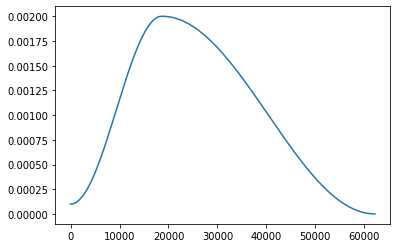

In [18]:
plt.plot(learning_rates)

In [20]:
from tqdm import tqdm
from pprint import PrettyPrinter
pp = PrettyPrinter()

# Parameters
data_folder = './'
keep_difficult = True
batch_size = 64
workers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = './BEST_Batchnorm_training_ssd300.pth.tar'

# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model = checkpoint['model']
model = model.to(device)

# Switch to eval mode
model.eval()

# Load test data
test_dataset = PascalVOCDataset(data_folder,
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=test_dataset.collate_fn,
                                          num_workers=workers,
                                          pin_memory=True)
def evaluate(test_loader, model):
    """
    Evaluate

    test_loader: test data loader
    model:  trained model
    """

    model.eval()

    # Lists to store detected and true boxes, labels, scores
    det_boxes  = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels= list()
    true_scores= list()
    true_difficulties = list()  # it is necessary to know which objects are 'difficult' when we calculate 'mAP' score

    with torch.no_grad():
    # for each batch
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc='Evaluating model')):
            images = images.to(device) # (N, 3, 300, 300)

            # Forward prop
            predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                        min_score=0.01, max_overlap=0.45,
                                                                                        top_k=200)
            
            # Store this batch's results for mAP calculation
            # True boxes & labels
            boxes  = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

        # Cakcukate mAP
        # Calculate mAP
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

        # Print AP for each class
        pp.pprint(APs)

        print('\nMean Average Precision (mAP): %.3f' % mAP)

In [21]:
torch.cuda.empty_cache()
evaluate(test_loader, model)

Evaluating model: 100%|██████████| 78/78 [1:30:32<00:00, 57.51s/it]


{'aeroplane': 0.6450046300888062,
 'bicycle': 0.6474919319152832,
 'bird': 0.4191528260707855,
 'boat': 0.41985252499580383,
 'bottle': 0.18858985602855682,
 'bus': 0.6160959005355835,
 'car': 0.642805814743042,
 'cat': 0.7041723132133484,
 'chair': 0.21765421330928802,
 'cow': 0.5660185217857361,
 'diningtable': 0.5677354335784912,
 'dog': 0.6603556871414185,
 'horse': 0.7064728736877441,
 'motorbike': 0.6220653057098389,
 'person': 0.47038349509239197,
 'pottedplant': 0.20091213285923004,
 'sheep': 0.5007733106613159,
 'sofa': 0.5622828602790833,
 'train': 0.6688744425773621,
 'tvmonitor': 0.47693851590156555}

Mean Average Precision (mAP): 0.525


## Stage II training
Unfreeze the entire network and adjust our learning rate annealing according to resumed epochs.

In [32]:
class MultiBoxLoss(nn.Module):
    """
    Stage II, hooks registered for localtion loss and confidence loss
    
    The Multibox loss function for SSD300 architecture, which is a combination of:

    1) a localization loss for the predicted locations of the boxes, and
    2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels, step):
        """
        Forward propagation.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :param step: the current_iter  used as keys for hook_dicts
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar
        loc_loss.register_hook(lambda grad: localtion_hook_dict.append(grad))

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar
        conf_loss.register_hook(lambda grad: confidence_hook_list.append(grad))

        # TOTAL LOSS
        print(f'confidence loss for this minibatch: {conf_loss:.3f}\n location loss for this minibatch:{loc_loss:.3f}')

        return conf_loss + self.alpha * loc_loss

In [33]:
# the learning rate scheduler used in training loop
sched = combine_scheds([0.3, 0.7], [sched_cos(1e-5, 2e-4), sched_cos(2e-4, 1e-6)])

def train(train_loader, model, criterion, optimizer, epoch, start_epoch, total_iters):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    :param total_iters: total_number of iterations
    """
    model.train()  # training mode enables batchnorm

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # learning rate annealing
        current_iter = (epoch-start_epoch)*n_batches+i
        
        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels, current_iter)  # scalar
                       
        # learning rate anealing and visualization for later
    
        optimizer.param_groups[0]['lr'] = sched(current_iter/(total_iters-start_epoch*n_batches))*2    # this is the bias group

        optimizer.param_groups[1]['lr'] = sched(current_iter/(total_iters-start_epoch*n_batches))      # this is the non-bias group

        learning_rates.append(optimizer.param_groups[1]['lr'])

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)
            print(f'grad_clipped for this minibatch')

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored


def validate(val_loader, model, criterion):
    """
    One epoch's validation.
    :param val_loader: DataLoader for validation data
    :param model: model
    :param criterion: MultiBox loss
    :return: average validation loss
    """
    model.eval()  # eval mode disables dropout

    batch_time = AverageMeter()
    losses = AverageMeter()

    start = time.time()

    # Prohibit gradient computation explicity because I had some problems with memory
    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels, difficulties) in enumerate(val_loader):

            # Move to default device
            images = images.to(device)  # (N, 3, 300, 300)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]

            # Forward prop.
            predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

            # Loss
            loss = criterion(predicted_locs, predicted_scores, boxes, labels, current_iter)

            losses.update(loss.item(), images.size(0))
            batch_time.update(time.time() - start)

            start = time.time()

            # Print status
            if i % print_freq == 0:
                print('[{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(i, len(val_loader),
                                                                      batch_time=batch_time,
                                                                      loss=losses))

    print('\n * LOSS - {loss.avg:.3f}\n'.format(loss=losses))

    return losses.avg

#### Some crucial changes
In this stage, we would unfreeze the weights in the model base archietecture which mean the weights can be updated during back-prop. <br>
Since these are considered quite efficient in terms of feature extraction of images we want to be very careful when doing fine tuning and not to make drastic changes even when we have a bad minibatch.<br>
To do just that, we would first modify the learning rate annealing to be more conservative and then add in `grad_clip` so that a bad minibatch couldn't have drastic impact on our weights in the base model.

In [34]:
for i, param in enumerate(model.base.parameters()):
    if i == 1:
         print(param)

Parameter containing:
tensor([ 0.4034,  0.3778,  0.4644, -0.3228,  0.3940, -0.3953,  0.3951, -0.5496,
         0.2693, -0.7602, -0.3508,  0.2334, -1.3239, -0.1694,  0.3938, -0.1026,
         0.0460, -0.6995,  0.1549,  0.5628,  0.3011,  0.3425,  0.1073,  0.4651,
         0.1295,  0.0788, -0.0492, -0.5638,  0.1465, -0.3890, -0.0715,  0.0649,
         0.2768,  0.3279,  0.5682, -1.2640, -0.8368, -0.9485,  0.1358,  0.2727,
         0.1841, -0.5325,  0.3507, -0.0827, -1.0248, -0.6912, -0.7711,  0.2612,
         0.4033, -0.4802, -0.3066,  0.5807, -1.3325,  0.4844, -0.8160,  0.2386,
         0.2300,  0.4979,  0.5553,  0.5230, -0.2182,  0.0117, -0.5516,  0.2108],
       device='cuda:0', requires_grad=True)


In [35]:
# Training SSD300 with Kaiming_uniform_ and learning rate annealing
global epochs_since_improvement, start_epoch, label_map, best_loss, epoch, checkpoint

data_folder = './'
keep_difficult = True
n_classes = len(label_map)

# Training parameters
checkpoint = './BEST_Batchnorm_training_ssd300.pth.tar'  # path to model checkpoint if consider resume training from there
batch_size = 16
start_epoch = 0    # start at this epoch
epochs = 250       # total training epochs to run without early-stopping
epochs_since_improvement = 0 # record the no. of epochs since last improvement
best_loss = 100.   # assume a hight loss at first
workers = 4        # number of workers for loading data in the DataLoader
print_freq = 200   # print training or validation status every __ batches
lr = 1e-3/2          # learning rate
momentum = 0.9     
weight_decay = 5e-4
grad_clip = 0.5   # consider clipping the gradient when using high learning_rate

torch.cuda.empty_cache()
cudnn.benchmark = True

confidence_hook_list = list()
localtion_hook_list  = list()

# initialize model or load checkpoint
if checkpoint is None:
    model = SSD300(n_classes)
    print(f'After loading model weights, layers model.base frozen condition:{assert_requires_grad(model.base)}')
    print(f'After loading model weights, layers model.aux_convs frozen condition:{assert_requires_grad(model.aux_convs)}')
    print(f'After loading model weights, layers model.pred_convs frozen condition:{assert_requires_grad(model.pred_convs)}')
        
    for i,param in enumerate(model.base.parameters()):
        param.requires_grad = False
        
    print(f'Freeze weights in model.base, condition:{assert_requires_grad(model.base)}')
    
    # Initialize the optimizer, with twice the default learning rate for biases
    biases = list()
    not_biases = list()
    for param_name, param in model.named_parameters():
        if param.requires_grad:
            if param_name.endswith('.bias'):
                biases.append(param)
            else:
                not_biases.append(param)
    optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_loss = checkpoint['best_loss']
    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
    
    print(f'After loading model weights, layers model.base frozen condition:{assert_requires_grad(model.base)}')
    print(f'After loading model weights, layers model.aux_convs frozen condition:{assert_requires_grad(model.aux_convs)}')
    print(f'After loading model weights, layers model.pred_convs frozen condition:{assert_requires_grad(model.pred_convs)}')
        
    for i,param in enumerate(model.base.parameters()):
        param.requires_grad = True
        
    print(f'Unfreeze weights in model.base, condition:{assert_requires_grad(model.base)}')
    
# move to  default device
model = model.to(device)      # model to GPU
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device) # Loss function to GPU

# Custom dataloaders
train_dataset = PascalVOCDataset(data_folder,'train',keep_difficult)
val_dataset   = PascalVOCDataset(data_folder,'test' ,keep_difficult)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                            collate_fn=train_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True) # pass in our collate function here
val_loader    = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                                             collate_fn=val_dataset.collate_fn, num_workers=workers,
                                             pin_memory=True)
# used to schedule learning rate later
n_batches = len(train_loader)

learning_rates = list()
total_iters = epochs*n_batches

# Epochs
for epoch in range(start_epoch, epochs):
            
    train(train_loader=train_loader,
          model=model,
          criterion=criterion,
          optimizer=optimizer,
          epoch=epoch,
          start_epoch = start_epoch,
          total_iters=total_iters
          )

    # One epoch's validation
    val_loss = validate(val_loader=val_loader,
                        model=model,
                        criterion=criterion)

    # Did validation loss improve?
    is_best = val_loss < best_loss
    best_loss = min(val_loss, best_loss)

    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

    else:
        epochs_since_improvement = 0

    # Save checkpoint
    save_checkpoint(epoch, epochs_since_improvement, model, optimizer, val_loss, best_loss, is_best)


Loaded checkpoint from epoch 111. Best loss so far is 3.693.

After loading model weights, layers model.base frozen condition:True
After loading model weights, layers model.aux_convs frozen condition:False
After loading model weights, layers model.pred_convs frozen condition:False
Unfreeze weights in model.base, condition:False
confidence loss for this minibatch: 3.111
 location loss for this minibatch:0.864
grad_clipped for this minibatch
Epoch: [111][0/1035]	Batch Time 3.240 (3.240)	Data Time 0.894 (0.894)	Loss 3.9754 (3.9754)	
confidence loss for this minibatch: 2.903
 location loss for this minibatch:0.796
grad_clipped for this minibatch
confidence loss for this minibatch: 3.015
 location loss for this minibatch:0.783
grad_clipped for this minibatch
confidence loss for this minibatch: 2.391
 location loss for this minibatch:0.645
grad_clipped for this minibatch
confidence loss for this minibatch: 2.928
 location loss for this minibatch:0.870
grad_clipped for this minibatch
confide

confidence loss for this minibatch: 2.901
 location loss for this minibatch:0.742
grad_clipped for this minibatch
confidence loss for this minibatch: 3.023
 location loss for this minibatch:0.814
grad_clipped for this minibatch
confidence loss for this minibatch: 2.770
 location loss for this minibatch:0.748
grad_clipped for this minibatch
confidence loss for this minibatch: 3.026
 location loss for this minibatch:0.739
grad_clipped for this minibatch
confidence loss for this minibatch: 2.676
 location loss for this minibatch:0.791
grad_clipped for this minibatch
confidence loss for this minibatch: 3.373
 location loss for this minibatch:0.895
grad_clipped for this minibatch
confidence loss for this minibatch: 2.460
 location loss for this minibatch:0.653
grad_clipped for this minibatch
confidence loss for this minibatch: 3.285
 location loss for this minibatch:0.836
grad_clipped for this minibatch
confidence loss for this minibatch: 2.470
 location loss for this minibatch:0.615
grad_c

confidence loss for this minibatch: 3.551
 location loss for this minibatch:0.865
grad_clipped for this minibatch
confidence loss for this minibatch: 3.070
 location loss for this minibatch:0.763
grad_clipped for this minibatch
confidence loss for this minibatch: 3.189
 location loss for this minibatch:0.790
grad_clipped for this minibatch
confidence loss for this minibatch: 2.830
 location loss for this minibatch:0.832
grad_clipped for this minibatch
confidence loss for this minibatch: 2.809
 location loss for this minibatch:0.791
grad_clipped for this minibatch
confidence loss for this minibatch: 2.671
 location loss for this minibatch:0.762
grad_clipped for this minibatch
confidence loss for this minibatch: 2.880
 location loss for this minibatch:0.673
grad_clipped for this minibatch
confidence loss for this minibatch: 2.794
 location loss for this minibatch:0.826
grad_clipped for this minibatch
confidence loss for this minibatch: 2.867
 location loss for this minibatch:0.771
grad_c

confidence loss for this minibatch: 2.528
 location loss for this minibatch:0.783
grad_clipped for this minibatch
confidence loss for this minibatch: 2.963
 location loss for this minibatch:0.882
grad_clipped for this minibatch
confidence loss for this minibatch: 2.979
 location loss for this minibatch:0.753
grad_clipped for this minibatch
confidence loss for this minibatch: 3.100
 location loss for this minibatch:0.835
grad_clipped for this minibatch
confidence loss for this minibatch: 2.924
 location loss for this minibatch:0.785
grad_clipped for this minibatch
confidence loss for this minibatch: 2.804
 location loss for this minibatch:0.792
grad_clipped for this minibatch
confidence loss for this minibatch: 3.177
 location loss for this minibatch:0.878
grad_clipped for this minibatch
confidence loss for this minibatch: 2.879
 location loss for this minibatch:0.878
grad_clipped for this minibatch
confidence loss for this minibatch: 2.930
 location loss for this minibatch:0.842
grad_c

confidence loss for this minibatch: 3.066
 location loss for this minibatch:0.802
grad_clipped for this minibatch
confidence loss for this minibatch: 2.762
 location loss for this minibatch:0.766
grad_clipped for this minibatch
confidence loss for this minibatch: 2.380
 location loss for this minibatch:0.763
grad_clipped for this minibatch
confidence loss for this minibatch: 2.868
 location loss for this minibatch:0.699
grad_clipped for this minibatch
confidence loss for this minibatch: 2.965
 location loss for this minibatch:0.846
grad_clipped for this minibatch
confidence loss for this minibatch: 3.105
 location loss for this minibatch:0.785
grad_clipped for this minibatch
confidence loss for this minibatch: 3.376
 location loss for this minibatch:0.769
grad_clipped for this minibatch
confidence loss for this minibatch: 3.133
 location loss for this minibatch:0.814
grad_clipped for this minibatch
confidence loss for this minibatch: 2.860
 location loss for this minibatch:0.860
grad_c

confidence loss for this minibatch: 3.165
 location loss for this minibatch:0.890
grad_clipped for this minibatch
confidence loss for this minibatch: 3.221
 location loss for this minibatch:0.894
grad_clipped for this minibatch
confidence loss for this minibatch: 3.257
 location loss for this minibatch:0.866
grad_clipped for this minibatch
confidence loss for this minibatch: 3.014
 location loss for this minibatch:0.763
grad_clipped for this minibatch
confidence loss for this minibatch: 2.925
 location loss for this minibatch:0.791
grad_clipped for this minibatch
confidence loss for this minibatch: 2.497
 location loss for this minibatch:0.604
grad_clipped for this minibatch
confidence loss for this minibatch: 2.660
 location loss for this minibatch:0.771
grad_clipped for this minibatch
confidence loss for this minibatch: 2.851
 location loss for this minibatch:0.792
grad_clipped for this minibatch
confidence loss for this minibatch: 2.849
 location loss for this minibatch:0.794
grad_c

confidence loss for this minibatch: 2.841
 location loss for this minibatch:0.781
grad_clipped for this minibatch
confidence loss for this minibatch: 2.701
 location loss for this minibatch:0.820
grad_clipped for this minibatch
confidence loss for this minibatch: 2.893
 location loss for this minibatch:0.826
grad_clipped for this minibatch
confidence loss for this minibatch: 3.088
 location loss for this minibatch:0.843
grad_clipped for this minibatch
confidence loss for this minibatch: 2.745
 location loss for this minibatch:0.787
grad_clipped for this minibatch
confidence loss for this minibatch: 2.882
 location loss for this minibatch:0.745
grad_clipped for this minibatch
confidence loss for this minibatch: 2.808
 location loss for this minibatch:0.792
grad_clipped for this minibatch
confidence loss for this minibatch: 2.860
 location loss for this minibatch:0.729
grad_clipped for this minibatch
confidence loss for this minibatch: 3.062
 location loss for this minibatch:0.805
grad_c

confidence loss for this minibatch: 3.042
 location loss for this minibatch:0.799
grad_clipped for this minibatch
confidence loss for this minibatch: 2.650
 location loss for this minibatch:0.790
grad_clipped for this minibatch
confidence loss for this minibatch: 3.027
 location loss for this minibatch:0.763
grad_clipped for this minibatch
confidence loss for this minibatch: 2.762
 location loss for this minibatch:0.793
grad_clipped for this minibatch
confidence loss for this minibatch: 2.927
 location loss for this minibatch:0.757
grad_clipped for this minibatch
confidence loss for this minibatch: 2.826
 location loss for this minibatch:0.843
grad_clipped for this minibatch
confidence loss for this minibatch: 2.523
 location loss for this minibatch:0.699
grad_clipped for this minibatch
confidence loss for this minibatch: 2.832
 location loss for this minibatch:0.817
grad_clipped for this minibatch
confidence loss for this minibatch: 3.013
 location loss for this minibatch:0.831
grad_c

confidence loss for this minibatch: 2.621
 location loss for this minibatch:0.745
grad_clipped for this minibatch
confidence loss for this minibatch: 2.428
 location loss for this minibatch:0.749
grad_clipped for this minibatch
confidence loss for this minibatch: 3.164
 location loss for this minibatch:0.817
grad_clipped for this minibatch
confidence loss for this minibatch: 2.859
 location loss for this minibatch:0.805
grad_clipped for this minibatch
confidence loss for this minibatch: 3.143
 location loss for this minibatch:0.846
grad_clipped for this minibatch
confidence loss for this minibatch: 2.739
 location loss for this minibatch:0.806
grad_clipped for this minibatch
confidence loss for this minibatch: 3.247
 location loss for this minibatch:0.855
grad_clipped for this minibatch
confidence loss for this minibatch: 2.749
 location loss for this minibatch:0.700
grad_clipped for this minibatch
confidence loss for this minibatch: 3.057
 location loss for this minibatch:0.764
grad_c

confidence loss for this minibatch: 2.579
 location loss for this minibatch:0.750
grad_clipped for this minibatch
confidence loss for this minibatch: 2.817
 location loss for this minibatch:0.850
grad_clipped for this minibatch
confidence loss for this minibatch: 2.634
 location loss for this minibatch:0.761
grad_clipped for this minibatch
confidence loss for this minibatch: 2.820
 location loss for this minibatch:0.779
grad_clipped for this minibatch
confidence loss for this minibatch: 2.890
 location loss for this minibatch:0.825
grad_clipped for this minibatch
confidence loss for this minibatch: 2.532
 location loss for this minibatch:0.686
grad_clipped for this minibatch
confidence loss for this minibatch: 2.938
 location loss for this minibatch:0.822
grad_clipped for this minibatch
confidence loss for this minibatch: 2.997
 location loss for this minibatch:0.784
grad_clipped for this minibatch
confidence loss for this minibatch: 3.233
 location loss for this minibatch:0.884
grad_c

confidence loss for this minibatch: 2.840
 location loss for this minibatch:0.844
grad_clipped for this minibatch
confidence loss for this minibatch: 2.906
 location loss for this minibatch:0.817
grad_clipped for this minibatch
confidence loss for this minibatch: 2.764
 location loss for this minibatch:0.774
grad_clipped for this minibatch
confidence loss for this minibatch: 2.865
 location loss for this minibatch:0.849
grad_clipped for this minibatch
confidence loss for this minibatch: 2.872
 location loss for this minibatch:0.731
grad_clipped for this minibatch
confidence loss for this minibatch: 2.619
 location loss for this minibatch:0.838
grad_clipped for this minibatch
confidence loss for this minibatch: 2.862
 location loss for this minibatch:0.797
grad_clipped for this minibatch
confidence loss for this minibatch: 3.248
 location loss for this minibatch:0.947
grad_clipped for this minibatch
confidence loss for this minibatch: 3.075
 location loss for this minibatch:0.807
grad_c

confidence loss for this minibatch: 2.532
 location loss for this minibatch:0.759
grad_clipped for this minibatch
confidence loss for this minibatch: 2.754
 location loss for this minibatch:0.766
grad_clipped for this minibatch
confidence loss for this minibatch: 2.764
 location loss for this minibatch:0.752
grad_clipped for this minibatch
confidence loss for this minibatch: 3.160
 location loss for this minibatch:0.830
grad_clipped for this minibatch
confidence loss for this minibatch: 2.534
 location loss for this minibatch:0.751
grad_clipped for this minibatch
confidence loss for this minibatch: 2.533
 location loss for this minibatch:0.758
grad_clipped for this minibatch
confidence loss for this minibatch: 2.777
 location loss for this minibatch:0.768
grad_clipped for this minibatch
confidence loss for this minibatch: 3.056
 location loss for this minibatch:0.738
grad_clipped for this minibatch
confidence loss for this minibatch: 2.984
 location loss for this minibatch:0.897
grad_c

confidence loss for this minibatch: 2.444
 location loss for this minibatch:0.756
grad_clipped for this minibatch
confidence loss for this minibatch: 2.833
 location loss for this minibatch:0.789
grad_clipped for this minibatch
confidence loss for this minibatch: 3.056
 location loss for this minibatch:0.770
grad_clipped for this minibatch
confidence loss for this minibatch: 3.294
 location loss for this minibatch:0.875
grad_clipped for this minibatch
confidence loss for this minibatch: 2.806
 location loss for this minibatch:0.774
grad_clipped for this minibatch
confidence loss for this minibatch: 3.170
 location loss for this minibatch:0.827
grad_clipped for this minibatch
confidence loss for this minibatch: 2.659
 location loss for this minibatch:0.736
grad_clipped for this minibatch
confidence loss for this minibatch: 2.797
 location loss for this minibatch:0.787
grad_clipped for this minibatch
confidence loss for this minibatch: 2.691
 location loss for this minibatch:0.739
grad_c

confidence loss for this minibatch: 2.775
 location loss for this minibatch:0.803
grad_clipped for this minibatch
confidence loss for this minibatch: 2.299
 location loss for this minibatch:0.665
grad_clipped for this minibatch
confidence loss for this minibatch: 2.894
 location loss for this minibatch:0.912
grad_clipped for this minibatch
confidence loss for this minibatch: 2.802
 location loss for this minibatch:0.872
grad_clipped for this minibatch
confidence loss for this minibatch: 3.353
 location loss for this minibatch:0.855
grad_clipped for this minibatch
confidence loss for this minibatch: 2.865
 location loss for this minibatch:0.743
grad_clipped for this minibatch
confidence loss for this minibatch: 2.801
 location loss for this minibatch:0.714
grad_clipped for this minibatch
confidence loss for this minibatch: 2.680
 location loss for this minibatch:0.725
grad_clipped for this minibatch
confidence loss for this minibatch: 2.694
 location loss for this minibatch:0.692
grad_c

confidence loss for this minibatch: 3.005
 location loss for this minibatch:0.832
grad_clipped for this minibatch
confidence loss for this minibatch: 2.717
 location loss for this minibatch:0.822
grad_clipped for this minibatch
confidence loss for this minibatch: 2.995
 location loss for this minibatch:0.866
grad_clipped for this minibatch
confidence loss for this minibatch: 2.569
 location loss for this minibatch:0.759
grad_clipped for this minibatch
confidence loss for this minibatch: 2.951
 location loss for this minibatch:0.774
grad_clipped for this minibatch
confidence loss for this minibatch: 2.847
 location loss for this minibatch:0.737
grad_clipped for this minibatch
confidence loss for this minibatch: 3.346
 location loss for this minibatch:0.855
grad_clipped for this minibatch
confidence loss for this minibatch: 2.751
 location loss for this minibatch:0.799
grad_clipped for this minibatch
confidence loss for this minibatch: 2.813
 location loss for this minibatch:0.796
grad_c

TypeError: forward() missing 1 required positional argument: 'step'

In [27]:
%debug

> <ipython-input-10-cf31c56b8063>(8)_inner()
      6     pcts = torch.cumsum(pcts, 0)
      7     def _inner(pos):
----> 8         idx = (pos >= pcts).nonzero().max()
      9         actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
     10         return scheds[idx](actual_pos)

ipdb> epoch
99
ipdb> continue


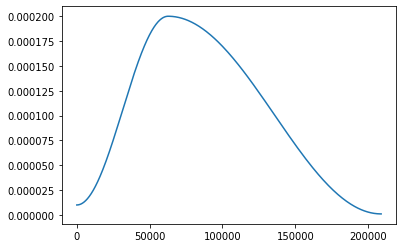

In [33]:
plt.plot(learning_rates)

In [34]:
torch.cuda.empty_cache()
evaluate(test_loader, model)

Evaluating model: 100%|██████████| 78/78 [1:35:29<00:00, 61.53s/it]


{'aeroplane': 0.6165261268615723,
 'bicycle': 0.5860918164253235,
 'bird': 0.4074786901473999,
 'boat': 0.3896823823451996,
 'bottle': 0.1801745891571045,
 'bus': 0.5990822315216064,
 'car': 0.6265562176704407,
 'cat': 0.6562954783439636,
 'chair': 0.18249323964118958,
 'cow': 0.5176485180854797,
 'diningtable': 0.5414201021194458,
 'dog': 0.6440056562423706,
 'horse': 0.6971898078918457,
 'motorbike': 0.6127294898033142,
 'person': 0.4373147487640381,
 'pottedplant': 0.201759472489357,
 'sheep': 0.46855685114860535,
 'sofa': 0.516301155090332,
 'train': 0.6296987533569336,
 'tvmonitor': 0.41355180740356445}

Mean Average Precision (mAP): 0.496
